### Libraries import

In [1]:
import csv
import math
import copy
import numpy as np
import pandas as pd
import random as rd
from tqdm import tqdm
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection, LineCollection

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


###Spread function

In [4]:
def graph_generation(graph_type:str,
                     number_of_nodes:int, 
                     BA_connect:int = None, 
                     ER_prob:float = None, 
                     CL_average:int = None):
  if graph_type == 'BA':
    G = nx.barabasi_albert_graph(number_of_nodes, BA_connect)
  elif graph_type == 'ER':
    G = nx.erdos_renyi_graph(number_of_nodes, ER_prob)
  elif graph_type == 'CL':
    # Model's Parameters: Generate a random Chung-Lu graph with average degree d, max degree m, and power-law degree distribution with exponent gamma
    # Source: https://github.com/ftudisco/scalefreechunglu/blob/master/python/example.py
    n = number_of_nodes
    gamma = 2.2
    m = n ** 0.4
    d = CL_average
    p = 1/(gamma-1)
    c = (1-p)*d*(n**p)
    i0 = (c/m)**(1/p) - 1
    w = [c/((i+i0)**p) for i in range(n)]
    G = nx.expected_degree_graph(w)
  else:
    print("Wrong graph_type. Choose BA, ER or CL.")
  print(G.size())

  return G

In [5]:
# Set parametrization for the graphs
number_of_days = 10000
number_of_nodes = 2500
new_grains = []
BA_connect = 1
ER_prob = 0.0016
CL_average = 10
for d in range(0, number_of_days):
  grain = np.random.randint(number_of_nodes)
  new_grains.append(grain)

In [6]:
# Set additional parametrization in case of higher dissipation from the system
new_grains_plus = []
new_grains_minus = []
for d in range(0, number_of_days):
  grain_plus = np.random.randint(number_of_nodes)
  new_grains_plus.append(grain_plus)

  grain_minus = np.random.randint(number_of_nodes)
  new_grains_minus.append(grain_minus)

In [7]:
# Function for calculation of number of sand grains in and out of the model
def counter(G, number_of_days):
  inner = []
  outer = []
  i = 0

  final_status = pd.DataFrame.from_dict(dict(G.nodes(data=True)), orient='index')
  for column in final_status:
    i += 1
    inner.append(np.sum(final_status[column]))
    outer.append(i - np.sum(final_status[column]))

  return inner, outer

In [75]:
# Function for modelling of spread for Bak-Tang-Wiesenfeld, Manna, Feders
# and stochastic Feders base and facilitated models on cellular automatons.
# Also there is a possibility to change the regime of the system from +1 
# each turn to +2-1, which partially changes behaviour of the system,
# or to +1-1, which allows to avoid most of the falls.
def spread(model:str,
           G,
           number_of_days:int,
           new_grains:list,
           graph_type:int,
           facilitated:bool = False,
           ad_dissipation:bool = False,
           neutral_state:bool = False,
           new_grains_plus:list = None,
           new_grains_minus: list = None,
           ):

  inner = []
  outer = []
  falls = []
  ones = []
  deg = []

  degrees = [[node, val]  for (node, val) in G.degree()]
  for degree in degrees:
    deg.append(degree[1])
    if degree[1] == 1:
      ones.append(degree[0])

  status = pd.DataFrame()
  for j in range(0, number_of_days):
    status['ill'+str(j)] = np.zeros(G.number_of_nodes())

  node_attr = status.to_dict('index')
  nx.set_node_attributes(G, node_attr)

  if facilitated == True:
    facilit_list = [[0 for x in range(G.number_of_nodes())] for z in range(number_of_days)]

  for d in tqdm(range(0, number_of_days-1)):
    falls_d = 0
    if ad_dissipation == True:
      for node in G.nodes(data=True):
        if node[0] == new_grains[d]:
          node[1]['ill'+str(d)] += 1.0
        if node[0] == new_grains_plus[d]:
          node[1]['ill'+str(d)] += 1.0
        if node[0] == new_grains_minus[d]:
          node[1]['ill'+str(d)] -= 1.0          
        node[1]['ill'+str(d+1)] += node[1]['ill'+str(d)]
    elif neutral_state == True:
      for node in G.nodes(data=True):
        if node[0] == new_grains[d]:
          node[1]['ill'+str(d)] += 1.0
        if node[0] == new_grains_minus[d]:
          node[1]['ill'+str(d)] -= 1.0          
        node[1]['ill'+str(d+1)] += node[1]['ill'+str(d)]    
    else:
      for node in G.nodes(data=True):
        if node[0] == new_grains[d]:
          node[1]['ill'+str(d)] += 1.0
        node[1]['ill'+str(d+1)] += node[1]['ill'+str(d)]
    for node in G.nodes(data=True):
      if facilitated == False:
        if d <= (number_of_days-1) and node[1]['ill'+str(d)] >= deg[node[0]] and deg[node[0]] > 0:
          if model == "BTW":
            G, falls_d = BTW(G, ones, falls_d, d, node, deg[node[0]])
          if model == "MA":
            G, falls_d = MA(G, ones, falls_d, d, node, deg[node[0]])
          if model == "FE":
            G, falls_d = FE(G, ones, falls_d, d, node, deg[node[0]])    
          if model == "SFE":
            G, falls_d = SFE(G, ones, falls_d, d, node, deg[node[0]])
      else:
        if d<=(number_of_days-1) and (node[1]['ill'+str(d)] >= deg[node[0]] or facilit_list[d][node[0]] >= 2) and deg[node[0]] > 0:
          if model == "BTW":
            G, facilit_list, falls_d = BTW_fa(G, facilit_list, ones, falls_d, d, node, deg[node[0]])
          if model == "MA":
            G, facilit_list, falls_d = MA_fa(G, facilit_list, ones, falls_d, d, node, deg[node[0]])
          if model == "FE":
            G, facilit_list, falls_d = FE_fa(G, facilit_list, ones, falls_d, d, node, deg[node[0]])    
          if model == "SFE":
            G, facilit_list, falls_d = SFE_fa(G, facilit_list, ones, falls_d, d, node, deg[node[0]])

    if d <= number_of_days-2:
      falls.append(falls_d)
  inner, outer = counter(G, d)

  # print(inner)
  # print(outer)
  # print(falls)
  data = pd.DataFrame(falls)
  graph_name = model + '_' + graph_type
  if facilitated == True: 
    graph_name = graph_name + '_fa'
  if ad_dissipation == True: 
    graph_name = graph_name + '_ad'
  if neutral_state == True: 
    graph_name = graph_name + '_ns'  

    data.to_csv('/content/drive/MyDrive/MMCC/Graph_SOC/' + graph_name + '.csv', index=False)

  fig, axs = plt.subplots(2, 1, figsize=(35, 20))
  axs[0].xaxis.get_major_locator().set_params(integer=True)
  axs[0].yaxis.get_major_locator().set_params(integer=True)
  axs[1].xaxis.get_major_locator().set_params(integer=True)
  axs[1].yaxis.get_major_locator().set_params(integer=True)
  axs[0].set(ylim=(0, number_of_days))
  axs[1].set(ylim=(0, 100))
  axs[0].ticklabel_format(style='plain')
  axs[1].ticklabel_format(style='plain')
  axs[0].plot(list(range(number_of_days)), inner, color='#40a6d1', alpha = 0.5, label = "Inner Grains")
  axs[0].plot(list(range(number_of_days)), outer, color='red', alpha = 0.5, label = "Outer Grains")
  axs[0].legend(loc = 'upper right', fontsize='medium')
  axs[0].set_title('Number of grains in and out of the ' + graph_name + ' model')
  axs[1].plot(list(range(number_of_days-1)), falls, color='#40a6d1', alpha = 0.5)
  axs[1].set_title('Number of falls in the ' + graph_name + ' model')
  plt.setp(axs[0], xlabel='Day', ylabel='Grains')
  plt.setp(axs[1], xlabel='Day', ylabel='Falls')
  plt.tight_layout()
  plt.show()

### Model definition

In [9]:
def BTW(G, ones, falls_d, d, node, crit):
  falls_d += 1
  if node[0] not in ones:
    neighbors = [n for n in G.neighbors(node[0])]
    for neighbor in G.nodes(data=True):
      if neighbor[0] in neighbors:
        neighbor[1]['ill'+str(d+1)] += 1
  node[1]['ill'+str(d+1)] -= crit

  return G, falls_d

In [10]:
def BTW_fa(G, facilit_list, ones, falls_d, d, node, crit):
  falls_d += 1
  if node[0] not in ones:
    neighbors = [n for n in G.neighbors(node[0])]
    if node[1]['ill'+str(d)] >= crit:
      for neighbor in G.nodes(data=True):
        if neighbor[0] in neighbors:
          neighbor[1]['ill'+str(d+1)] += 1
          facilit_list[d+1][neighbor[0]] += 1
      node[1]['ill'+str(d+1)] -= crit
    elif node[1]['ill'+str(d)] < crit and node[1]['ill'+str(d)] > 0:
      remains = node[1]['ill'+str(d)]
      for neighbor in G.nodes(data=True):
        if neighbor[0] in neighbors:
          n = rd.randint(0, remains)
          remains -= n
          neighbor[1]['ill'+str(d+1)] += n
          if n > 0:
            facilit_list[d+1][neighbor[0]] += 1
      node[1]['ill'+str(d+1)] -= node[1]['ill'+str(d)]
  else:
    node[1]['ill'+str(d+1)] -= crit

  return G, facilit_list, falls_d

In [11]:
def MA(G, ones, falls_d, d, node, crit):
  falls_d += 1
  if node[0] not in ones:
    neighbors = [n for n in G.neighbors(node[0])]
    remains = copy.copy(crit)
    for neighbor in G.nodes(data=True):
      if neighbor[0] in neighbors:
        n = rd.randint(0, remains)
        remains -= n
        neighbor[1]['ill'+str(d+1)] += n
  node[1]['ill'+str(d+1)] -= crit

  return G, falls_d

In [12]:
def MA_fa(G, facilit_list, ones, falls_d, d, node, crit):
  falls_d += 1
  if node[0] not in ones:
    neighbors = [n for n in G.neighbors(node[0])]
    if node[1]['ill'+str(d)] >= crit:
      remains = copy.copy(crit)
      for neighbor in G.nodes(data=True):
        if neighbor[0] in neighbors:
          n = rd.randint(0, remains)
          remains -= n
          neighbor[1]['ill'+str(d+1)] += n
          if n > 0 and d+1 <= len(facilit_list):
            facilit_list[d+1][neighbor[0]] += 1
      node[1]['ill'+str(d+1)] -= crit
    elif node[1]['ill'+str(d)] < crit and node[1]['ill'+str(d)] > 0:
      remains = node[1]['ill'+str(d)]
      for neighbor in G.nodes(data=True):
        if neighbor[0] in neighbors:
          n = rd.randint(0, remains)
          remains -= n
          neighbor[1]['ill'+str(d+1)] += n
          if n > 0 and d+1 <= len(facilit_list):
            facilit_list[d+1][neighbor[0]] += 1
      node[1]['ill'+str(d+1)] -= node[1]['ill'+str(d)]
  else:
    node[1]['ill'+str(d+1)] -= crit

  return G, facilit_list, falls_d

In [13]:
def FE(G, ones, falls_d, d, node, crit):
  falls_d += 1
  if node[0] not in ones:
    neighbors = [n for n in G.neighbors(node[0])]
    for neighbor in G.nodes(data=True):
      if neighbor[0] in neighbors:
        neighbor[1]['ill'+str(d+1)] += 1
  node[1]['ill'+str(d+1)] -= node[1]['ill'+str(d)]

  return G, falls_d

In [14]:
def FE_fa(G, facilit_list, ones, falls_d, d, node, crit):
  falls_d += 1
  if node[0] not in ones:
    neighbors = [n for n in G.neighbors(node[0])]
    if node[1]['ill'+str(d)] >= crit:
      for neighbor in G.nodes(data=True):
        if neighbor[0] in neighbors:
          neighbor[1]['ill'+str(d+1)] += 1
          facilit_list[d+1][neighbor[0]] += 1
      node[1]['ill'+str(d+1)] -= node[1]['ill'+str(d)]
    elif node[1]['ill'+str(d)] < crit and node[1]['ill'+str(d)] > 0:
      remains = node[1]['ill'+str(d)]
      for neighbor in G.nodes(data=True):
        if neighbor[0] in neighbors:
          n = rd.randint(0, remains)
          remains -= n
          neighbor[1]['ill'+str(d+1)] += n
          if n > 0 and d+1 <= len(facilit_list):
            facilit_list[d+1][neighbor[0]] += 1
      node[1]['ill'+str(d+1)] -= node[1]['ill'+str(d)]
  else:
    node[1]['ill'+str(d+1)] -= node[1]['ill'+str(d)]

  return G, facilit_list, falls_d

In [15]:
def SFE(G, ones, falls_d, d, node, crit):
  falls_d += 1
  if node[0] not in ones:
    neighbors = [n for n in G.neighbors(node[0])]
    remains = copy.copy(crit)
    for neighbor in G.nodes(data=True):
      if neighbor[0] in neighbors:
        n = rd.randint(0, remains)
        remains -= n
        neighbor[1]['ill'+str(d+1)] += n
  node[1]['ill'+str(d+1)] -= node[1]['ill'+str(d)]

  return G, falls_d

In [16]:
def SFE_fa(G, facilit_list, ones, falls_d, d, node, crit):
  falls_d += 1
  if node[0] not in ones:
    neighbors = [n for n in G.neighbors(node[0])]
    if node[1]['ill'+str(d)] >= crit:
      remains = copy.copy(crit)
      for neighbor in G.nodes(data=True):
        if neighbor[0] in neighbors:
          n = rd.randint(0, remains)
          remains -= n
          neighbor[1]['ill'+str(d+1)] += n
          if n > 0 and d+1 <= len(facilit_list):
            facilit_list[d+1][neighbor[0]] += 1
      node[1]['ill'+str(d+1)] -= node[1]['ill'+str(d)]
    elif node[1]['ill'+str(d)] < crit and node[1]['ill'+str(d)] > 0:
      remains = node[1]['ill'+str(d)]
      for neighbor in G.nodes(data=True):
        if neighbor[0] in neighbors:
          n = rd.randint(0, remains)
          remains -= n
          neighbor[1]['ill'+str(d+1)] += n
          if n > 0 and d+1 <= len(facilit_list):
            facilit_list[d+1][neighbor[0]] += 1
      node[1]['ill'+str(d+1)] -= node[1]['ill'+str(d)]
  else:
    node[1]['ill'+str(d+1)] -= node[1]['ill'+str(d)]

  return G, facilit_list, falls_d

### Graph Generation

In [17]:
G_BA = graph_generation(graph_type = "BA", number_of_nodes = number_of_nodes, BA_connect = BA_connect)

2499


In [18]:
G_ER = graph_generation(graph_type = "ER", number_of_nodes = number_of_nodes, ER_prob = ER_prob)

4956


In [19]:
G_CL = graph_generation(graph_type = "CL", number_of_nodes = number_of_nodes, CL_average = CL_average)

5257


### Bak-Tang-Wiesenfeld

#### Standart Model

##### Standart Dissipation

100%|██████████| 9999/9999 [02:02<00:00, 81.69it/s]


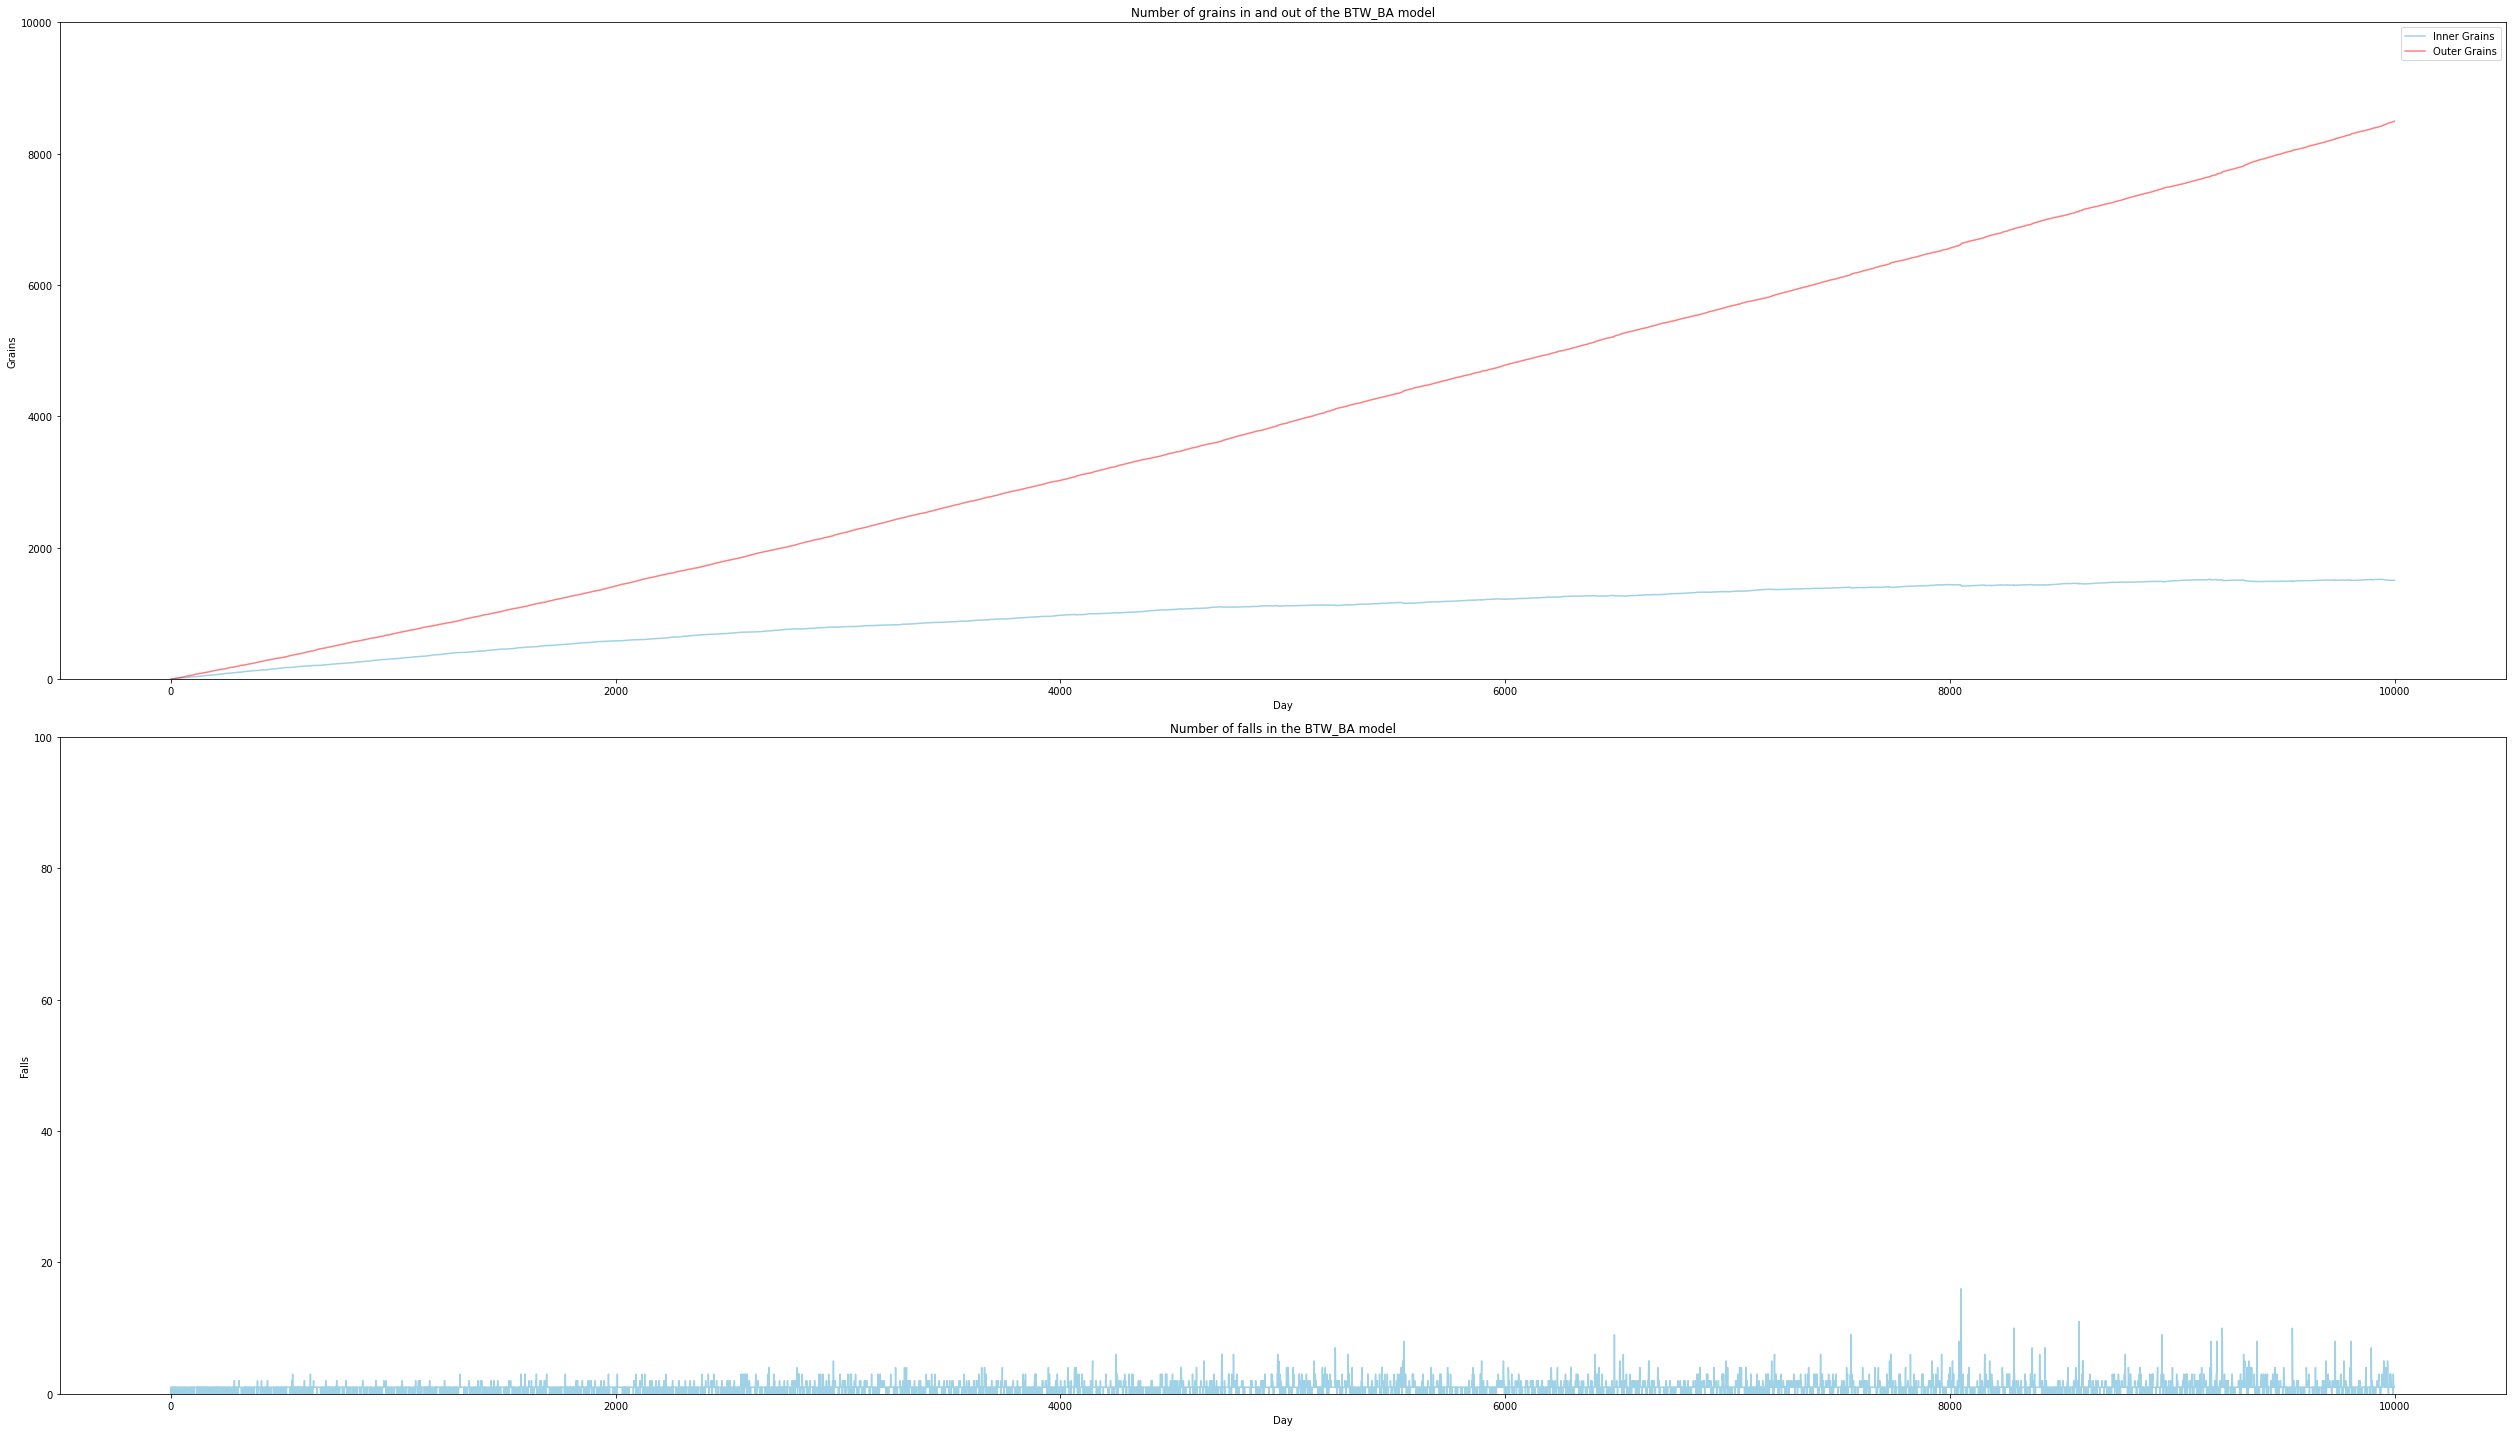

In [20]:
spread("BTW", G_BA, number_of_days, new_grains, "BA")

100%|██████████| 9999/9999 [02:16<00:00, 73.22it/s]


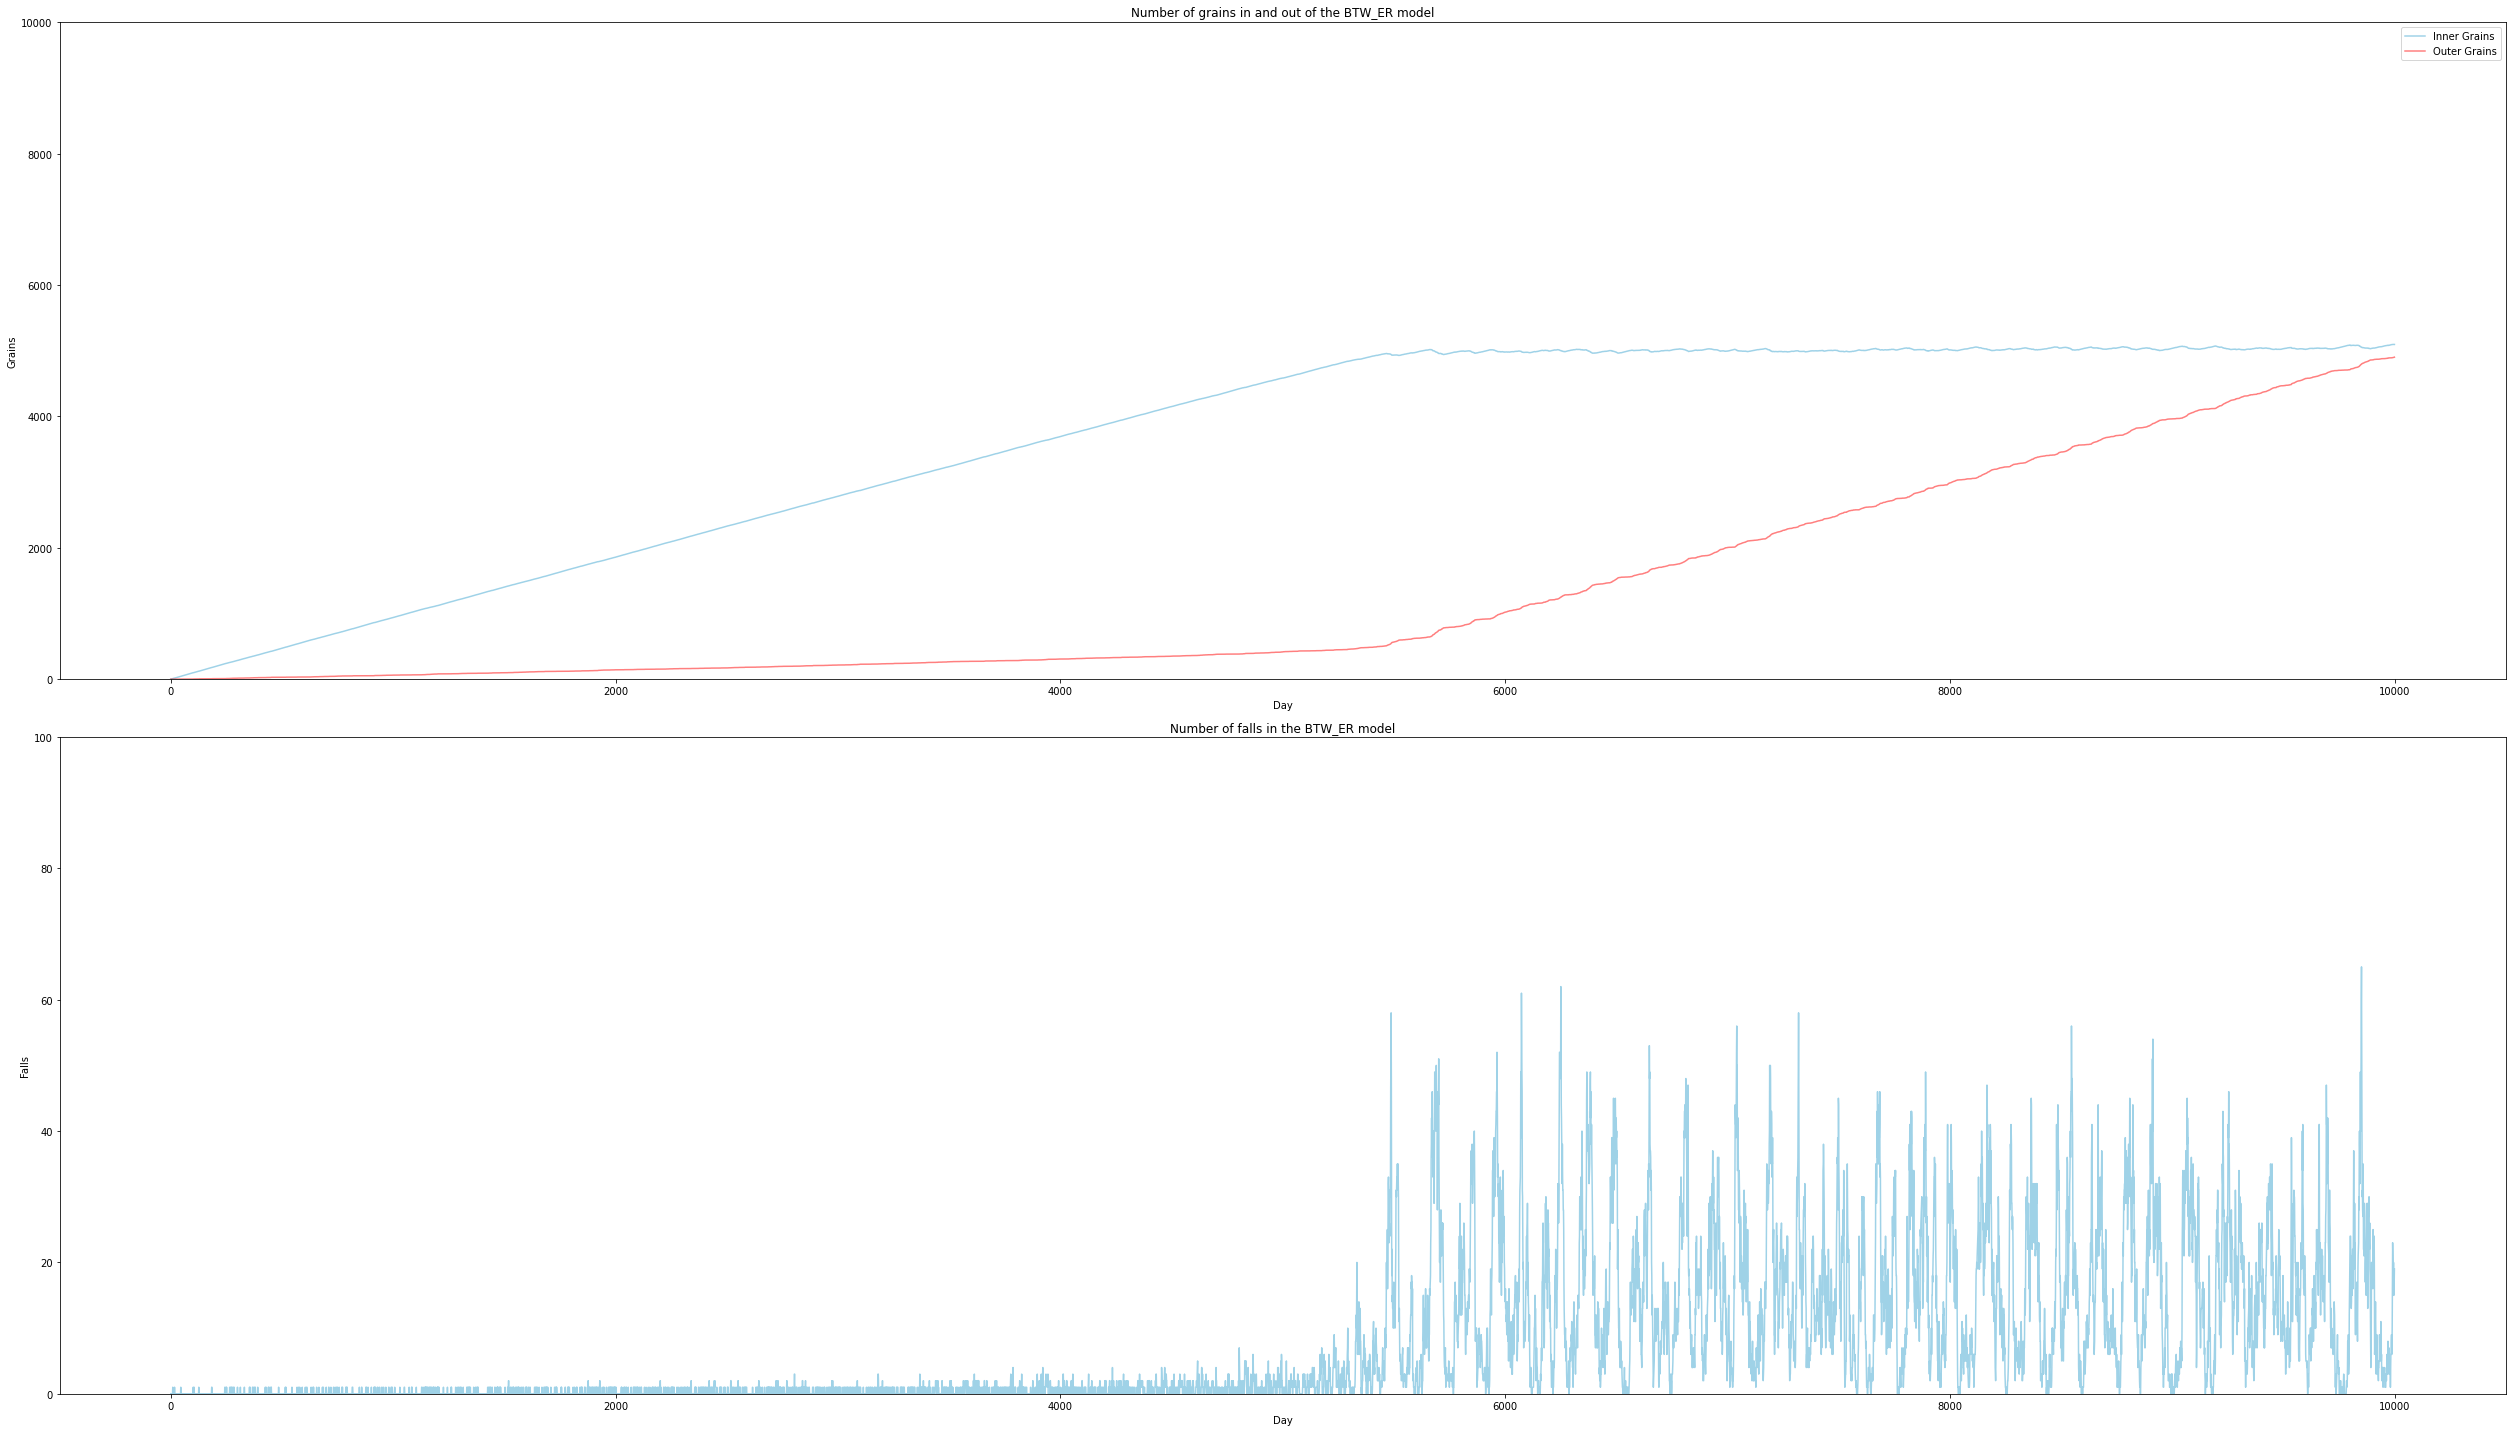

In [21]:
spread("BTW", G_ER, number_of_days, new_grains, "ER")

100%|██████████| 9999/9999 [01:50<00:00, 90.12it/s]


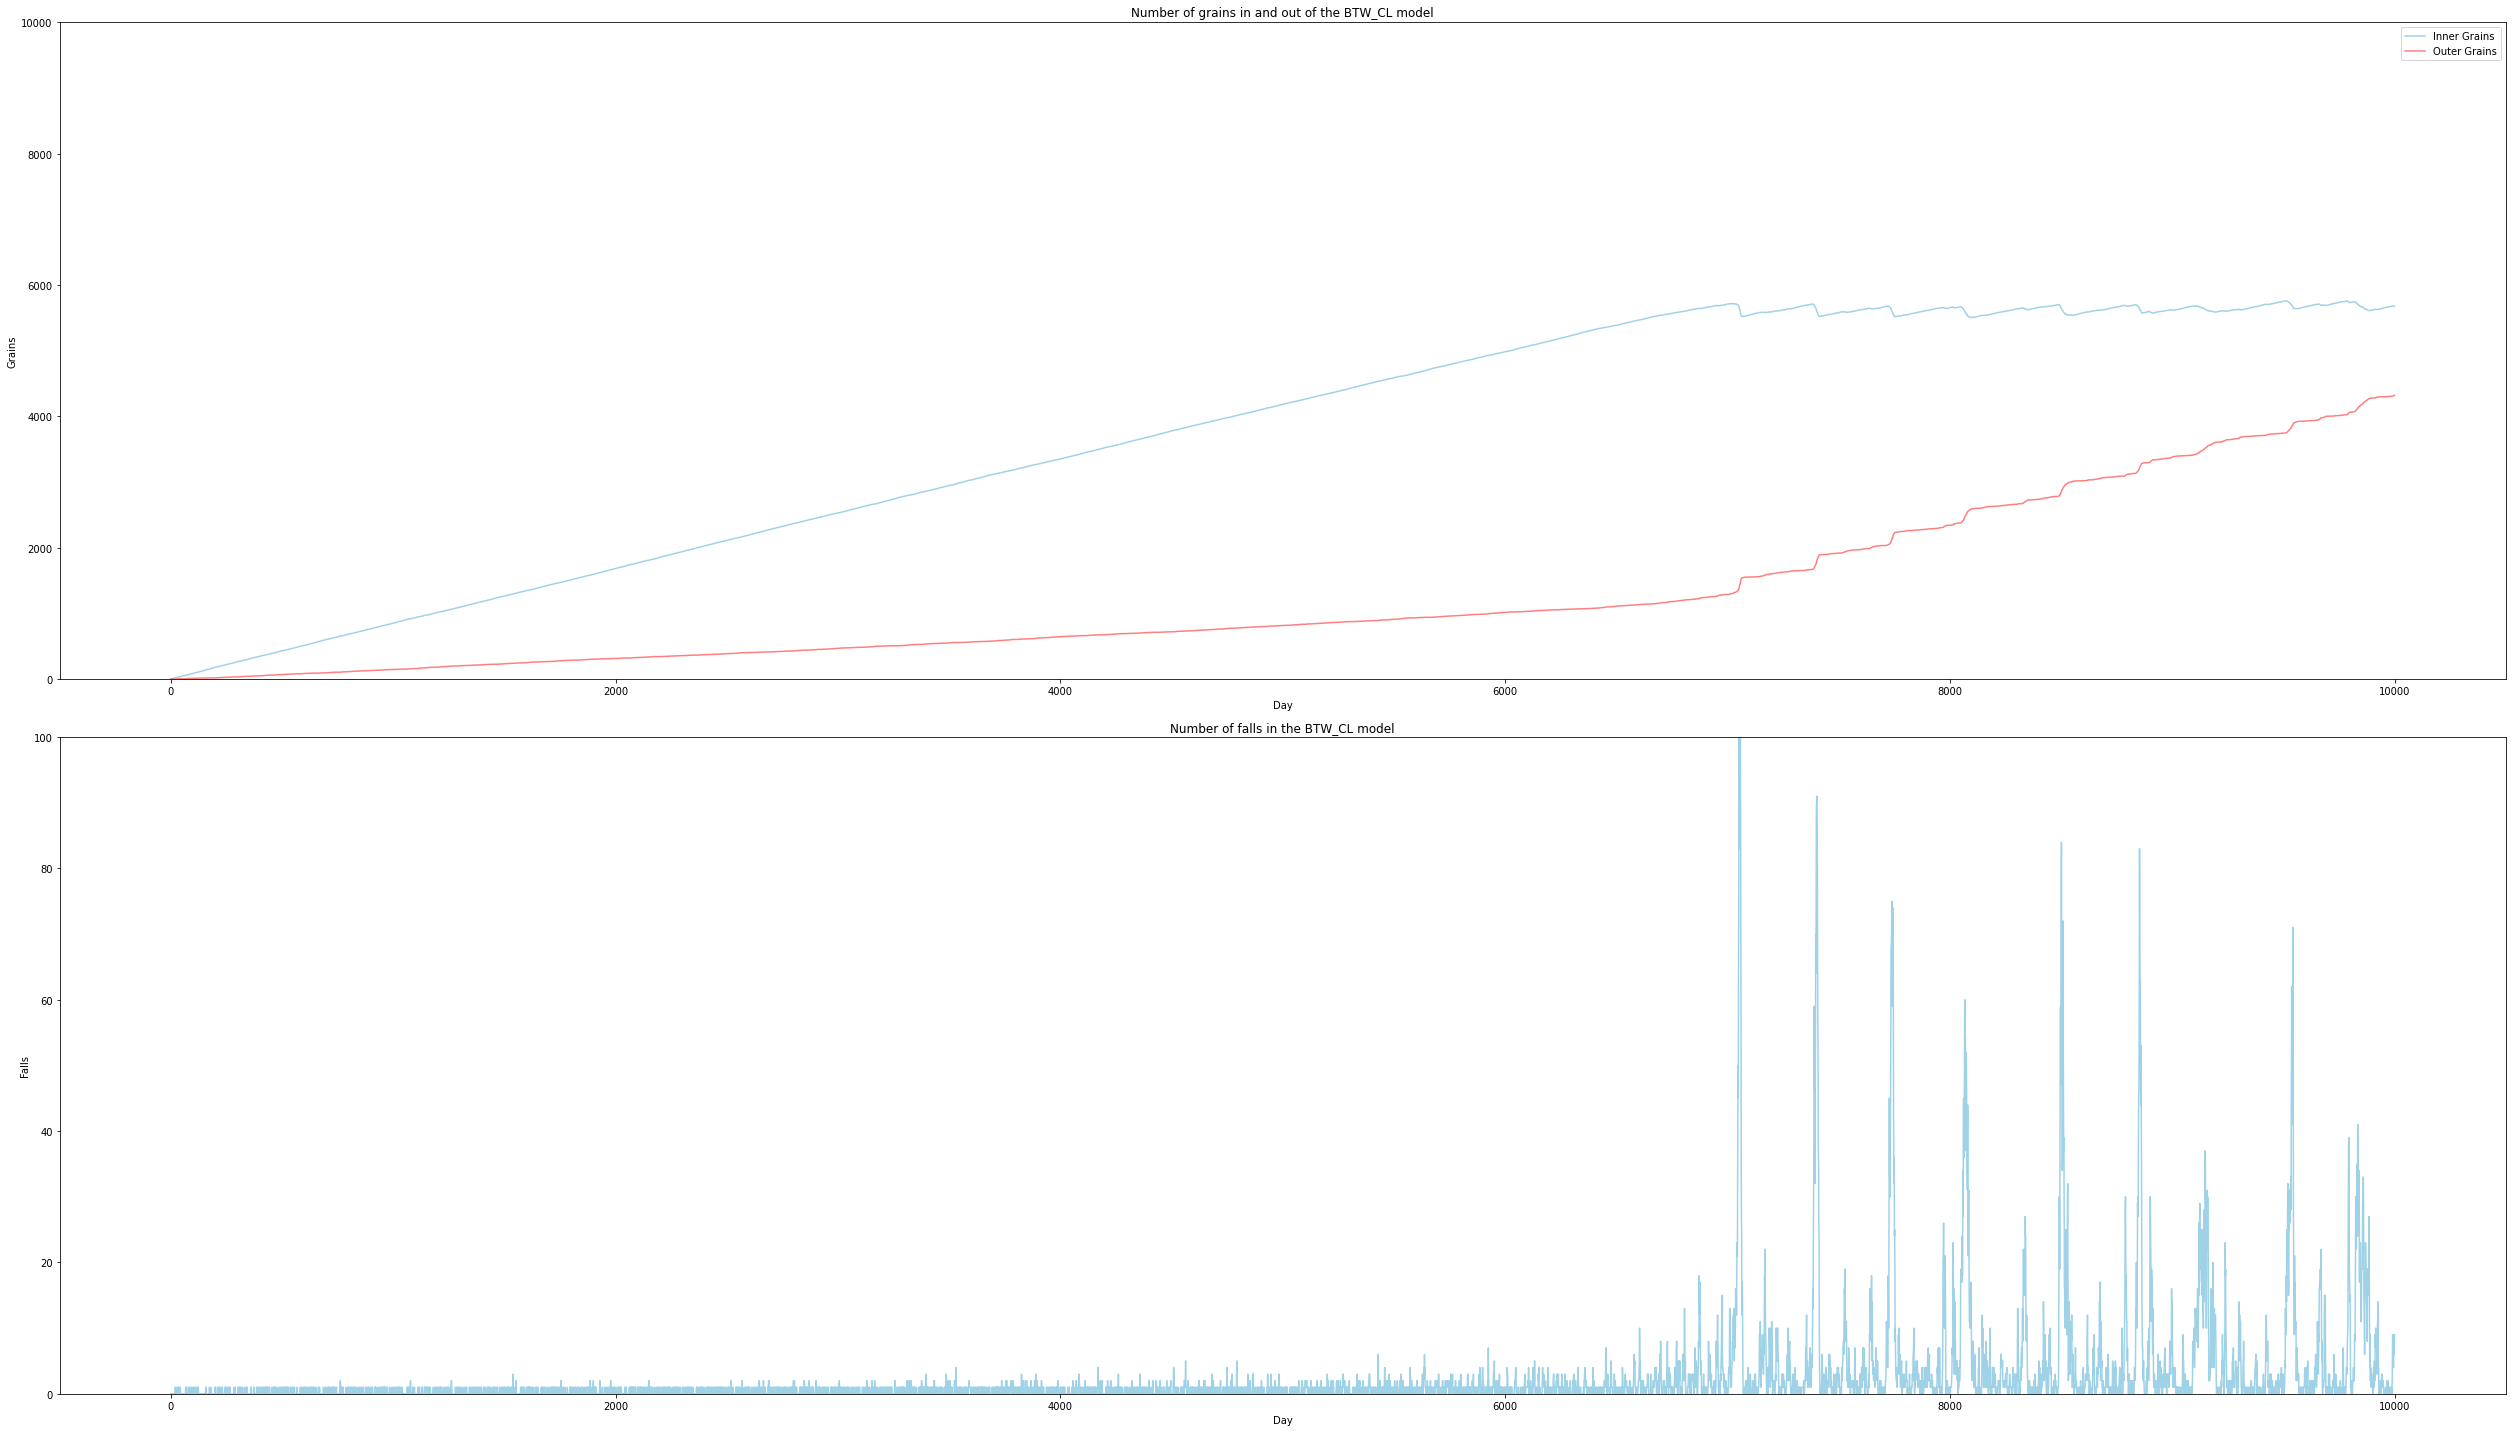

In [22]:
spread("BTW", G_CL, number_of_days, new_grains, "CL")

##### Additional Dissipation

100%|██████████| 9999/9999 [02:05<00:00, 79.76it/s]


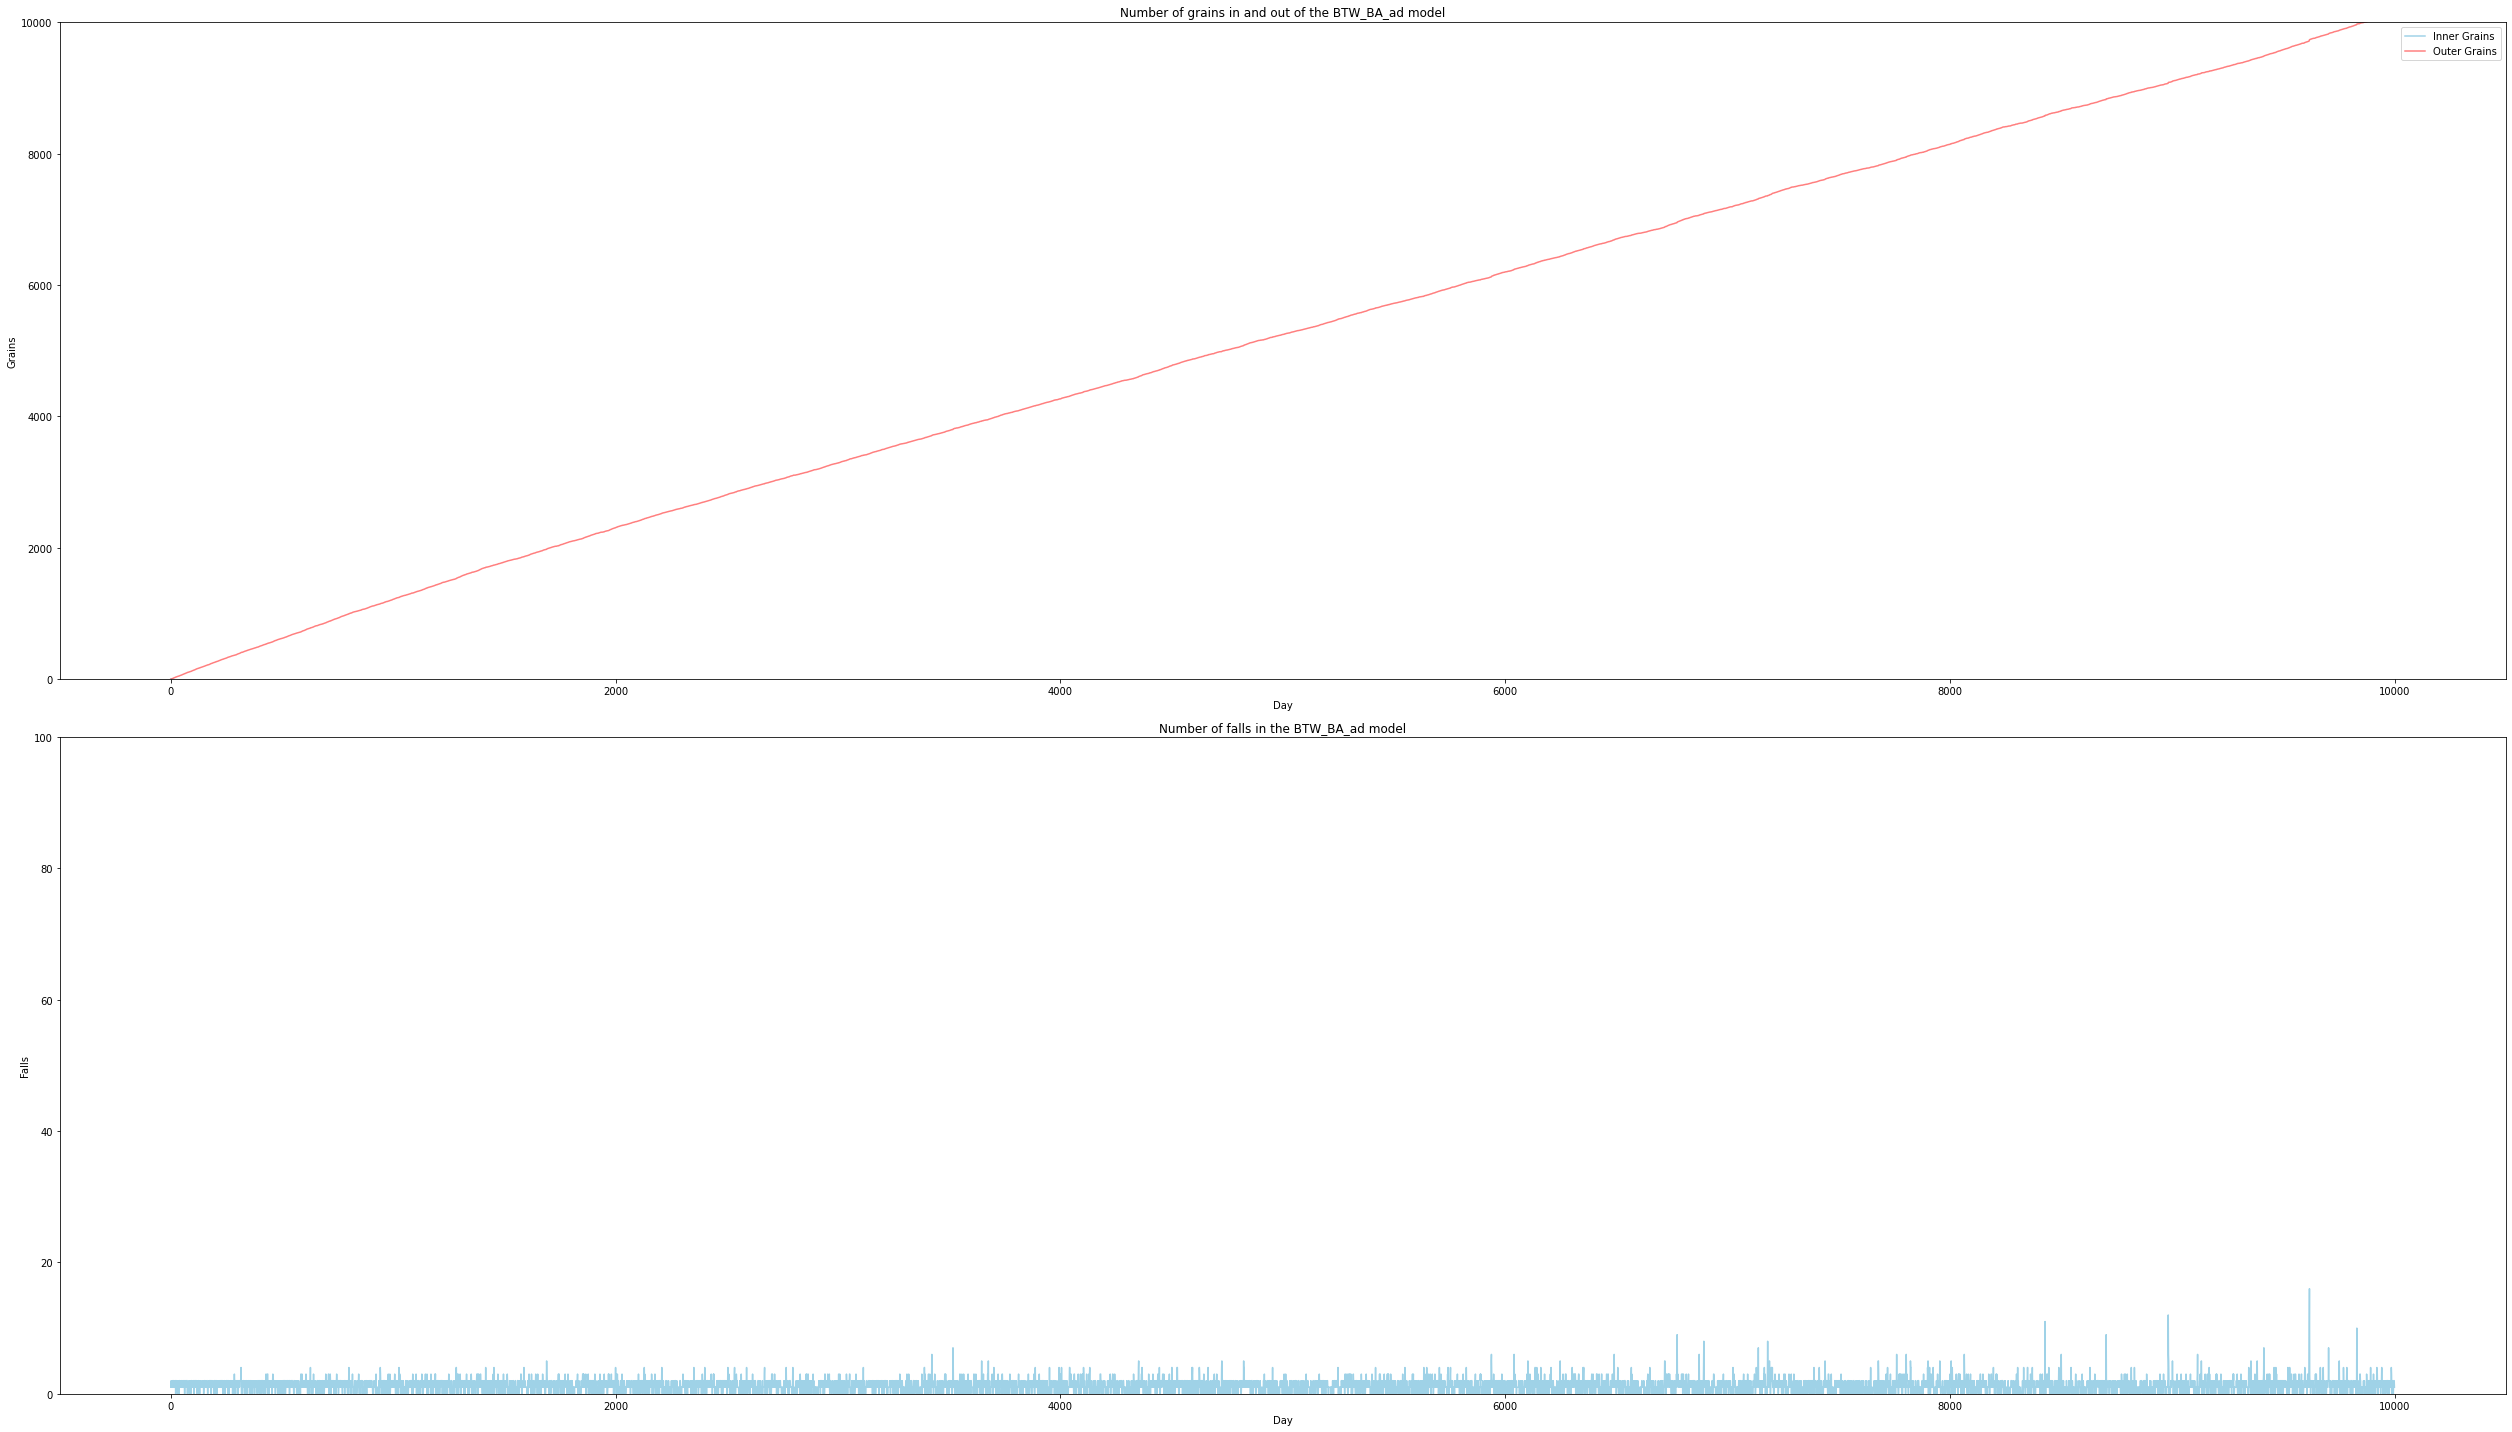

In [23]:
spread("BTW", G_BA, number_of_days, new_grains, "BA", ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

100%|██████████| 9999/9999 [02:22<00:00, 69.98it/s]


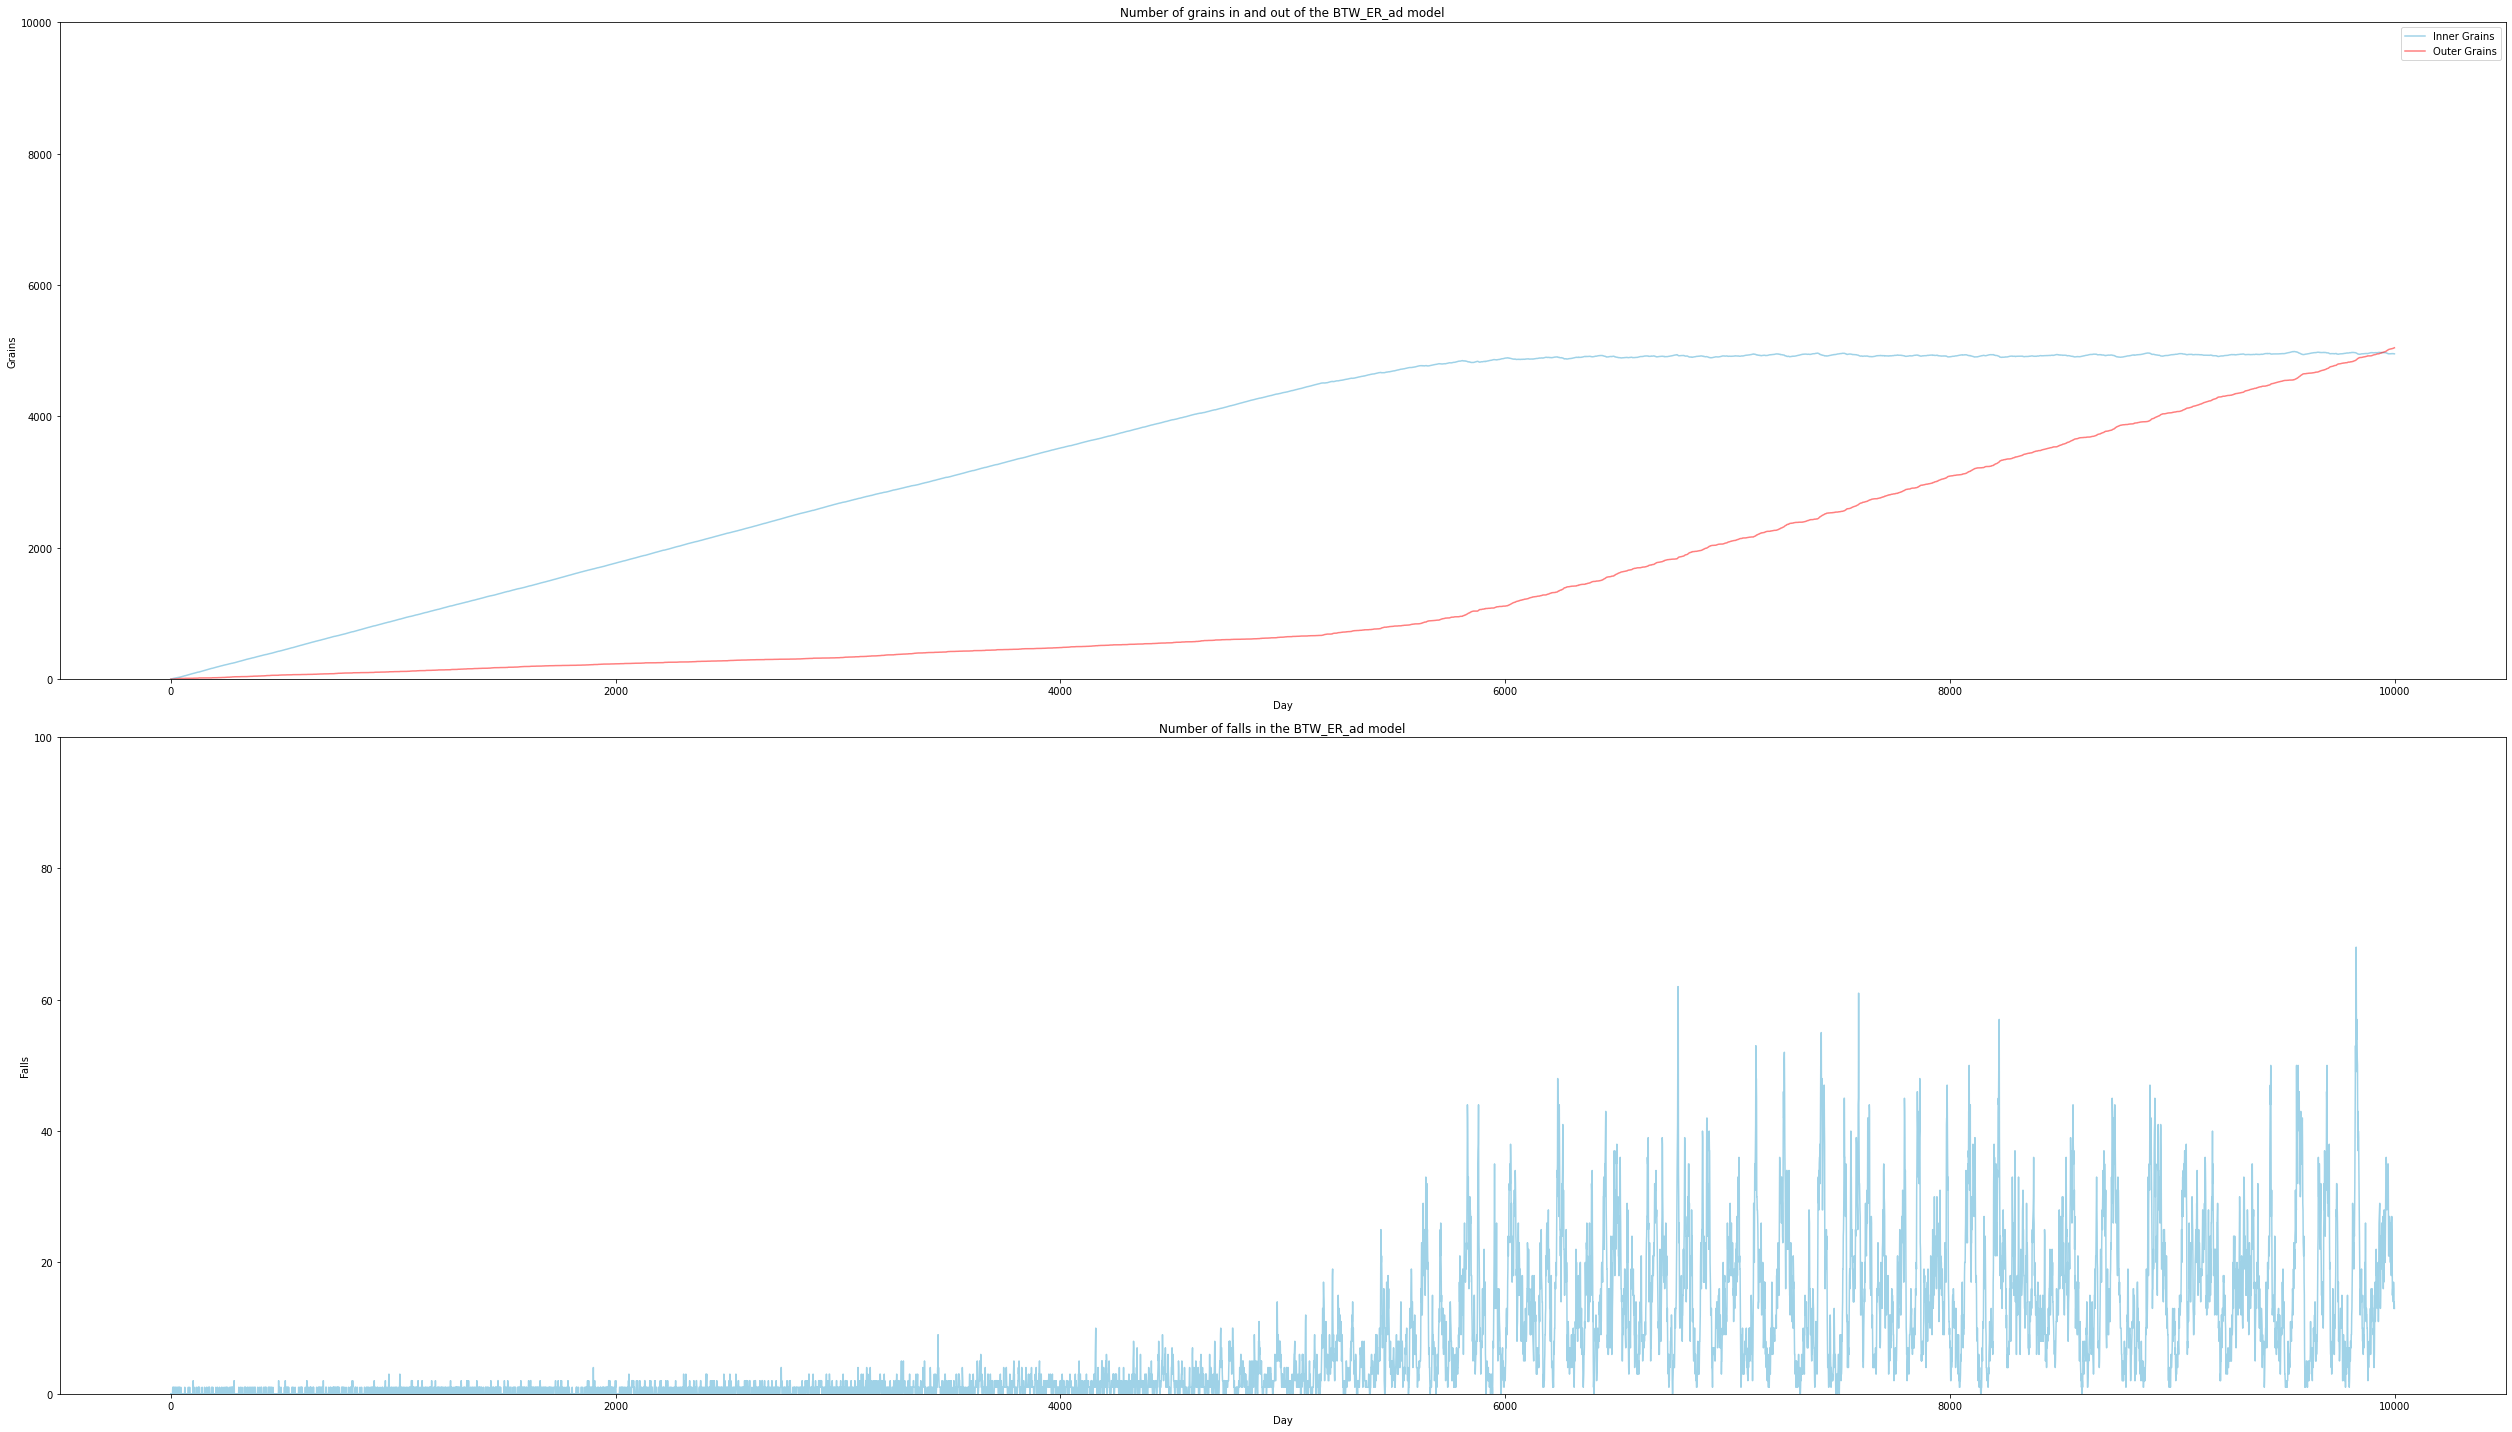

In [24]:
spread("BTW", G_ER, number_of_days, new_grains, "ER", ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

100%|██████████| 9999/9999 [02:03<00:00, 80.93it/s]


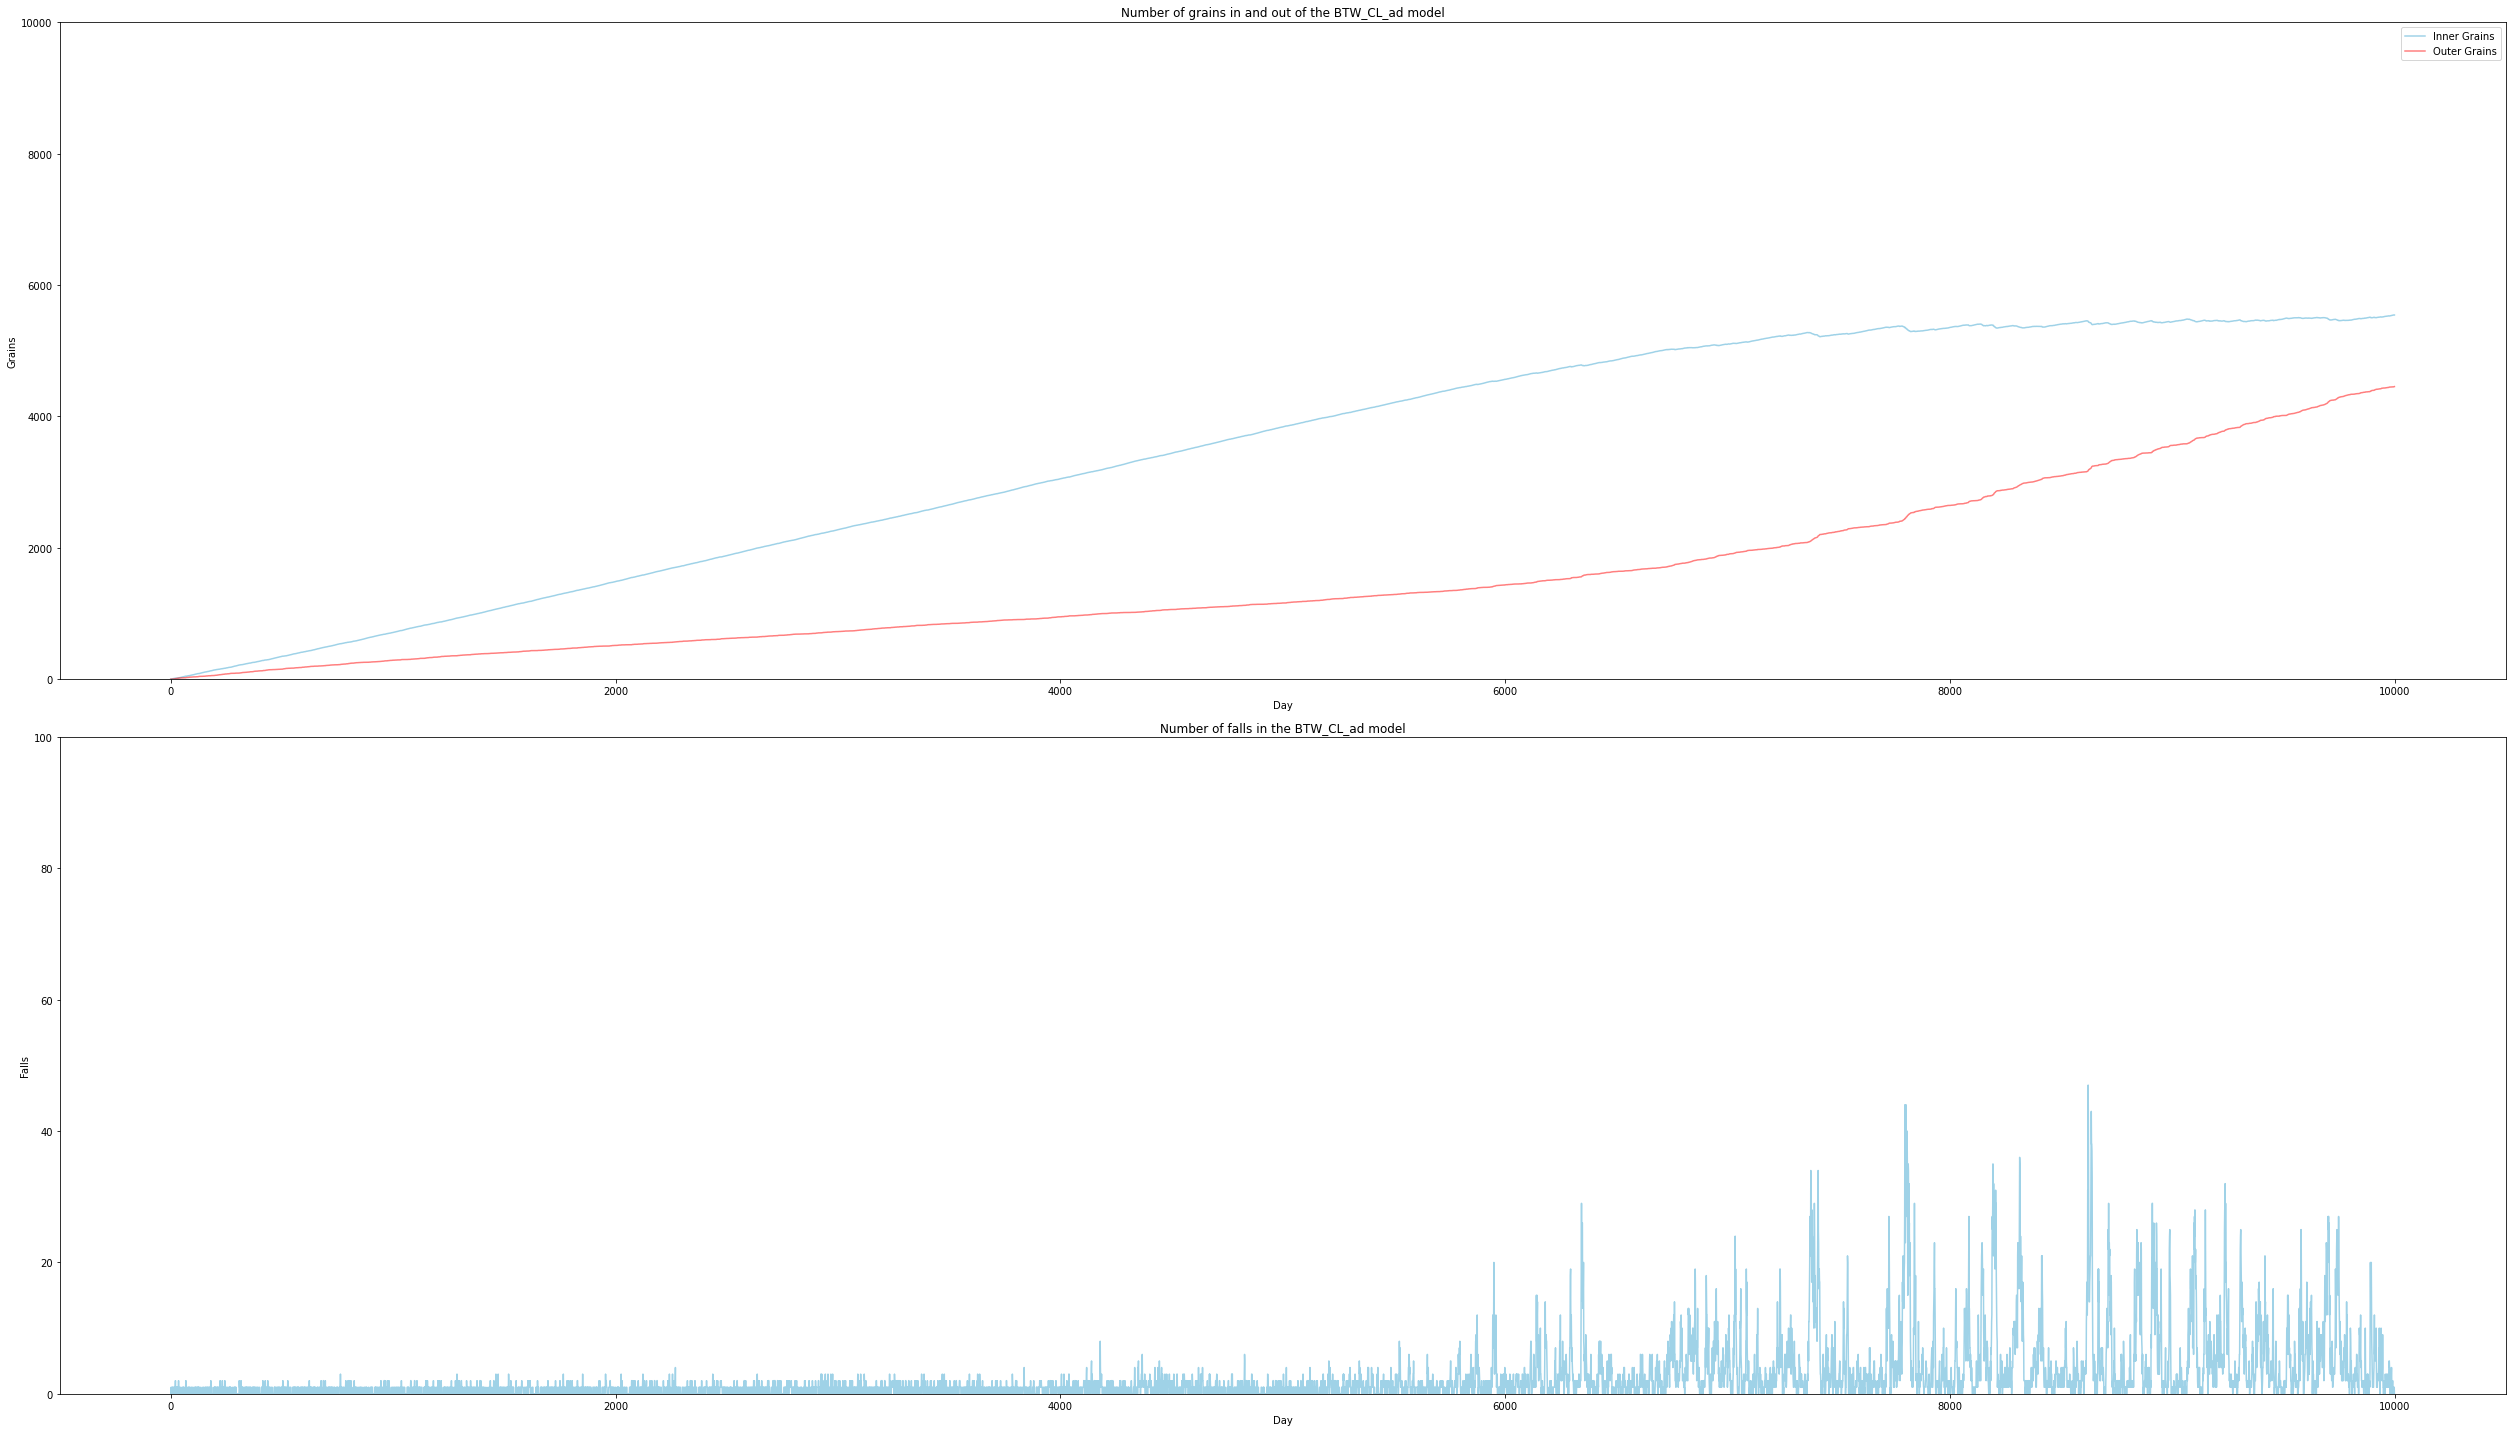

In [25]:
spread("BTW", G_CL, number_of_days, new_grains, "CL", ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

##### Neutral State

100%|██████████| 9999/9999 [01:50<00:00, 90.22it/s]


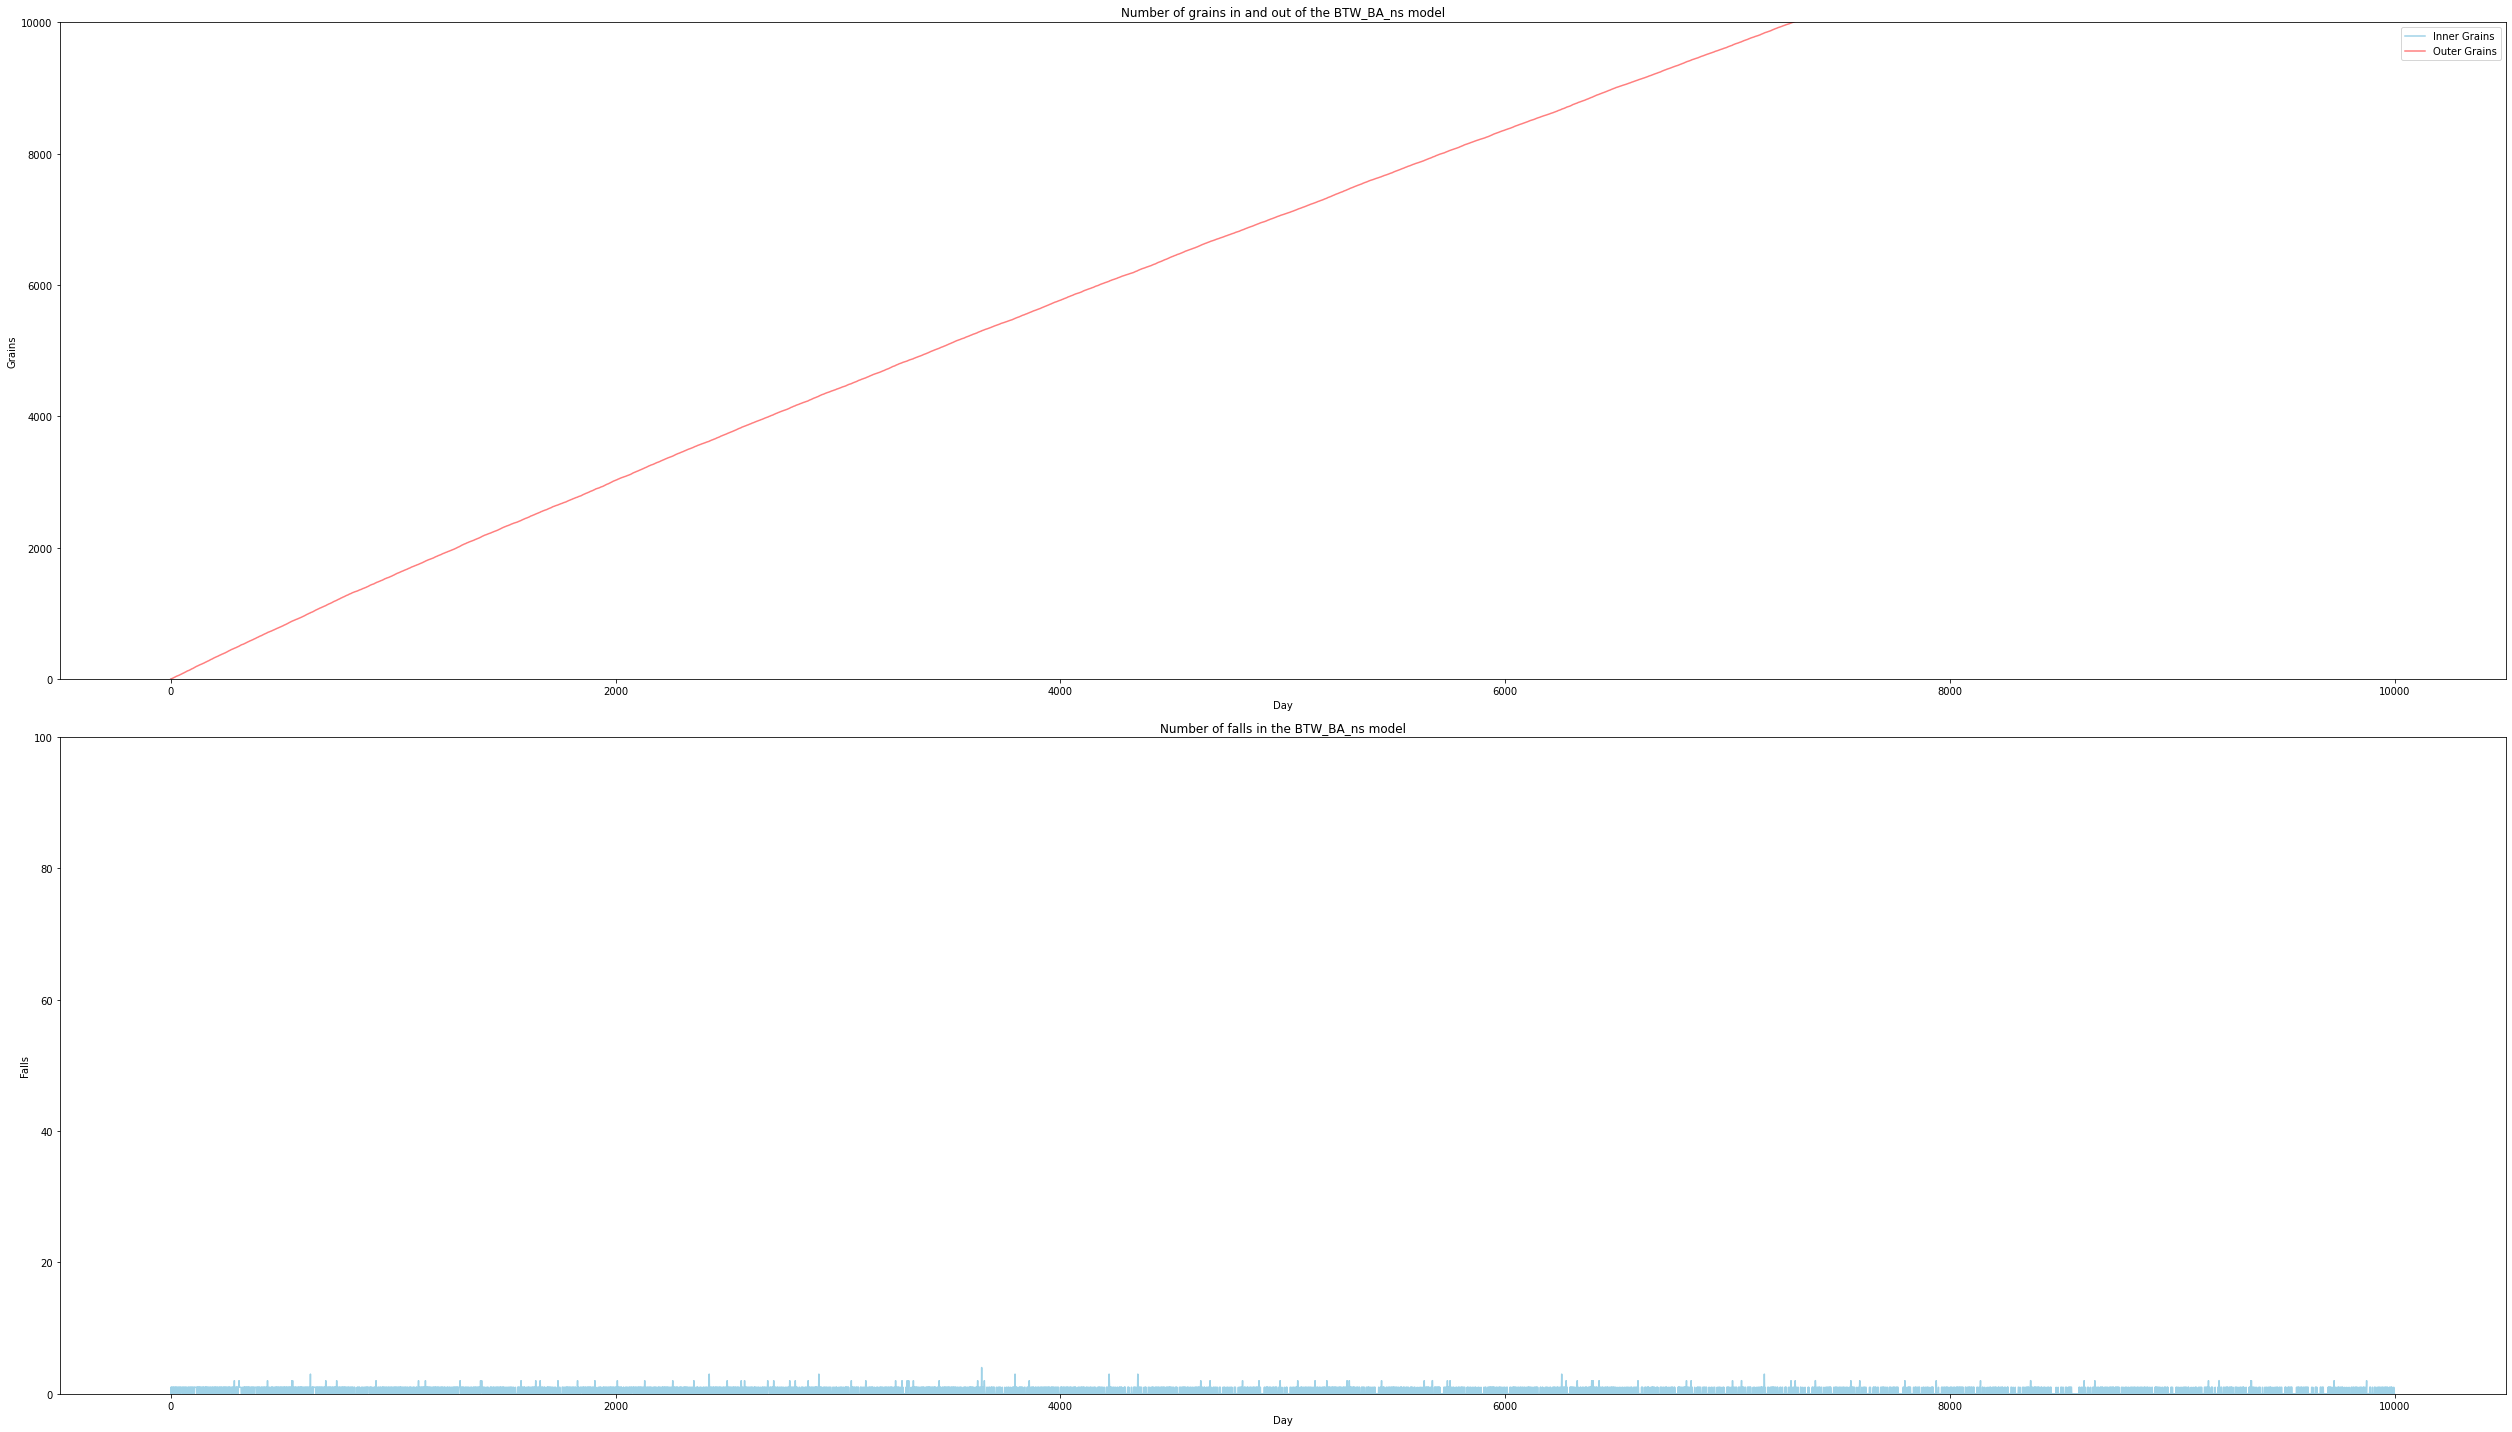

In [76]:
spread("BTW", G_BA, number_of_days, new_grains, "BA", neutral_state = True, new_grains_minus = new_grains_minus)

100%|██████████| 9999/9999 [01:46<00:00, 93.51it/s]


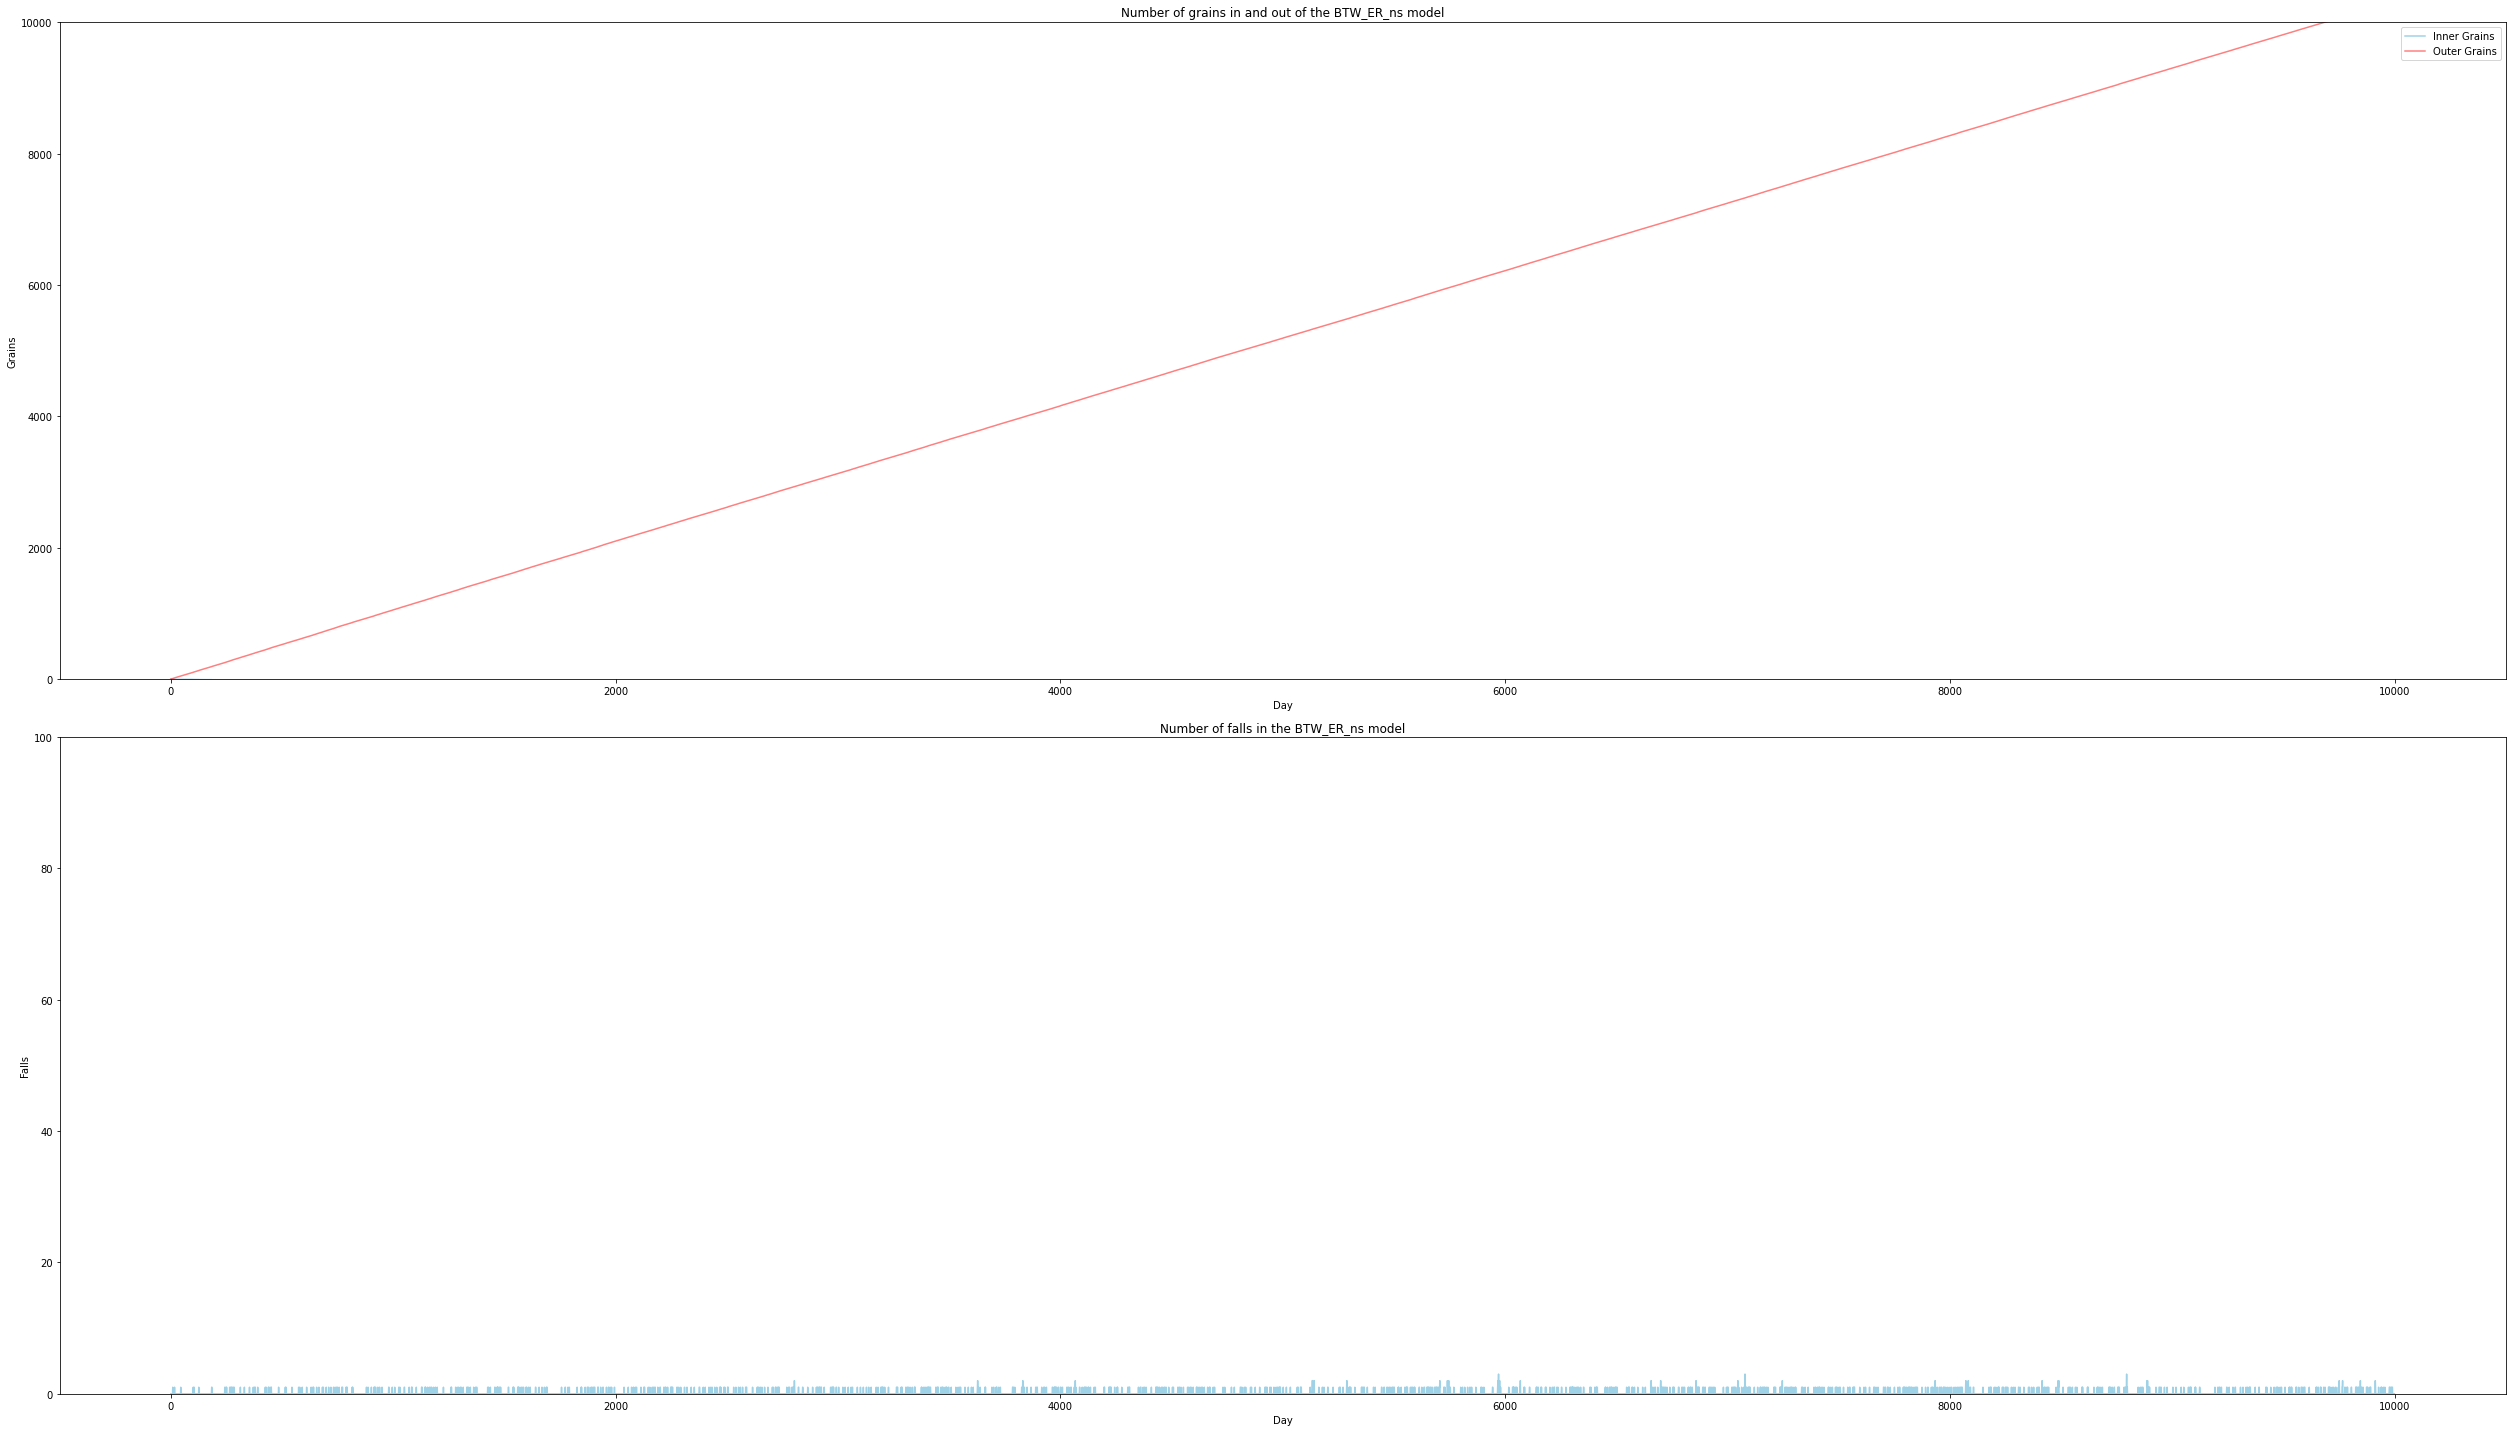

In [77]:
spread("BTW", G_ER, number_of_days, new_grains, "ER", neutral_state = True, new_grains_minus = new_grains_minus)

100%|██████████| 9999/9999 [01:38<00:00, 101.06it/s]


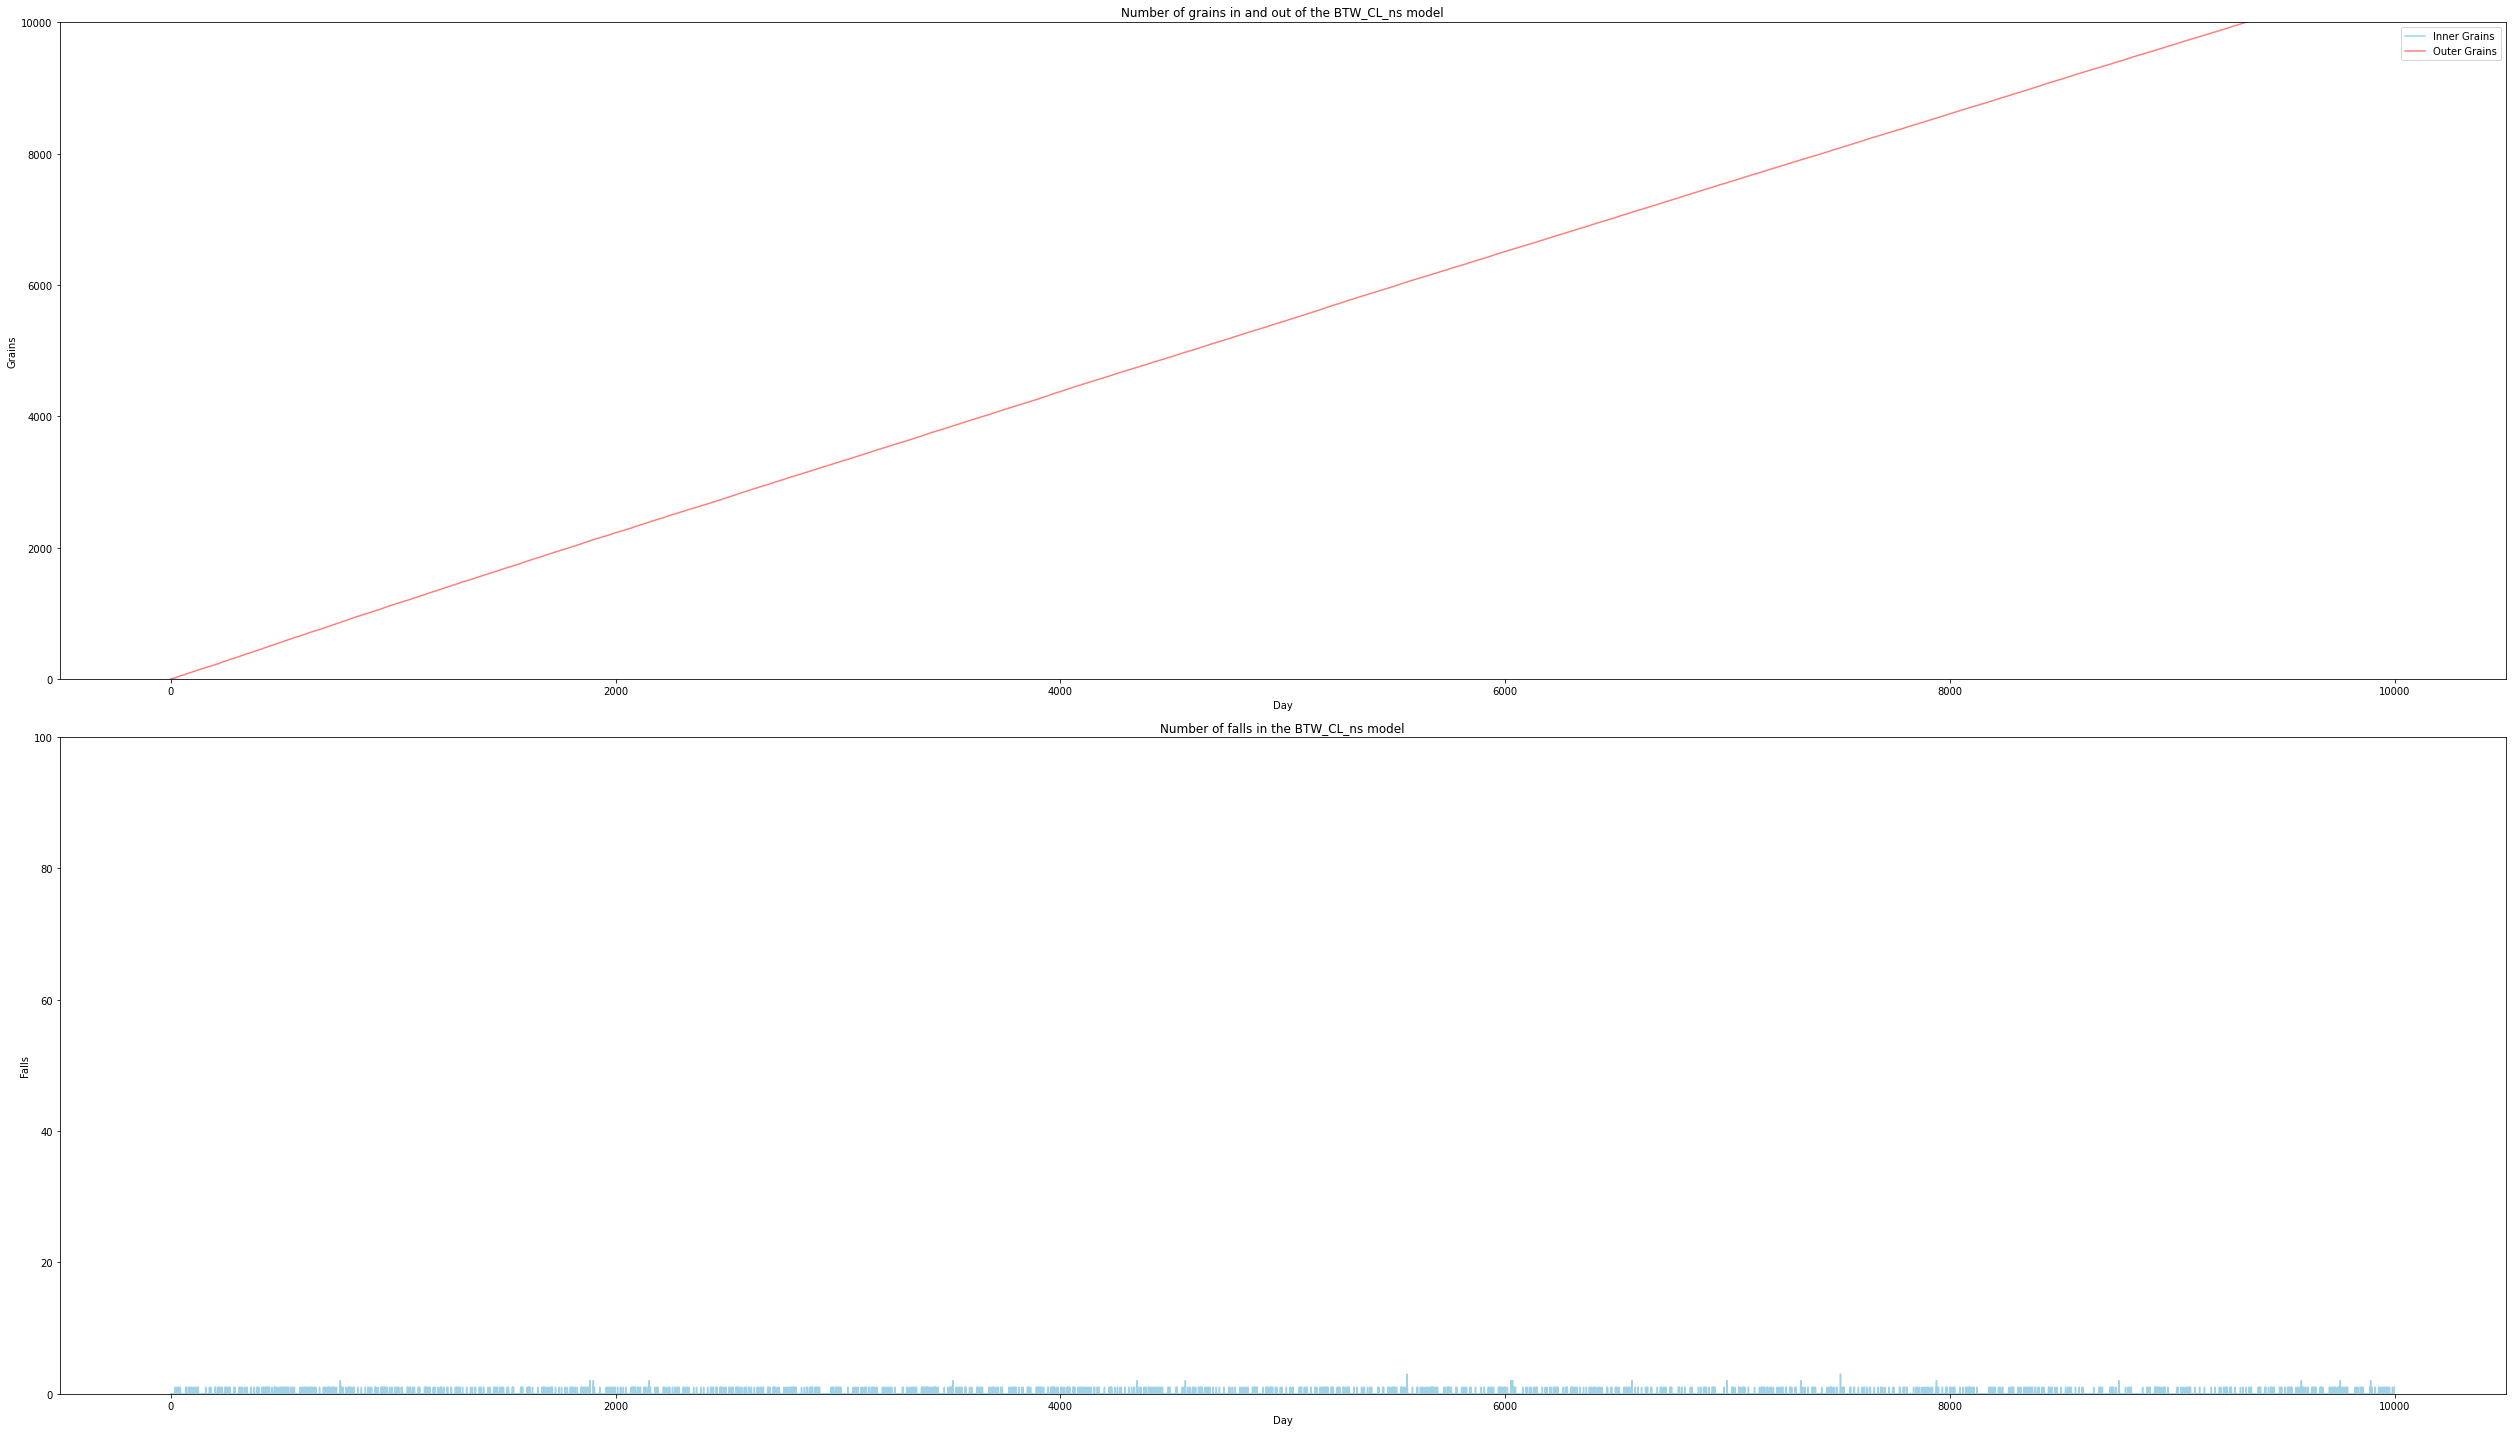

In [78]:
spread("BTW", G_CL, number_of_days, new_grains, "CL", neutral_state = True, new_grains_minus = new_grains_minus)

#### Facilitated Model

##### Standart Dissipation

100%|██████████| 9999/9999 [02:16<00:00, 73.05it/s]


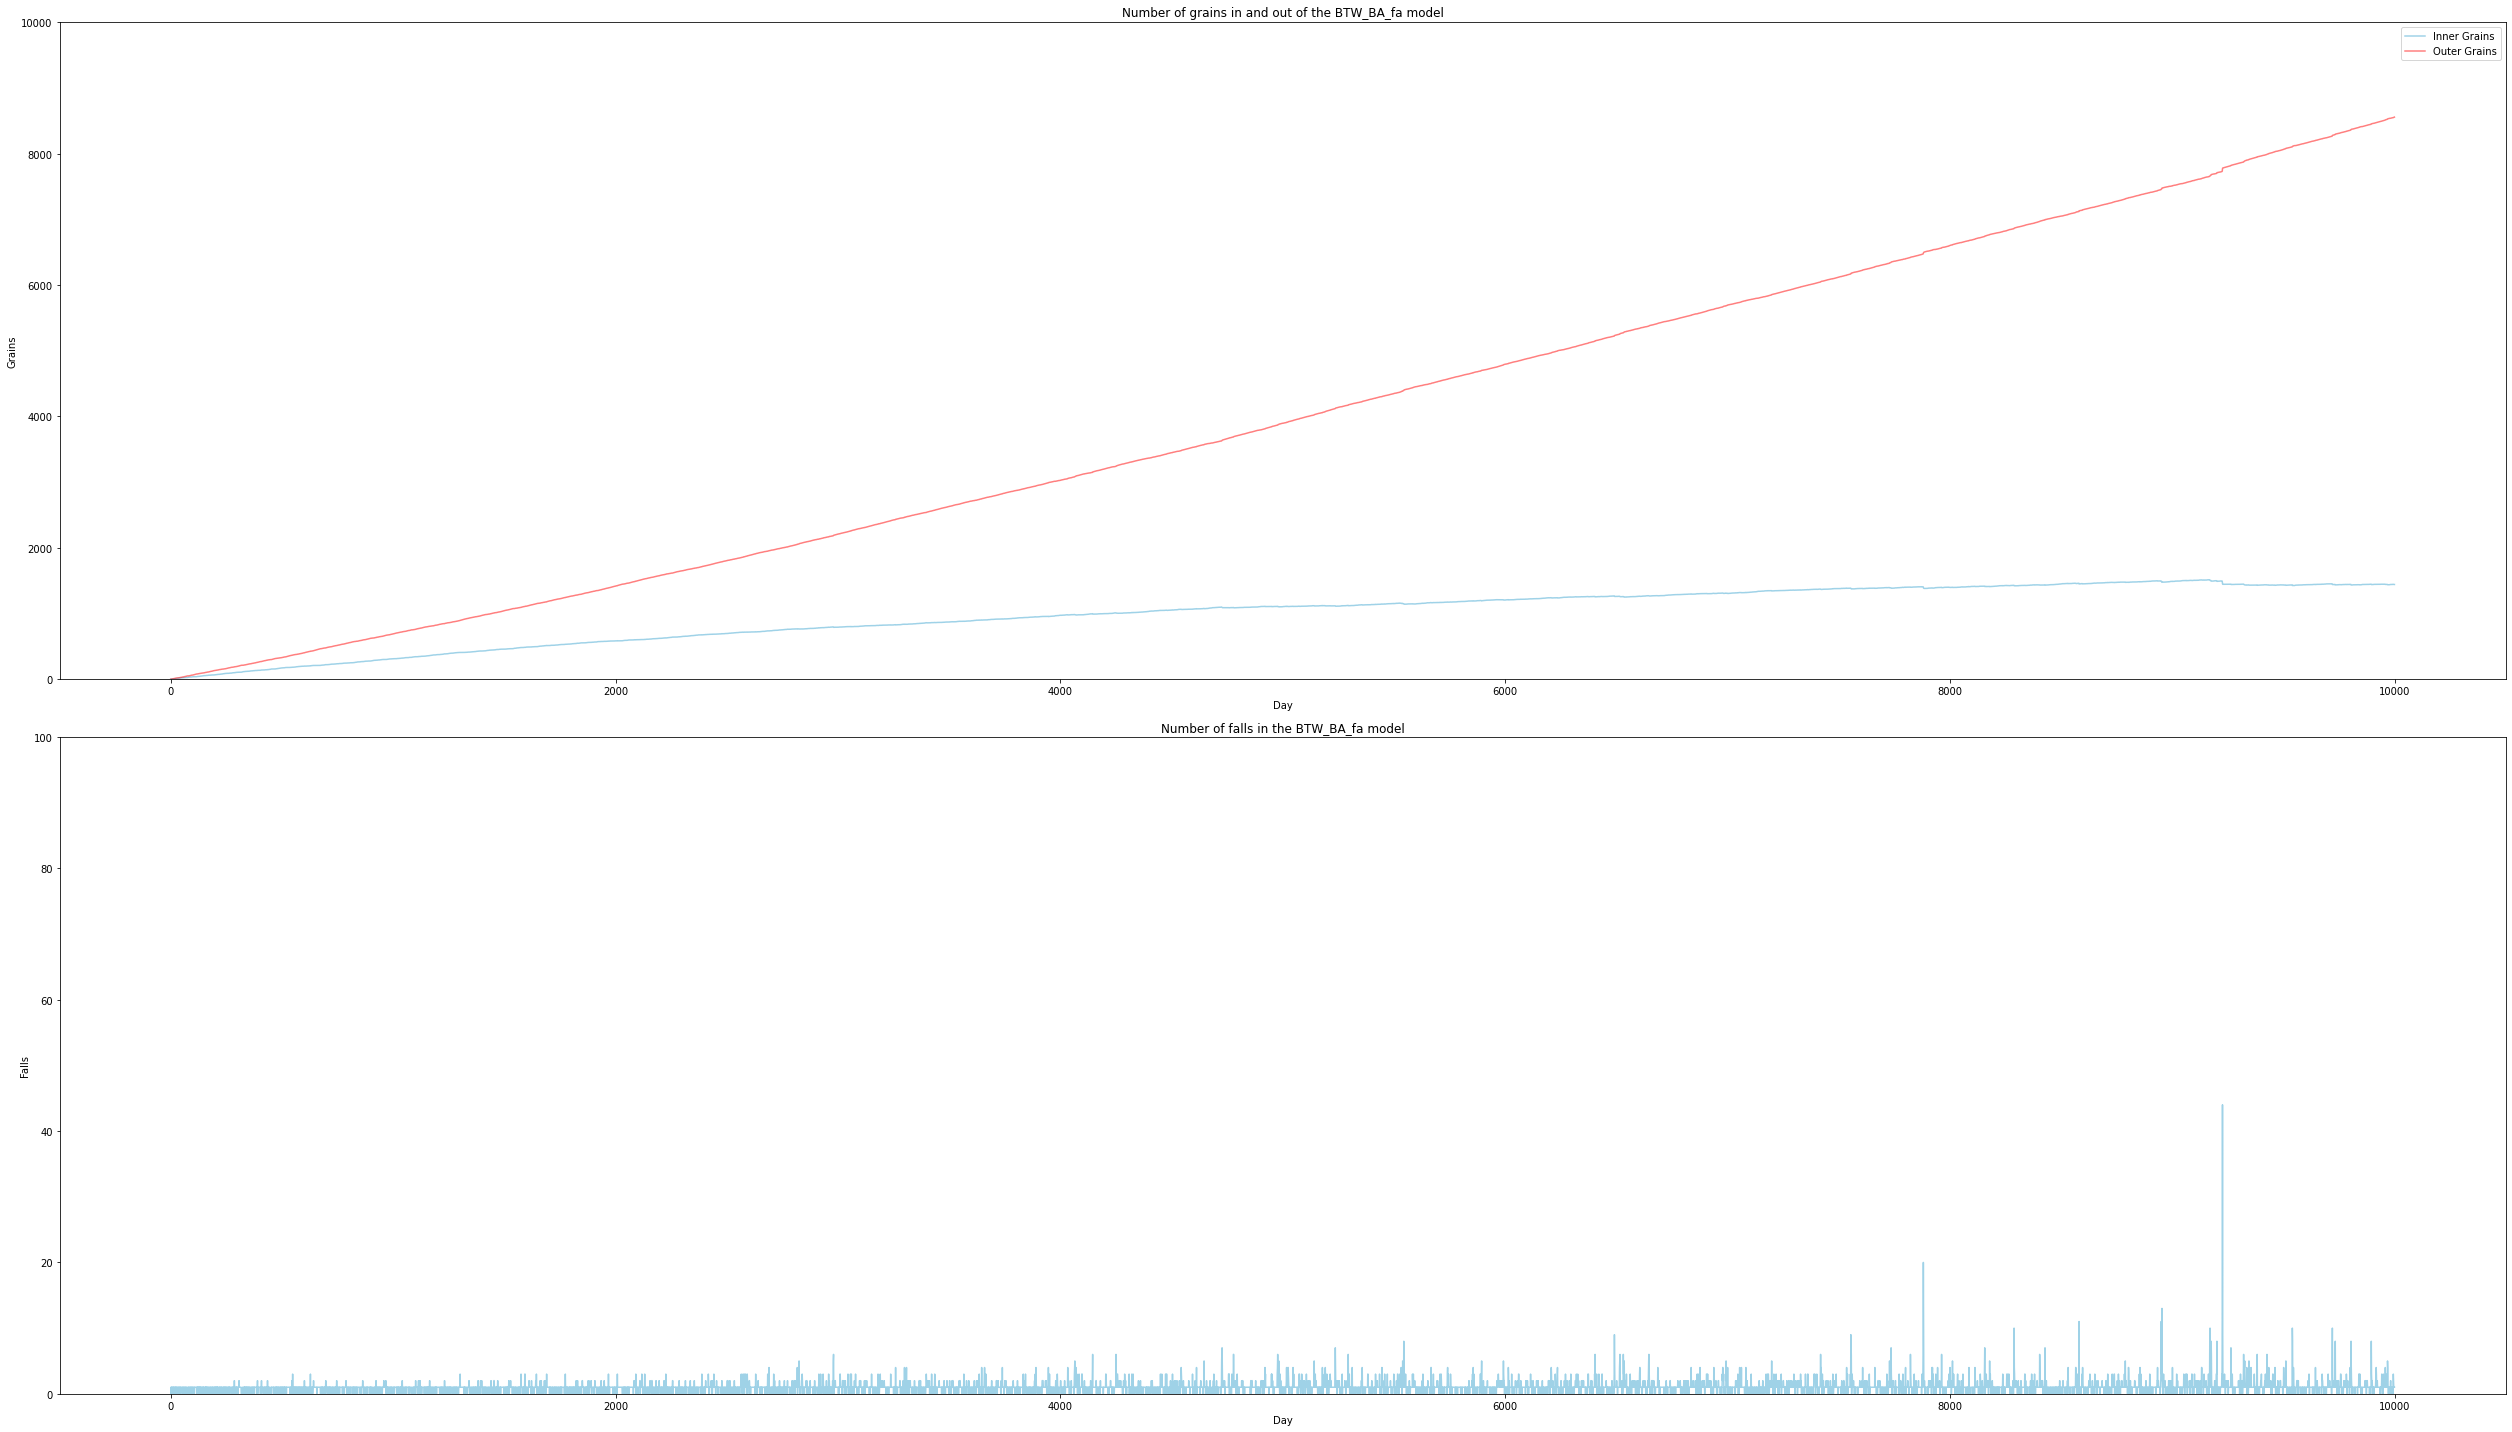

In [26]:
spread("BTW", G_BA, number_of_days, new_grains, "BA", facilitated = True)

100%|██████████| 9999/9999 [02:16<00:00, 73.09it/s]


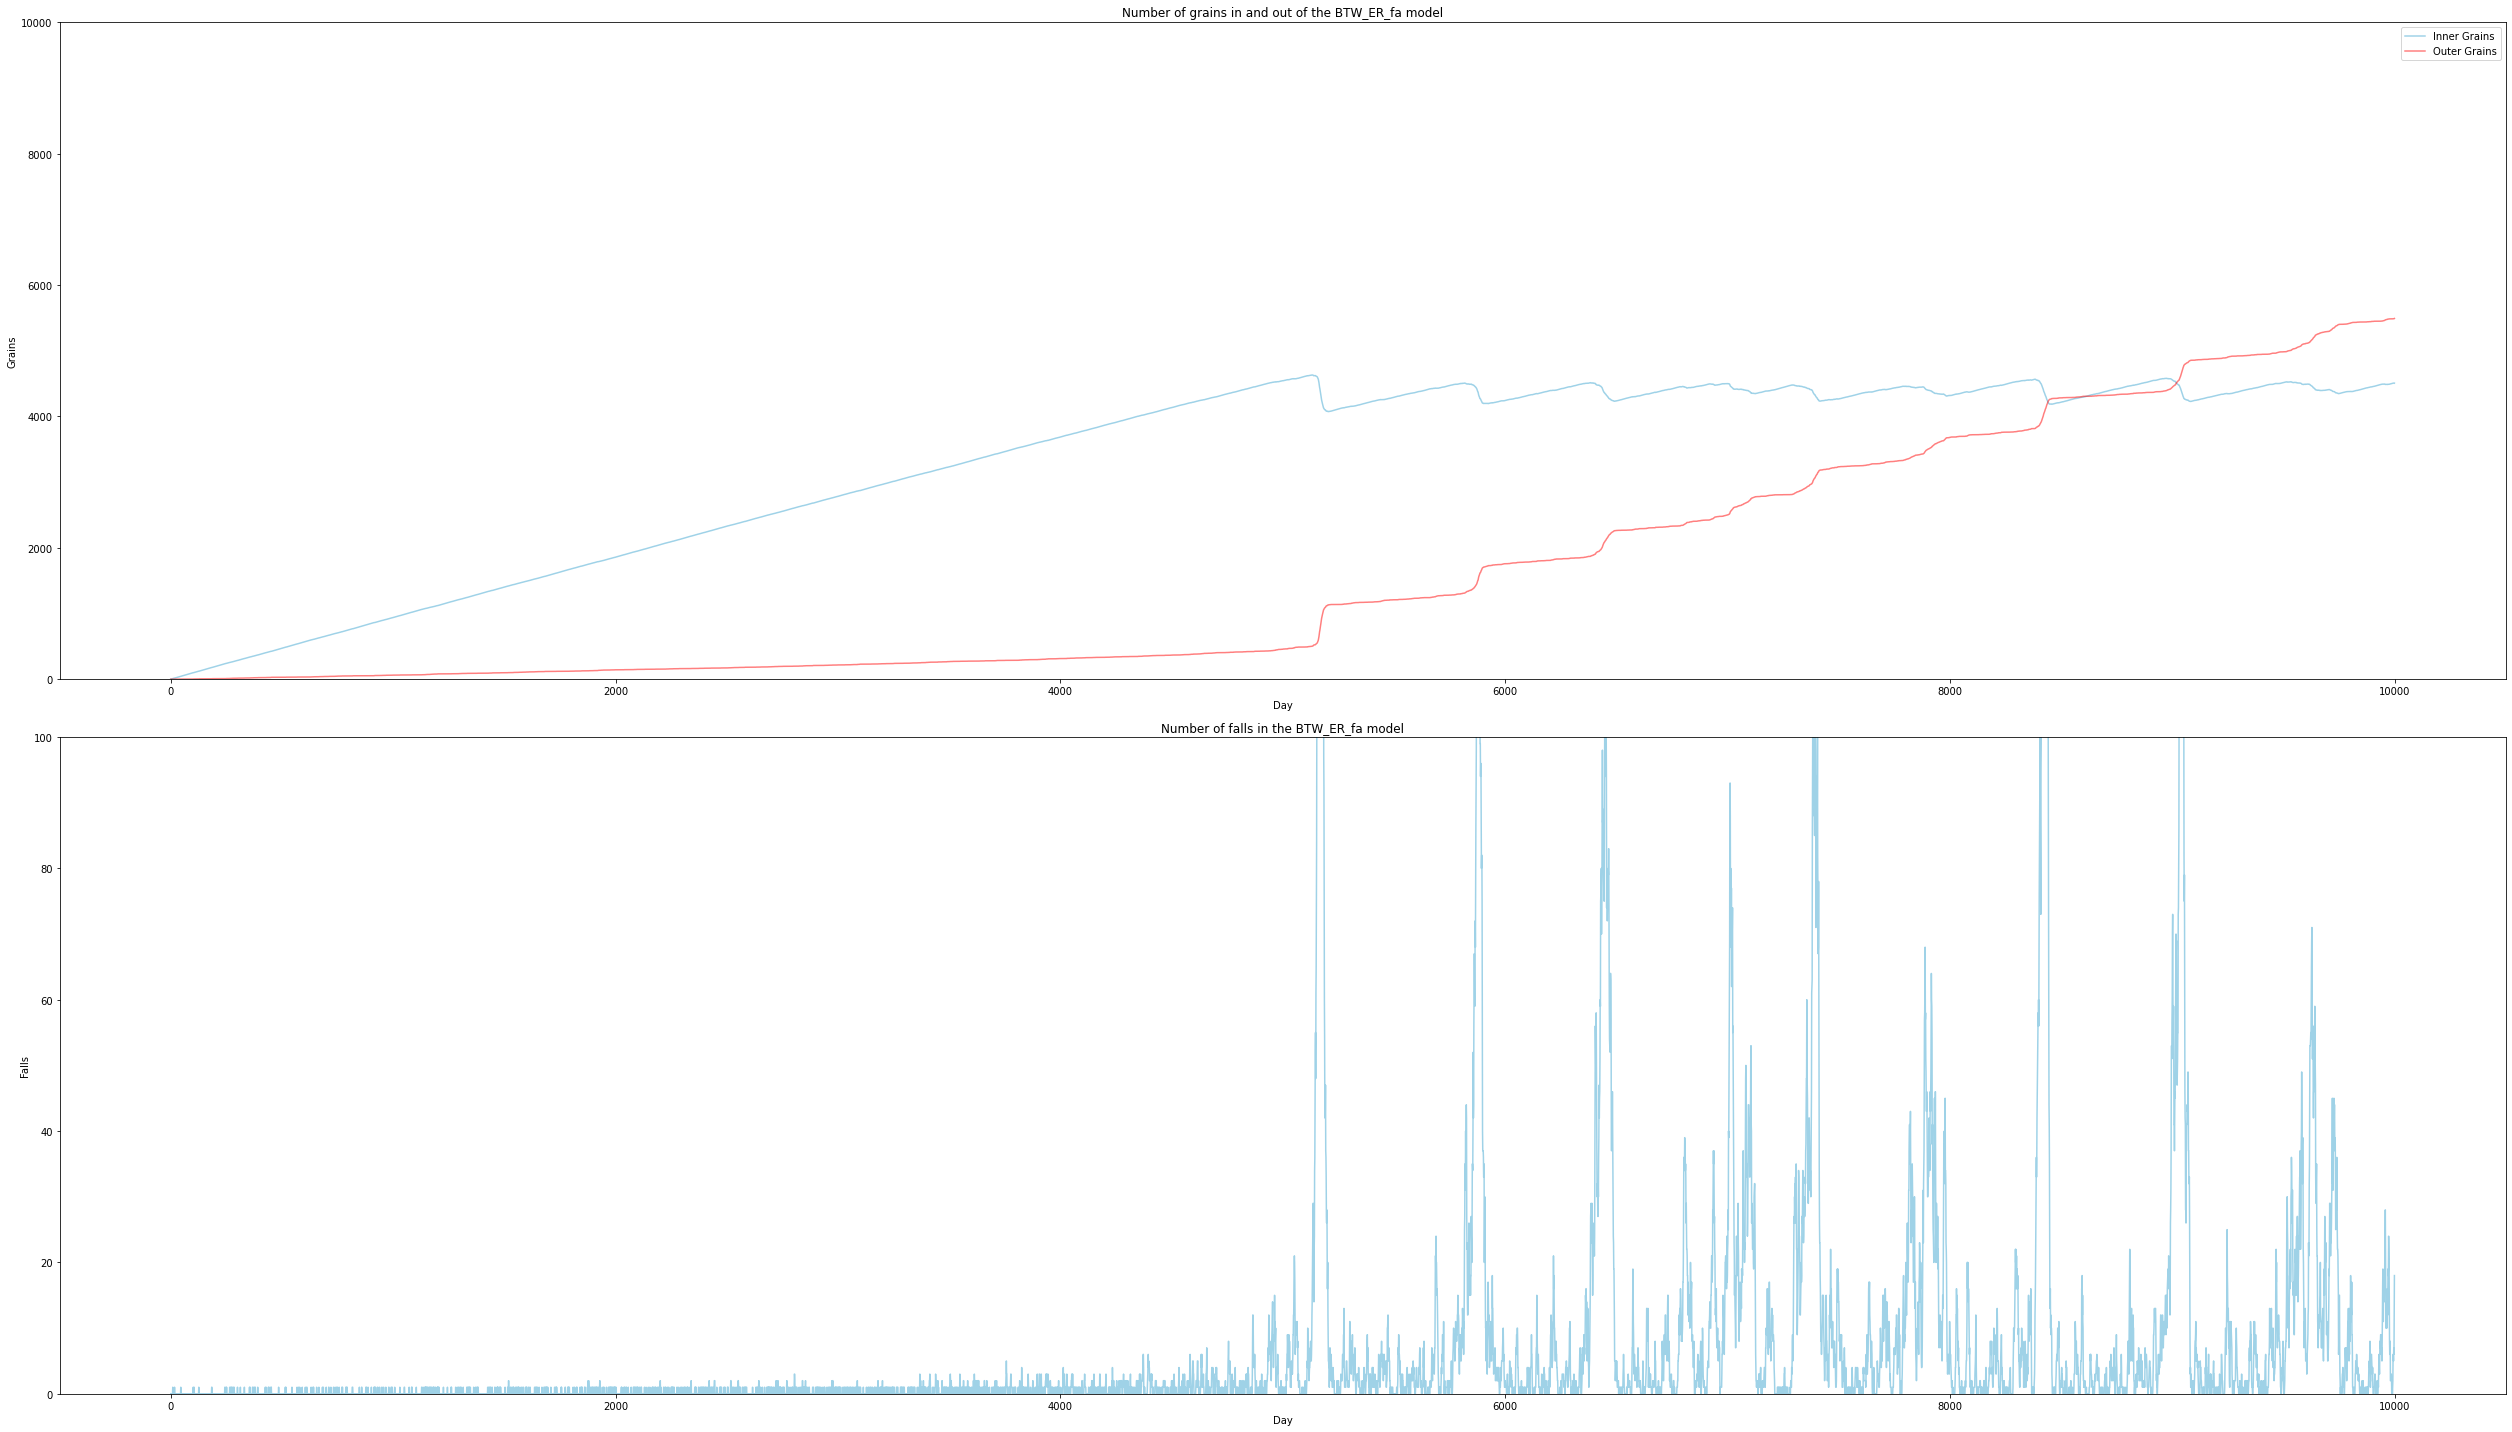

In [27]:
spread("BTW", G_ER, number_of_days, new_grains, "ER", facilitated = True)

100%|██████████| 9999/9999 [02:06<00:00, 78.85it/s]


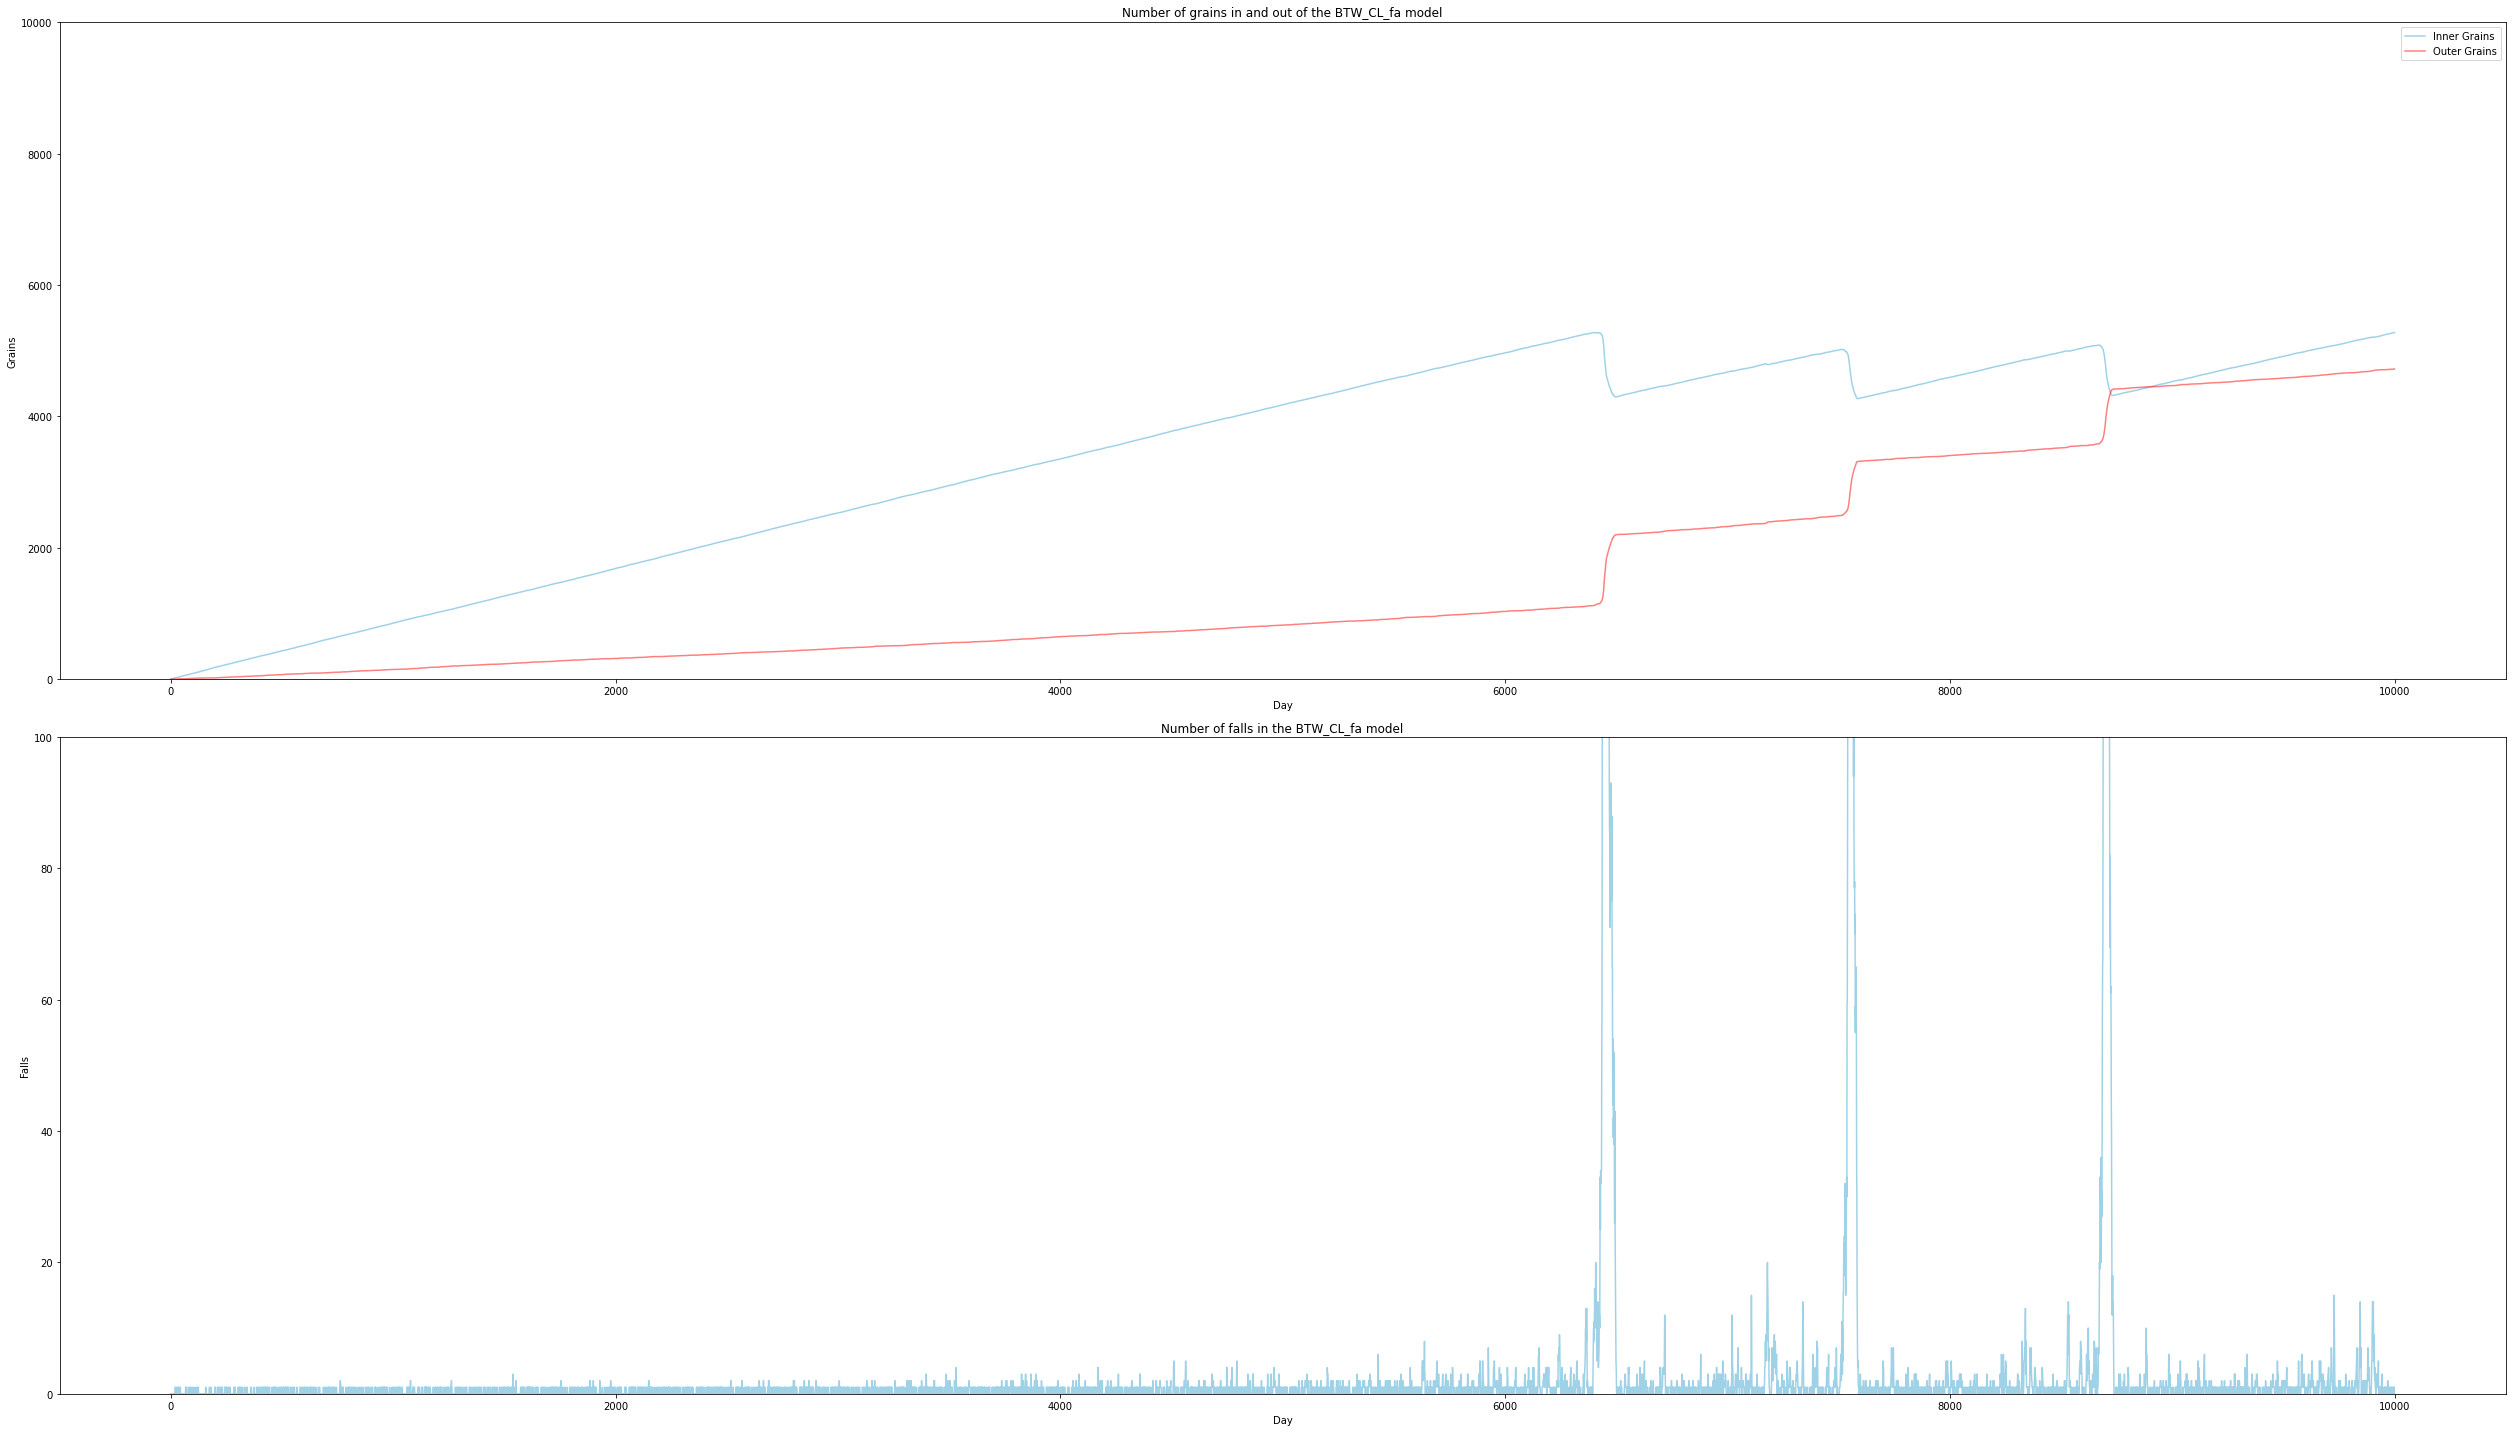

In [28]:
spread("BTW", G_CL, number_of_days, new_grains, "CL", facilitated = True)

##### Additional Dissipation

100%|██████████| 9999/9999 [02:10<00:00, 76.54it/s]


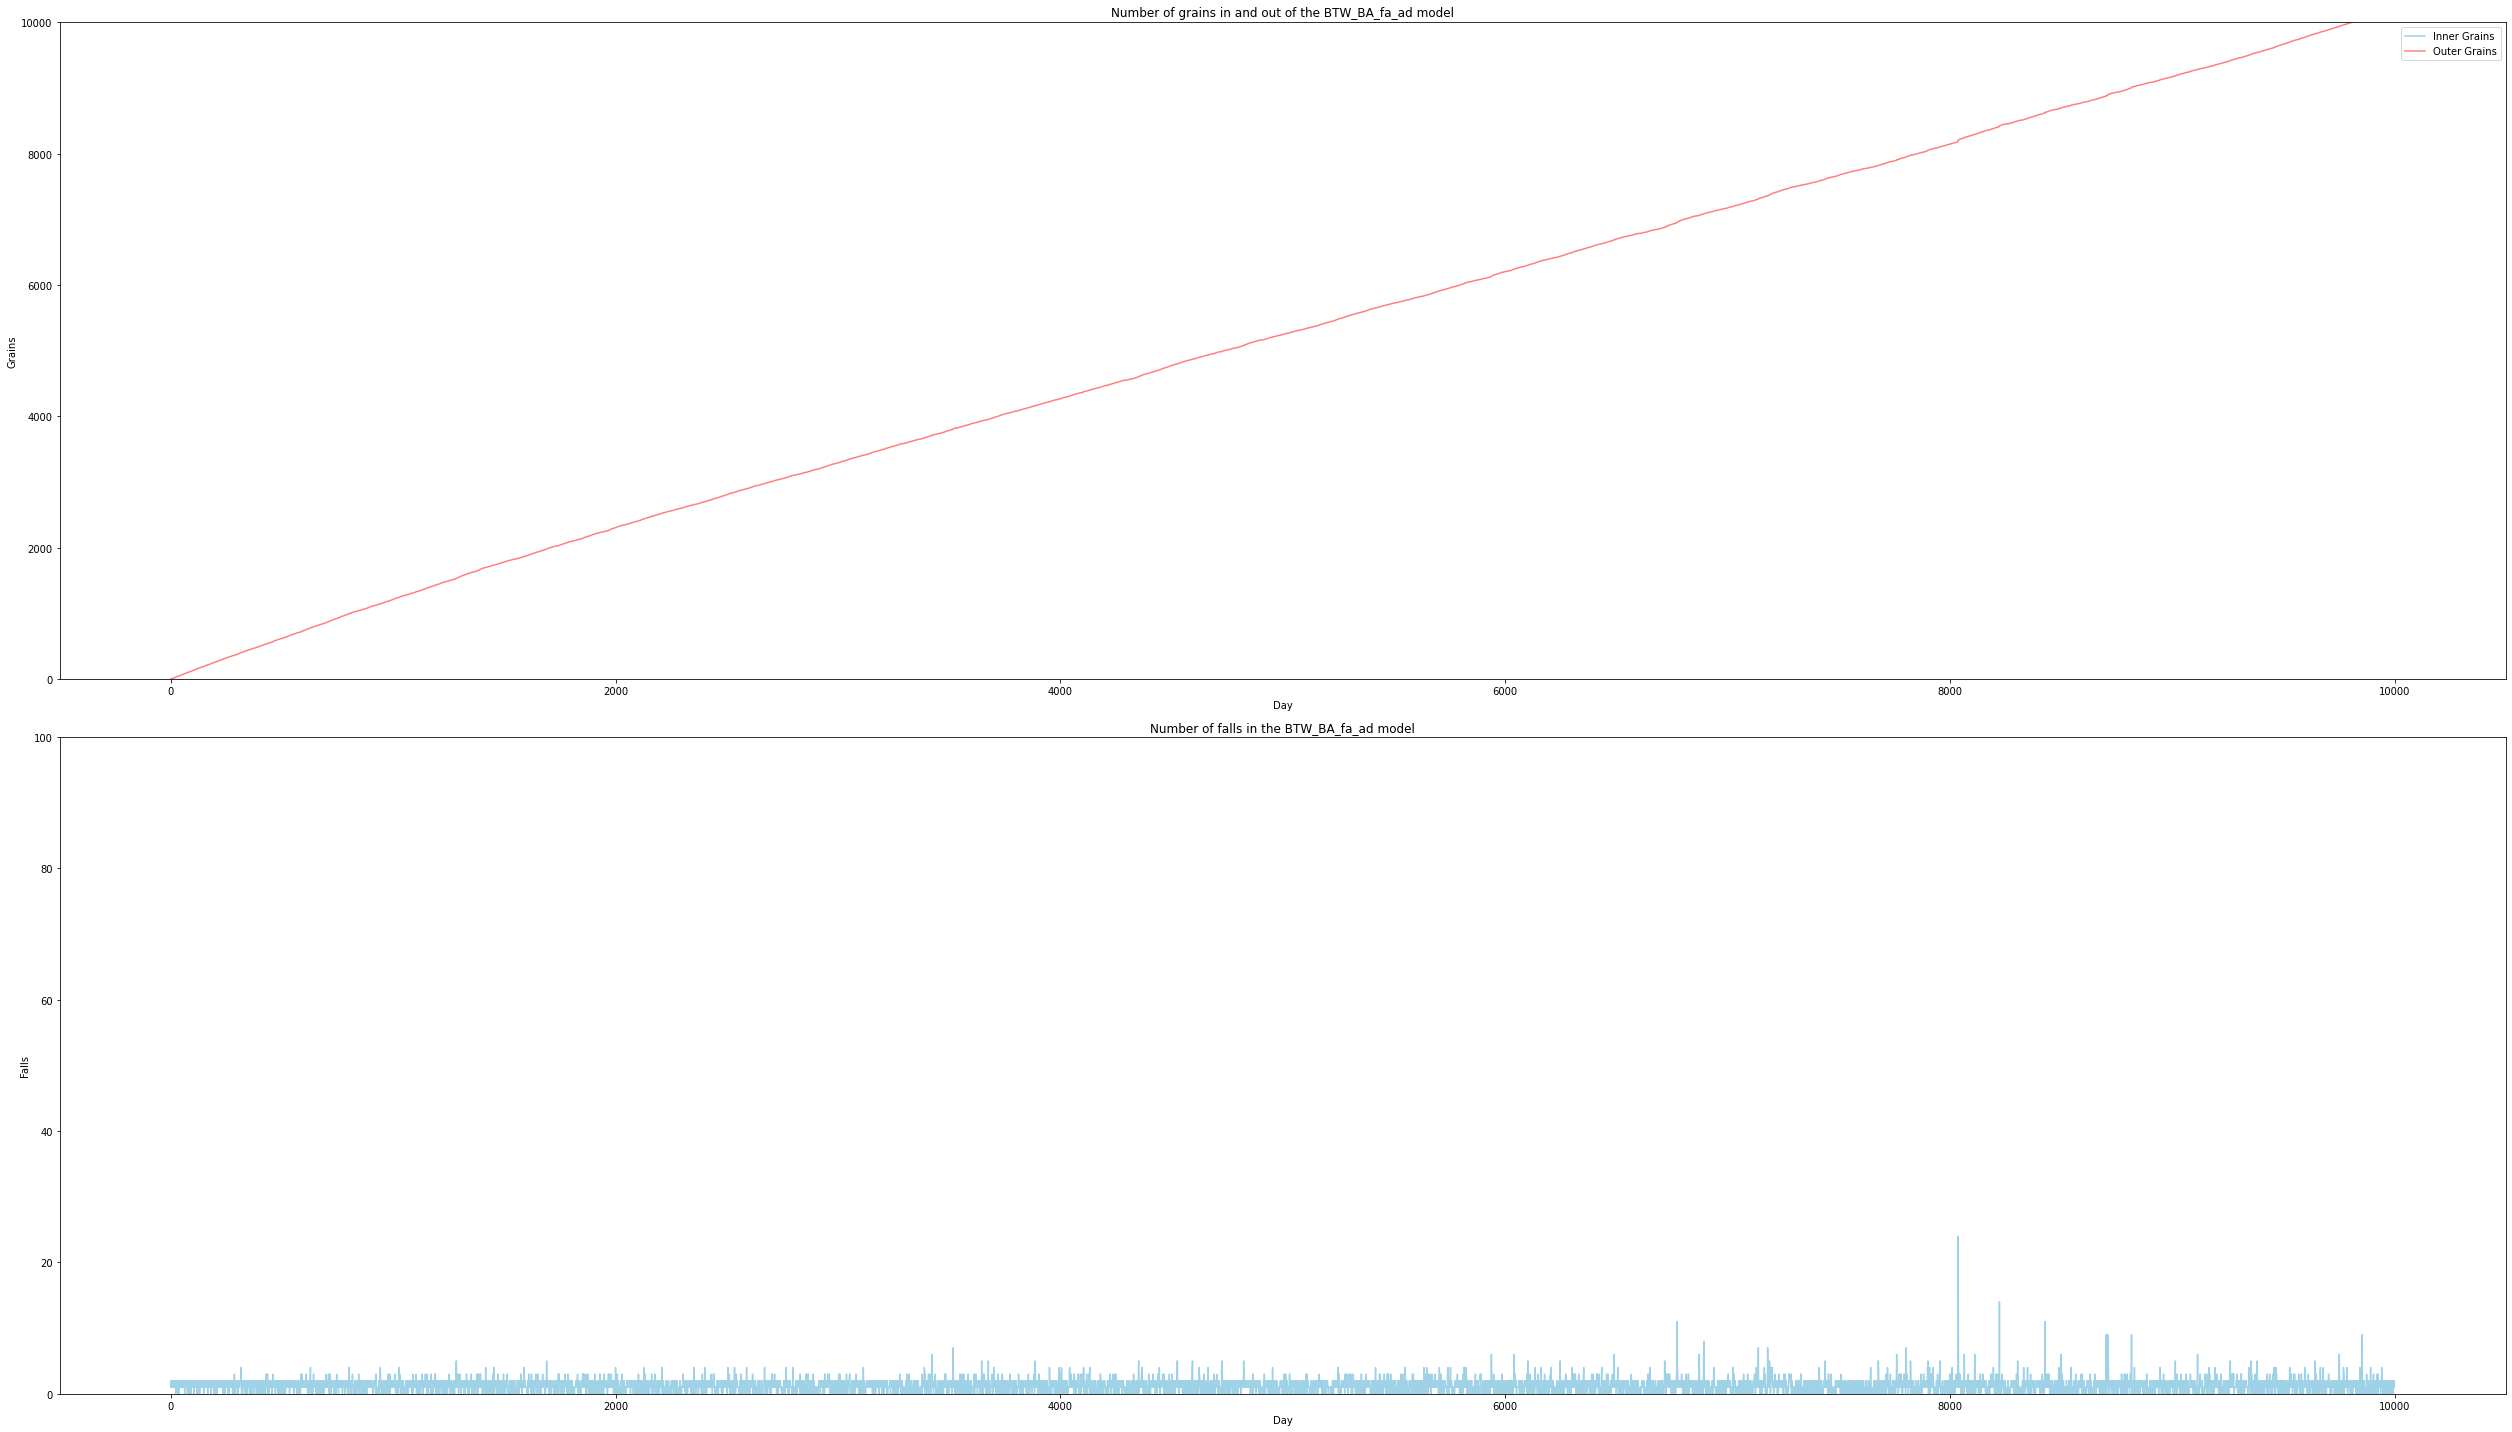

In [29]:
spread("BTW", G_BA, number_of_days, new_grains, "BA", facilitated = True, ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

100%|██████████| 9999/9999 [02:27<00:00, 68.01it/s]


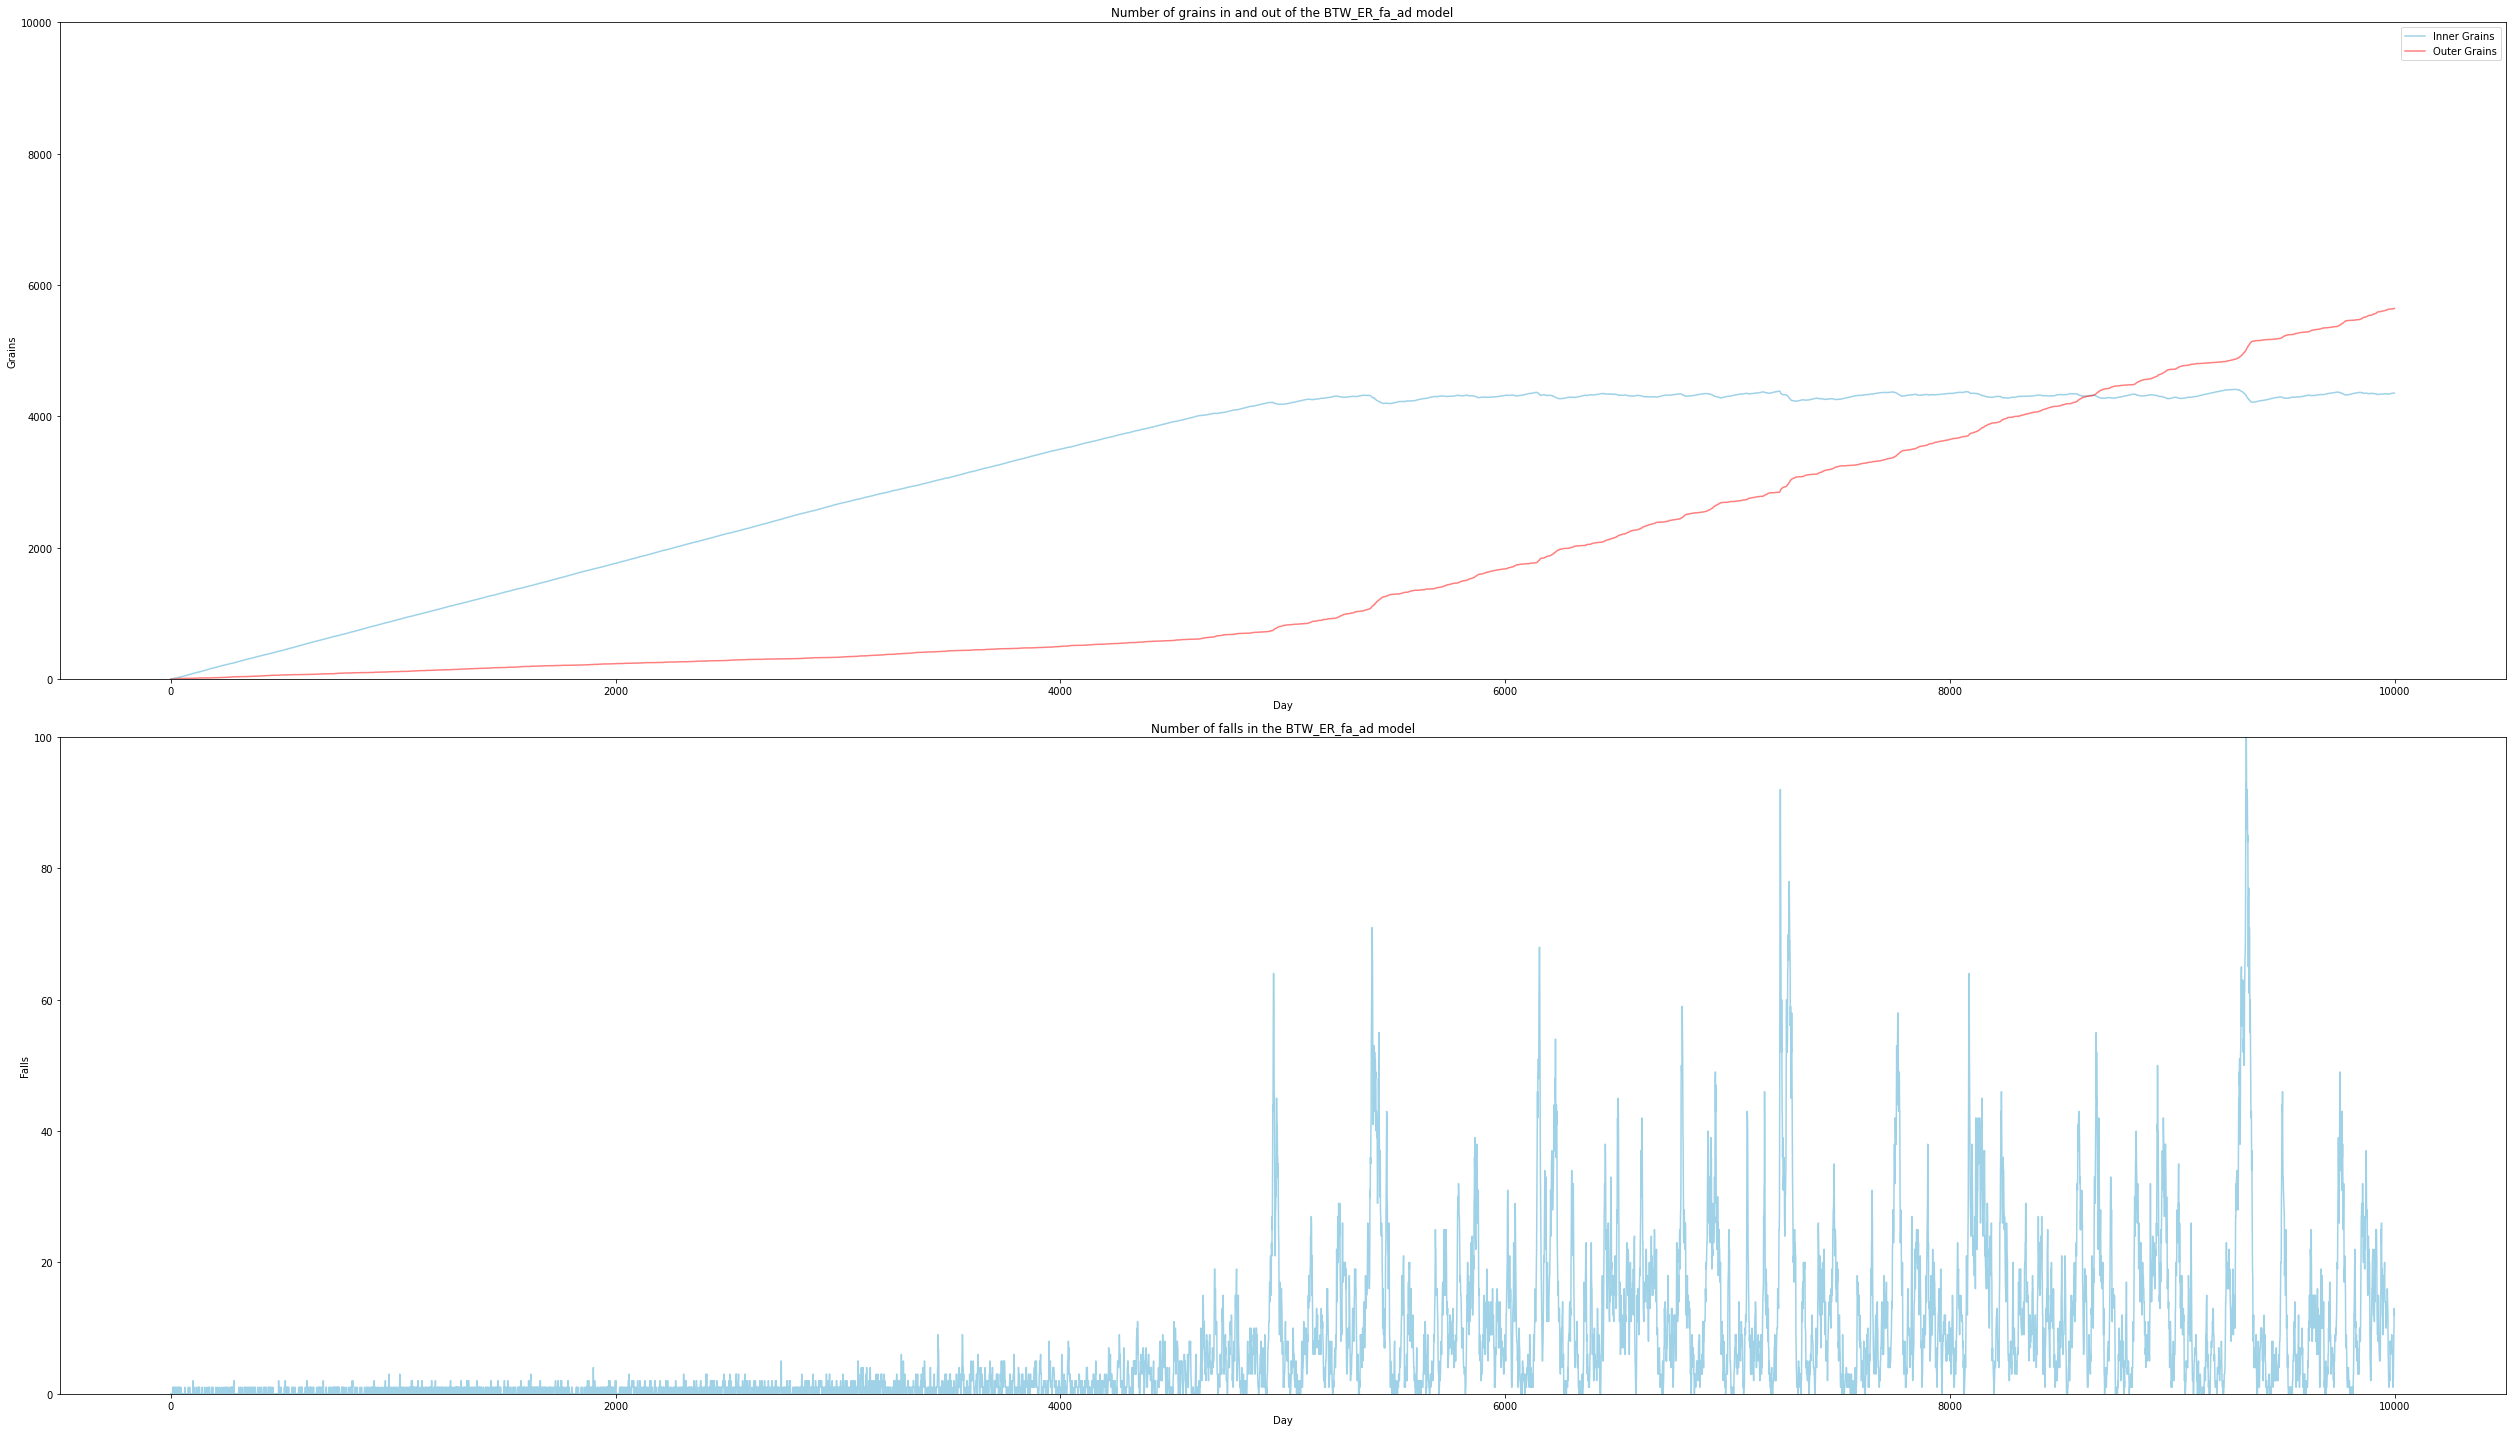

In [30]:
spread("BTW", G_ER, number_of_days, new_grains, "ER", facilitated = True, ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

100%|██████████| 9999/9999 [02:13<00:00, 75.07it/s]


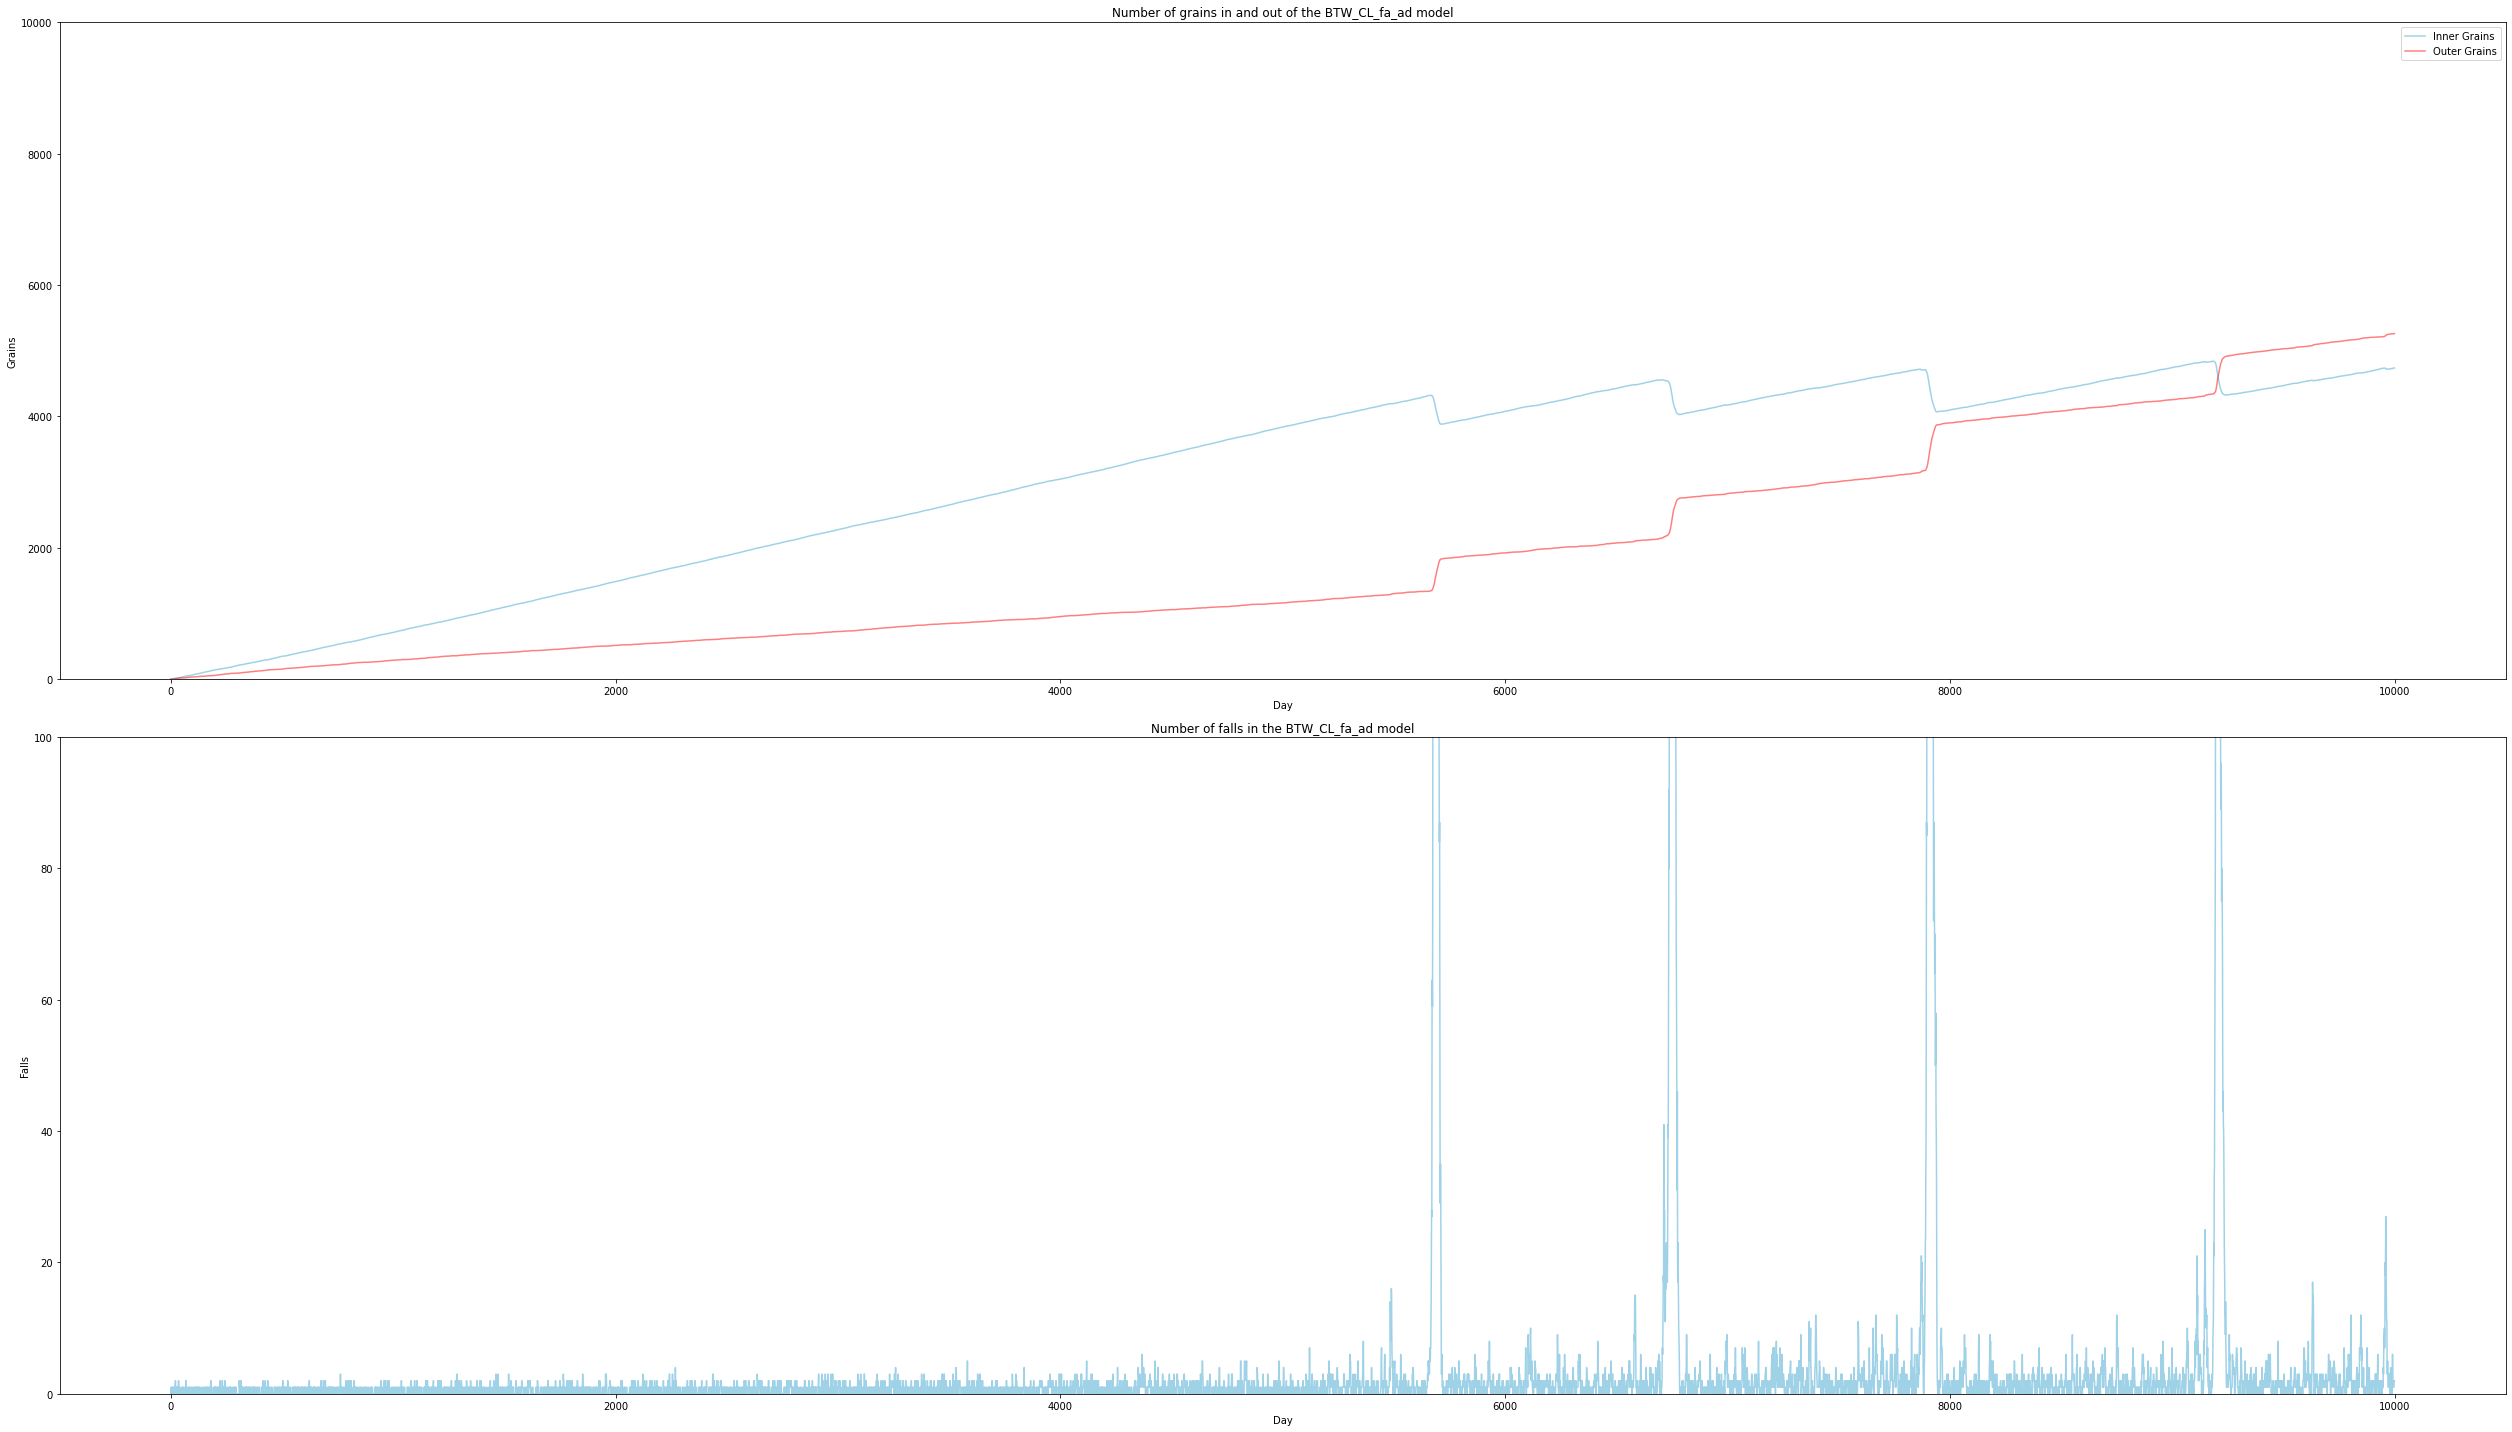

In [31]:
spread("BTW", G_CL, number_of_days, new_grains, "CL", facilitated = True, ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

##### Neutral State

100%|██████████| 9999/9999 [01:46<00:00, 93.78it/s]


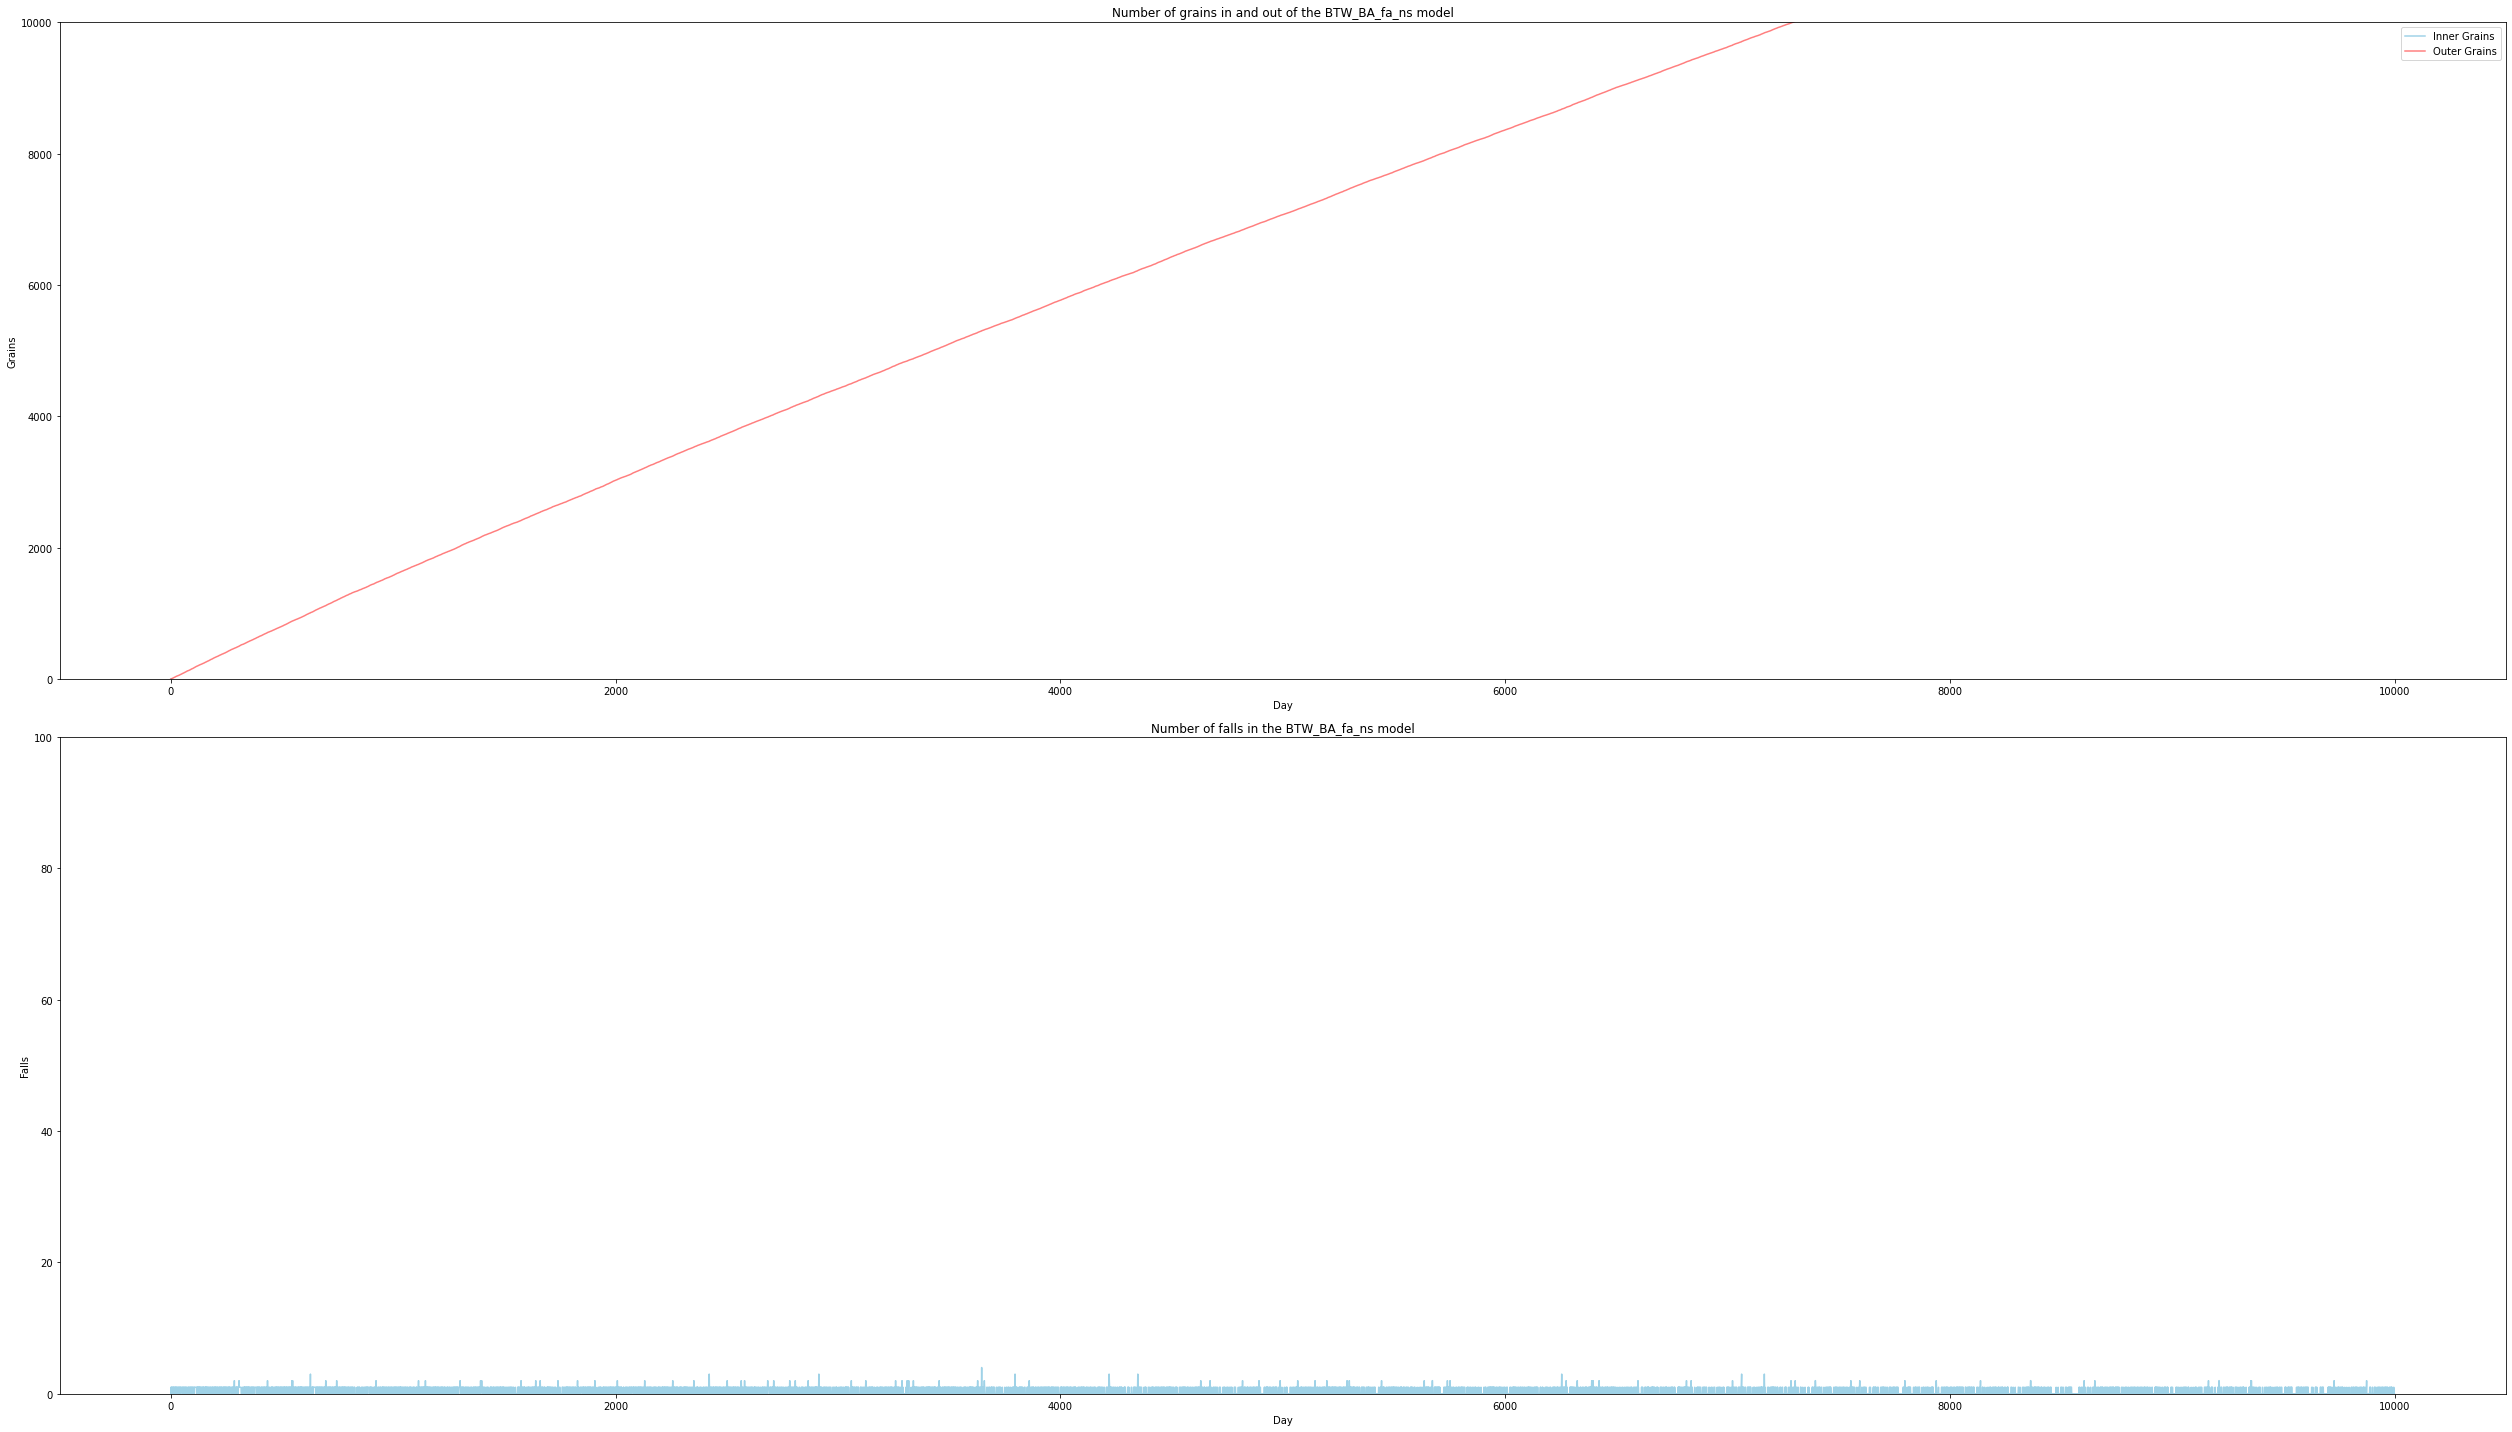

In [79]:
spread("BTW", G_BA, number_of_days, new_grains, "BA", facilitated = True, neutral_state = True, new_grains_minus = new_grains_minus)

100%|██████████| 9999/9999 [01:30<00:00, 110.64it/s]


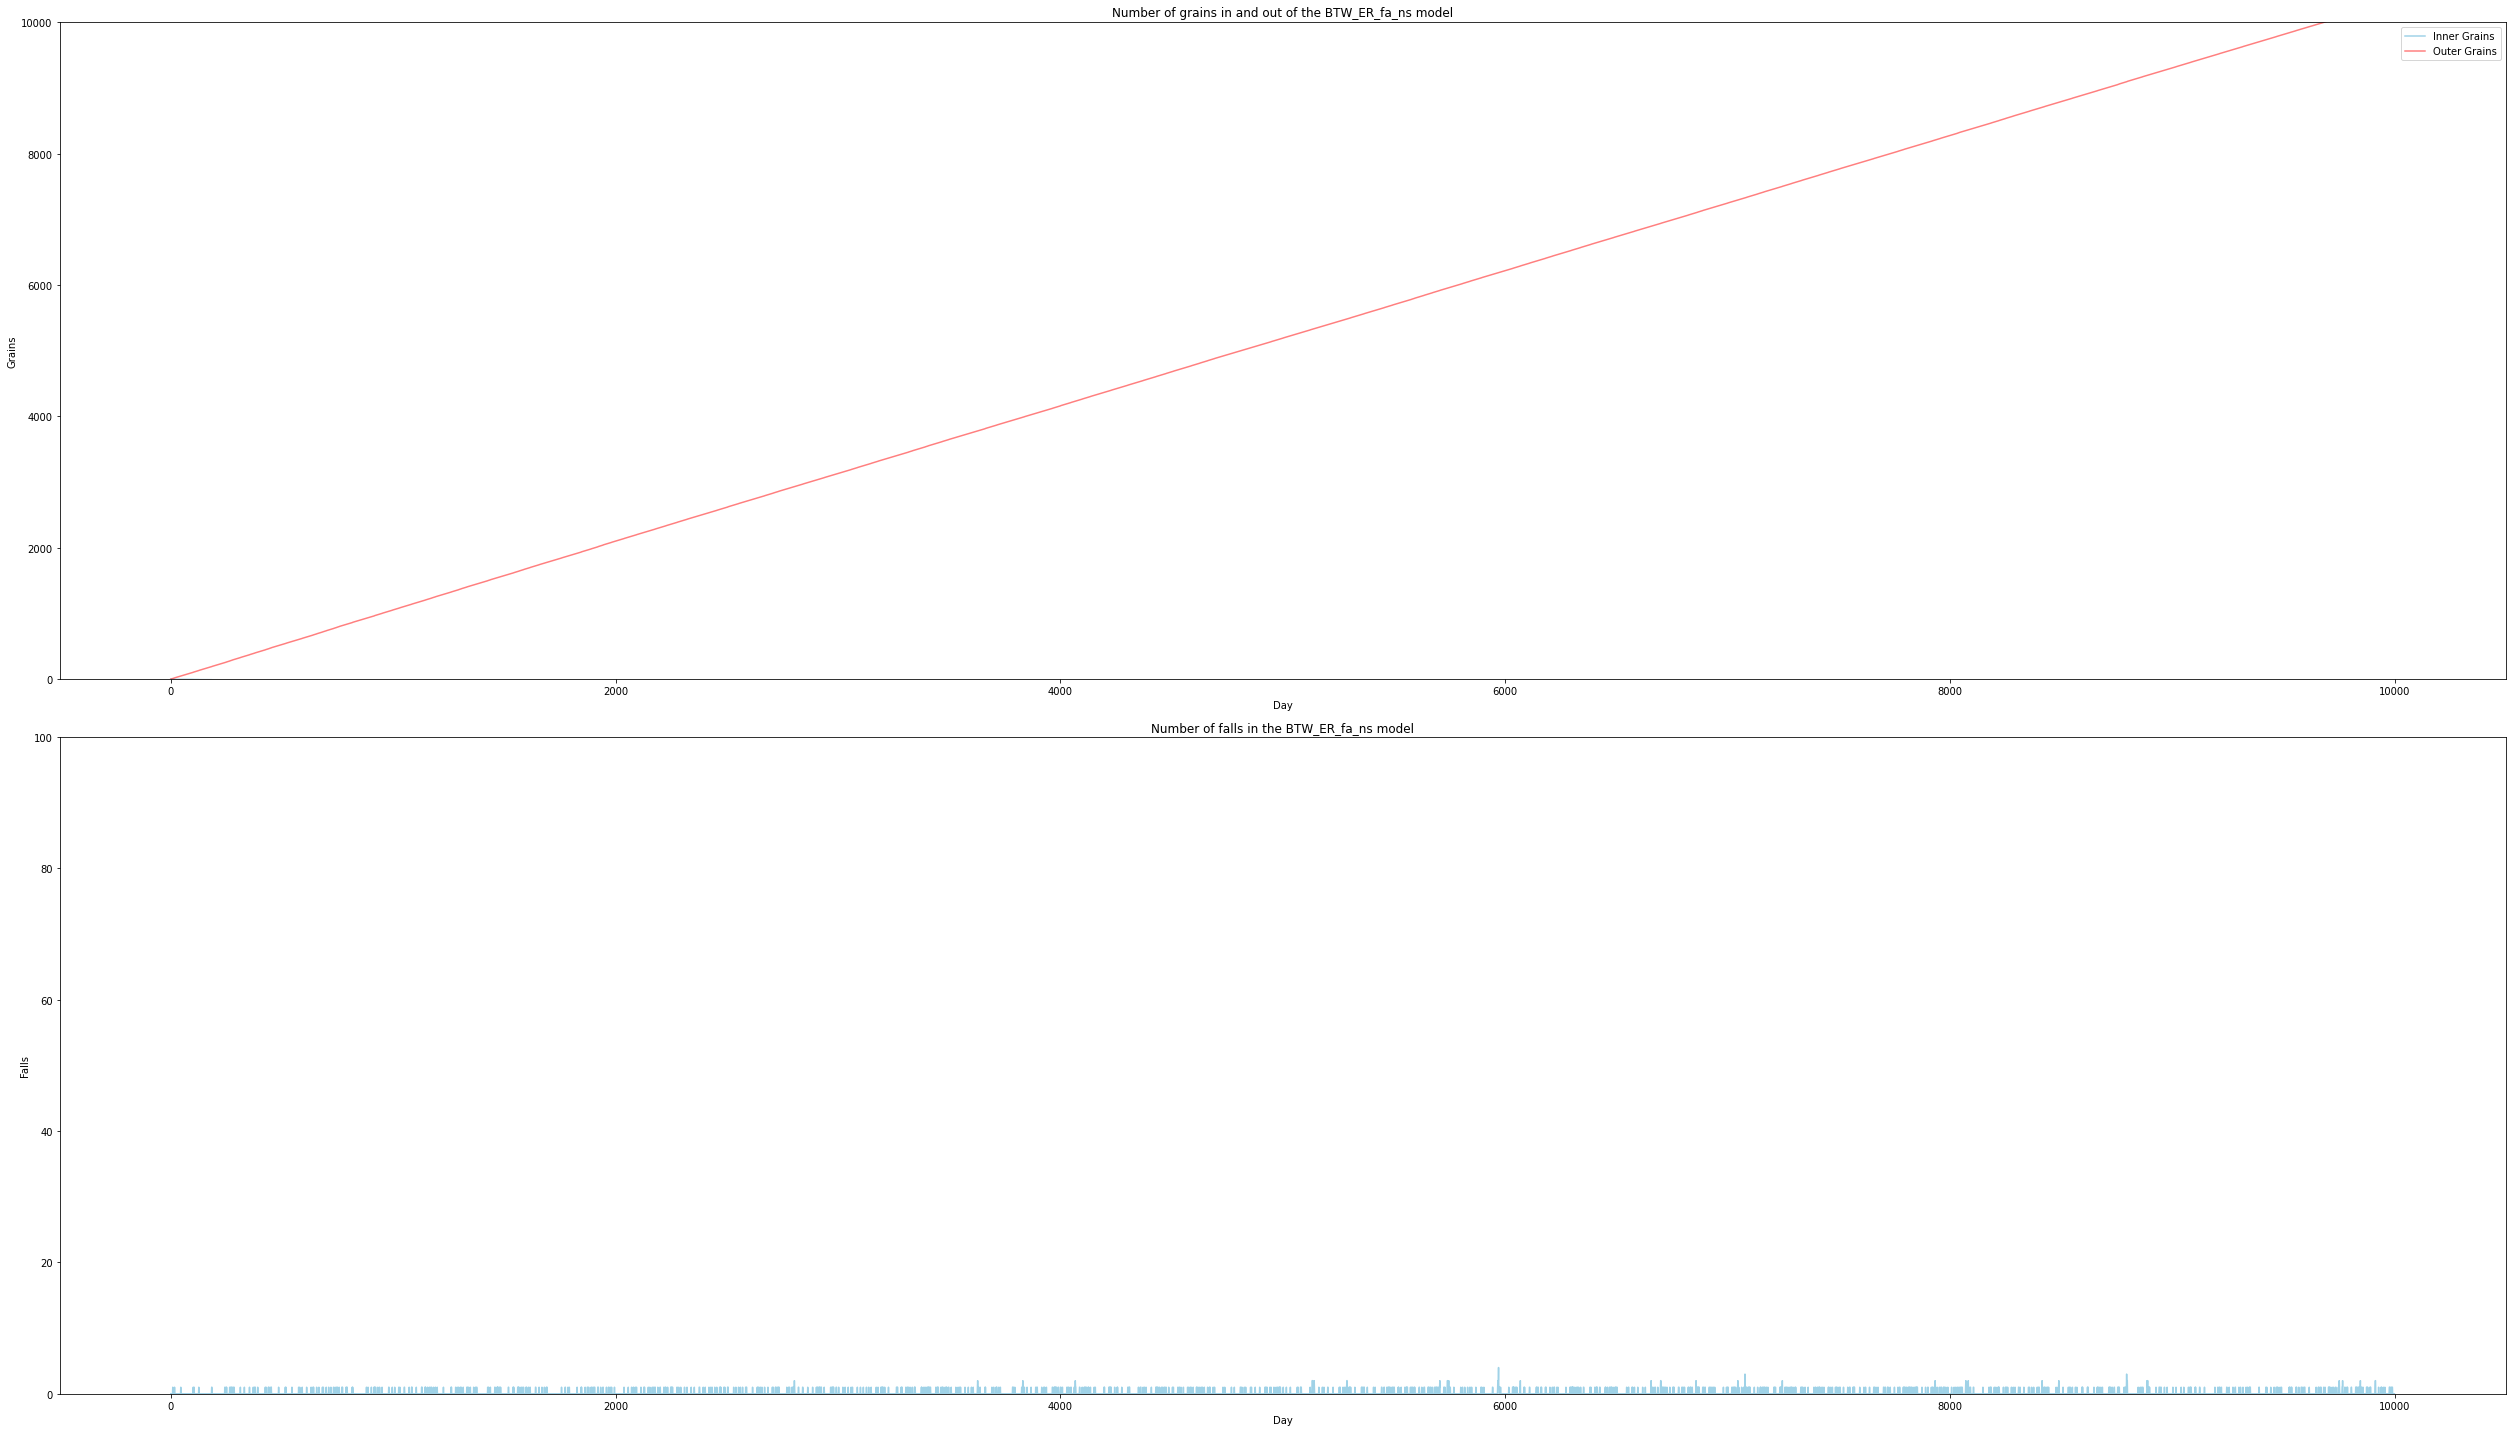

In [80]:
spread("BTW", G_ER, number_of_days, new_grains, "ER", facilitated = True, neutral_state = True, new_grains_minus = new_grains_minus)

100%|██████████| 9999/9999 [01:35<00:00, 104.72it/s]


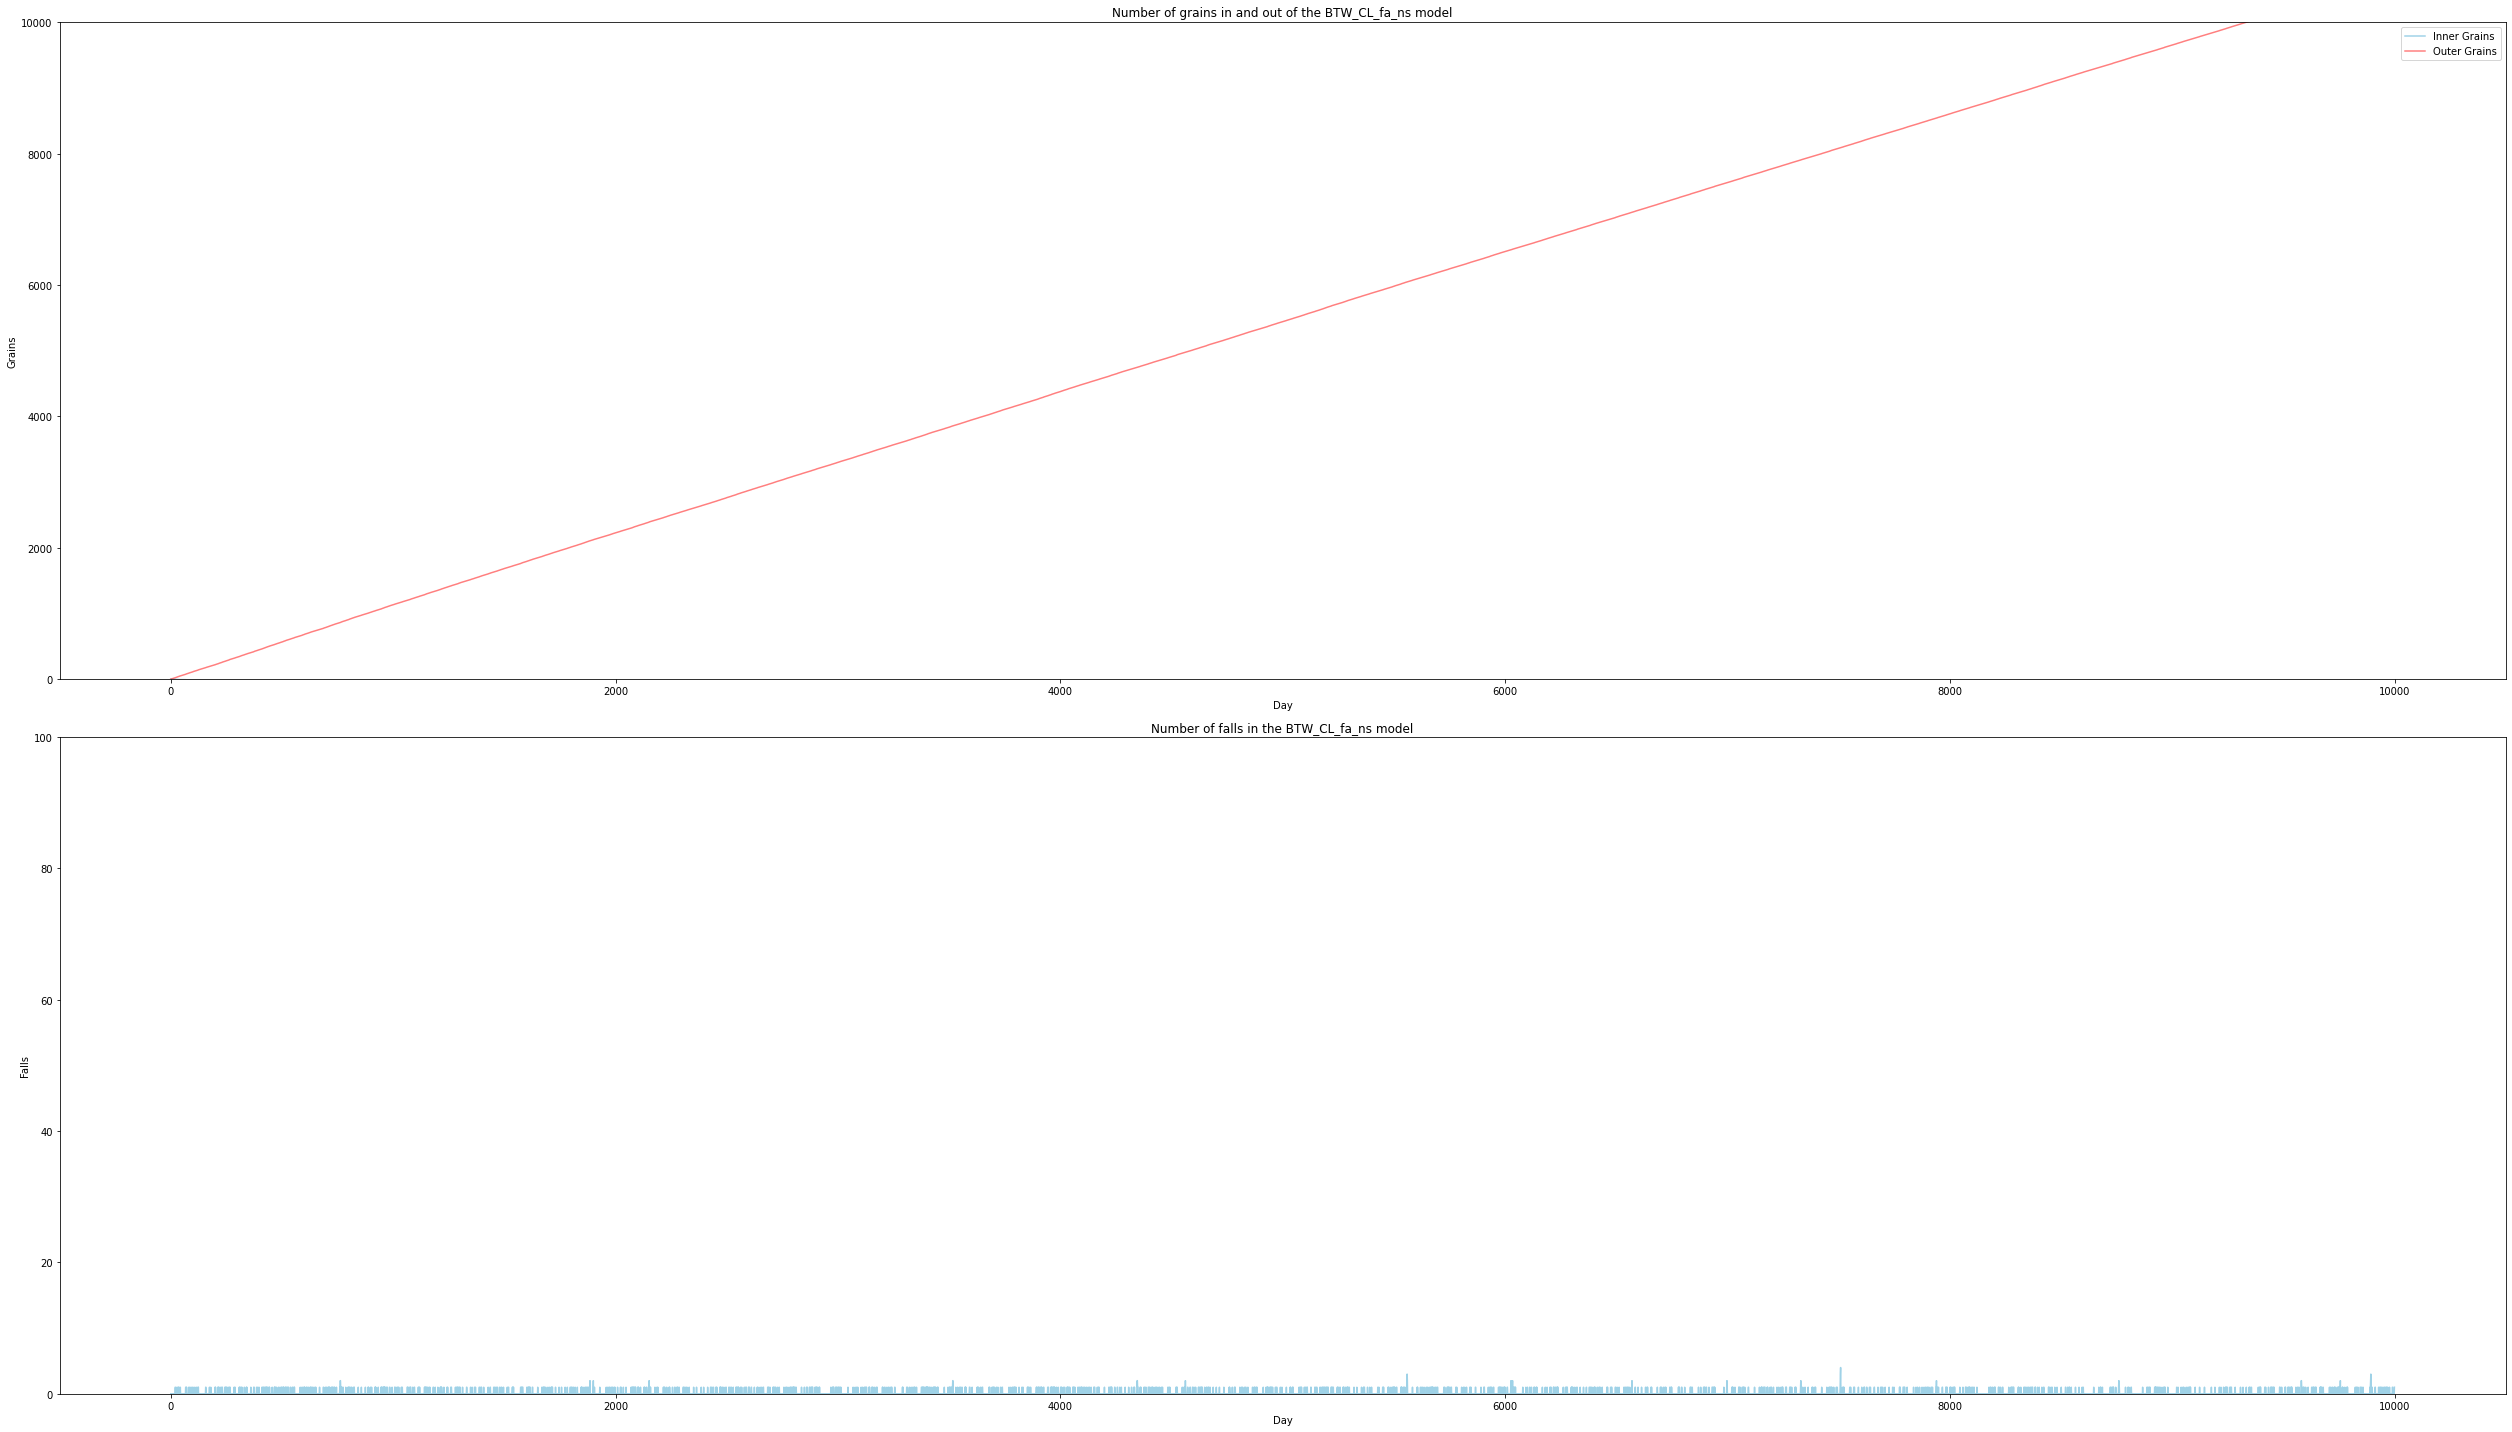

In [81]:
spread("BTW", G_CL, number_of_days, new_grains, "CL", facilitated = True, neutral_state = True, new_grains_minus = new_grains_minus)

### Mann

#### Standart Model

##### Standart Dissipation

100%|██████████| 9999/9999 [01:46<00:00, 93.83it/s] 


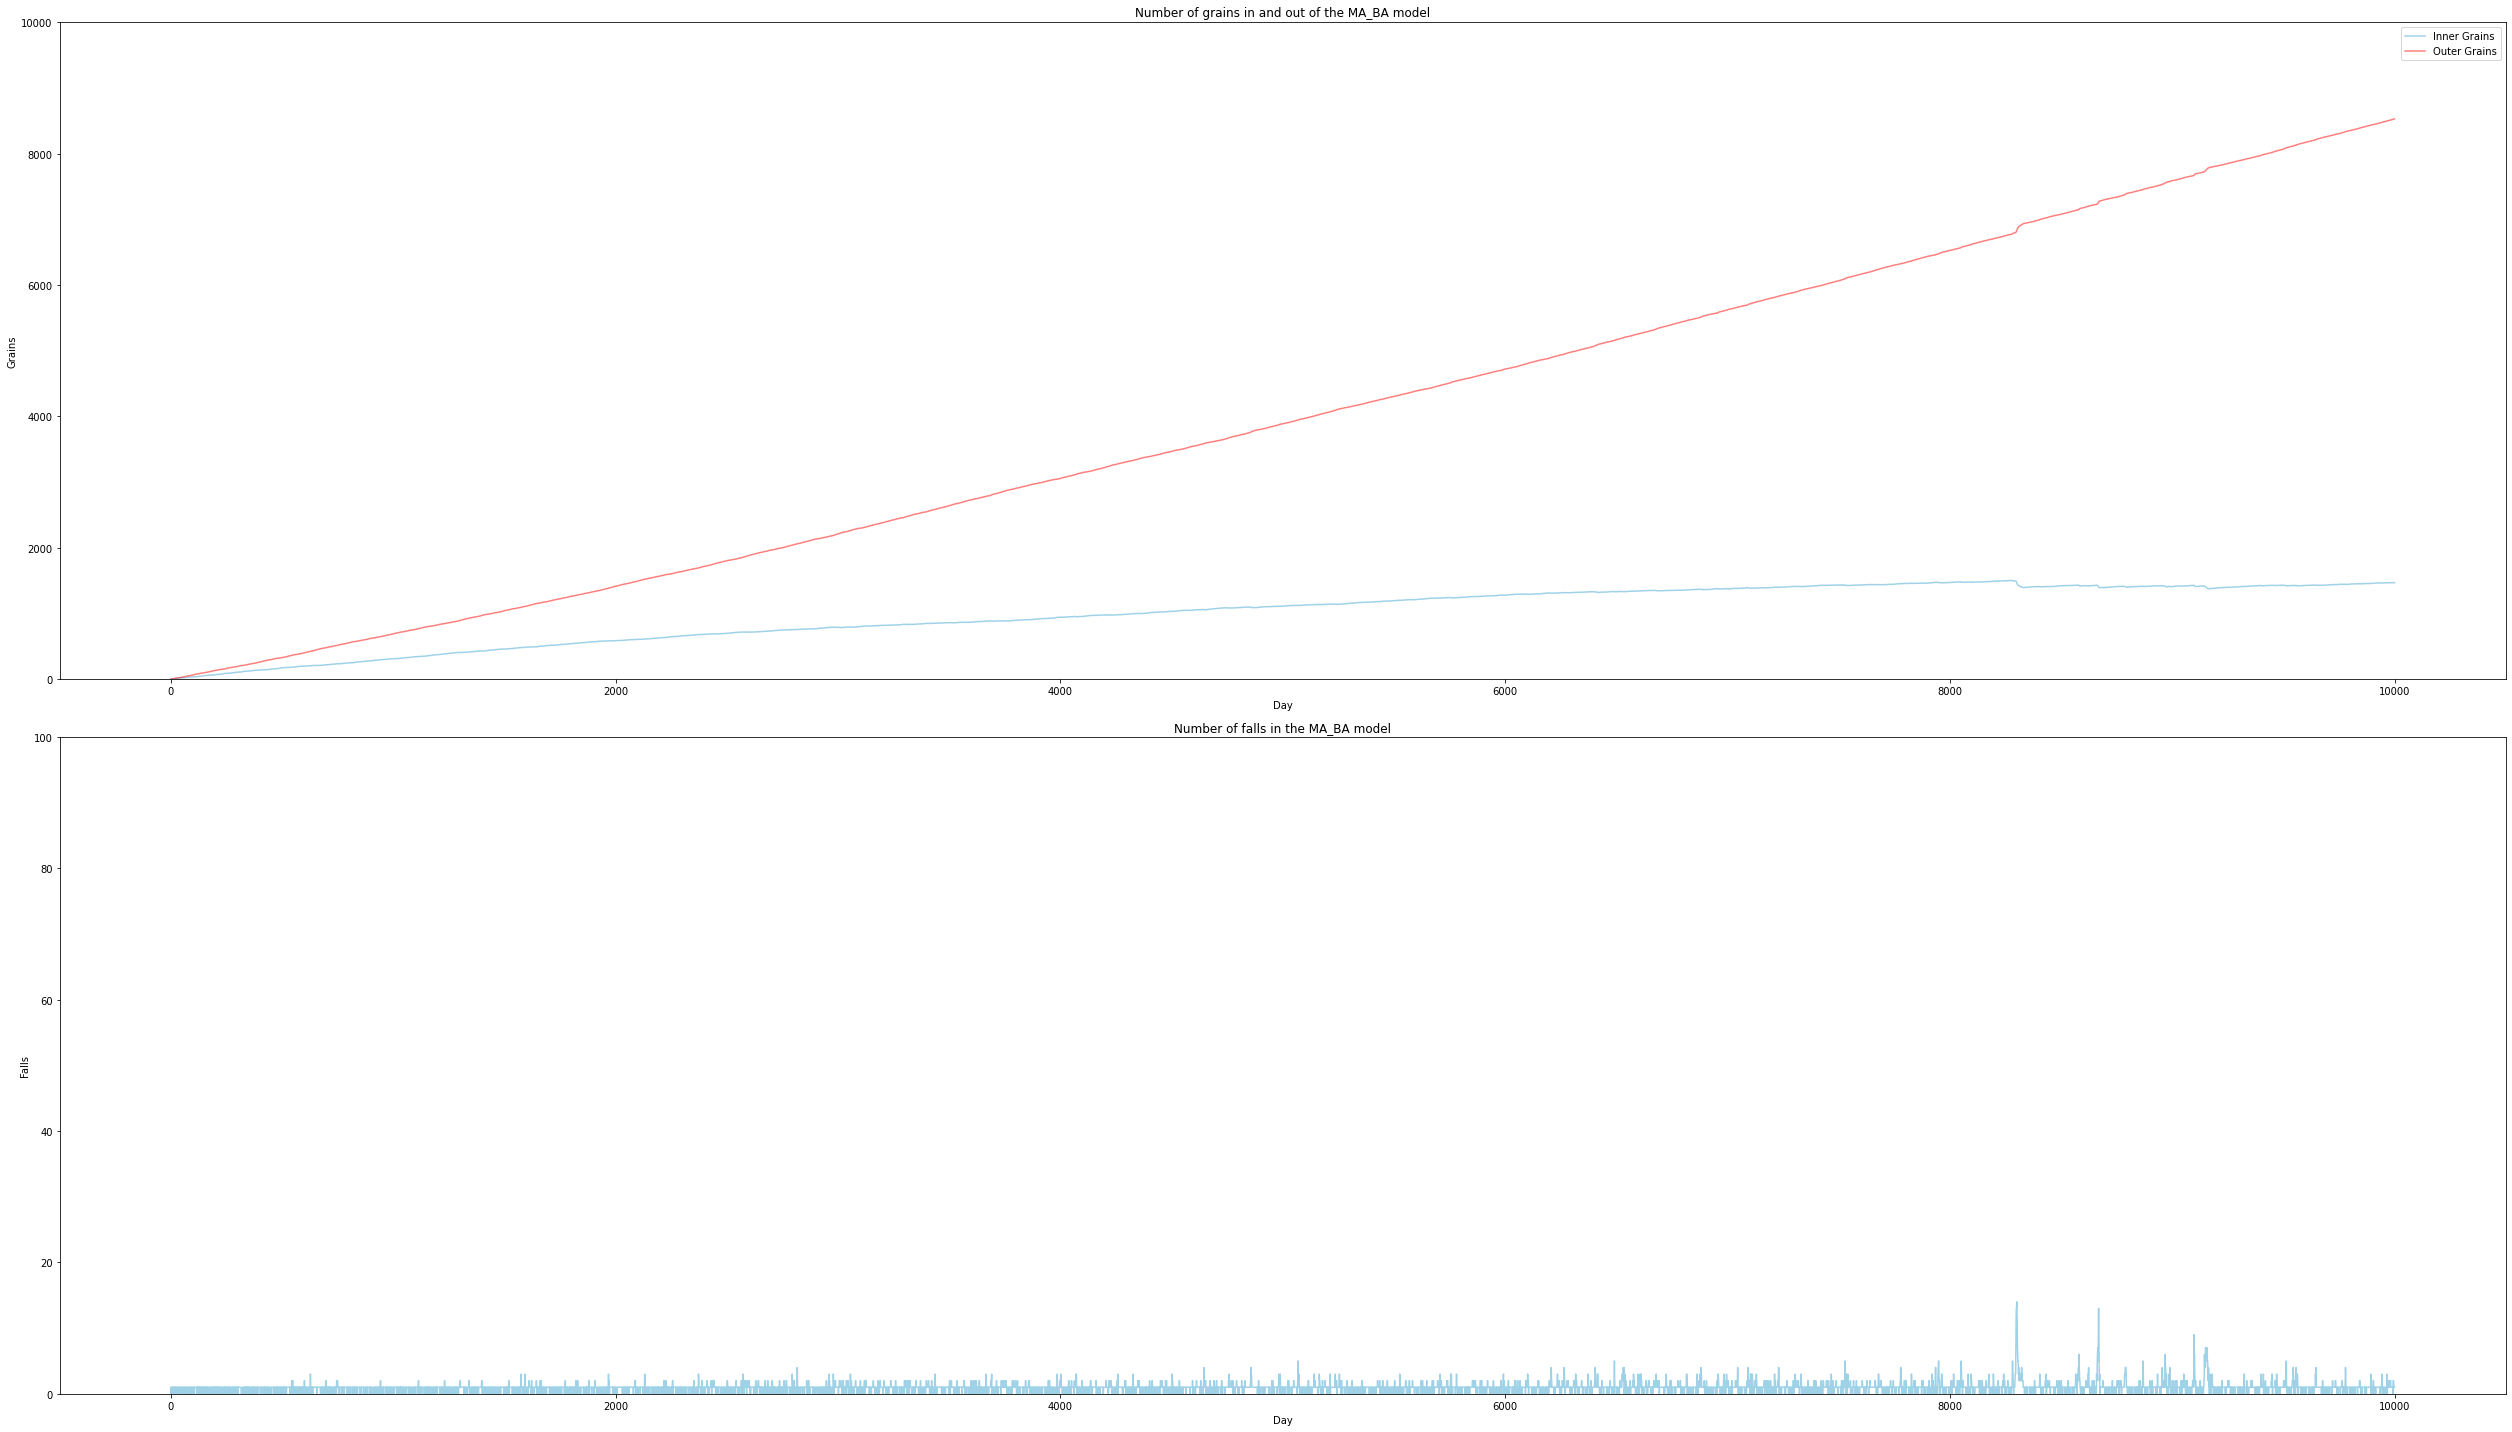

In [32]:
spread("MA", G_BA, number_of_days, new_grains, "BA")

100%|██████████| 9999/9999 [01:56<00:00, 85.57it/s]


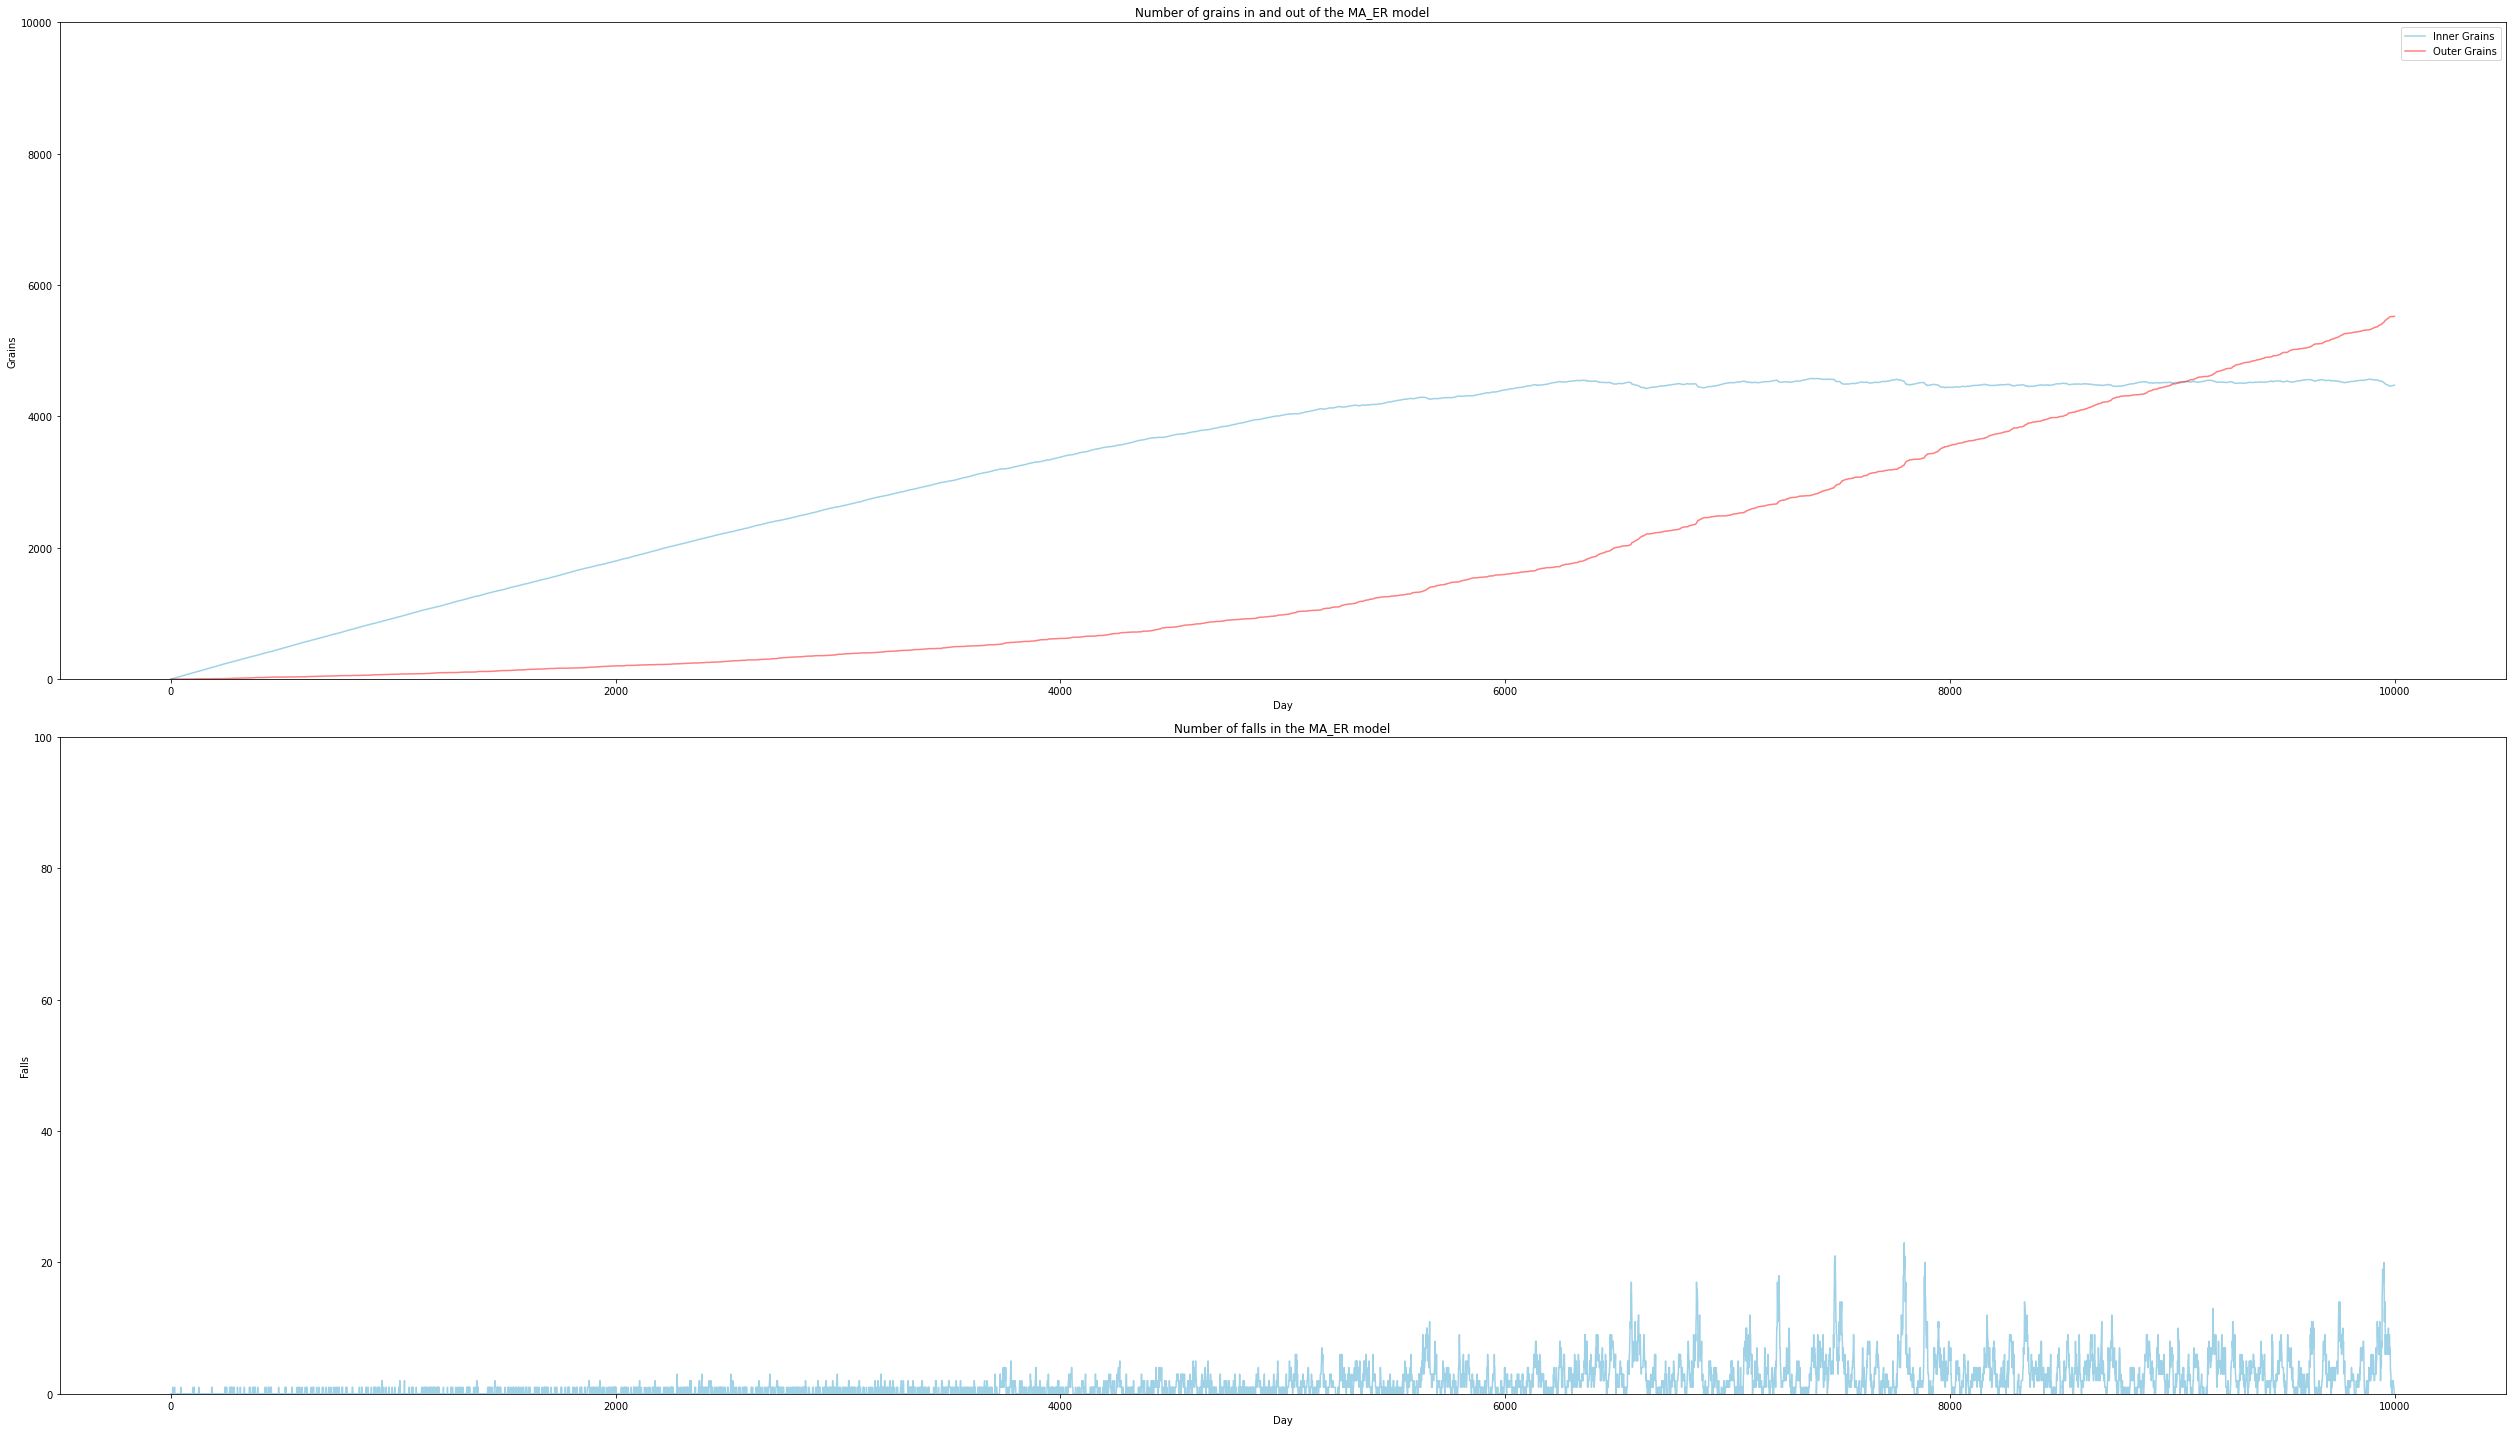

In [33]:
spread("MA", G_ER, number_of_days, new_grains, "ER")

100%|██████████| 9999/9999 [02:25<00:00, 68.50it/s]


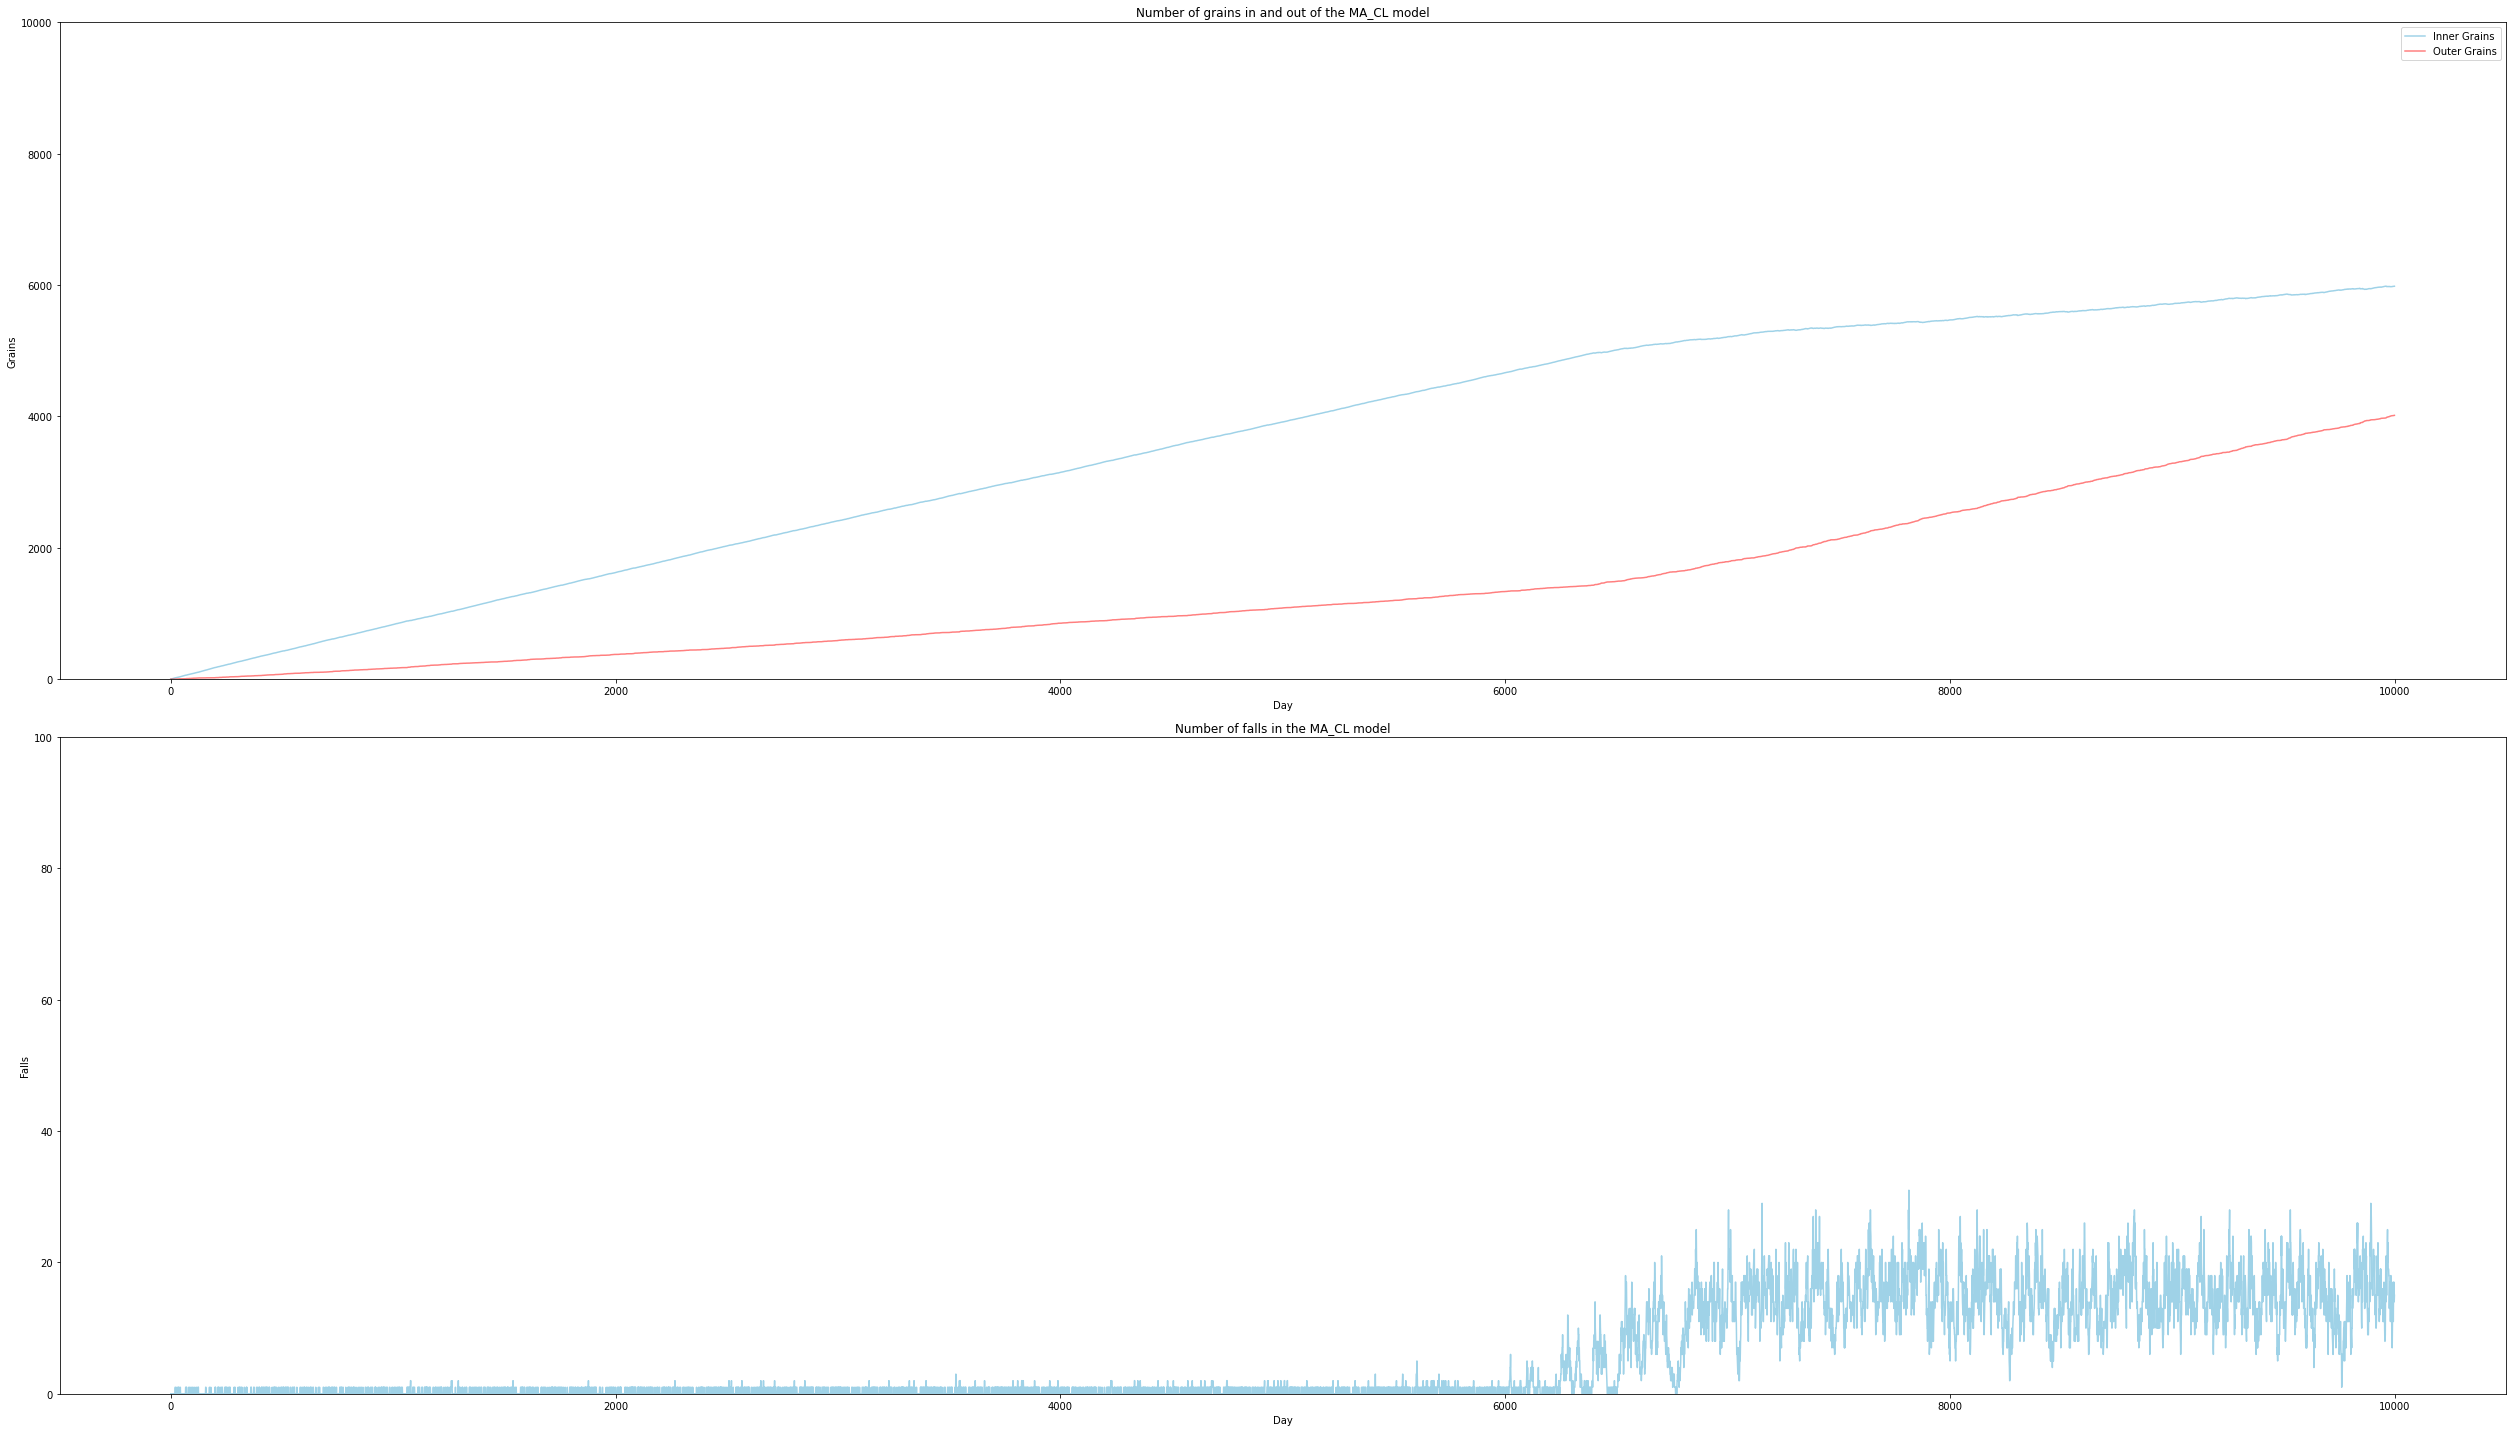

In [34]:
spread("MA", G_CL, number_of_days, new_grains, "CL")

##### Additional Dissipation

100%|██████████| 9999/9999 [02:01<00:00, 82.40it/s]


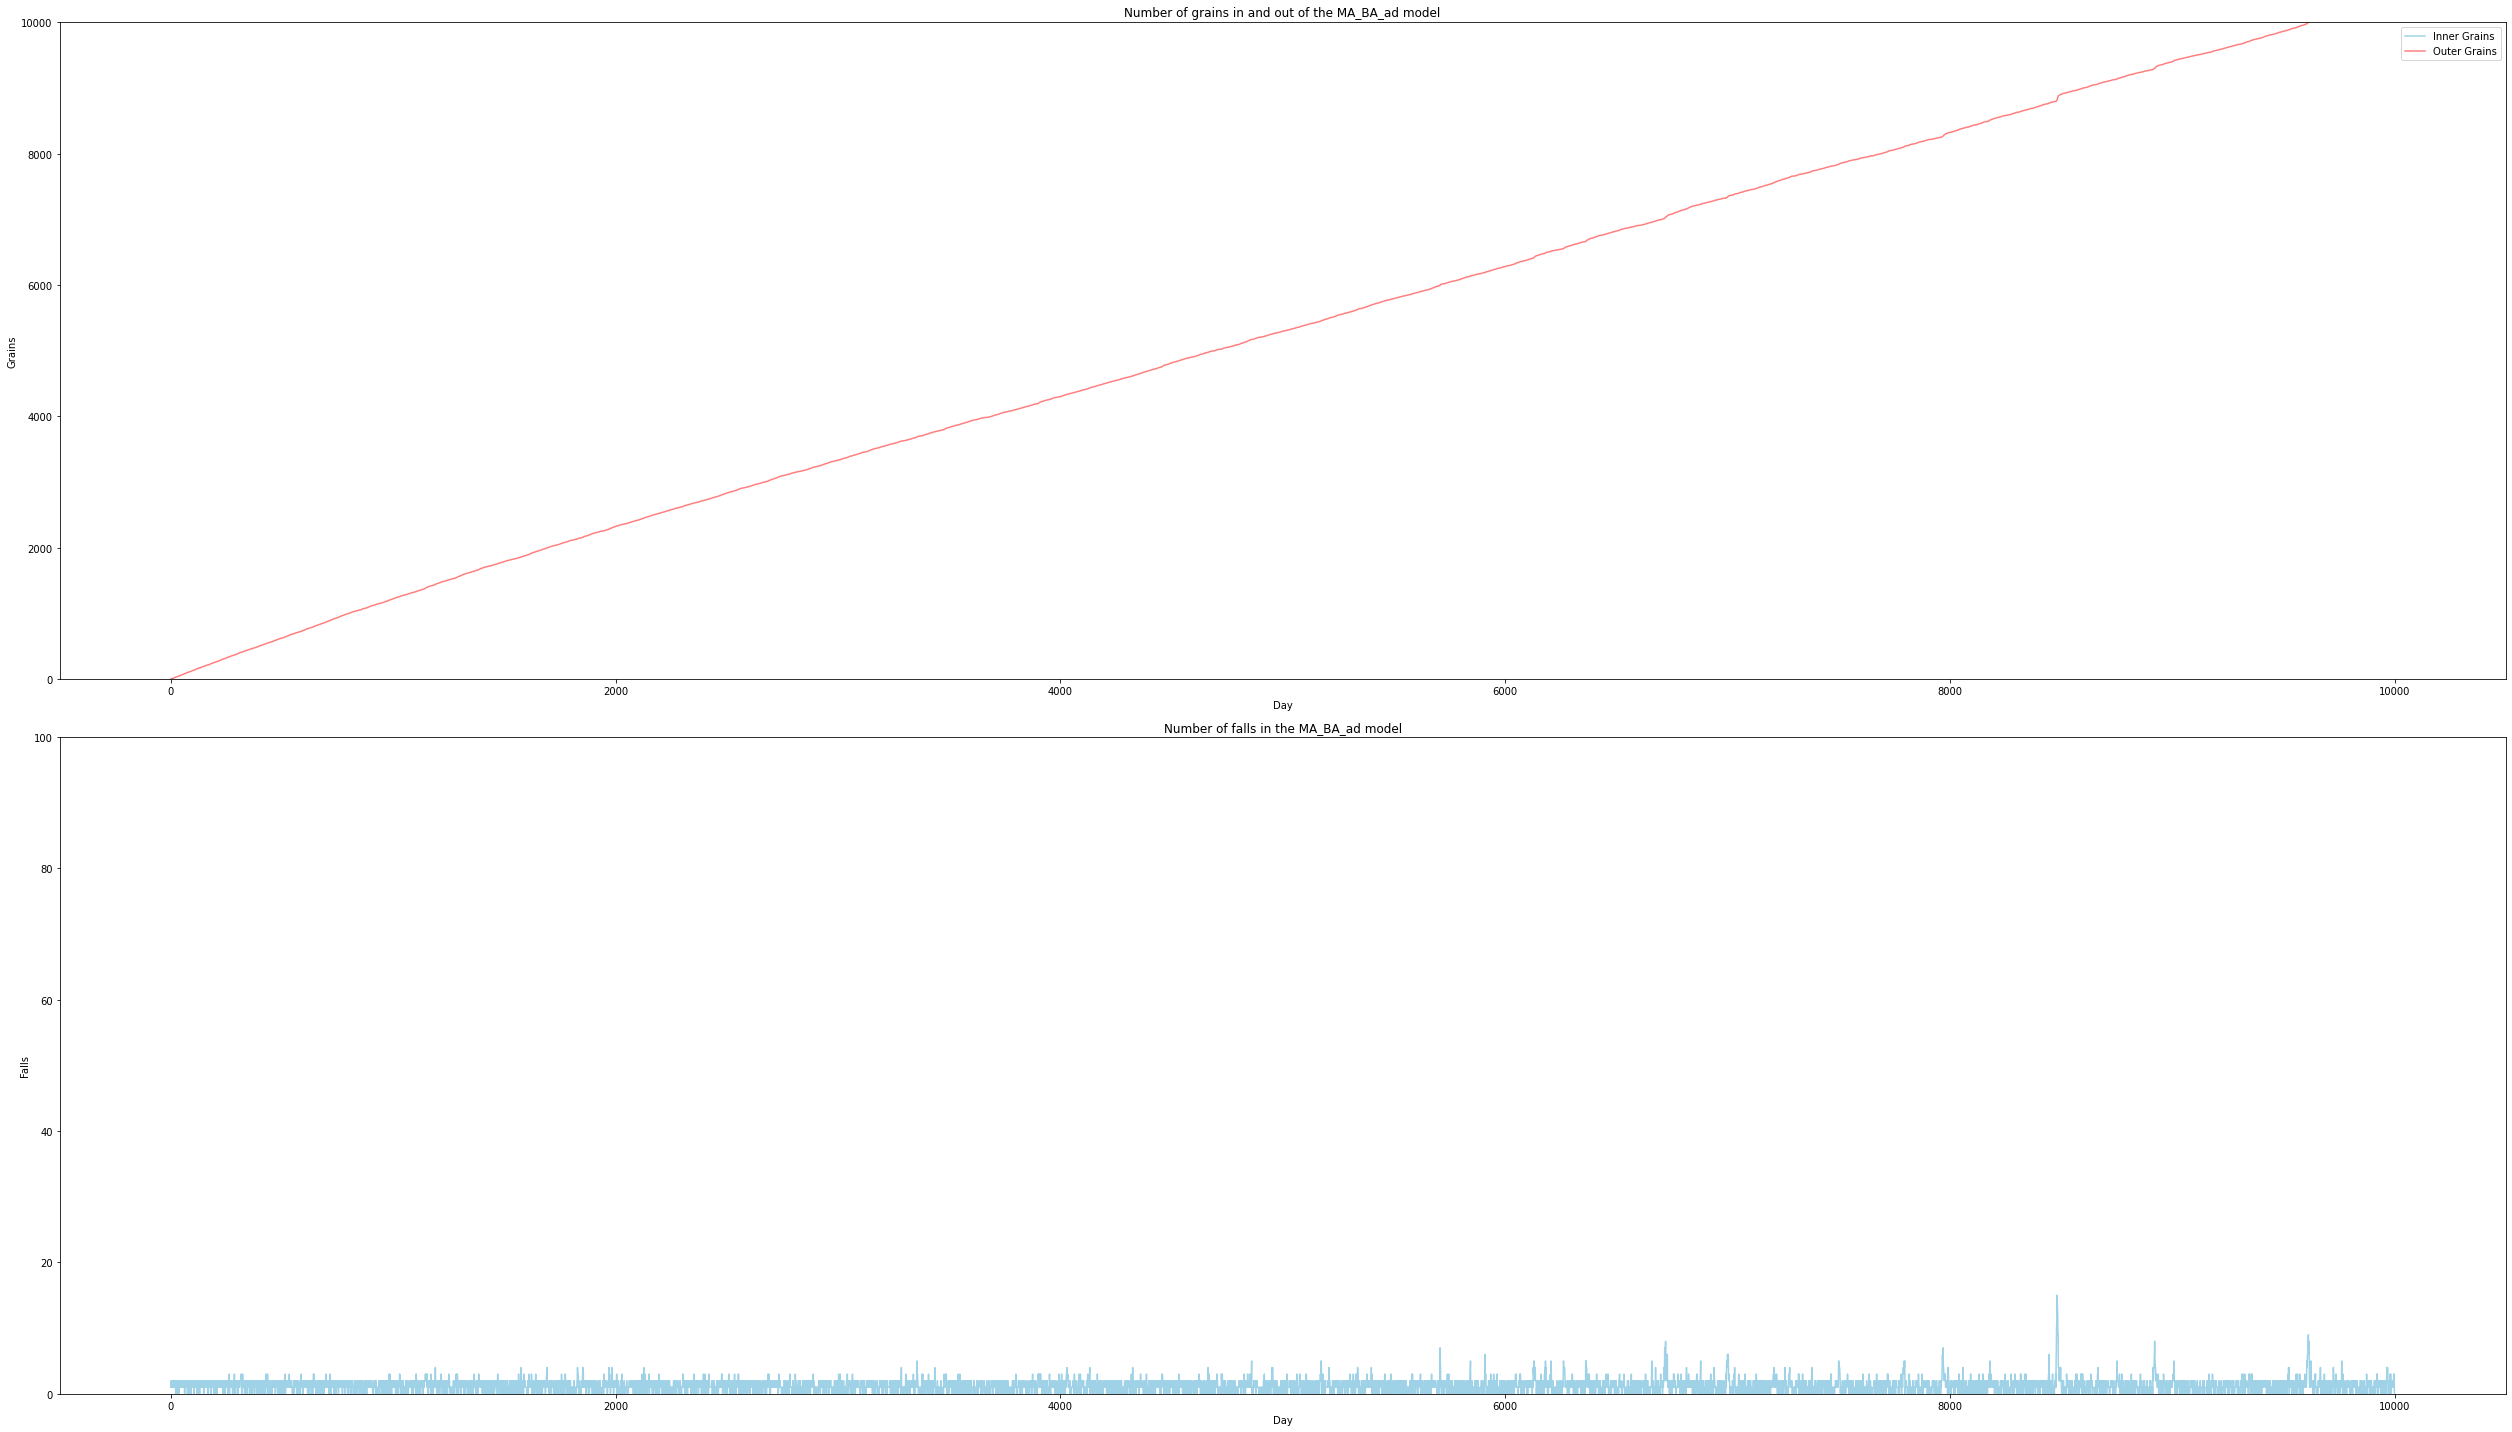

In [35]:
spread("MA", G_BA, number_of_days, new_grains, "BA", ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

100%|██████████| 9999/9999 [02:07<00:00, 78.30it/s]


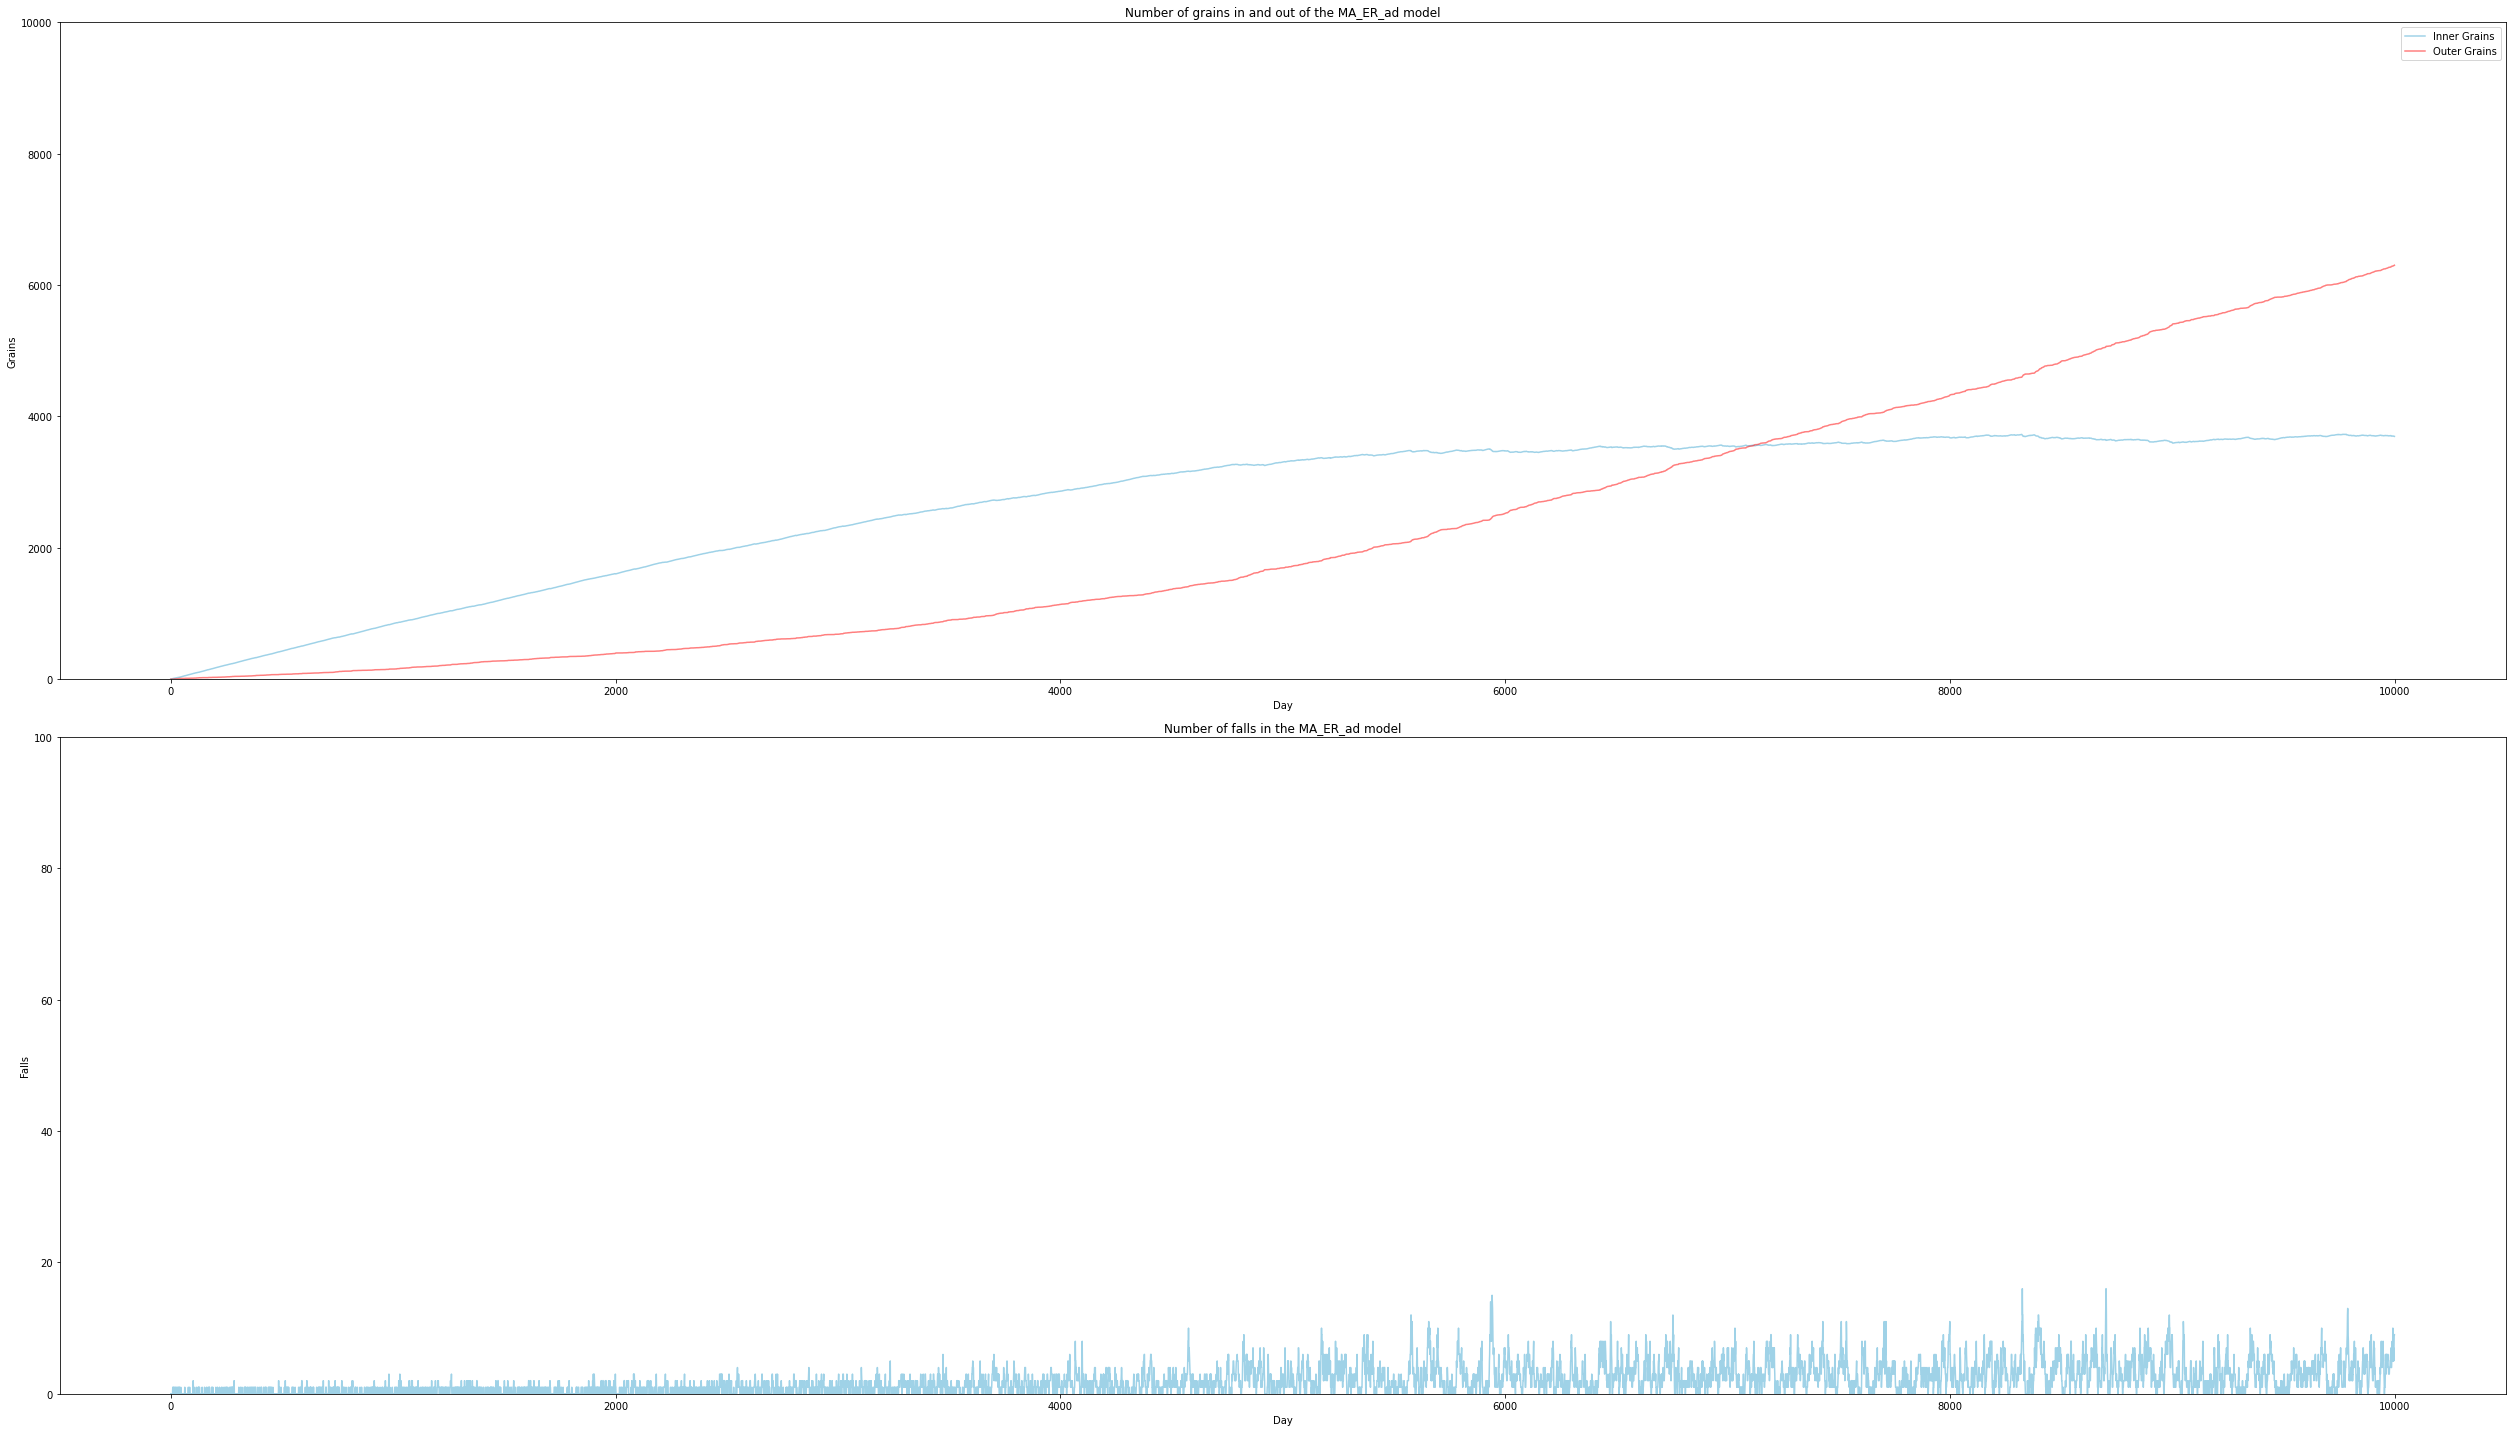

In [36]:
spread("MA", G_ER, number_of_days, new_grains, "ER", ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

100%|██████████| 9999/9999 [03:02<00:00, 54.83it/s]


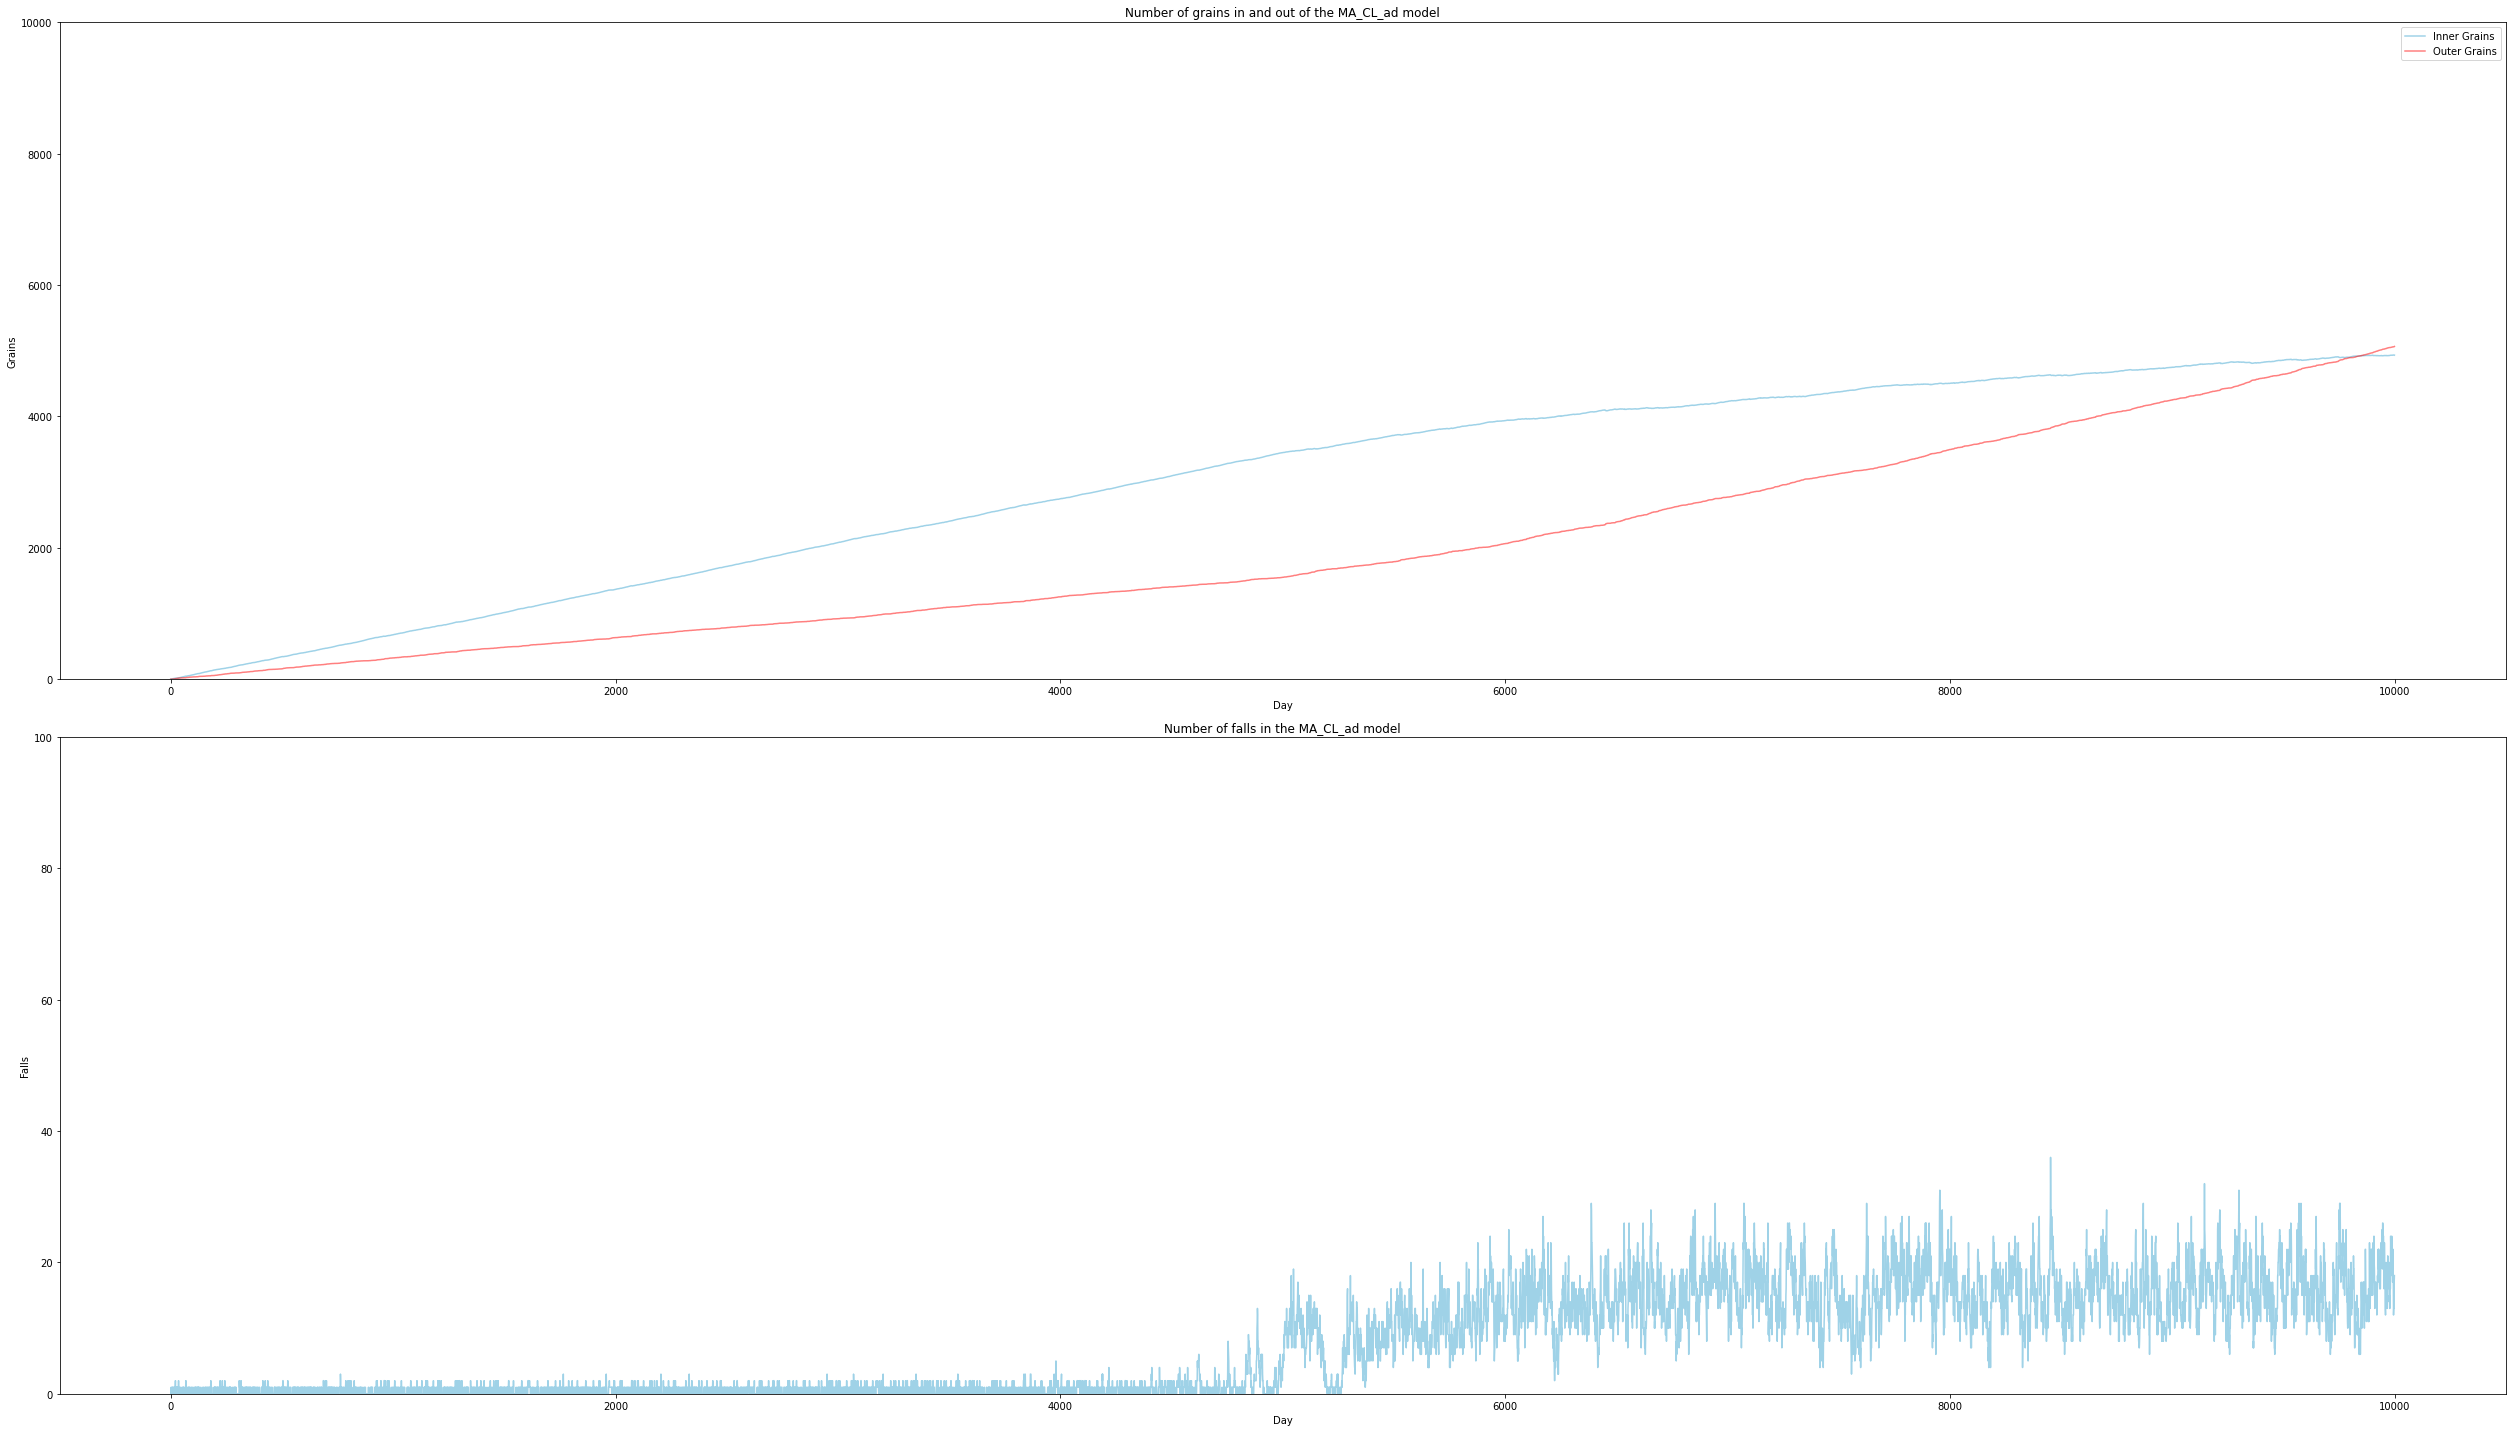

In [37]:
spread("MA", G_CL, number_of_days, new_grains, "CL", ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

##### Neutral State

100%|██████████| 9999/9999 [01:30<00:00, 111.00it/s]


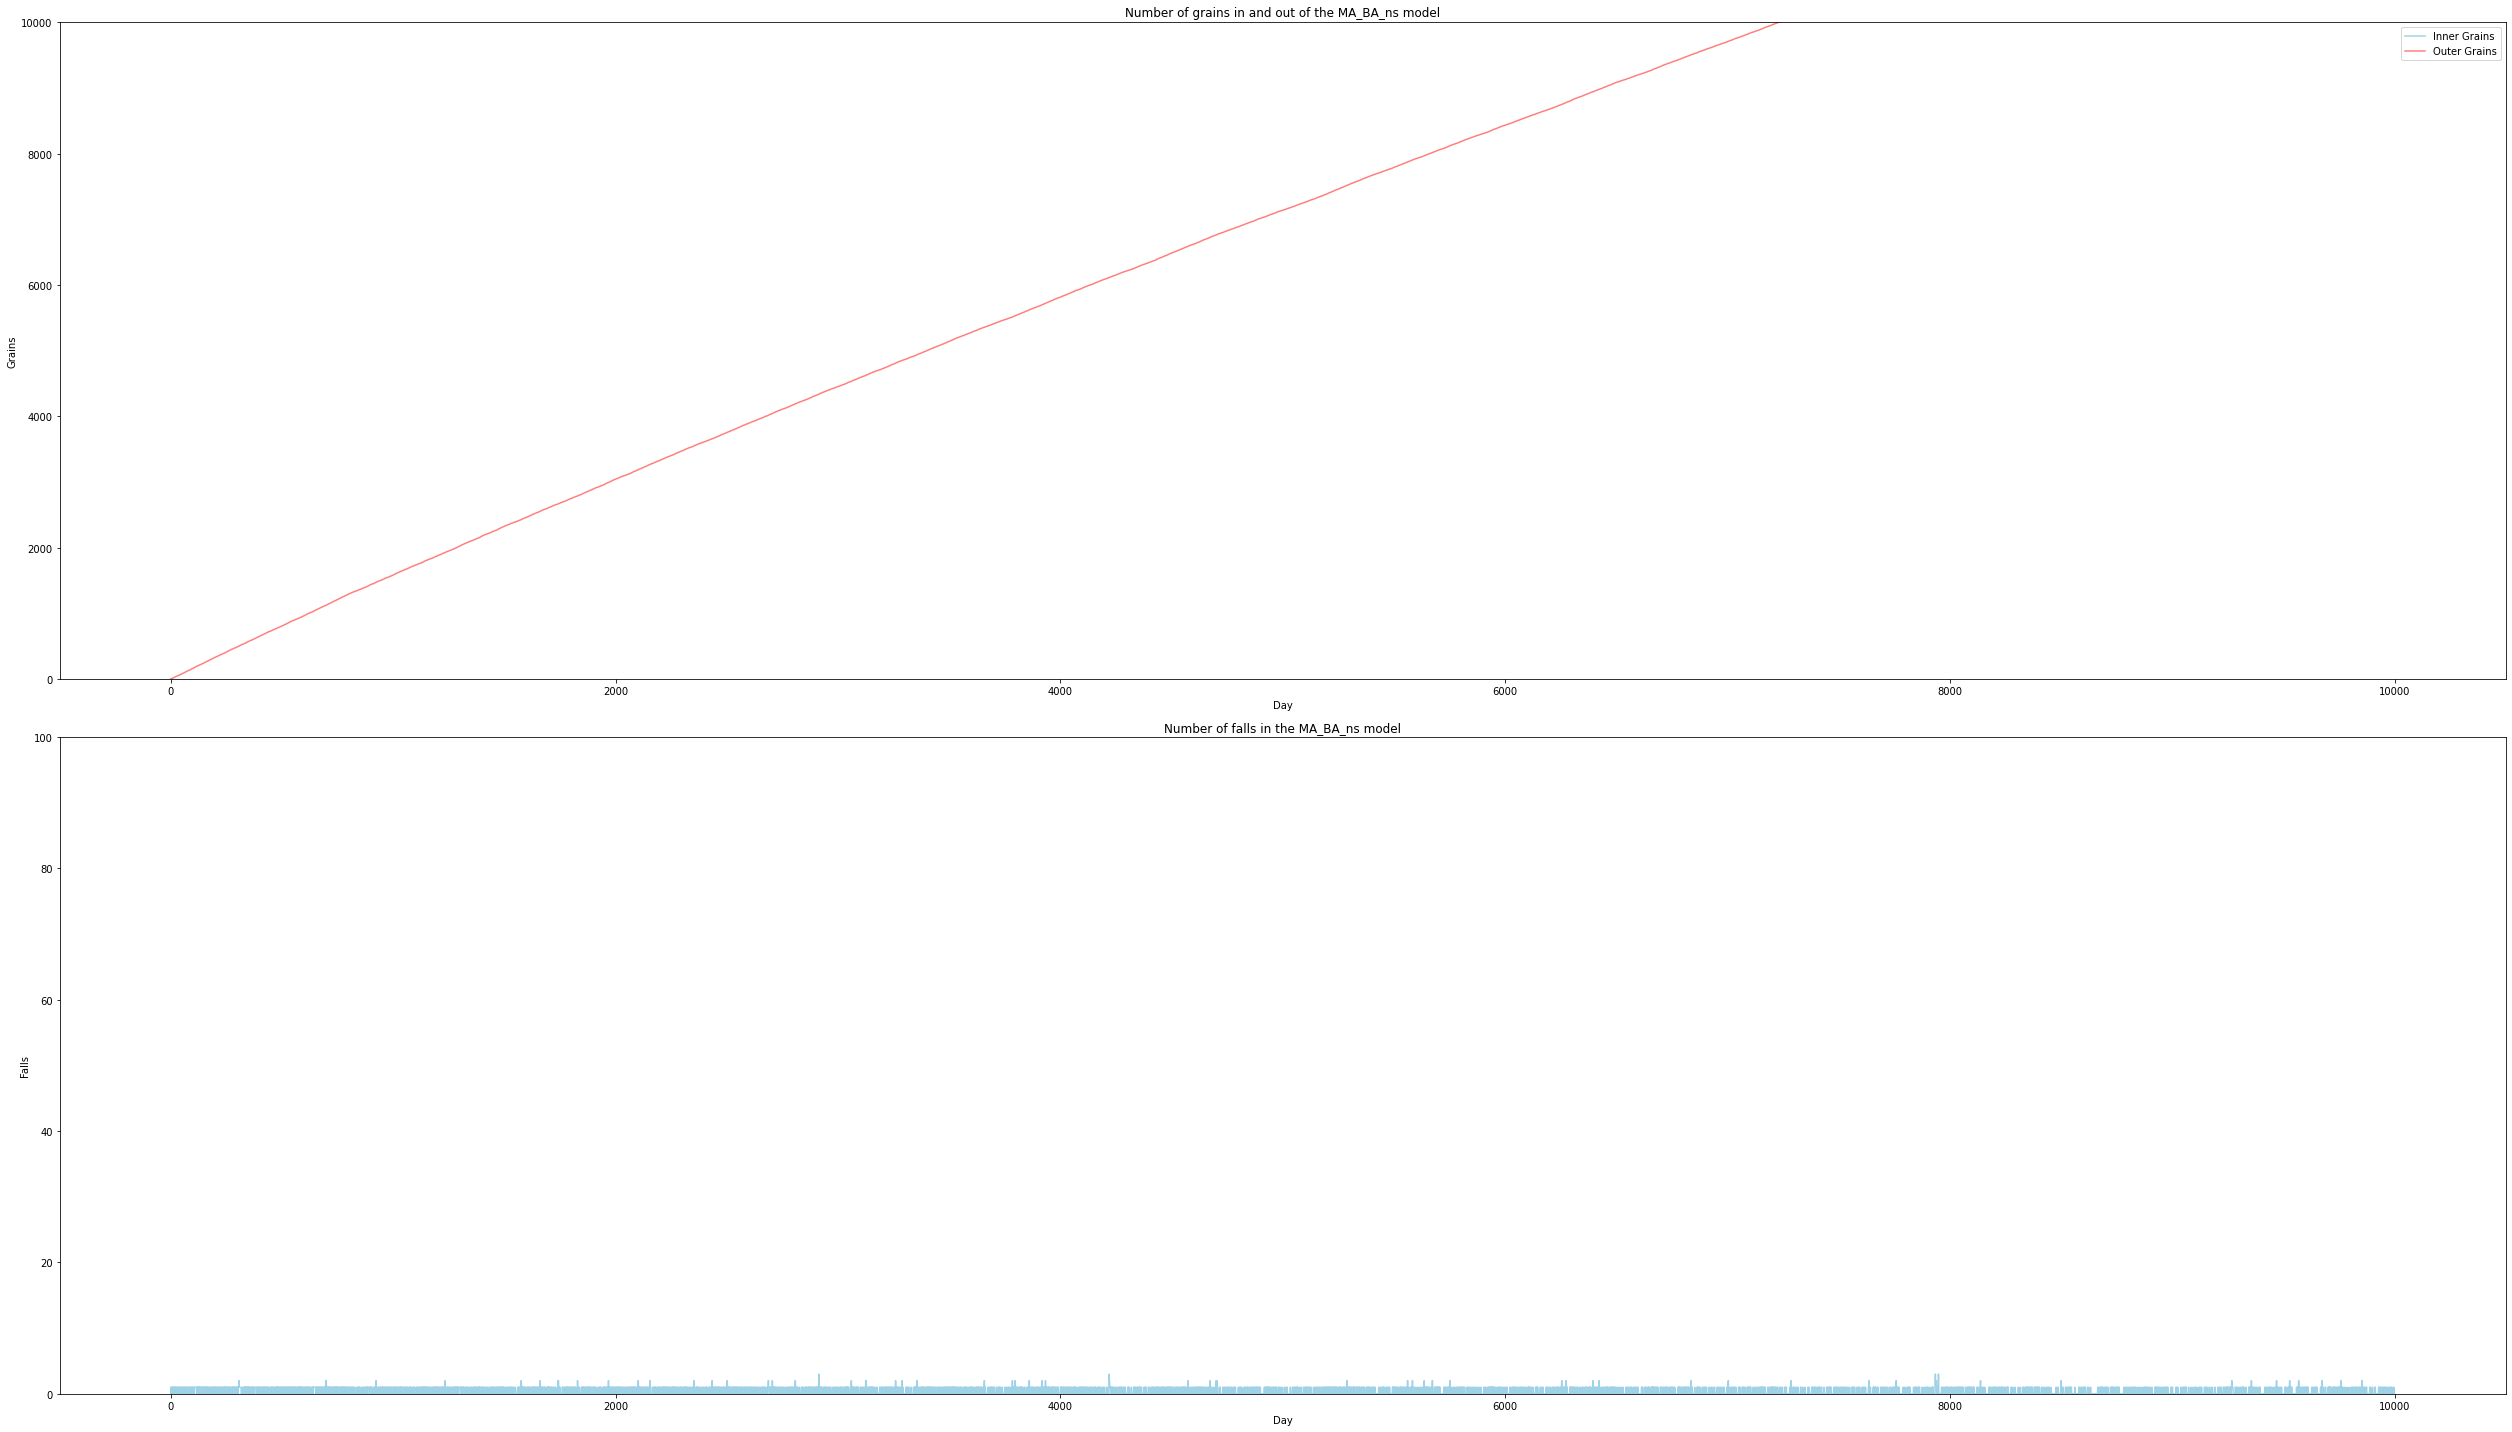

In [82]:
spread("MA", G_BA, number_of_days, new_grains, "BA", neutral_state = True, new_grains_minus = new_grains_minus)

100%|██████████| 9999/9999 [01:28<00:00, 112.83it/s]


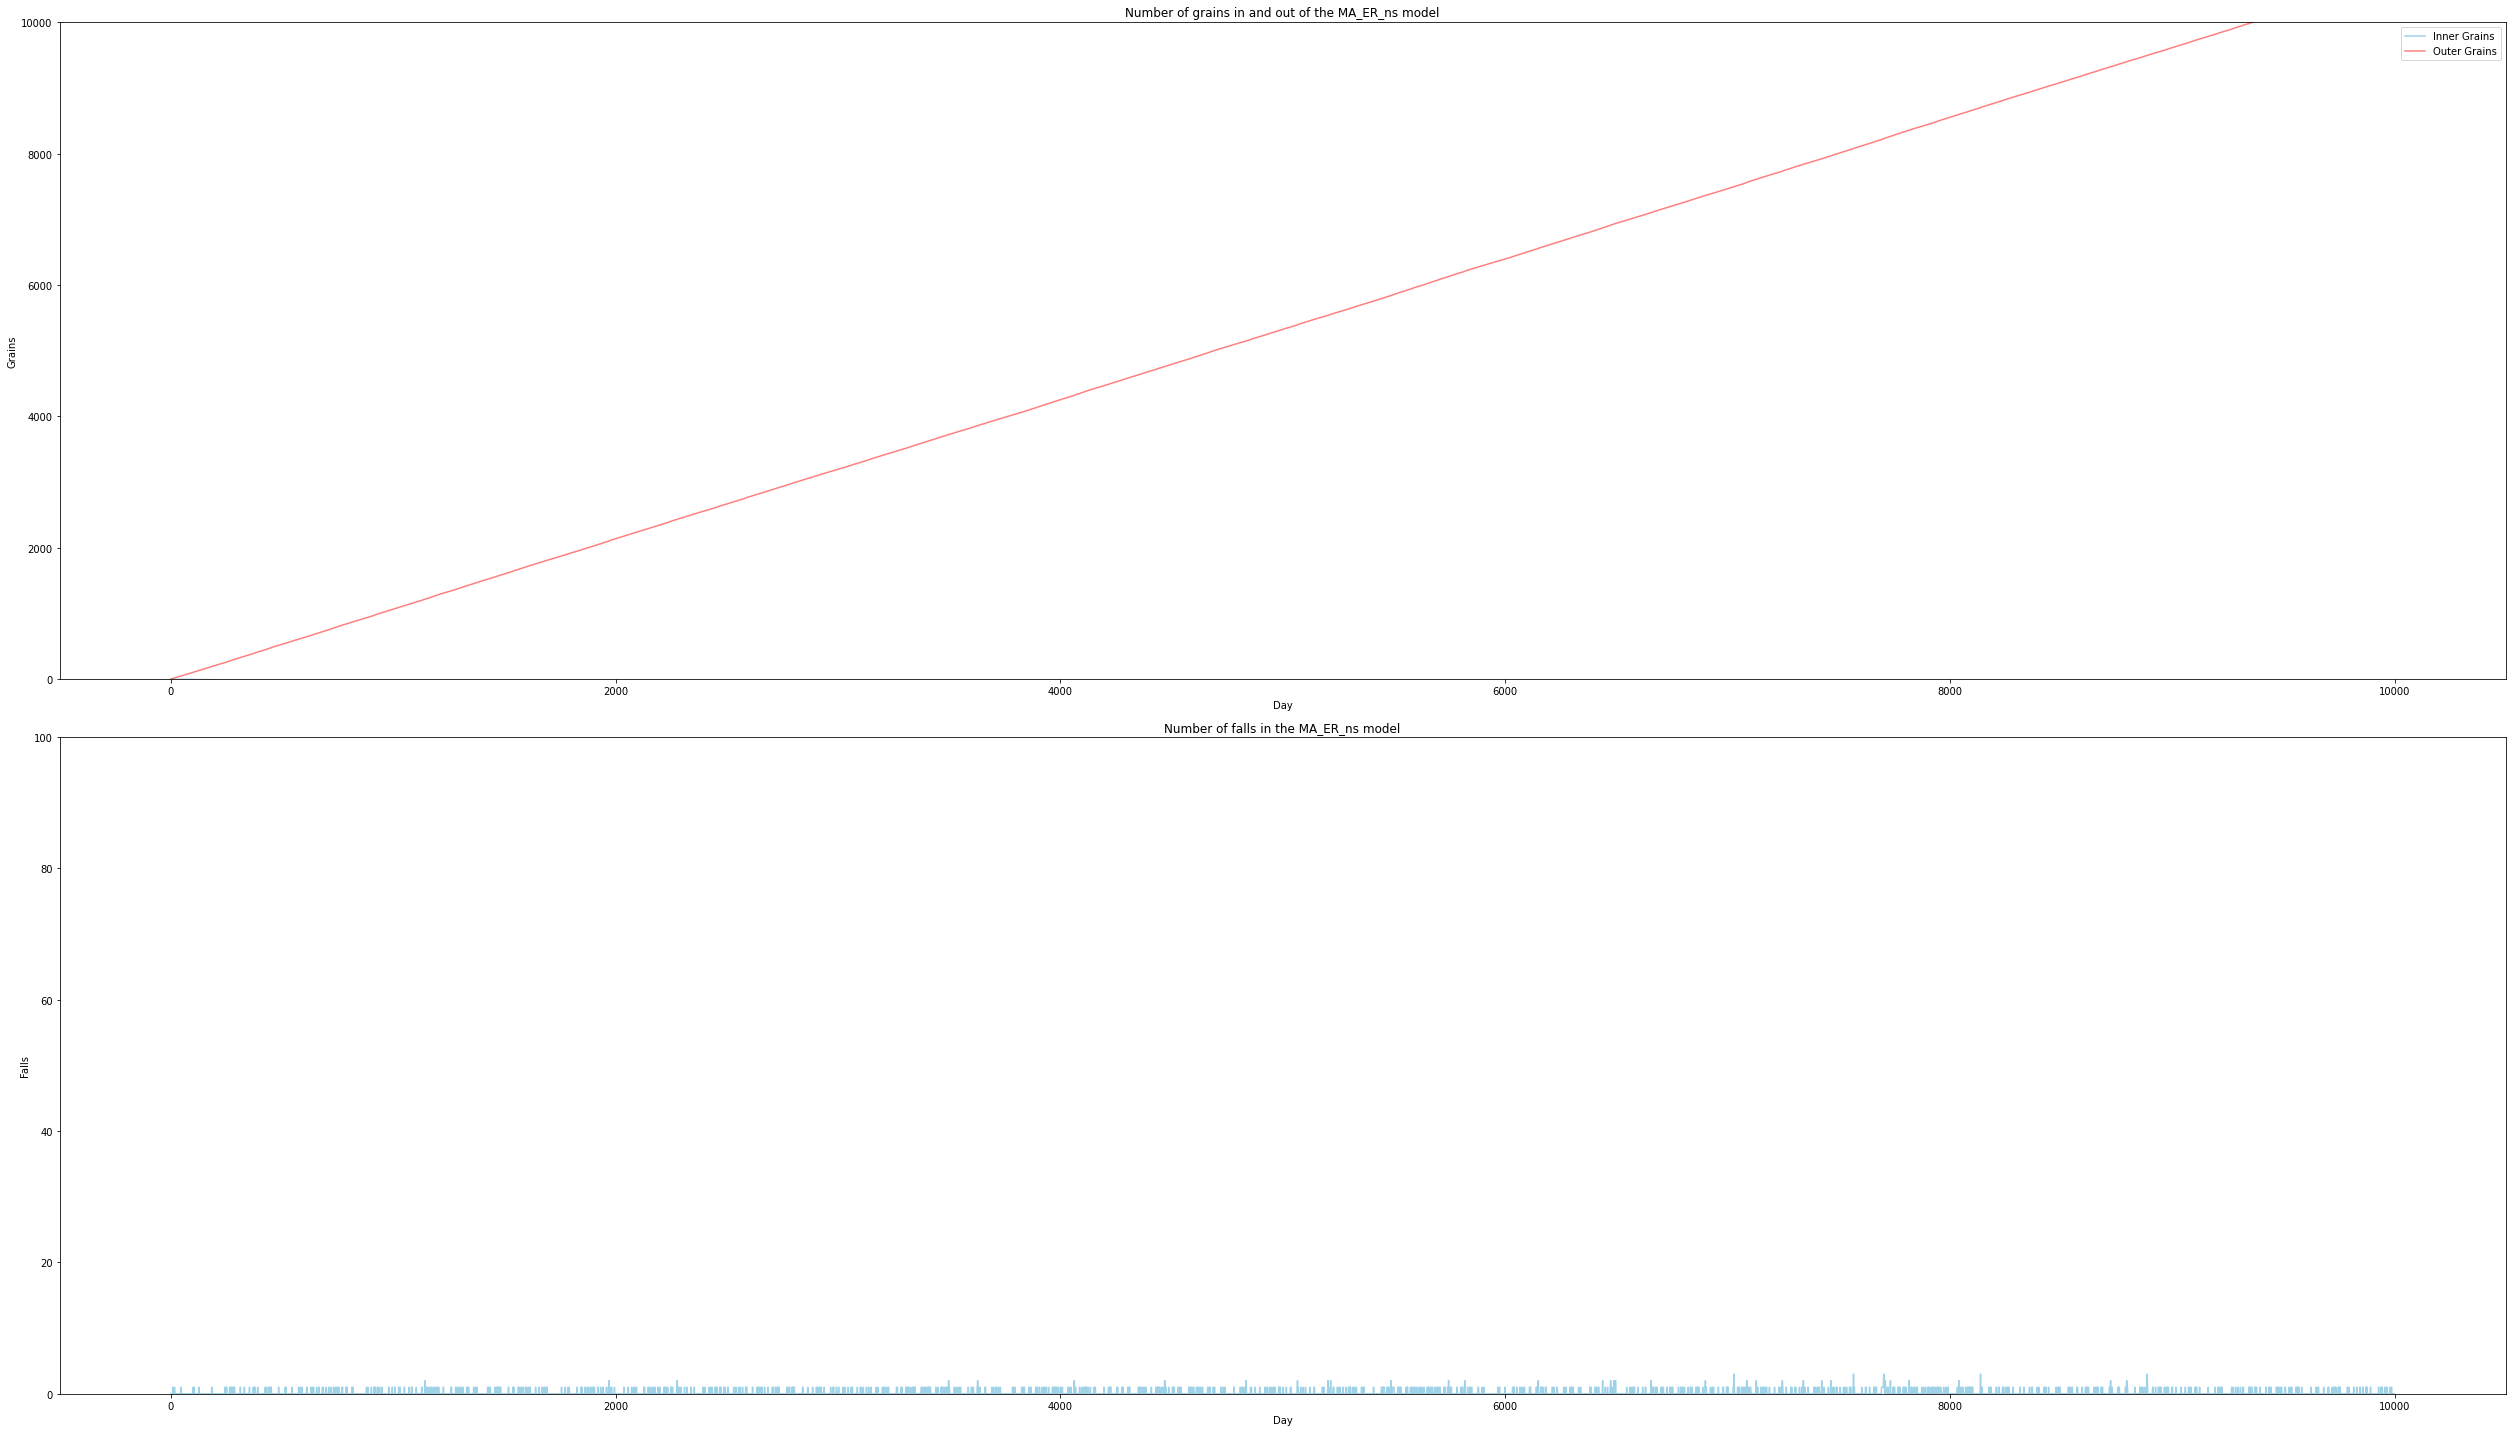

In [83]:
spread("MA", G_ER, number_of_days, new_grains, "ER", neutral_state = True, new_grains_minus = new_grains_minus)

100%|██████████| 9999/9999 [01:26<00:00, 115.15it/s]


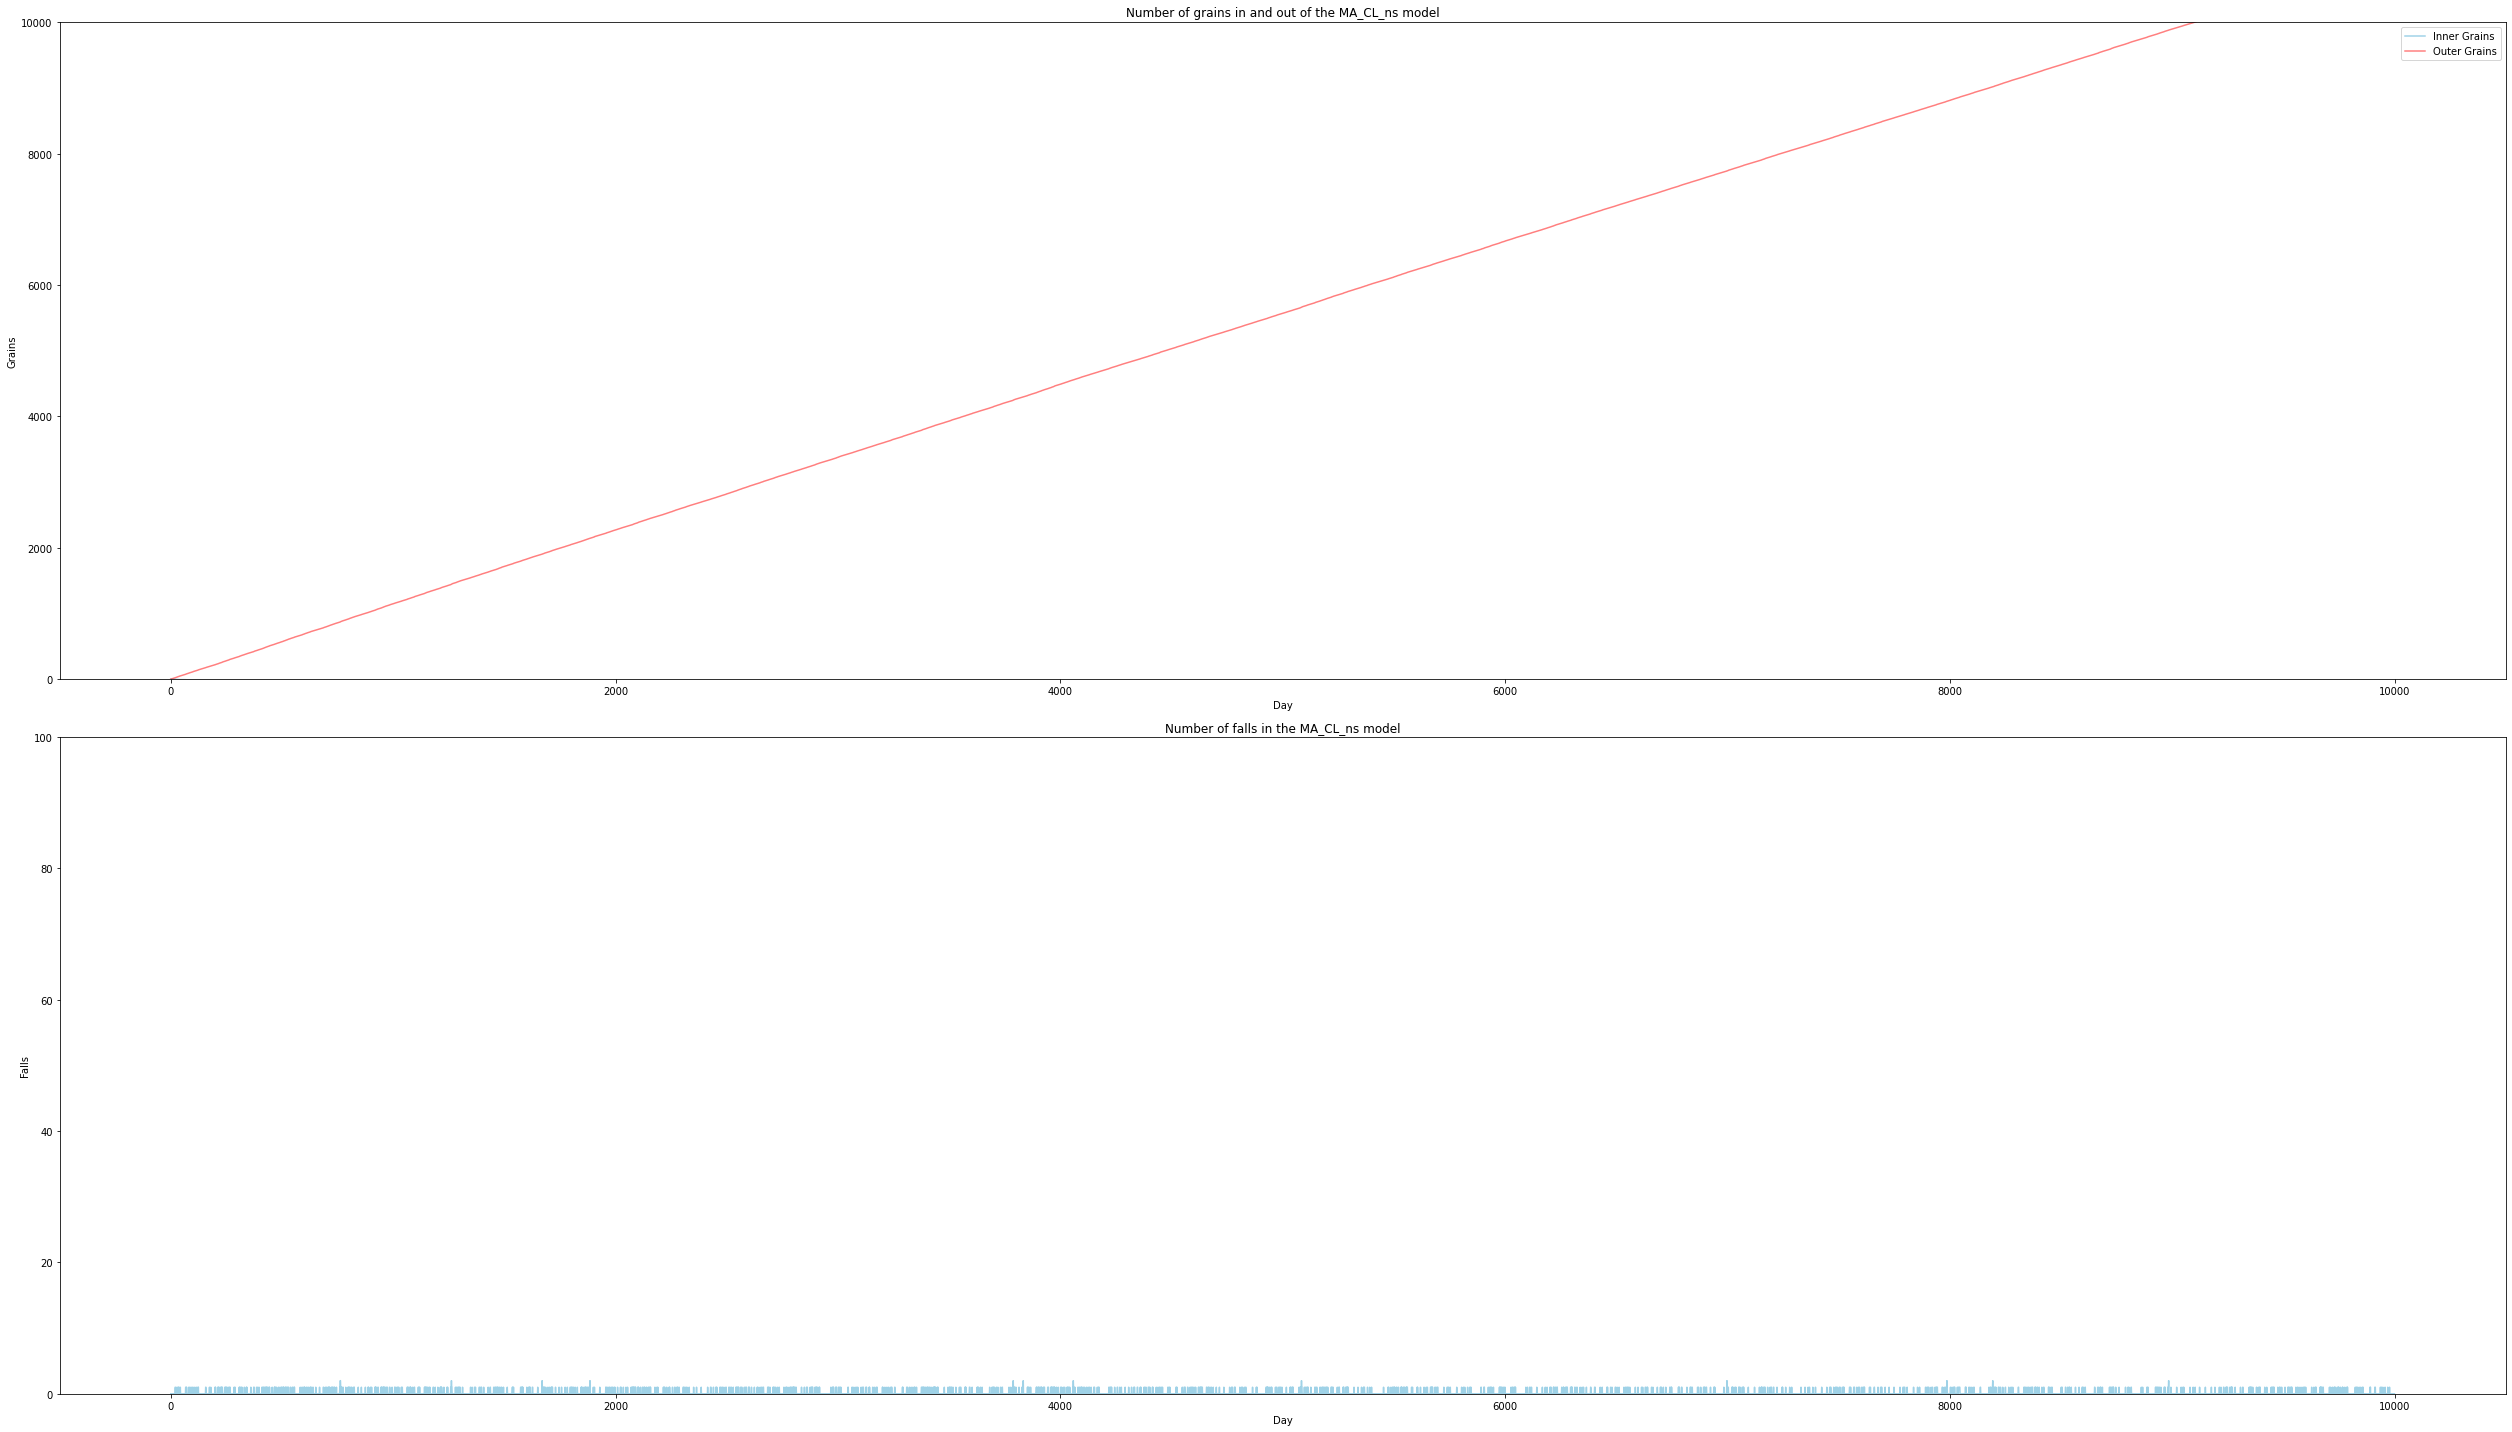

In [84]:
spread("MA", G_CL, number_of_days, new_grains, "CL", neutral_state = True, new_grains_minus = new_grains_minus)

#### Facilitated Model

##### Standart Dissipation

100%|██████████| 9999/9999 [02:03<00:00, 81.25it/s]


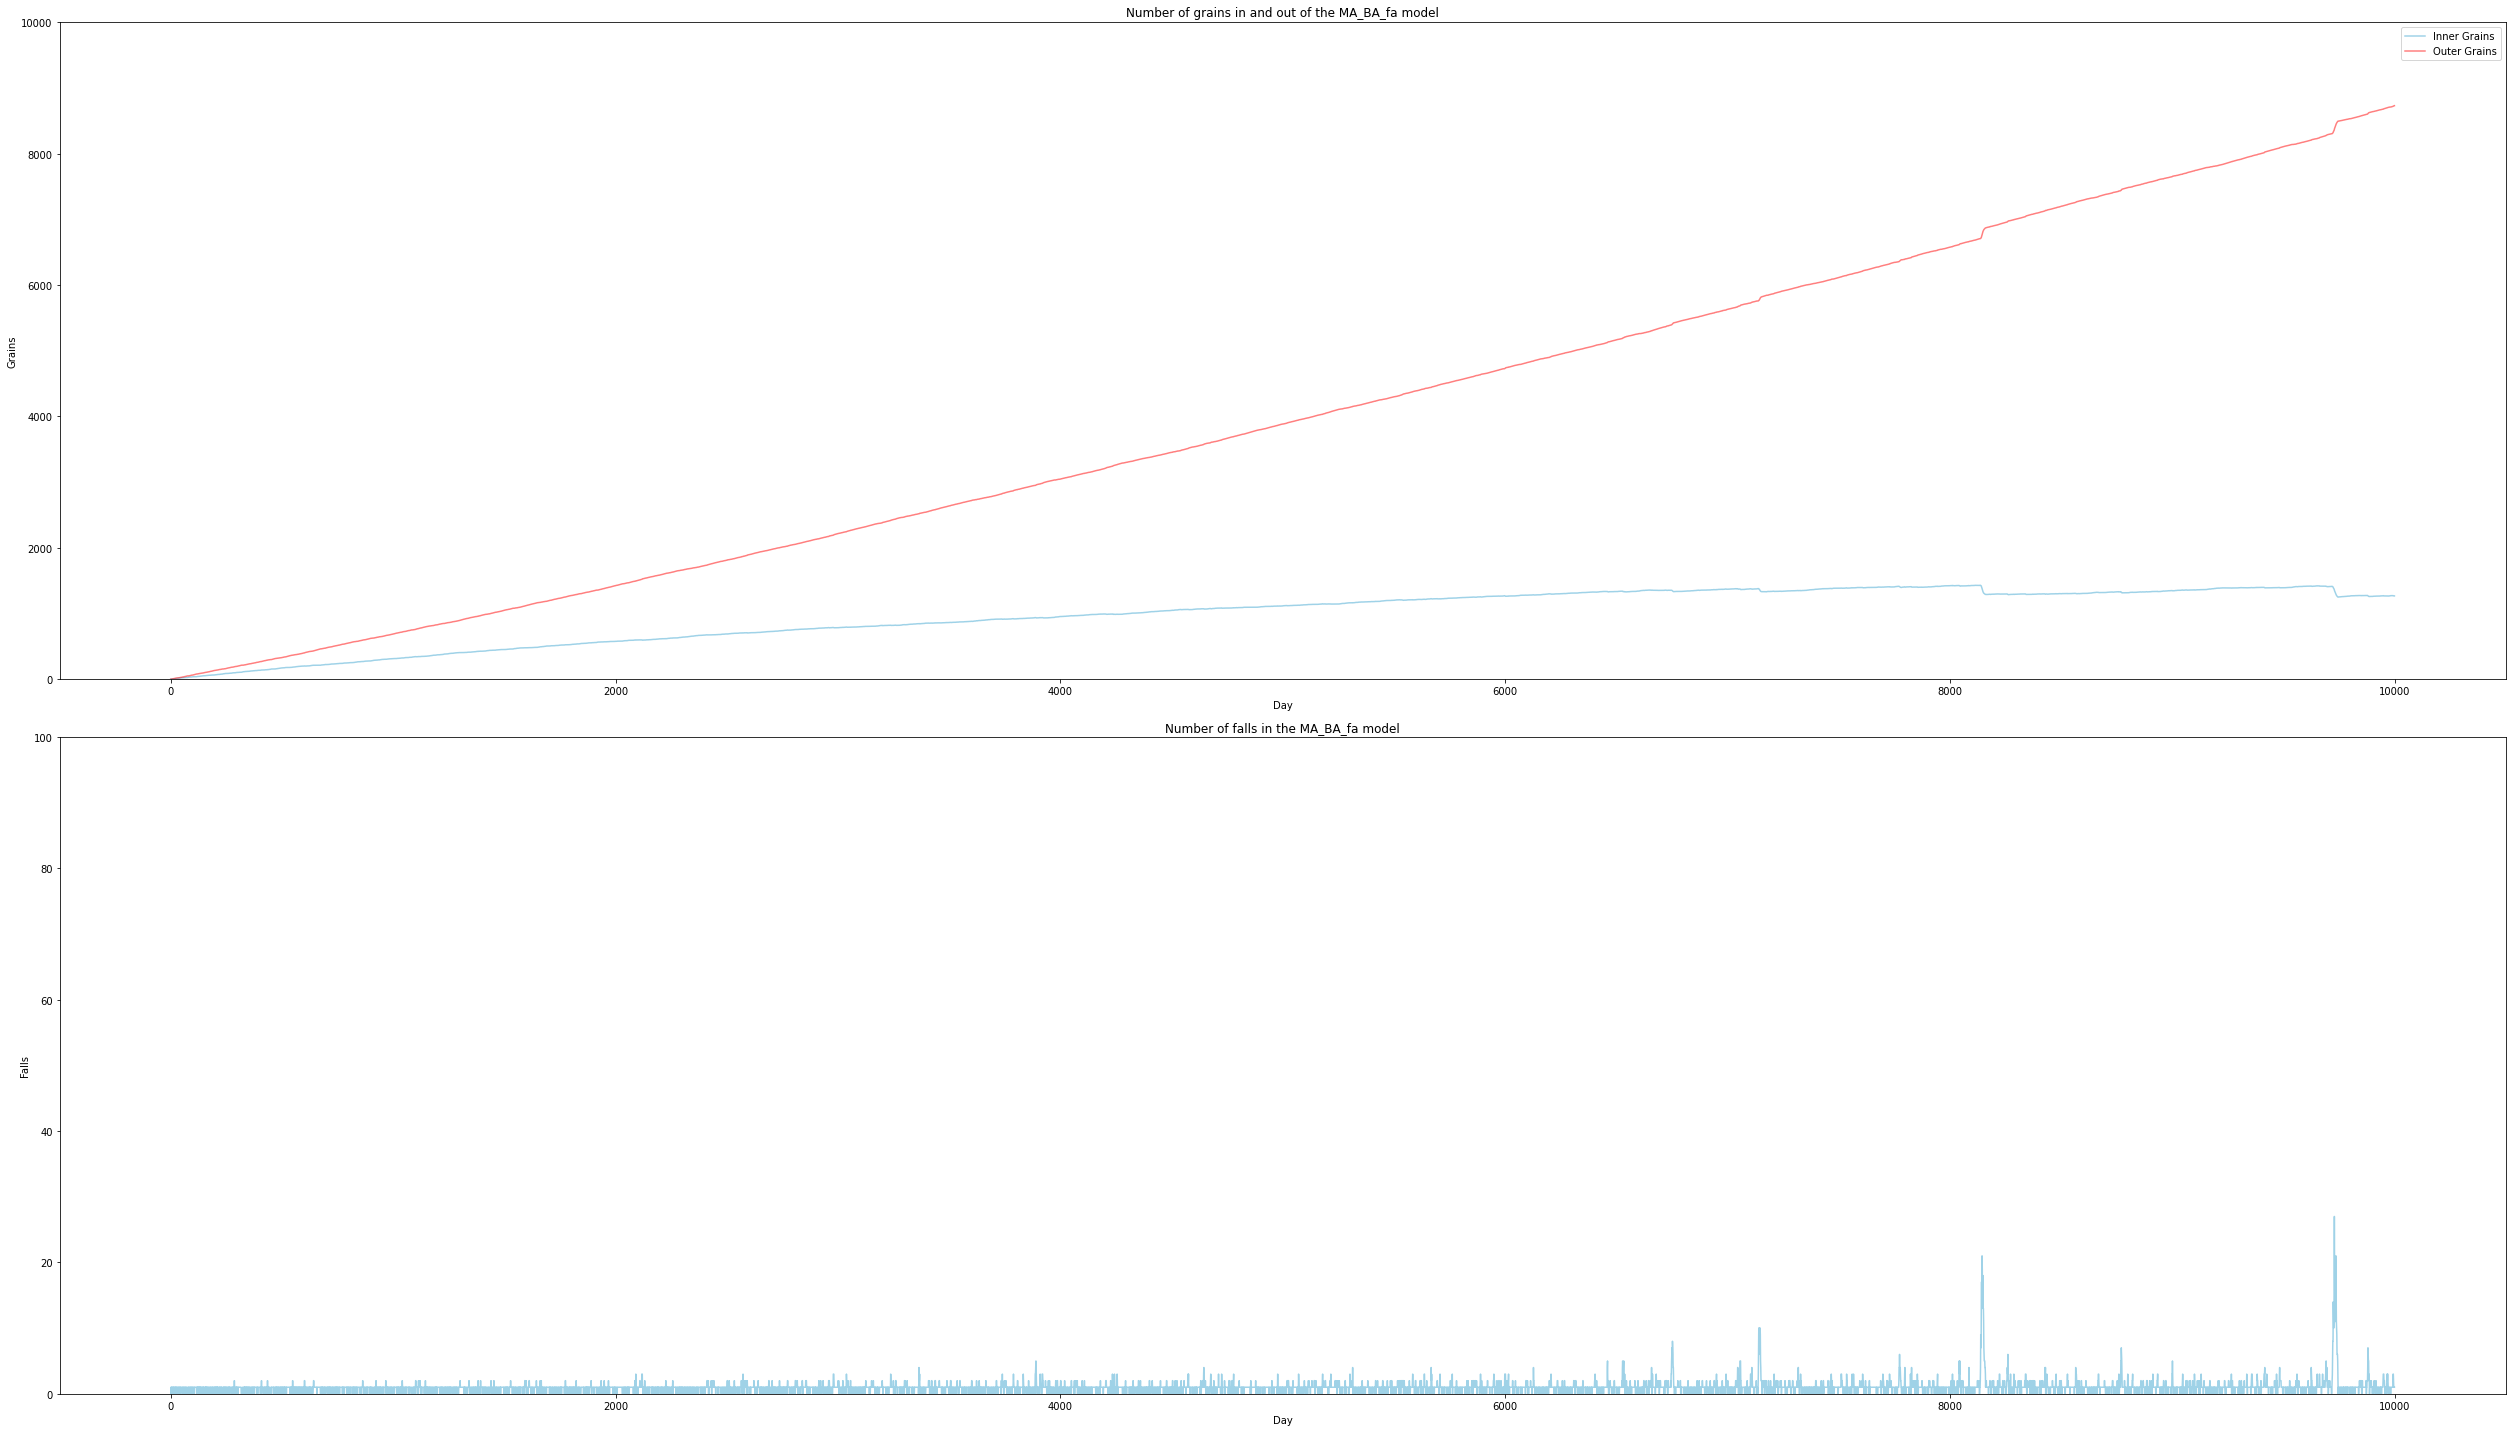

In [38]:
spread("MA", G_BA, number_of_days, new_grains, "BA", facilitated = True)

100%|██████████| 9999/9999 [01:56<00:00, 85.65it/s]


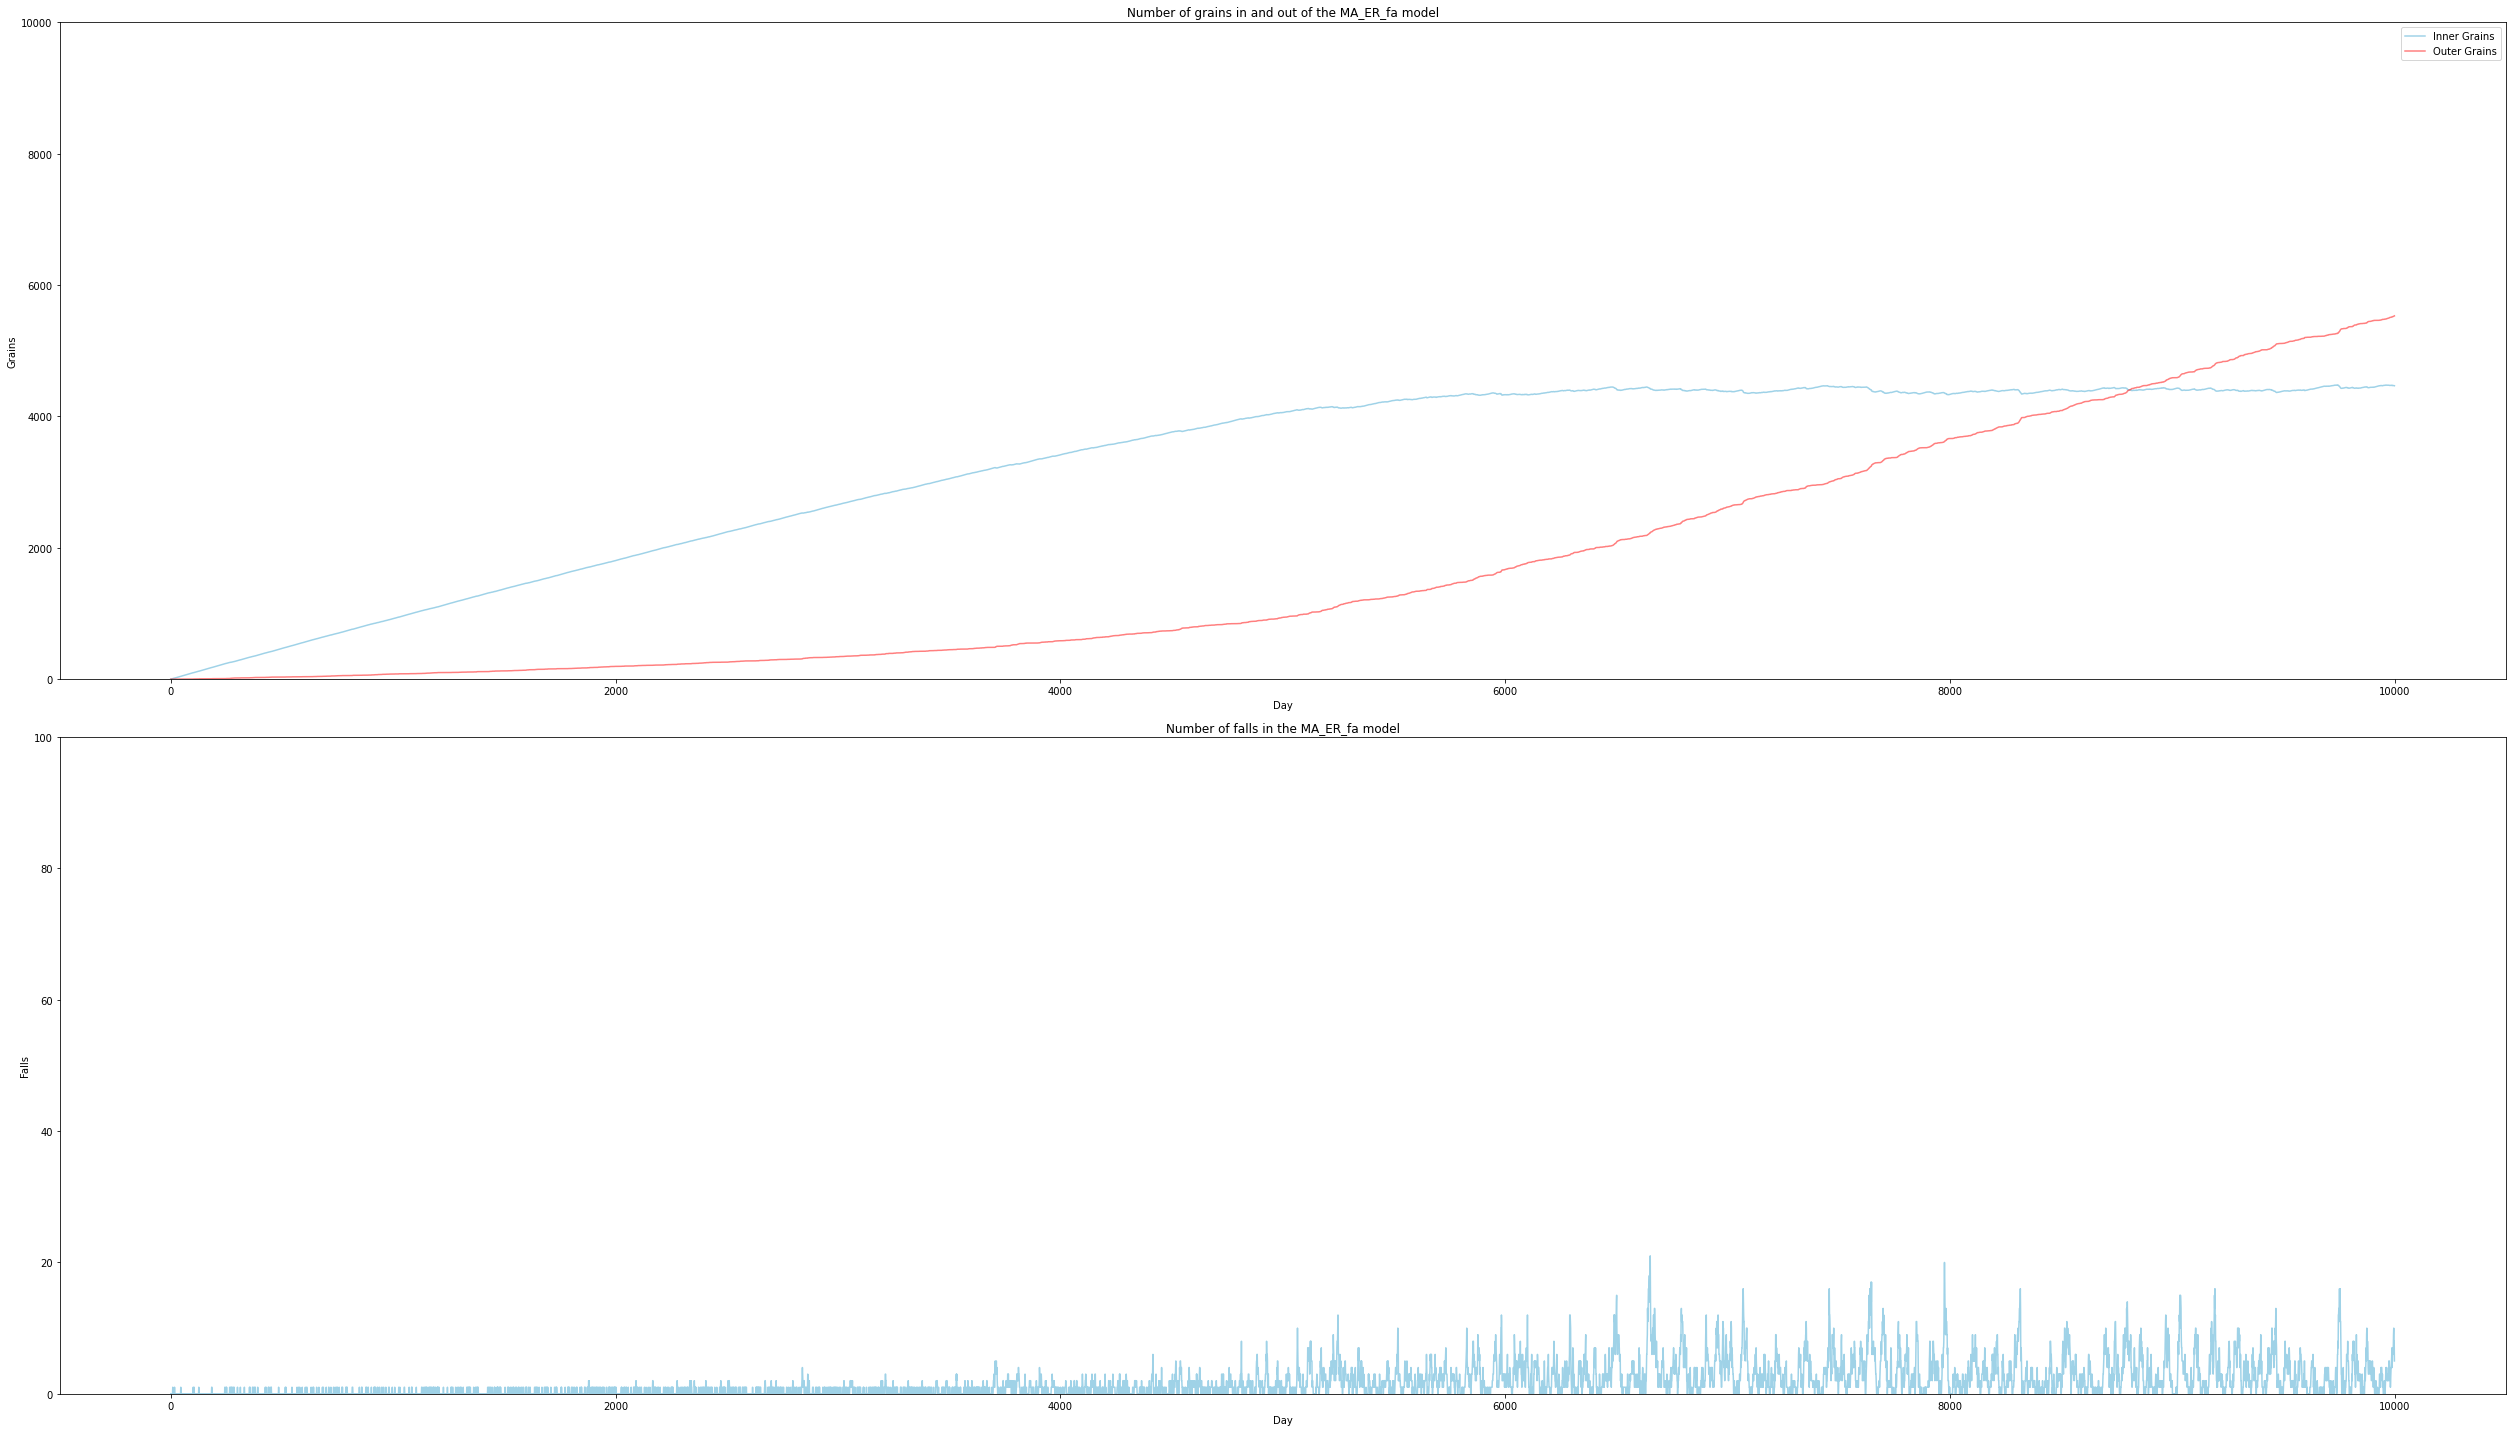

In [39]:
spread("MA", G_ER, number_of_days, new_grains, "ER", facilitated = True)

100%|██████████| 9999/9999 [03:08<00:00, 53.10it/s]


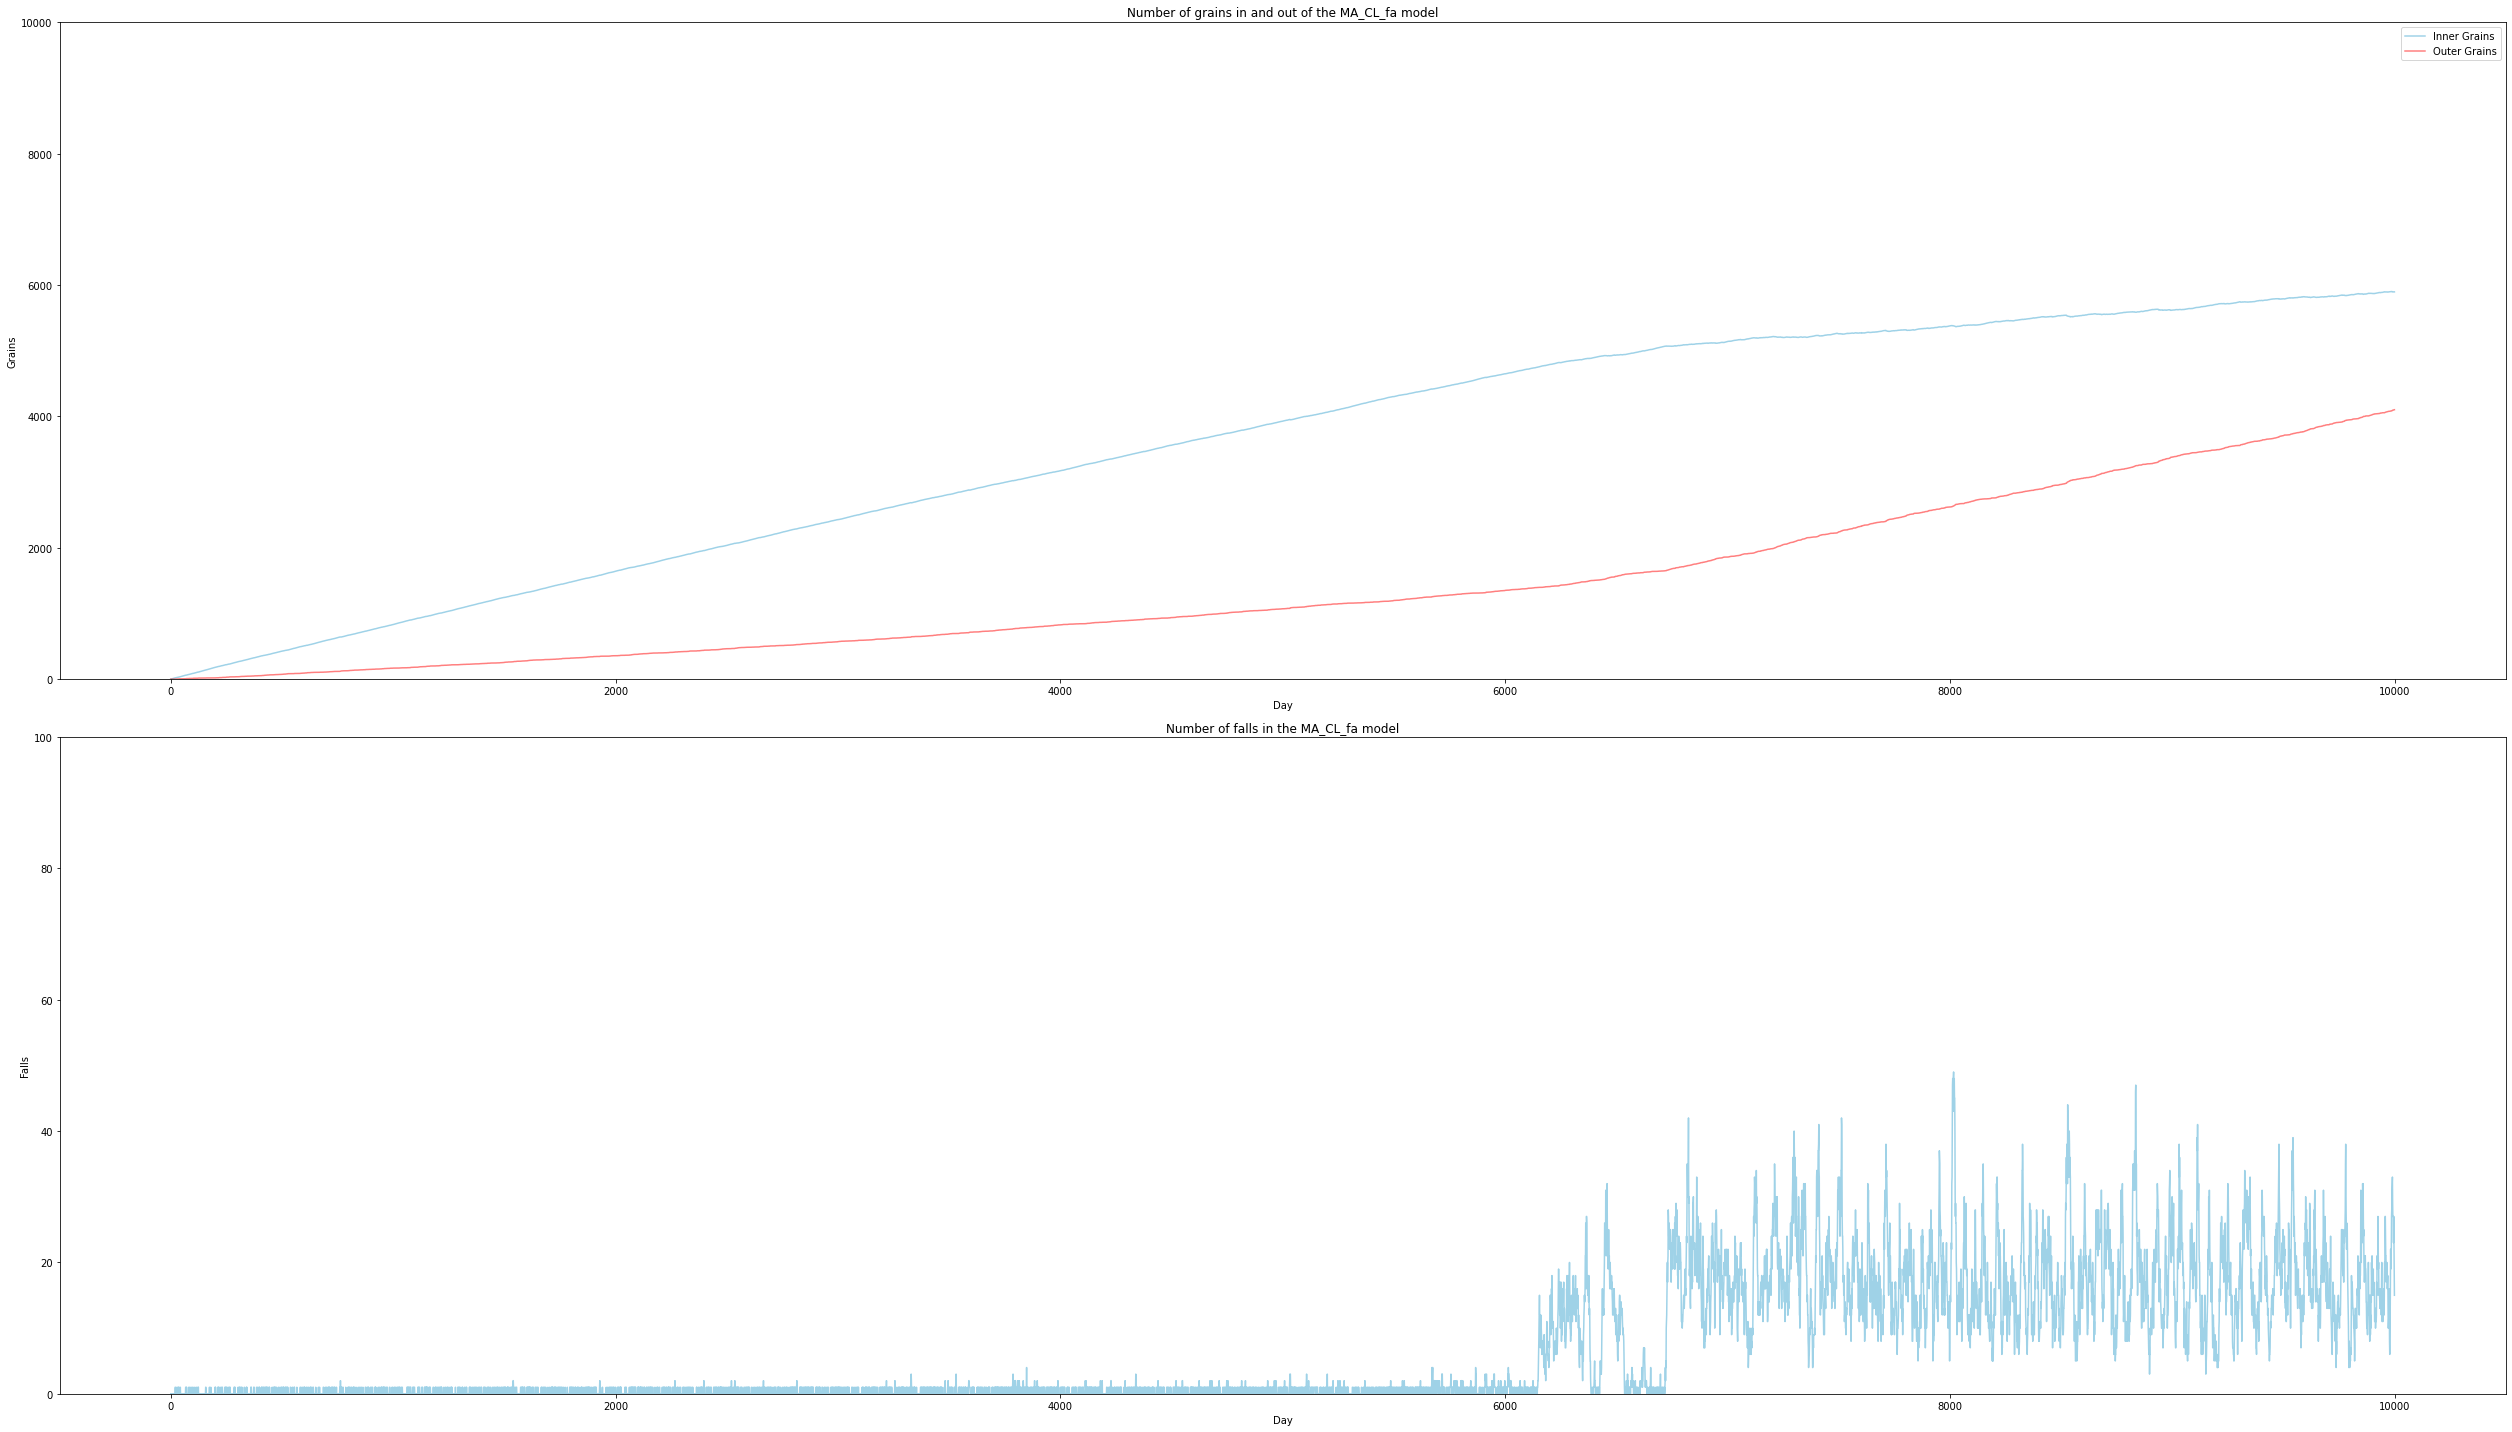

In [40]:
spread("MA", G_CL, number_of_days, new_grains, "CL", facilitated = True)

##### Additional Dissipation

100%|██████████| 9999/9999 [02:29<00:00, 66.88it/s]


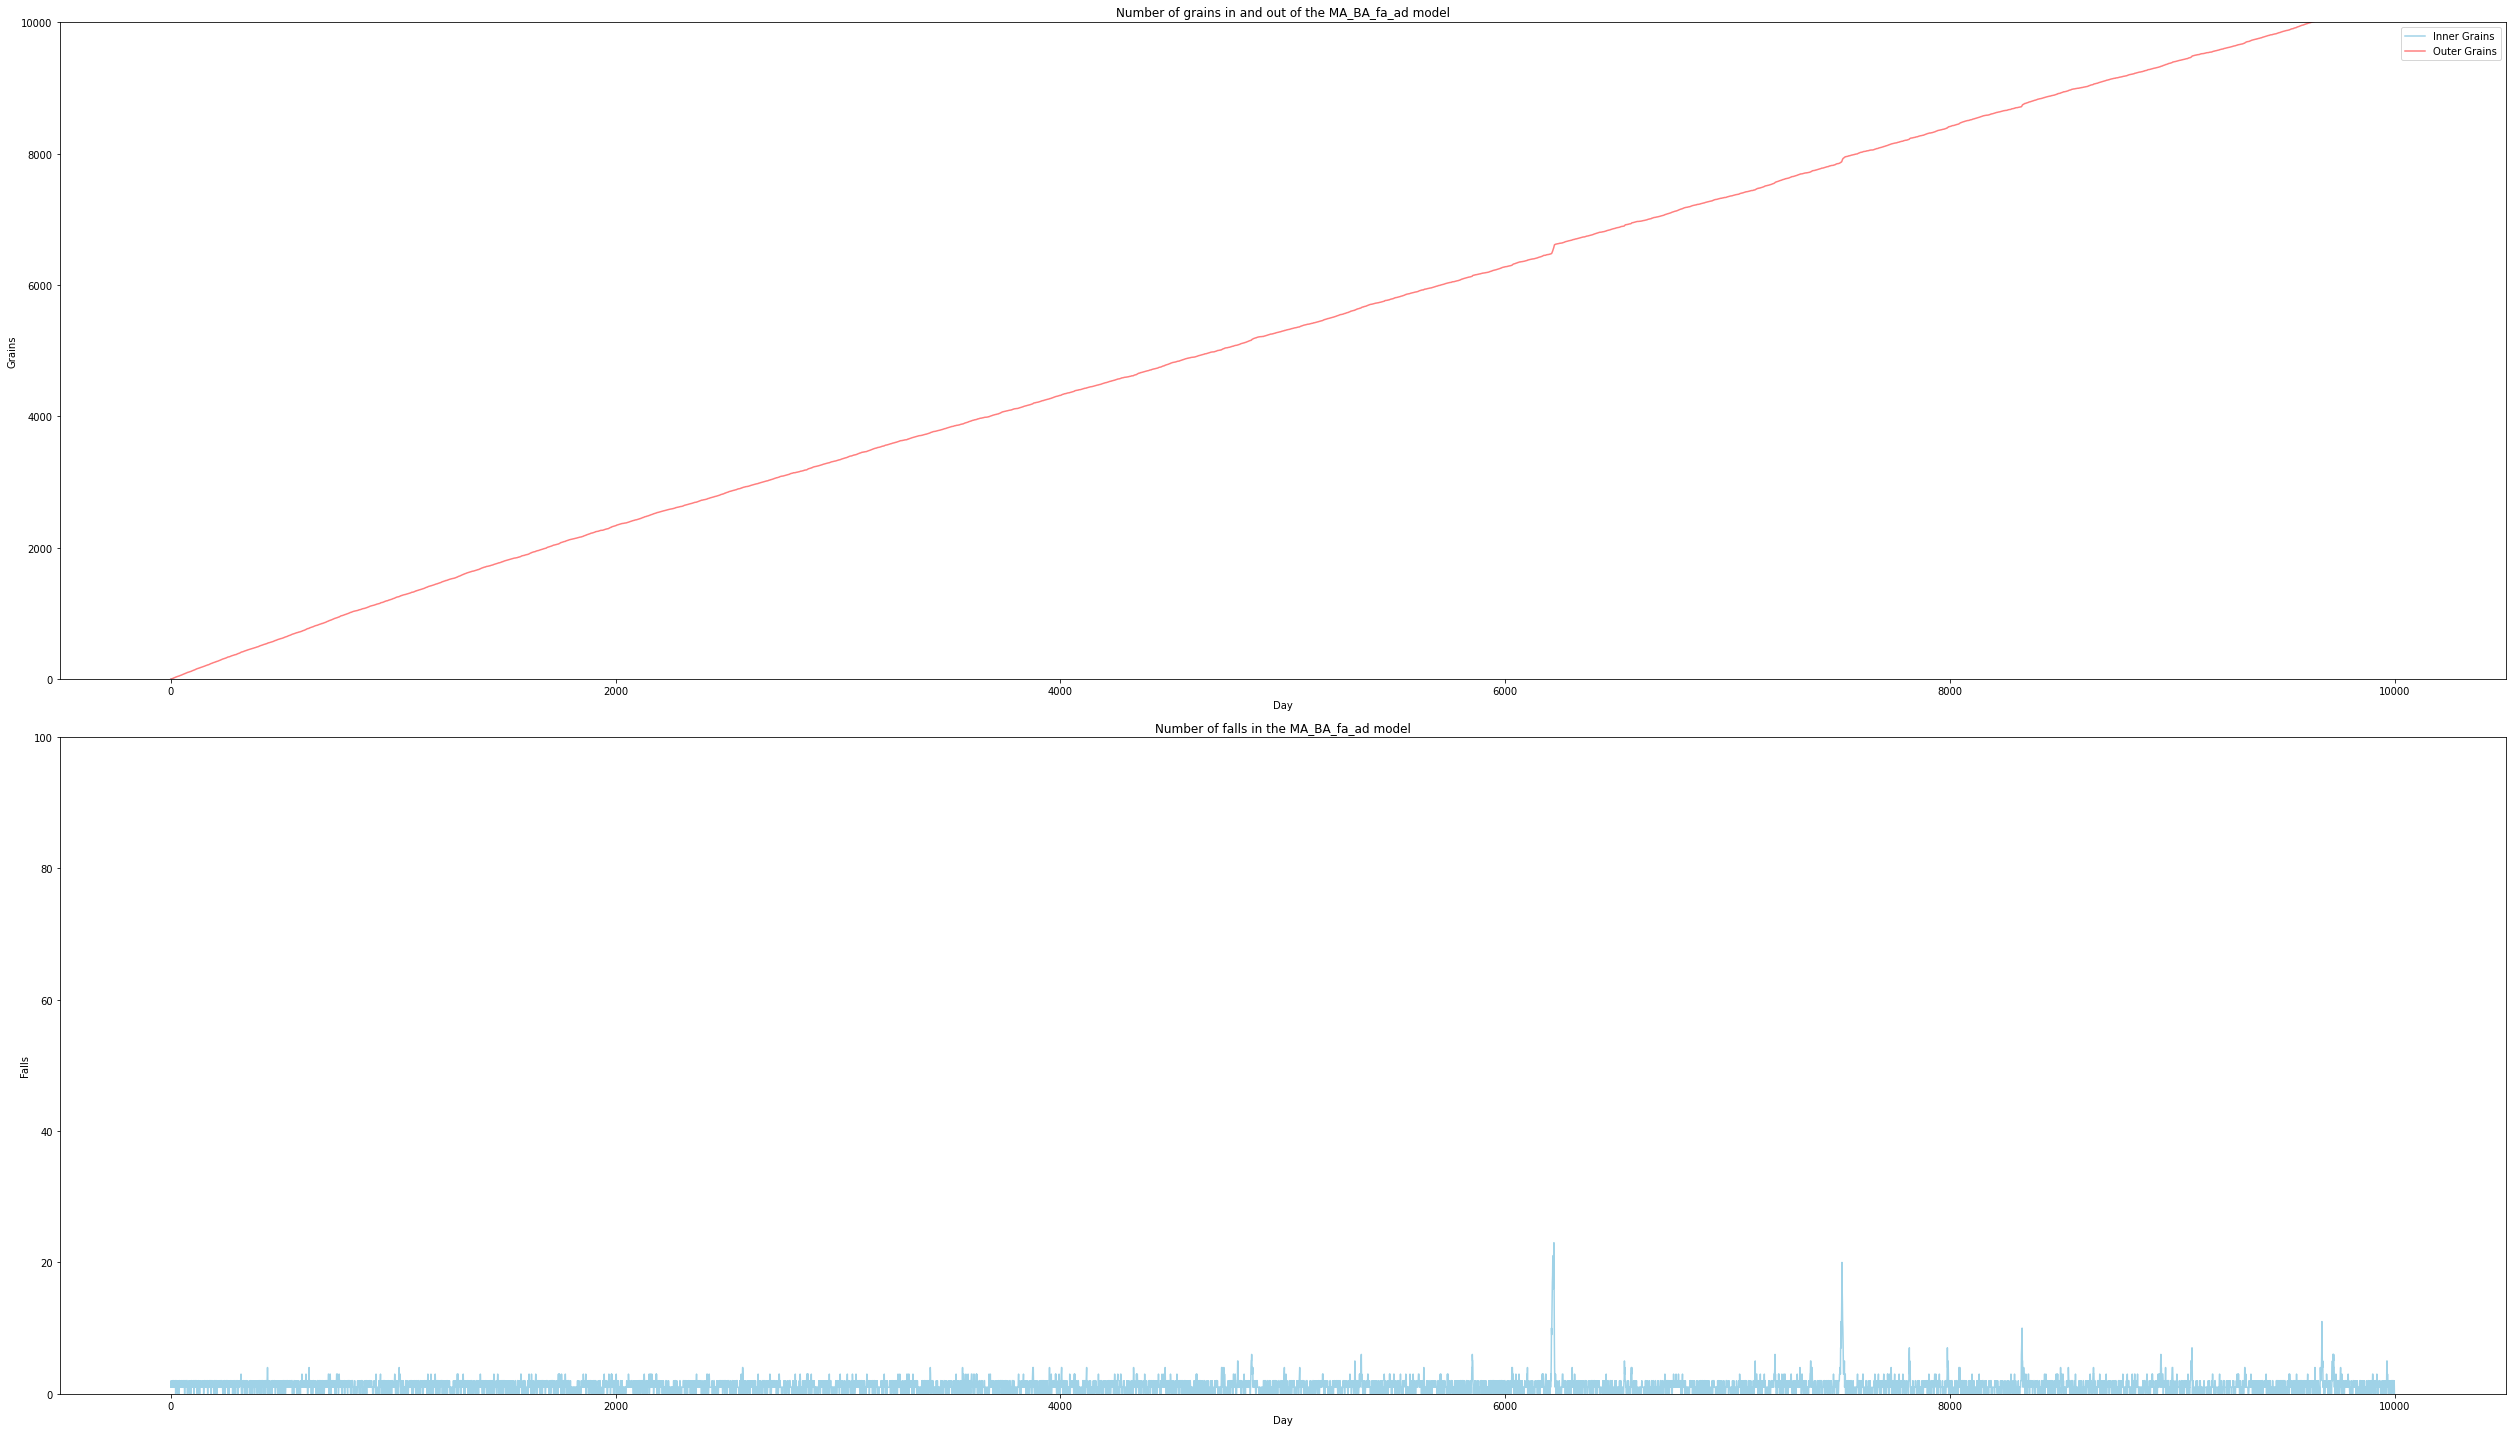

In [41]:
spread("MA", G_BA, number_of_days, new_grains, "BA", facilitated = True, ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

100%|██████████| 9999/9999 [02:07<00:00, 78.17it/s]


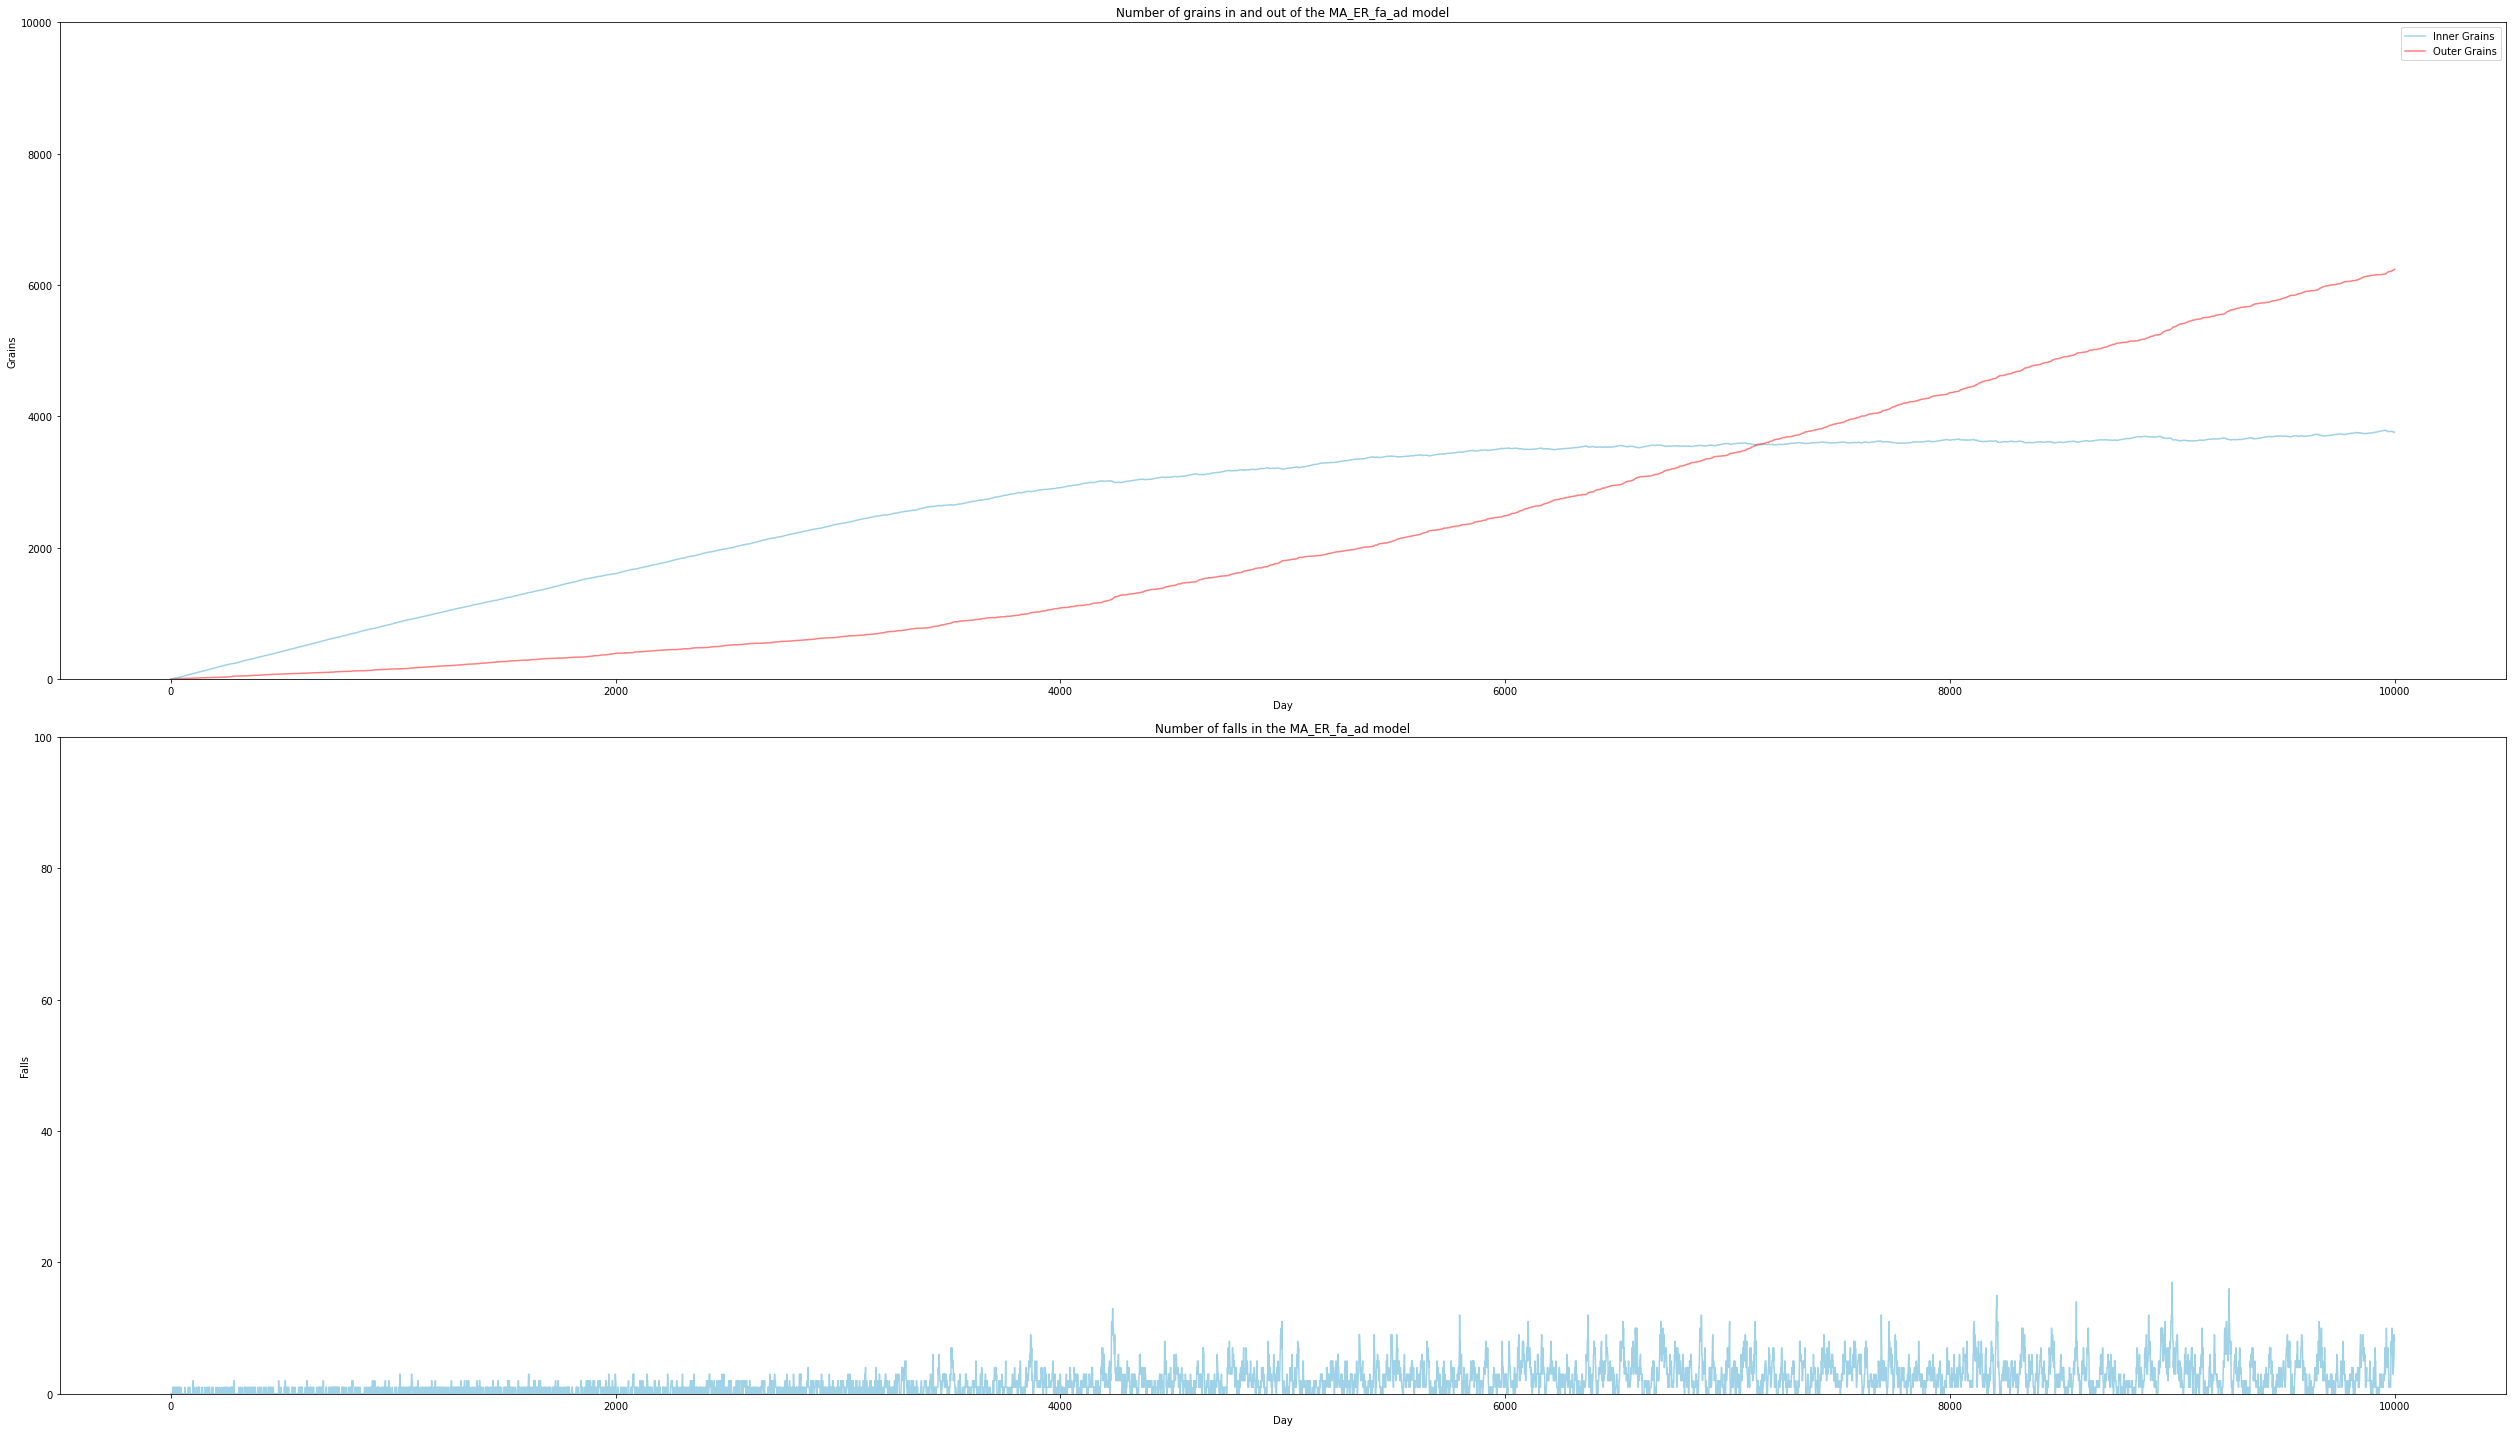

In [42]:
spread("MA", G_ER, number_of_days, new_grains, "ER", facilitated = True, ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

100%|██████████| 9999/9999 [03:24<00:00, 49.01it/s]


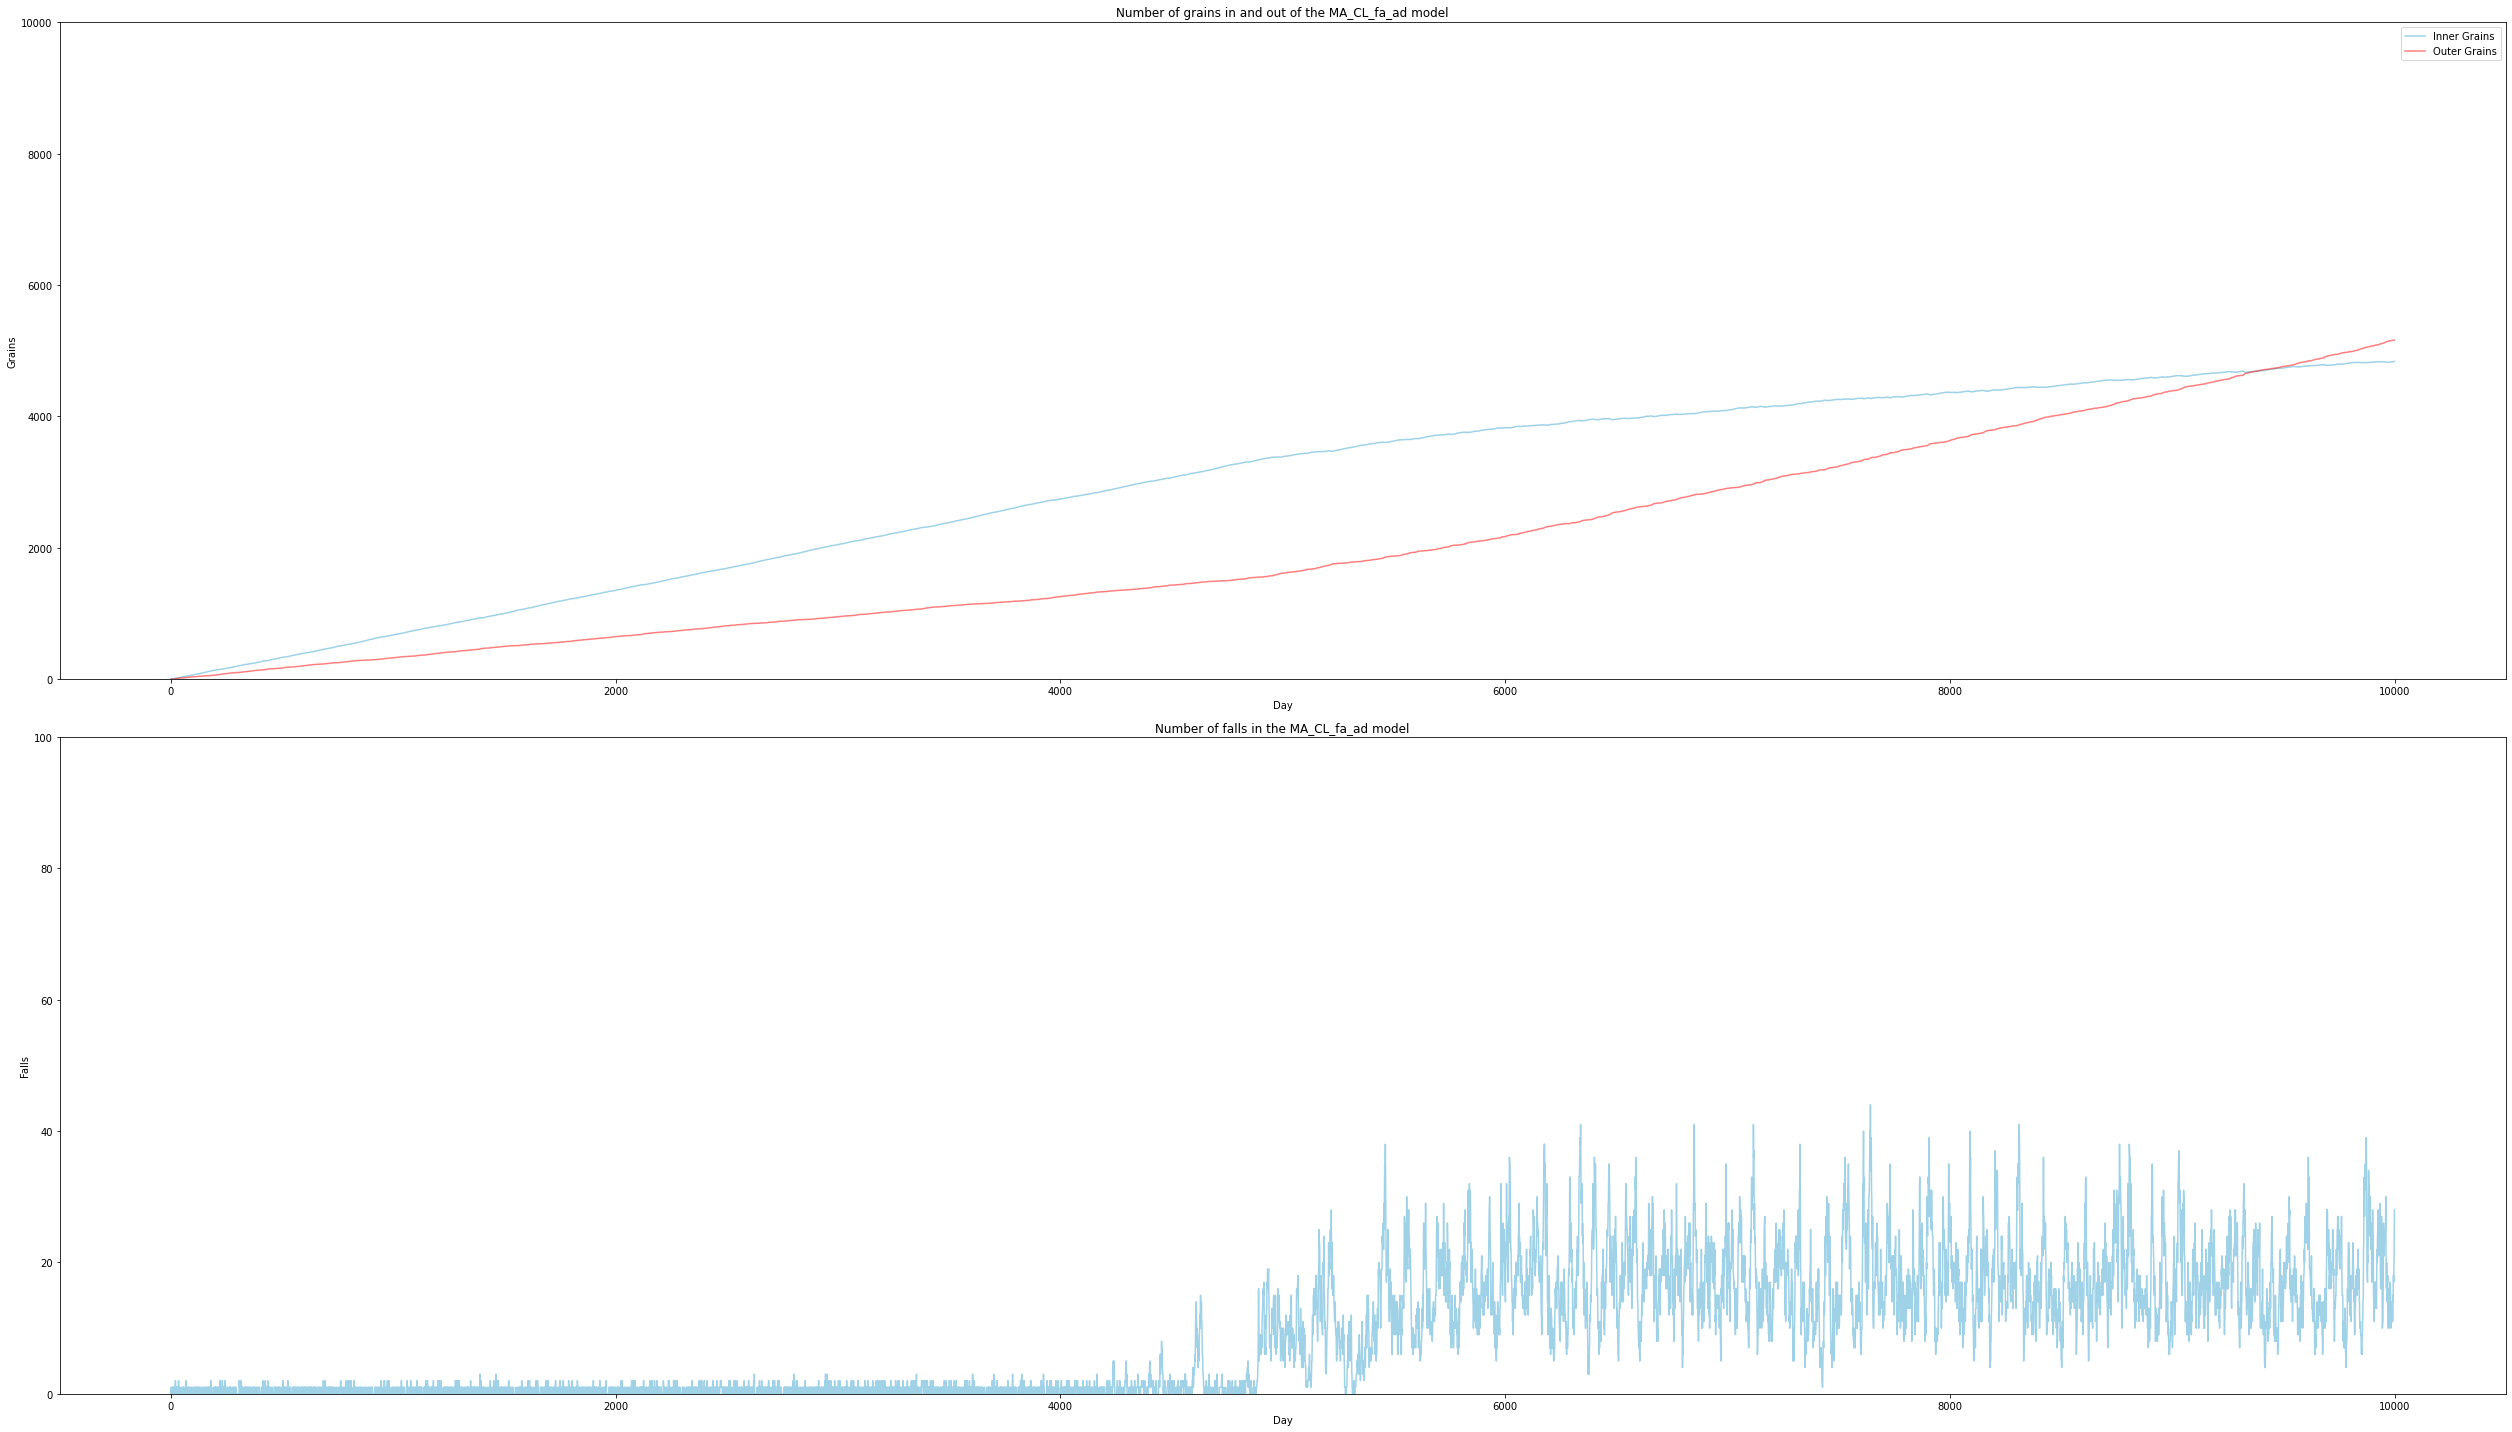

In [43]:
spread("MA", G_CL, number_of_days, new_grains, "CL", facilitated = True, ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

##### Neutral State

100%|██████████| 9999/9999 [01:49<00:00, 91.63it/s]


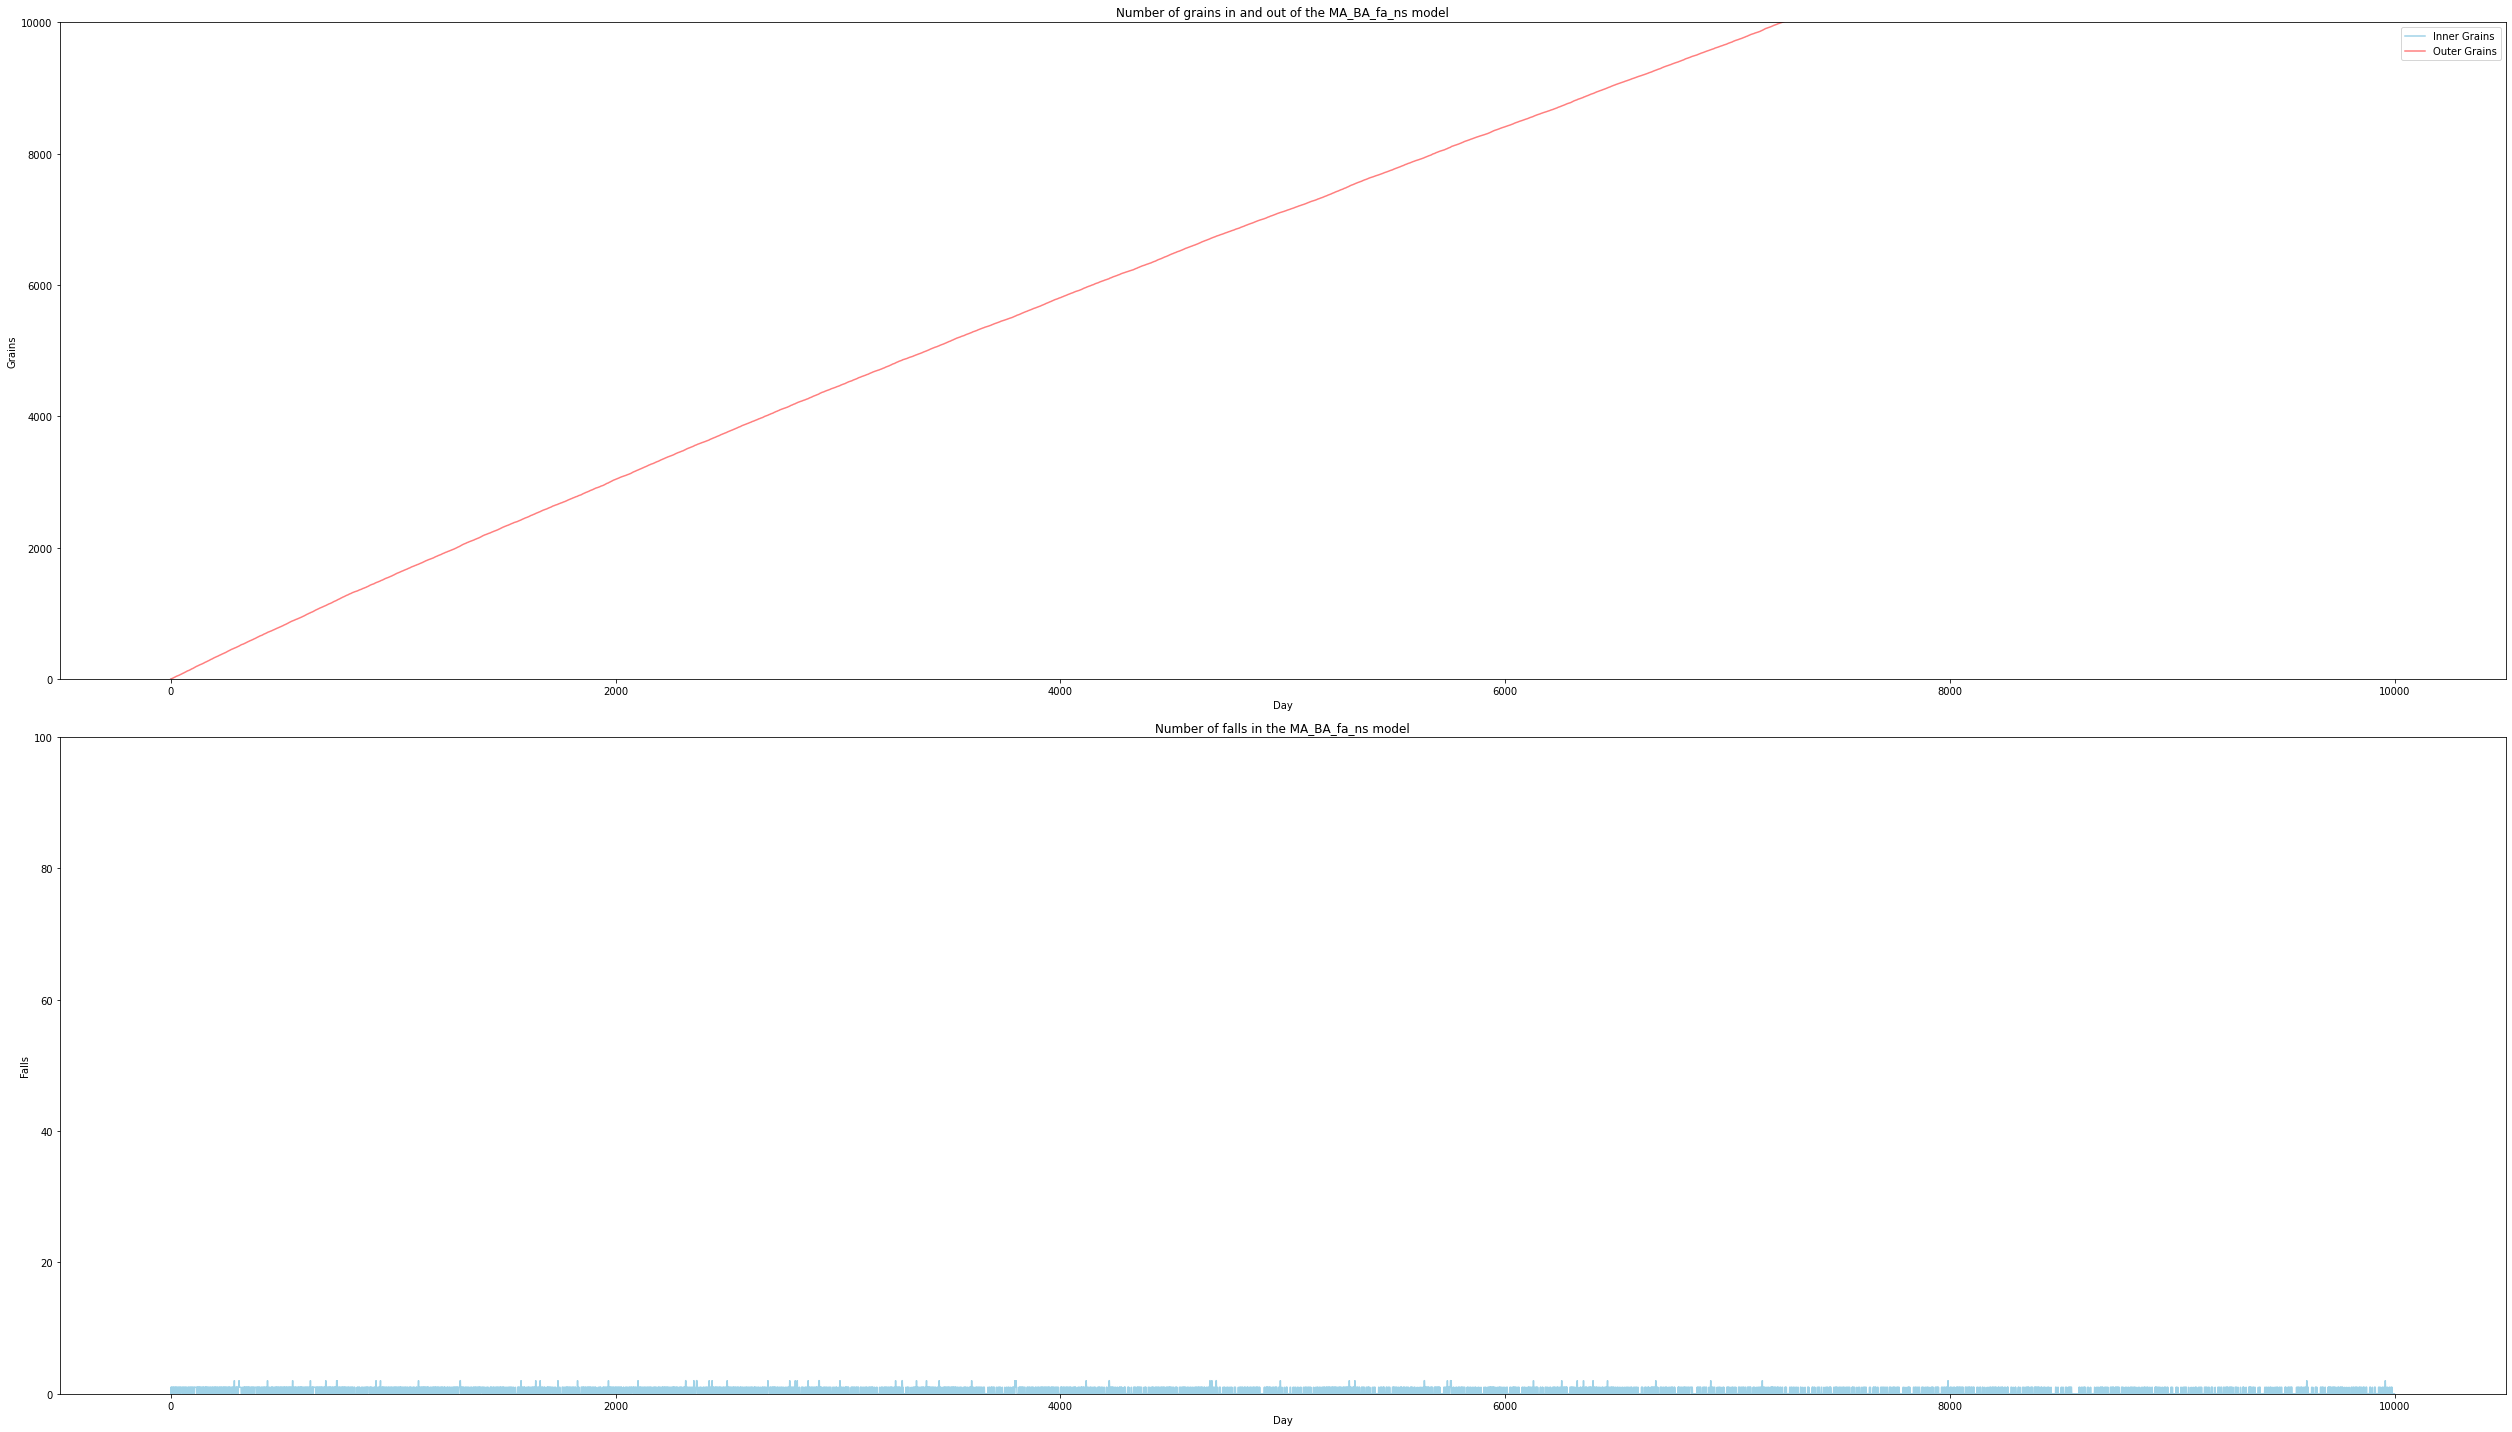

In [85]:
spread("MA", G_BA, number_of_days, new_grains, "BA", facilitated = True, neutral_state = True, new_grains_minus = new_grains_minus)

100%|██████████| 9999/9999 [01:44<00:00, 95.93it/s]


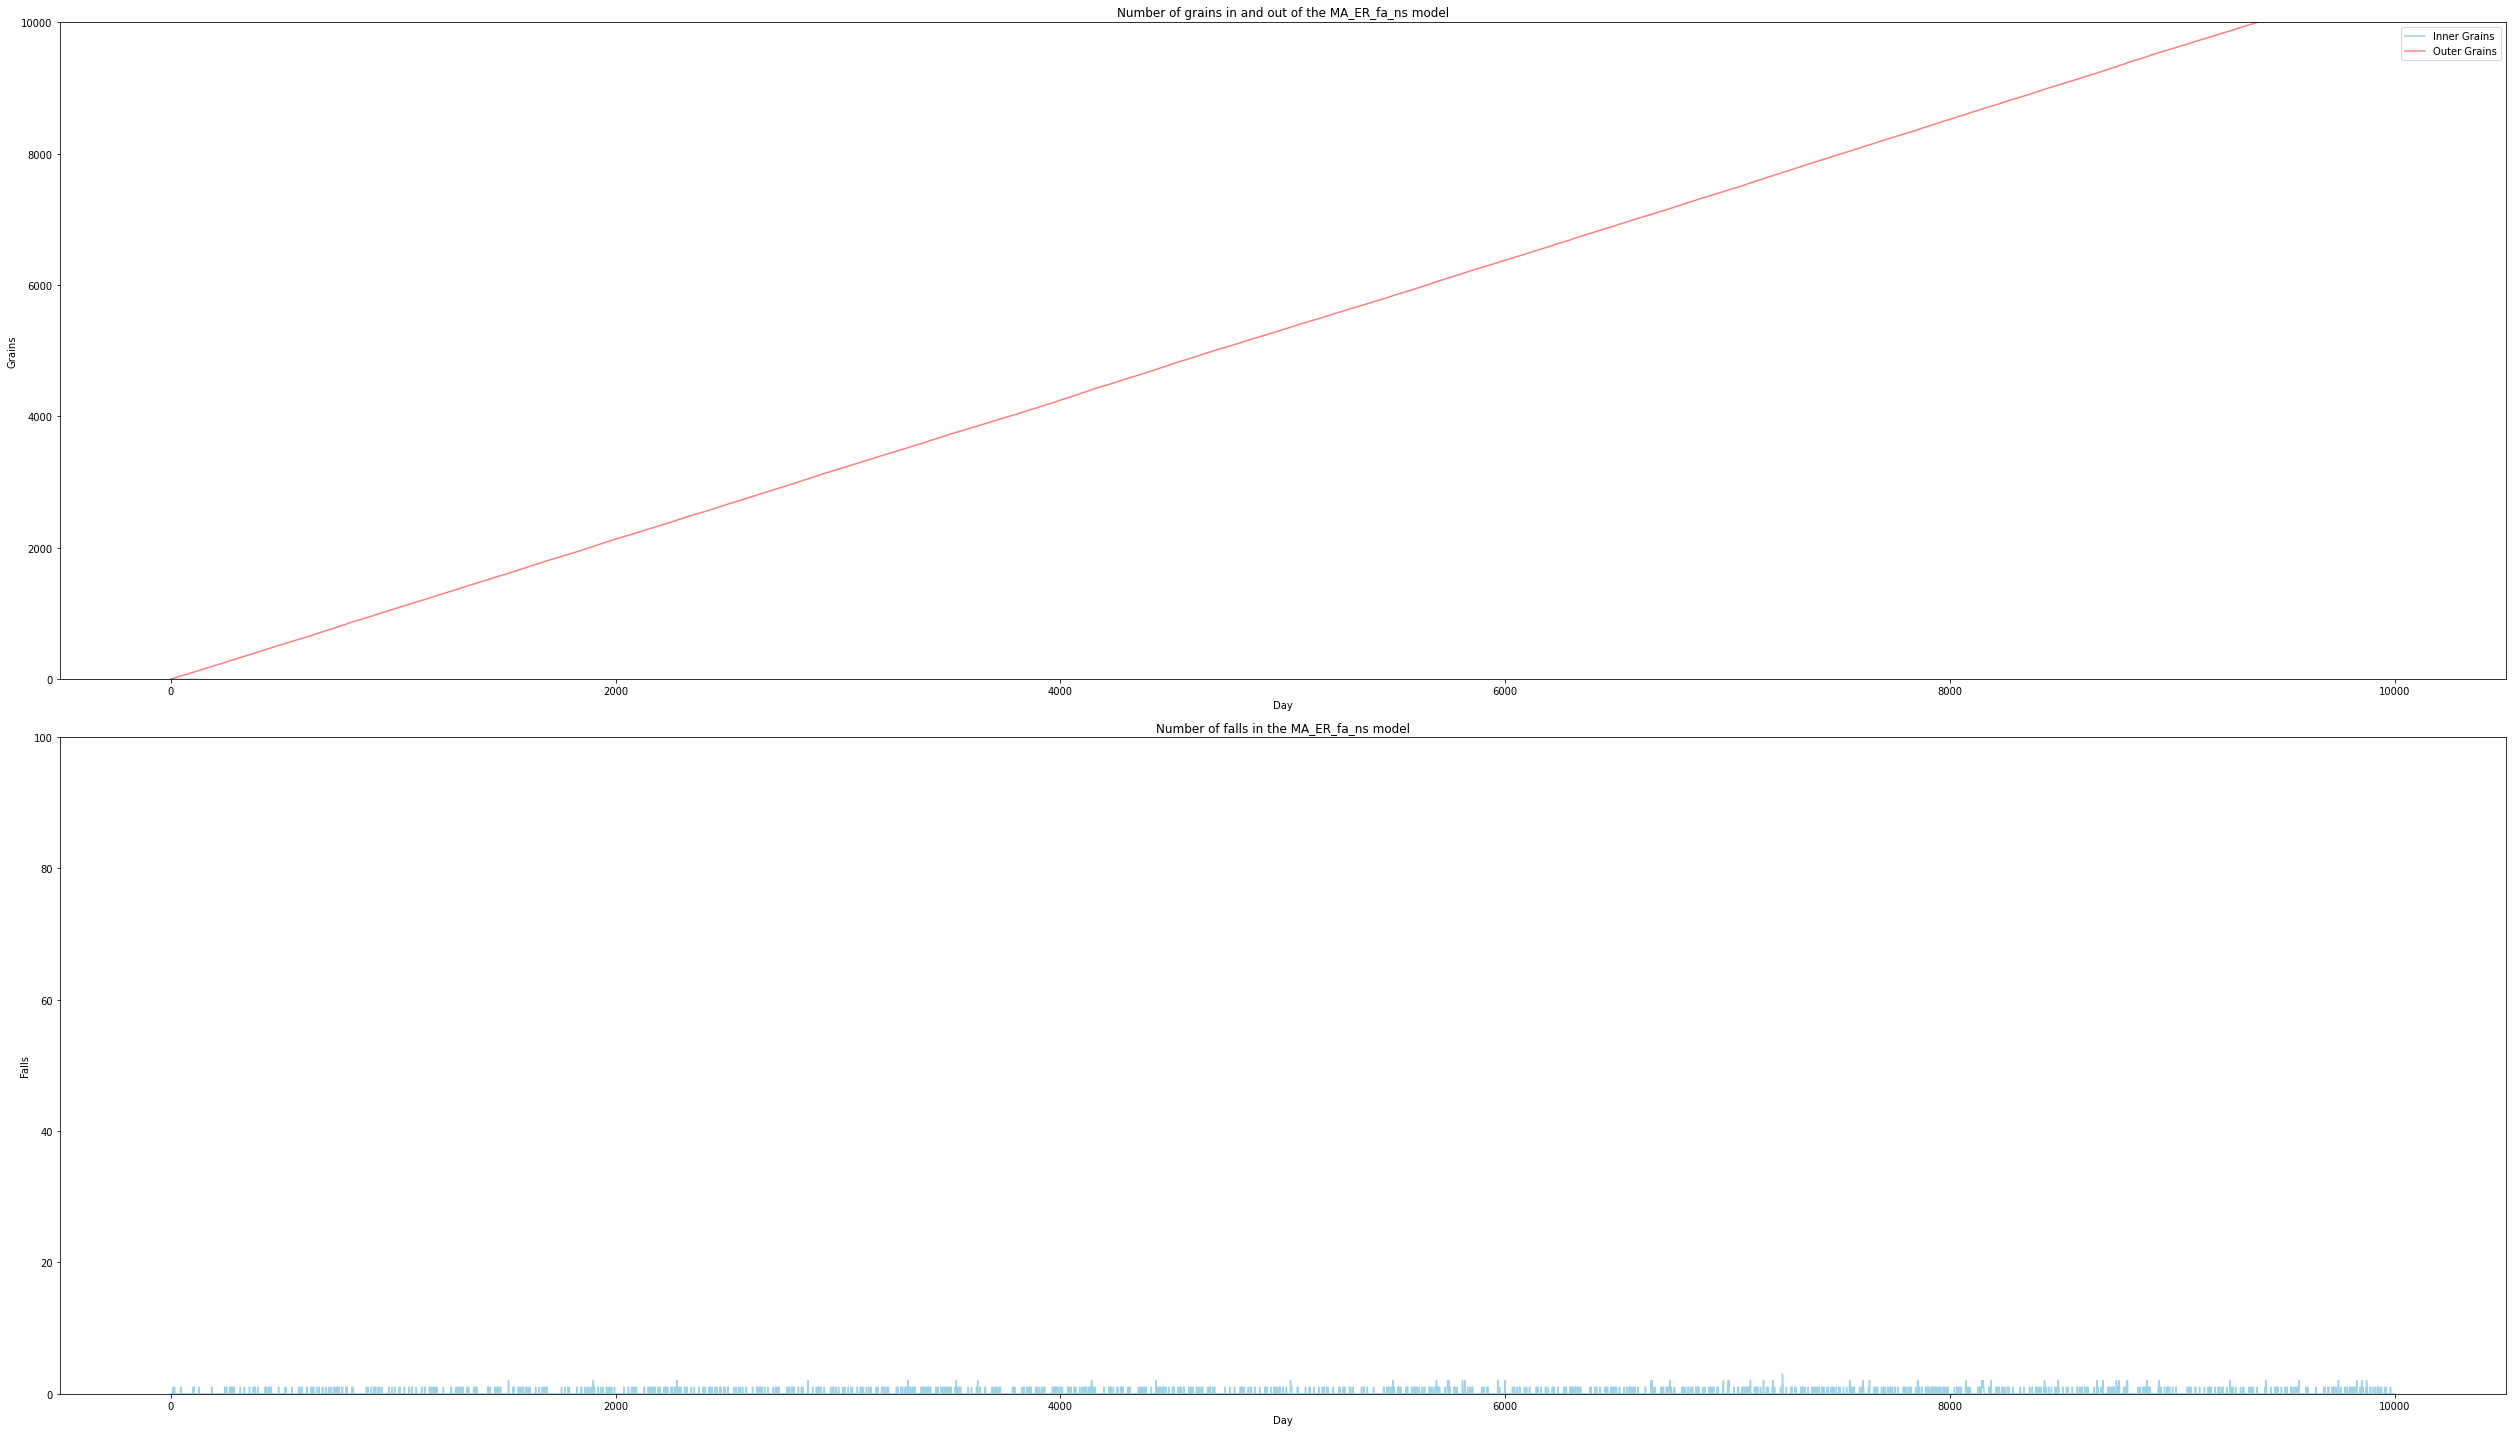

In [86]:
spread("MA", G_ER, number_of_days, new_grains, "ER", facilitated = True, neutral_state = True, new_grains_minus = new_grains_minus)

100%|██████████| 9999/9999 [01:43<00:00, 96.17it/s] 


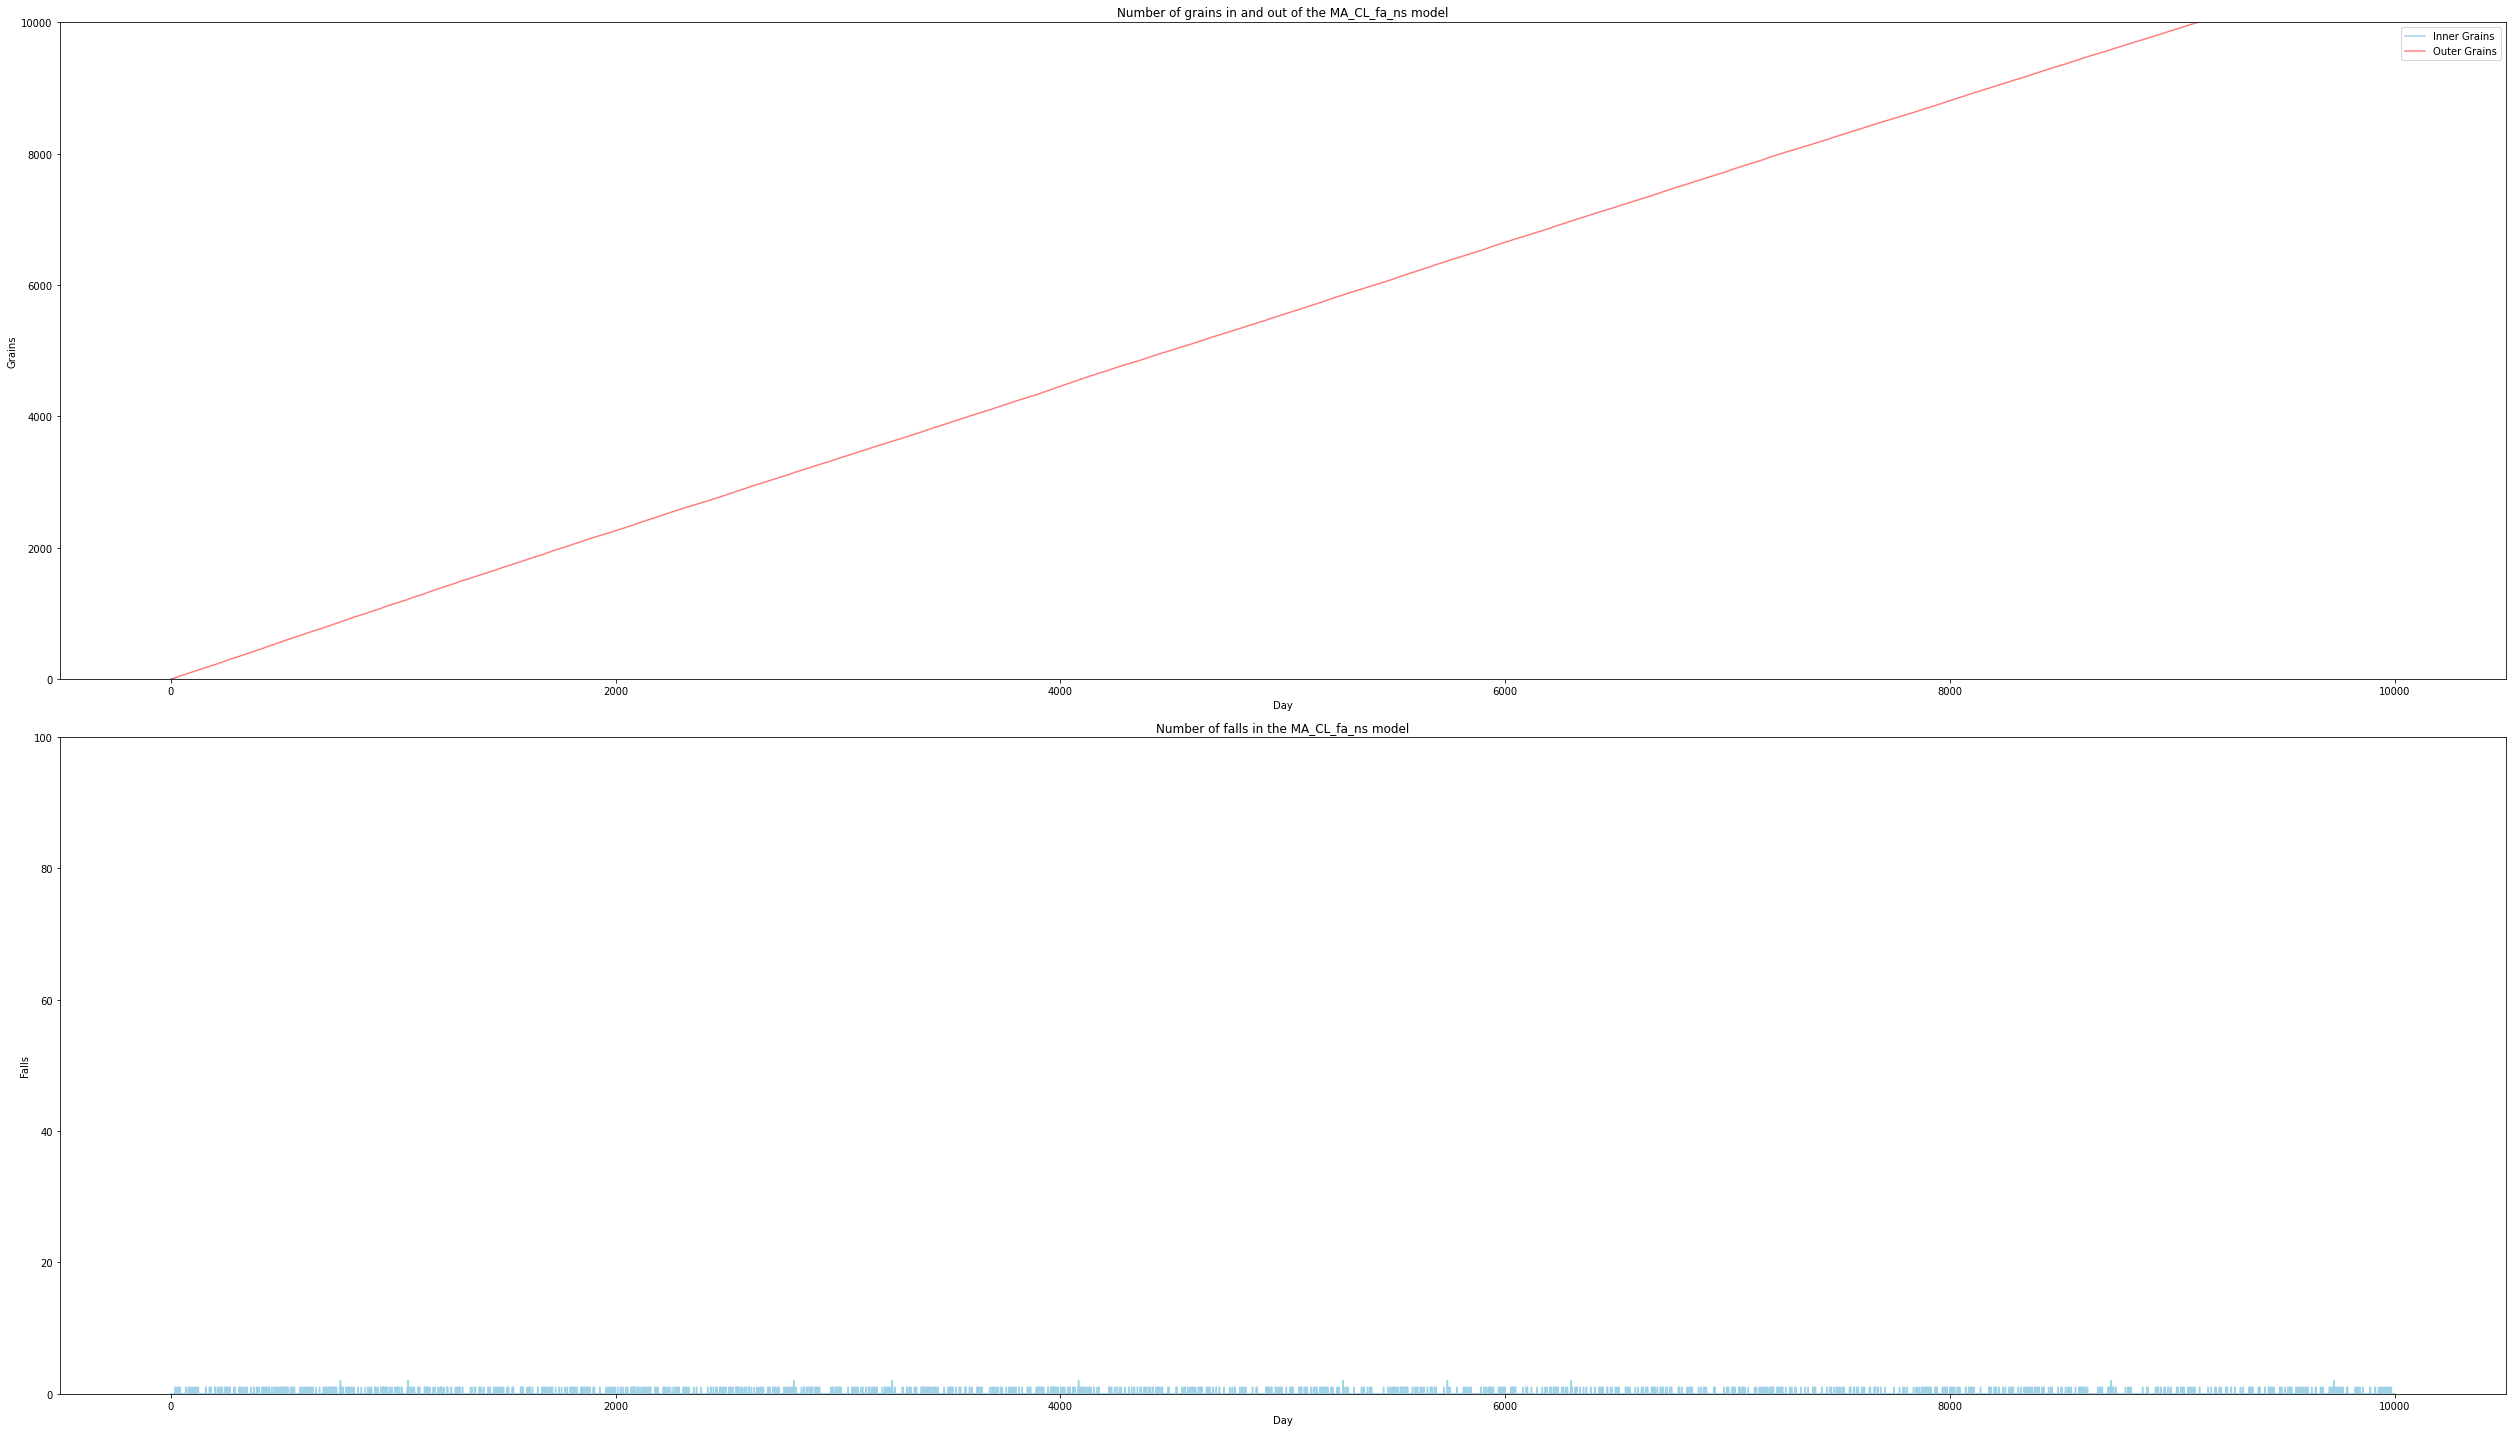

In [87]:
spread("MA", G_CL, number_of_days, new_grains, "CL", facilitated = True, neutral_state = True, new_grains_minus = new_grains_minus)

### Feder

#### Standart Model

##### Standart Dissipation

100%|██████████| 9999/9999 [01:51<00:00, 90.01it/s]


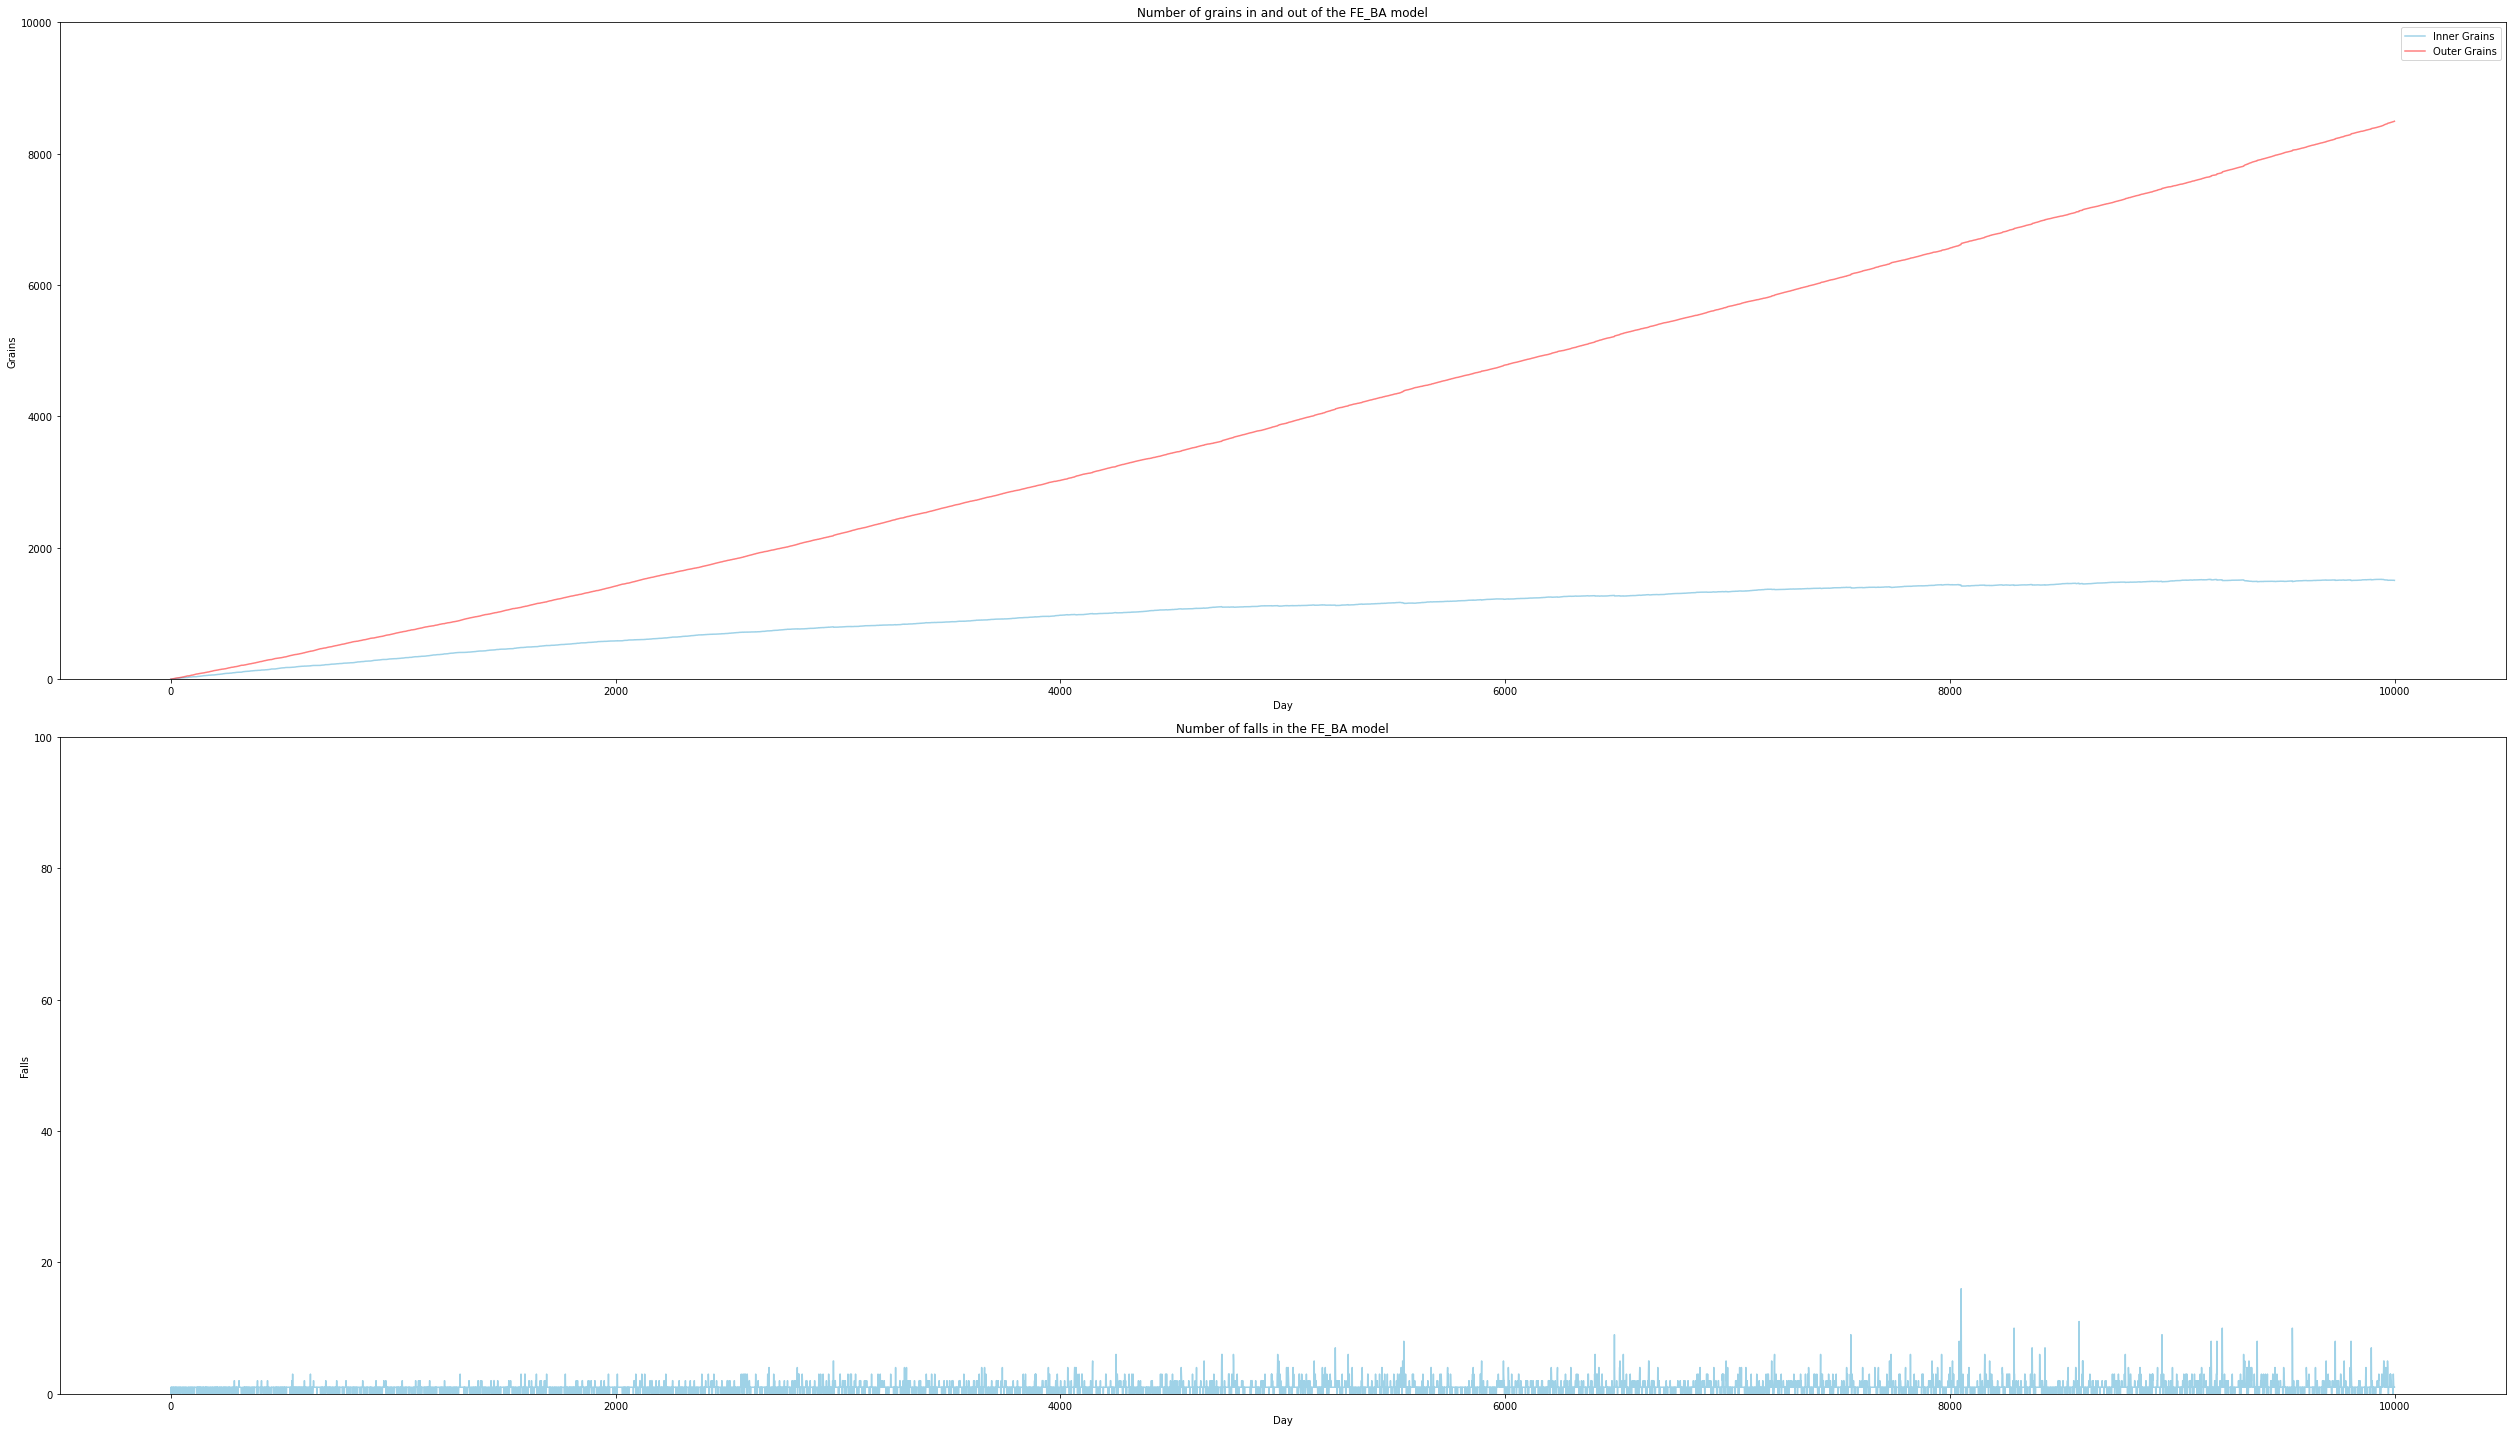

In [44]:
spread("FE", G_BA, number_of_days, new_grains, "BA")

100%|██████████| 9999/9999 [02:05<00:00, 79.74it/s]


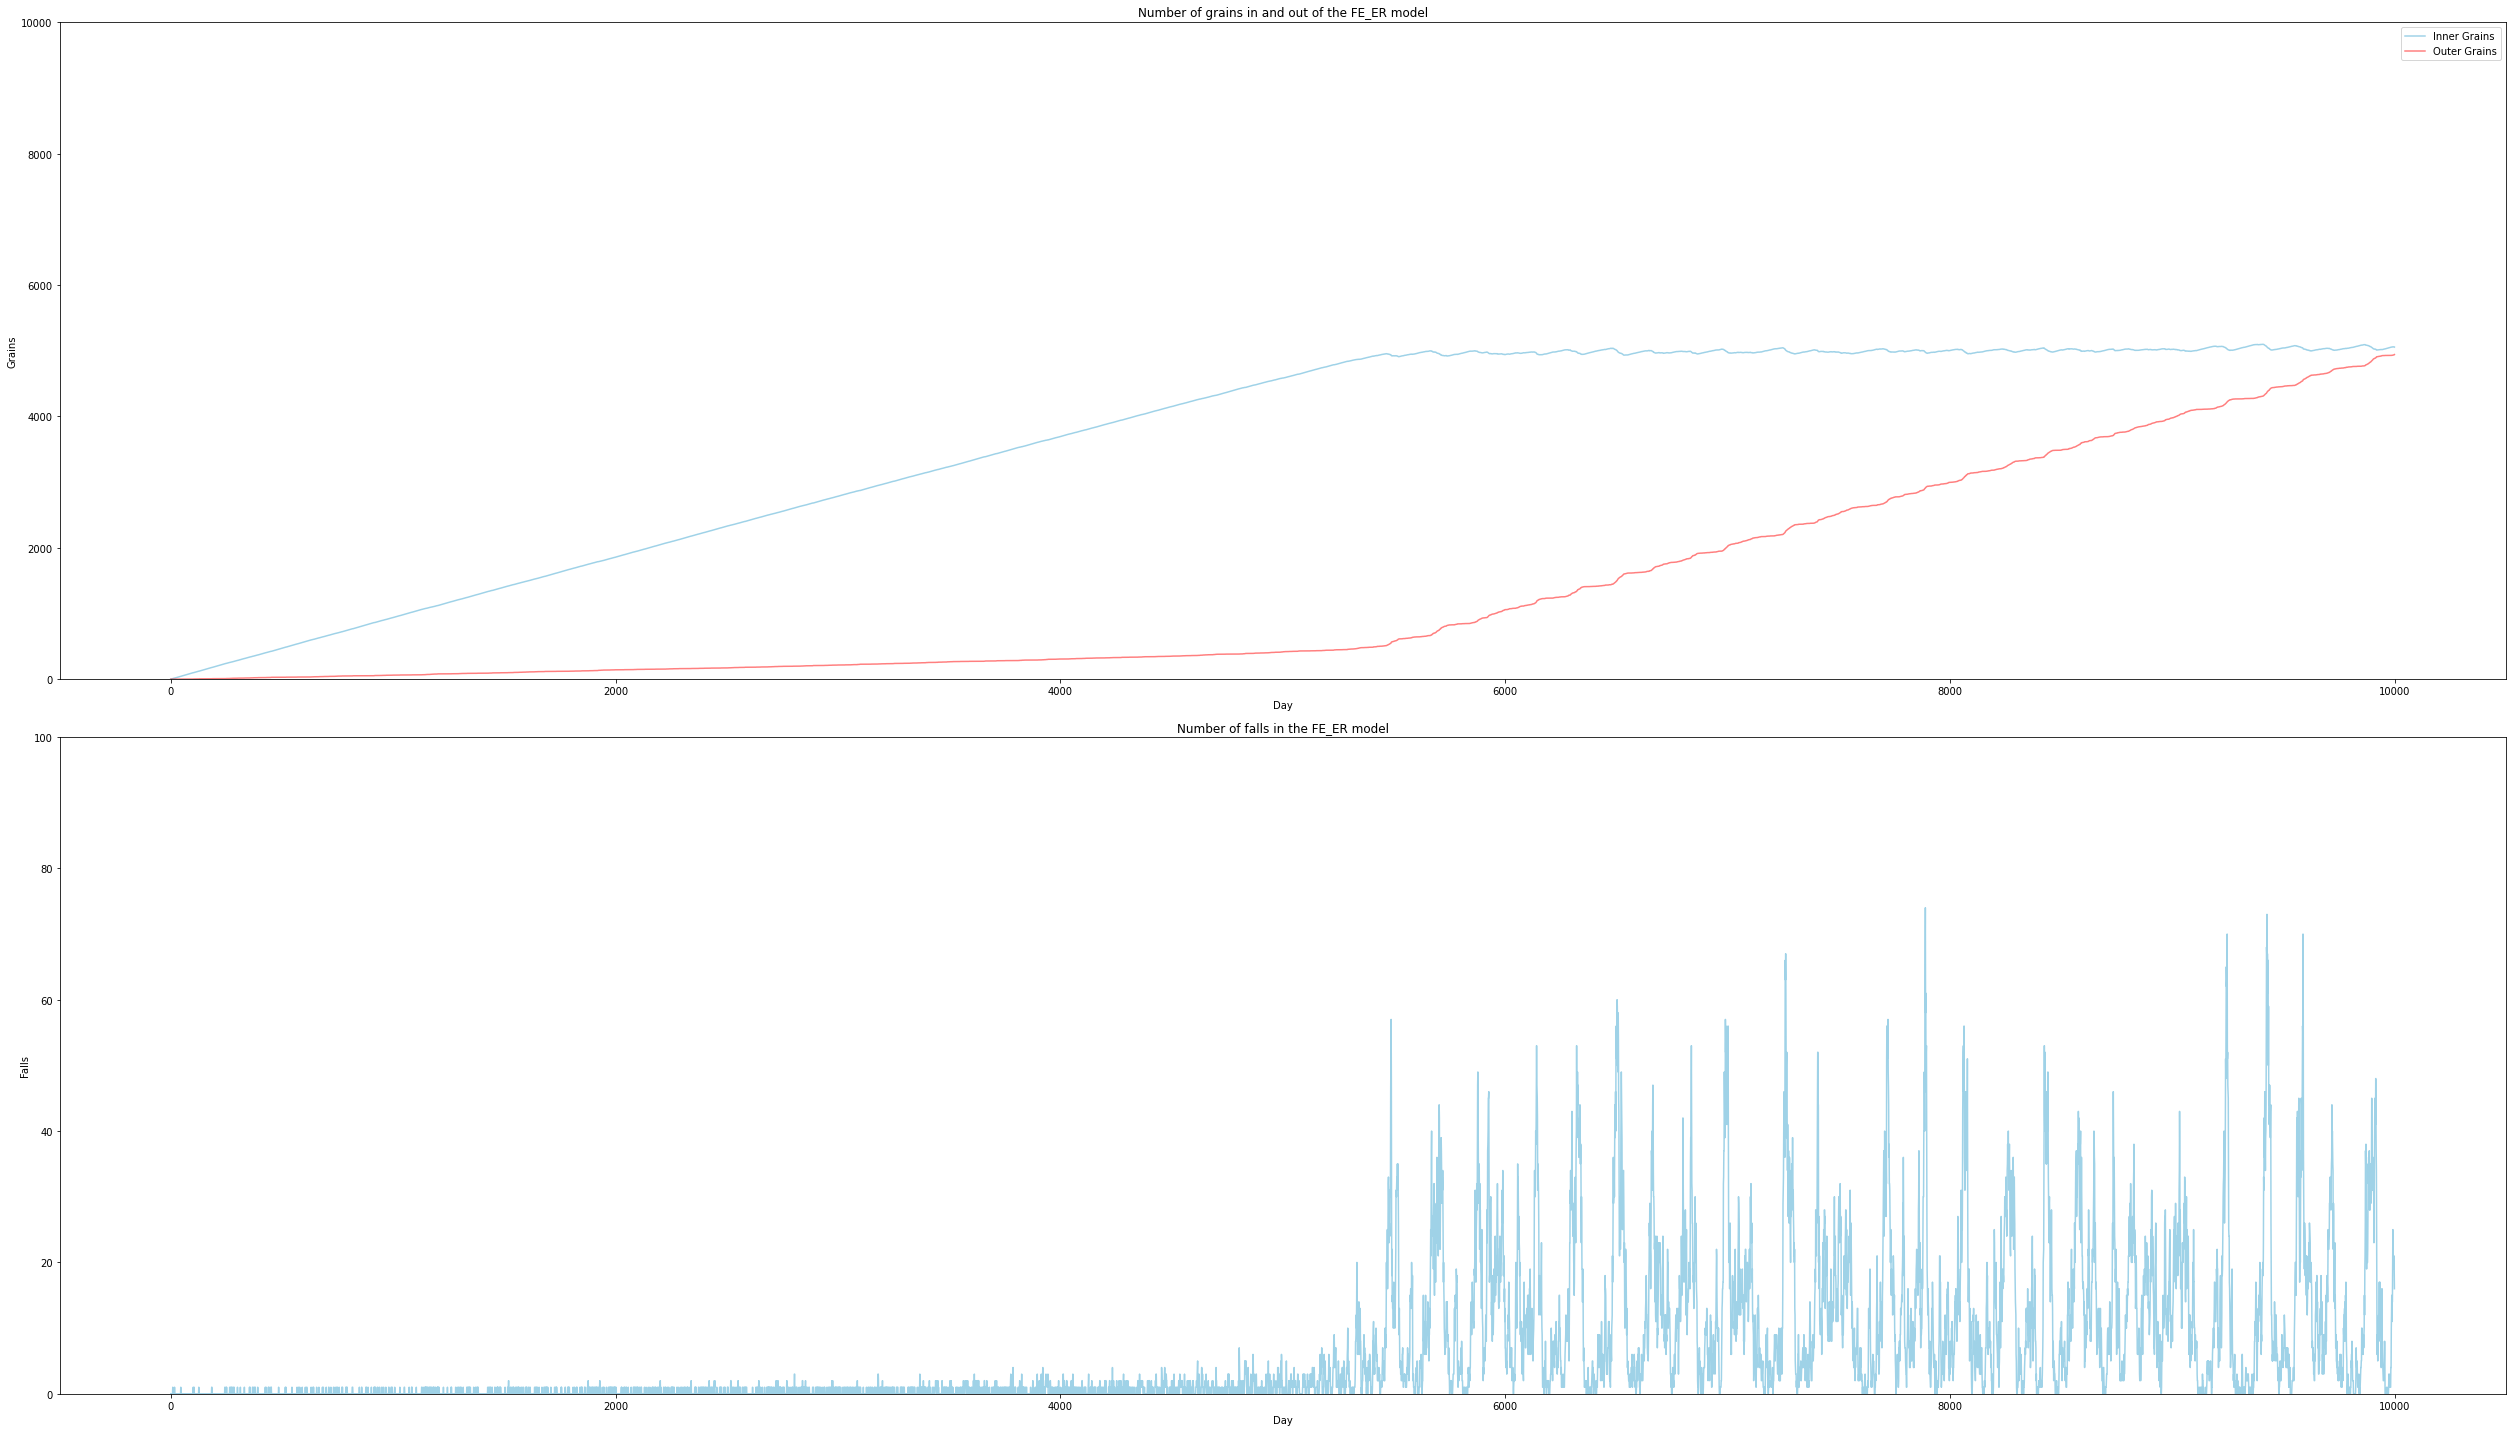

In [45]:
spread("FE", G_ER, number_of_days, new_grains, "ER")

100%|██████████| 9999/9999 [01:54<00:00, 87.27it/s]


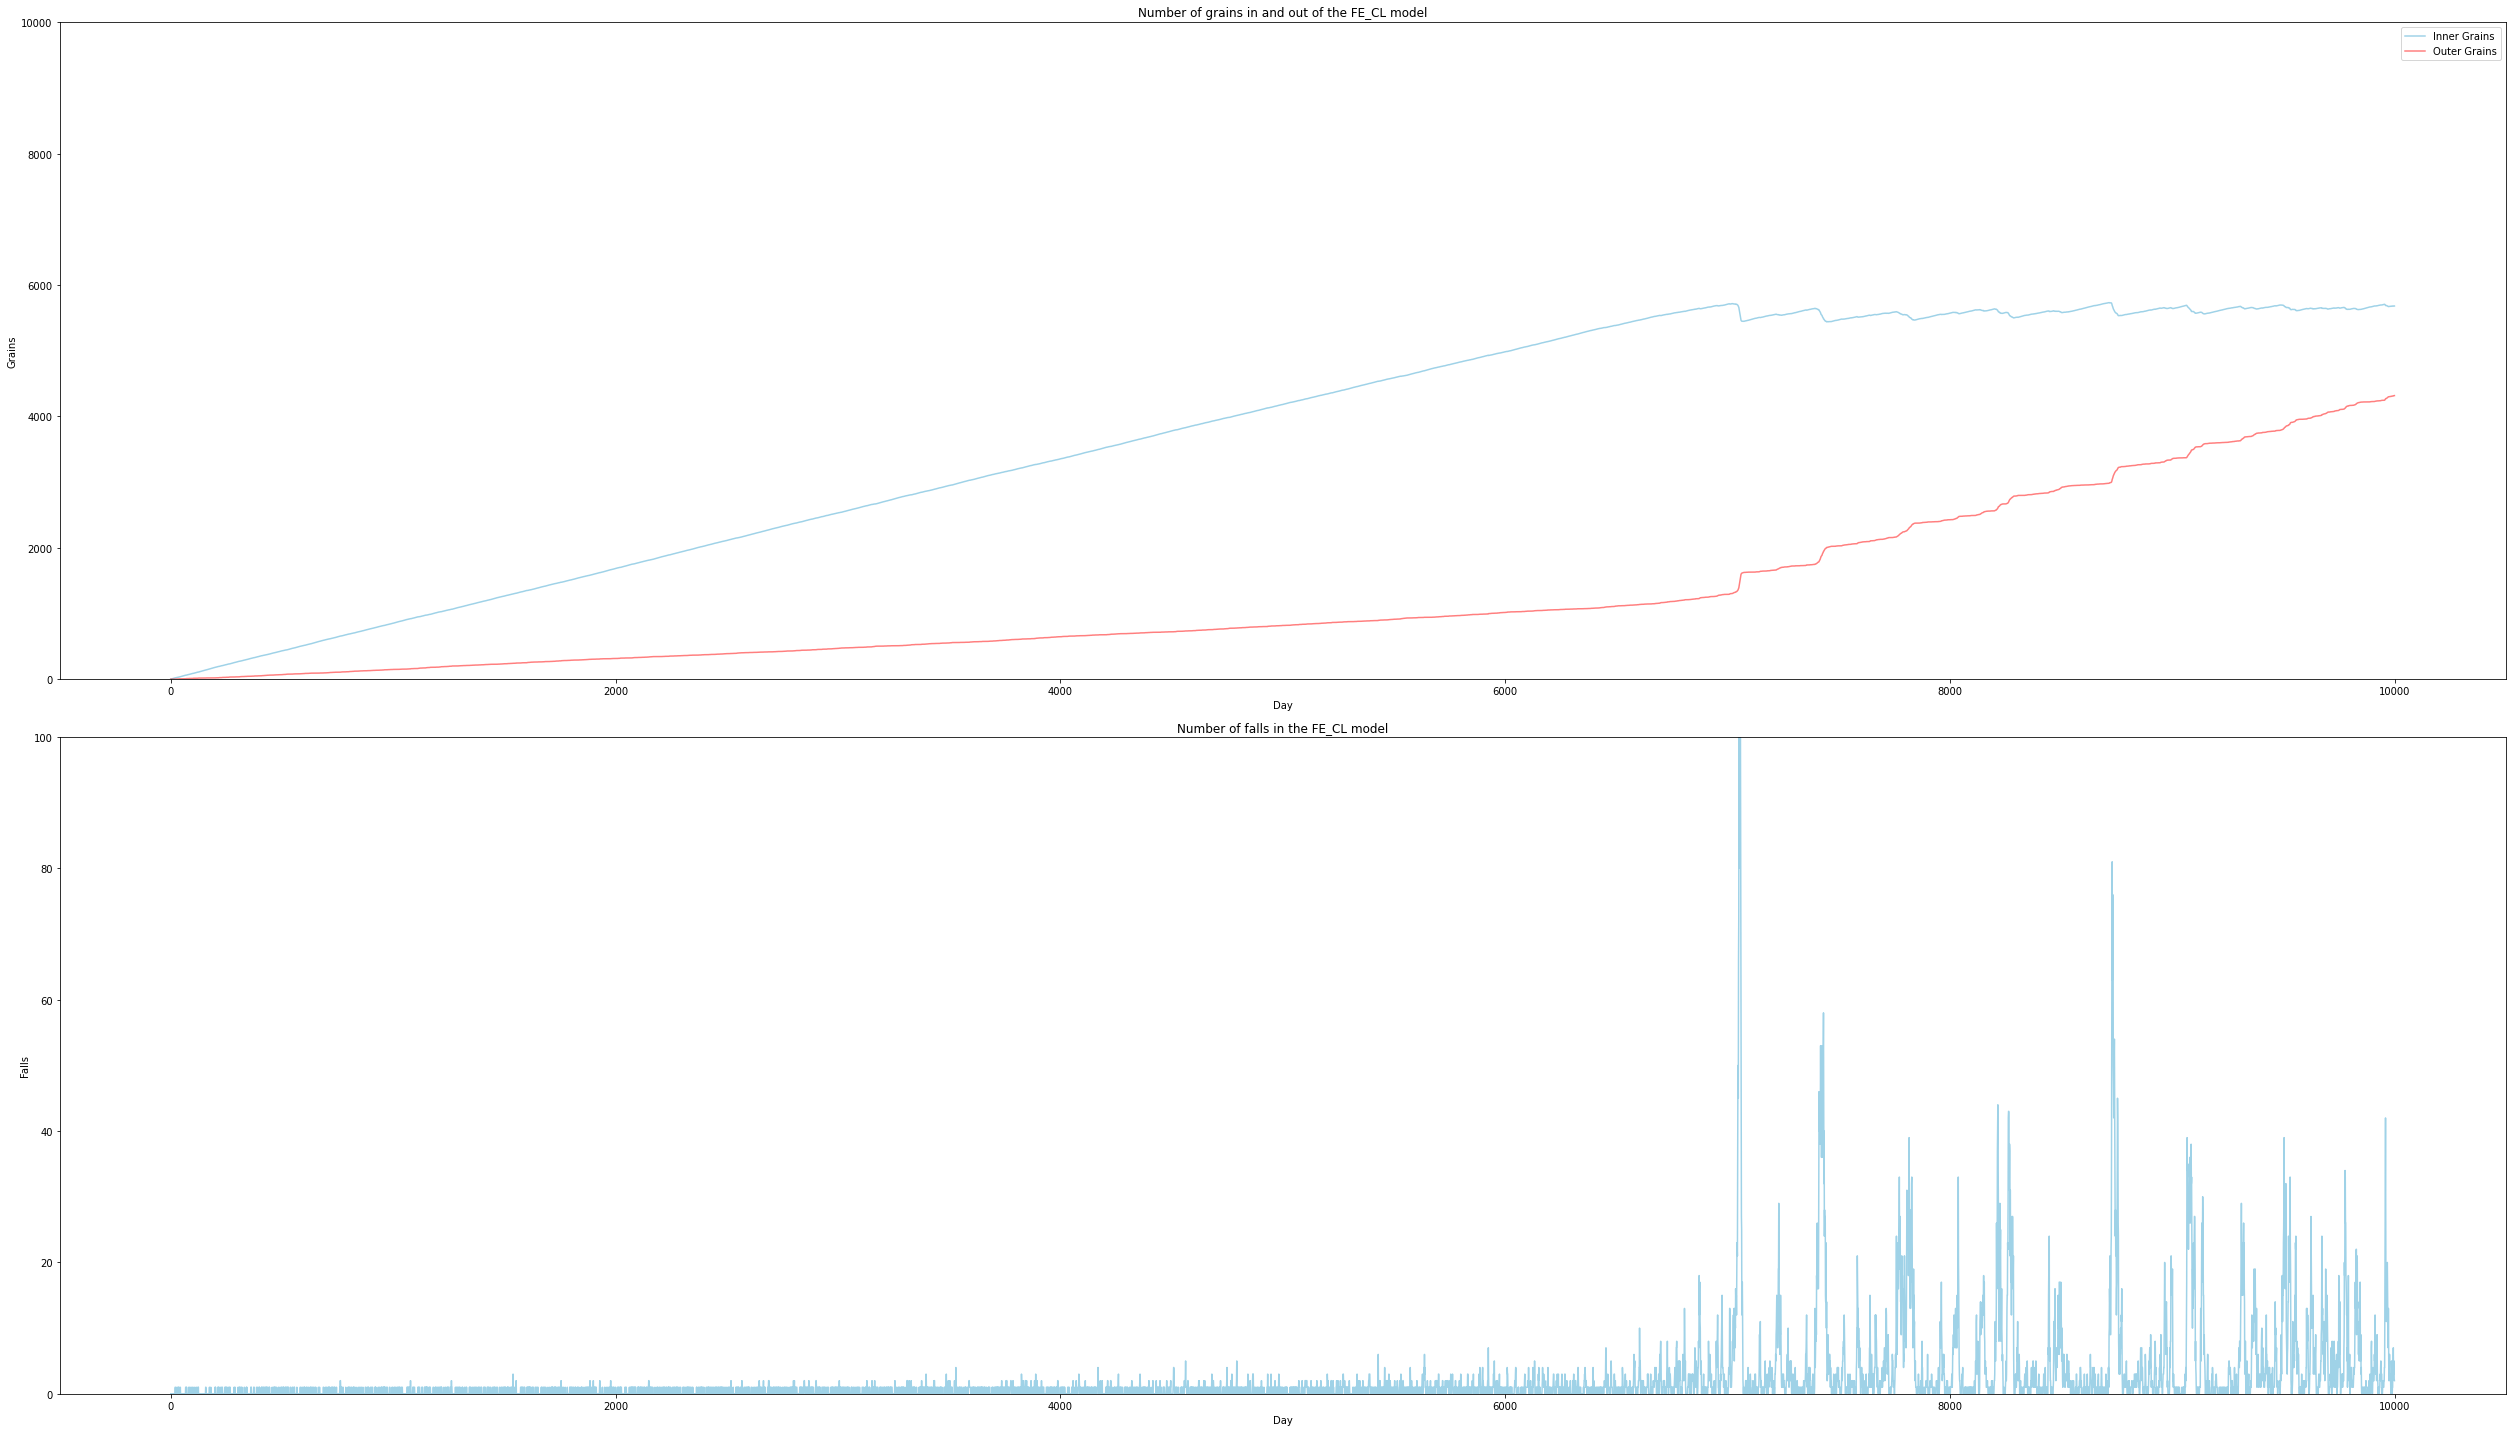

In [46]:
spread("FE", G_CL, number_of_days, new_grains, "CL")

##### Additional Dissipation

100%|██████████| 9999/9999 [02:03<00:00, 80.92it/s]


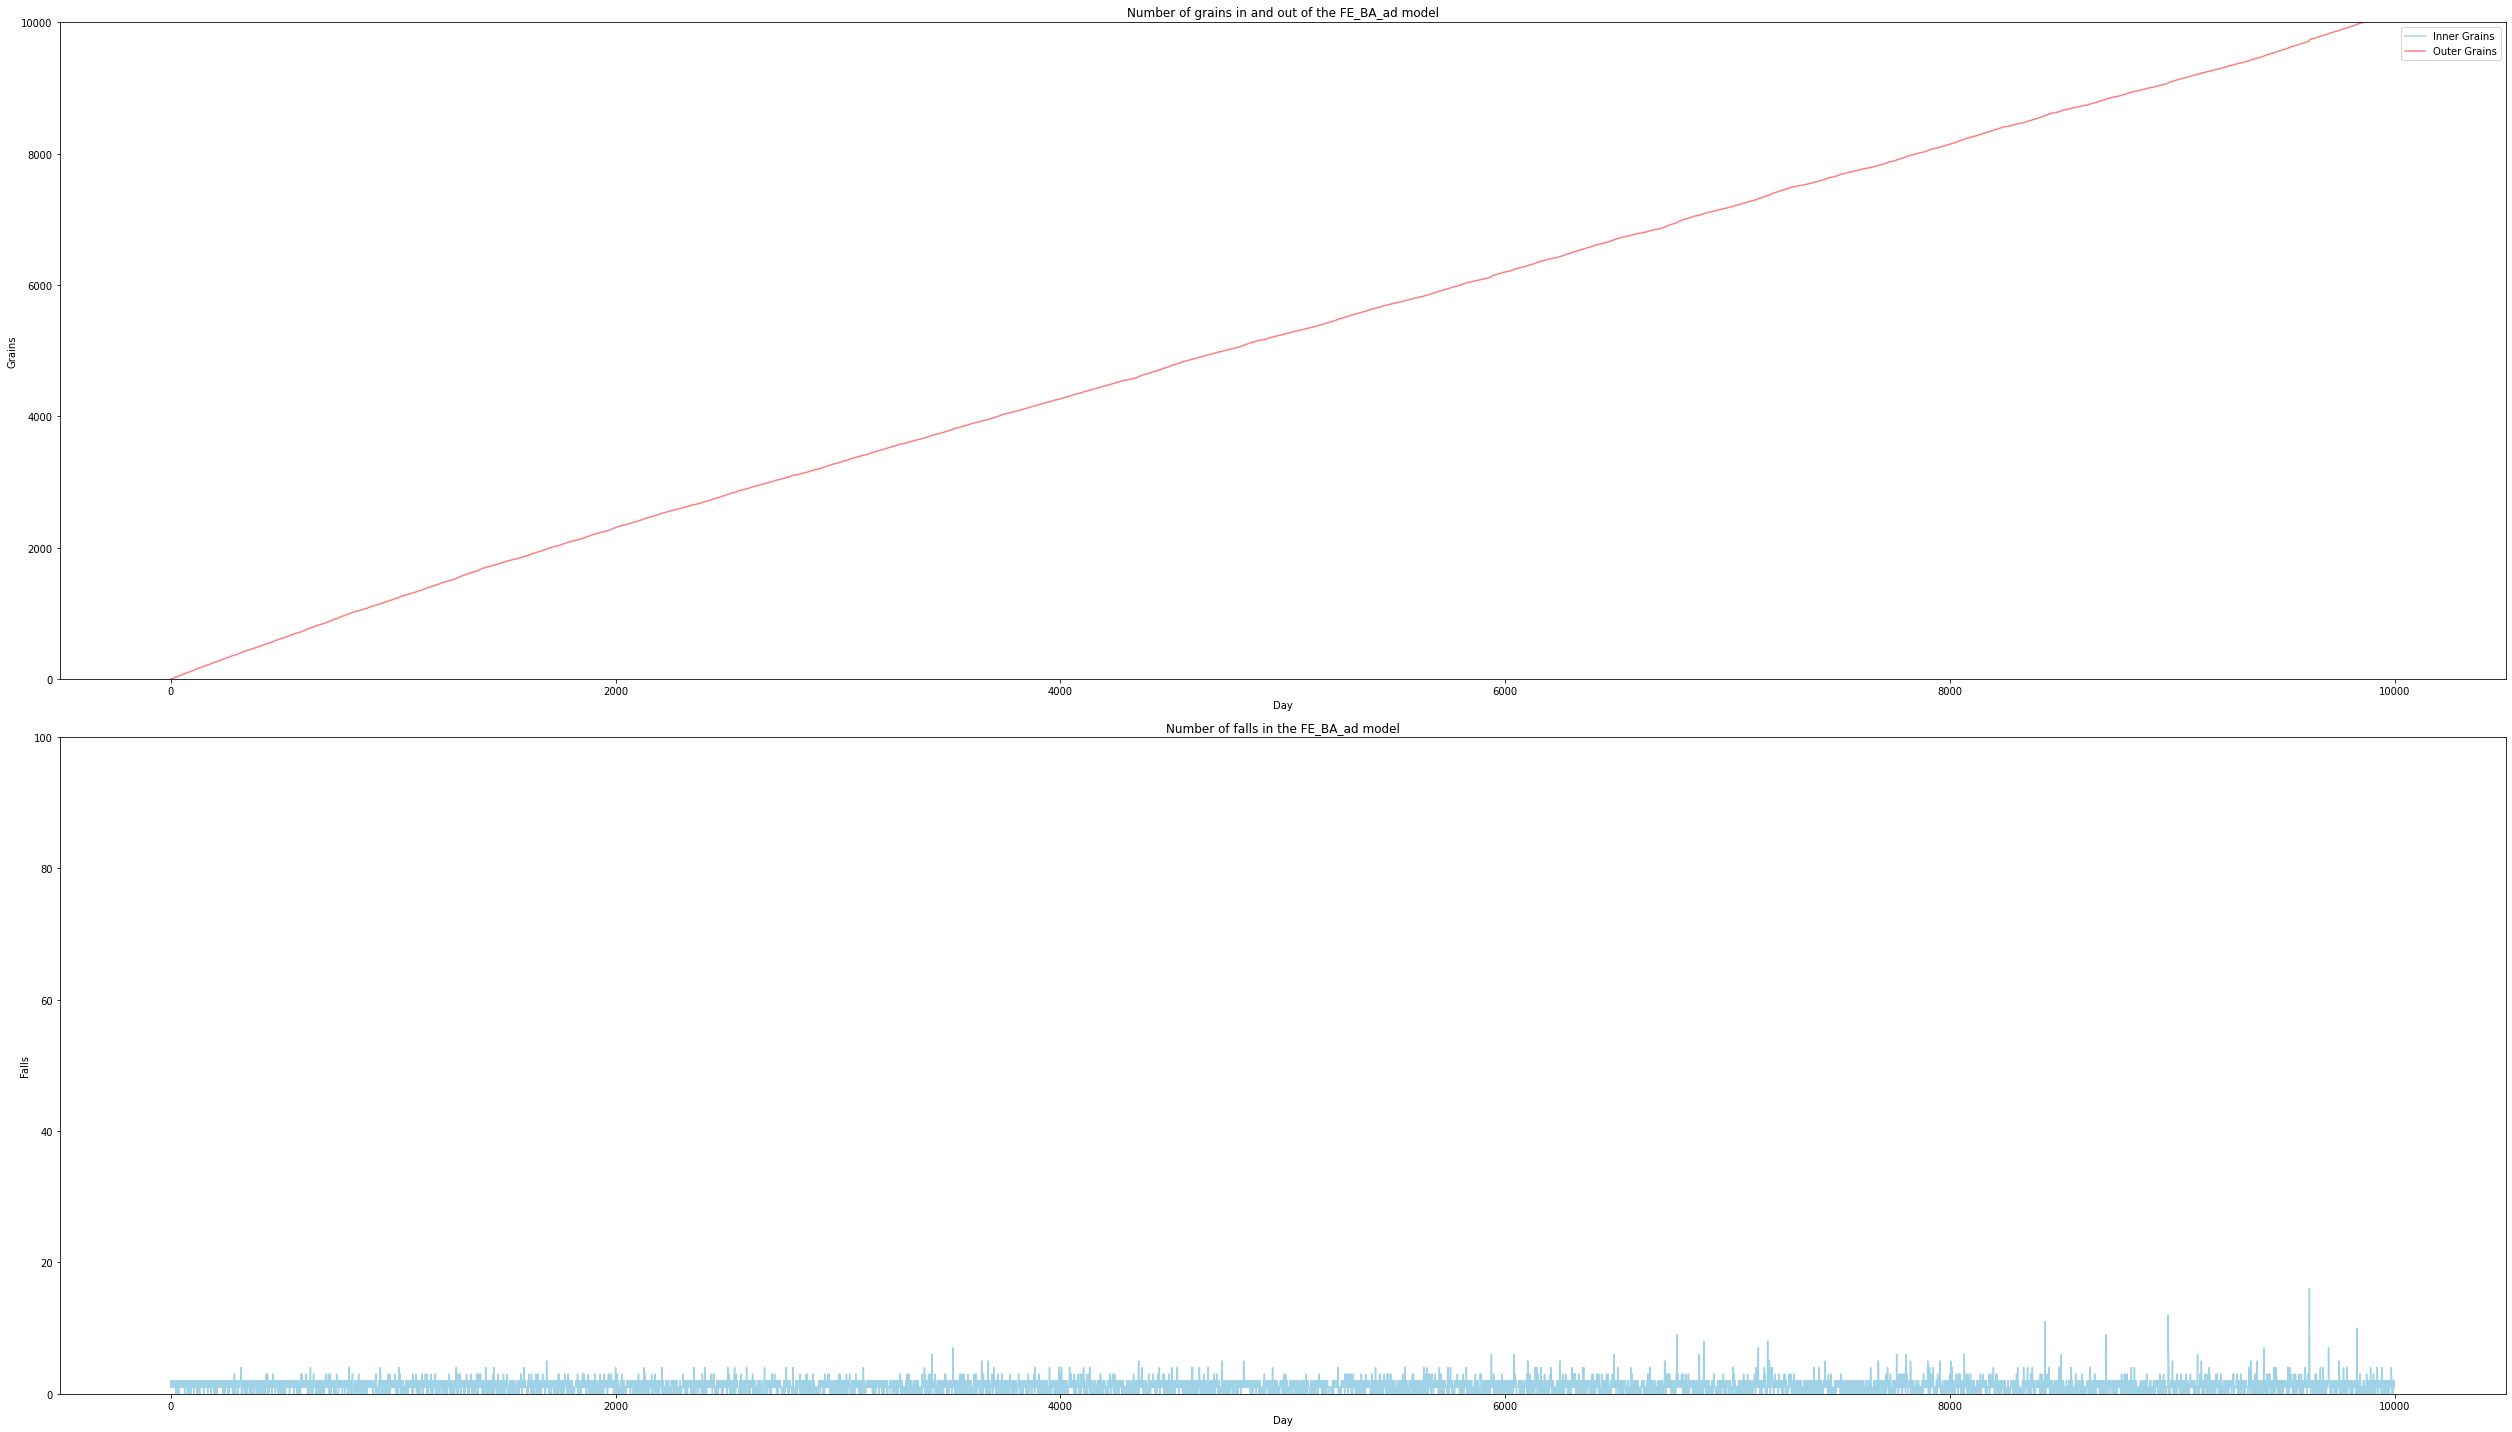

In [47]:
spread("FE", G_BA, number_of_days, new_grains, "BA", ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

100%|██████████| 9999/9999 [02:16<00:00, 73.41it/s]


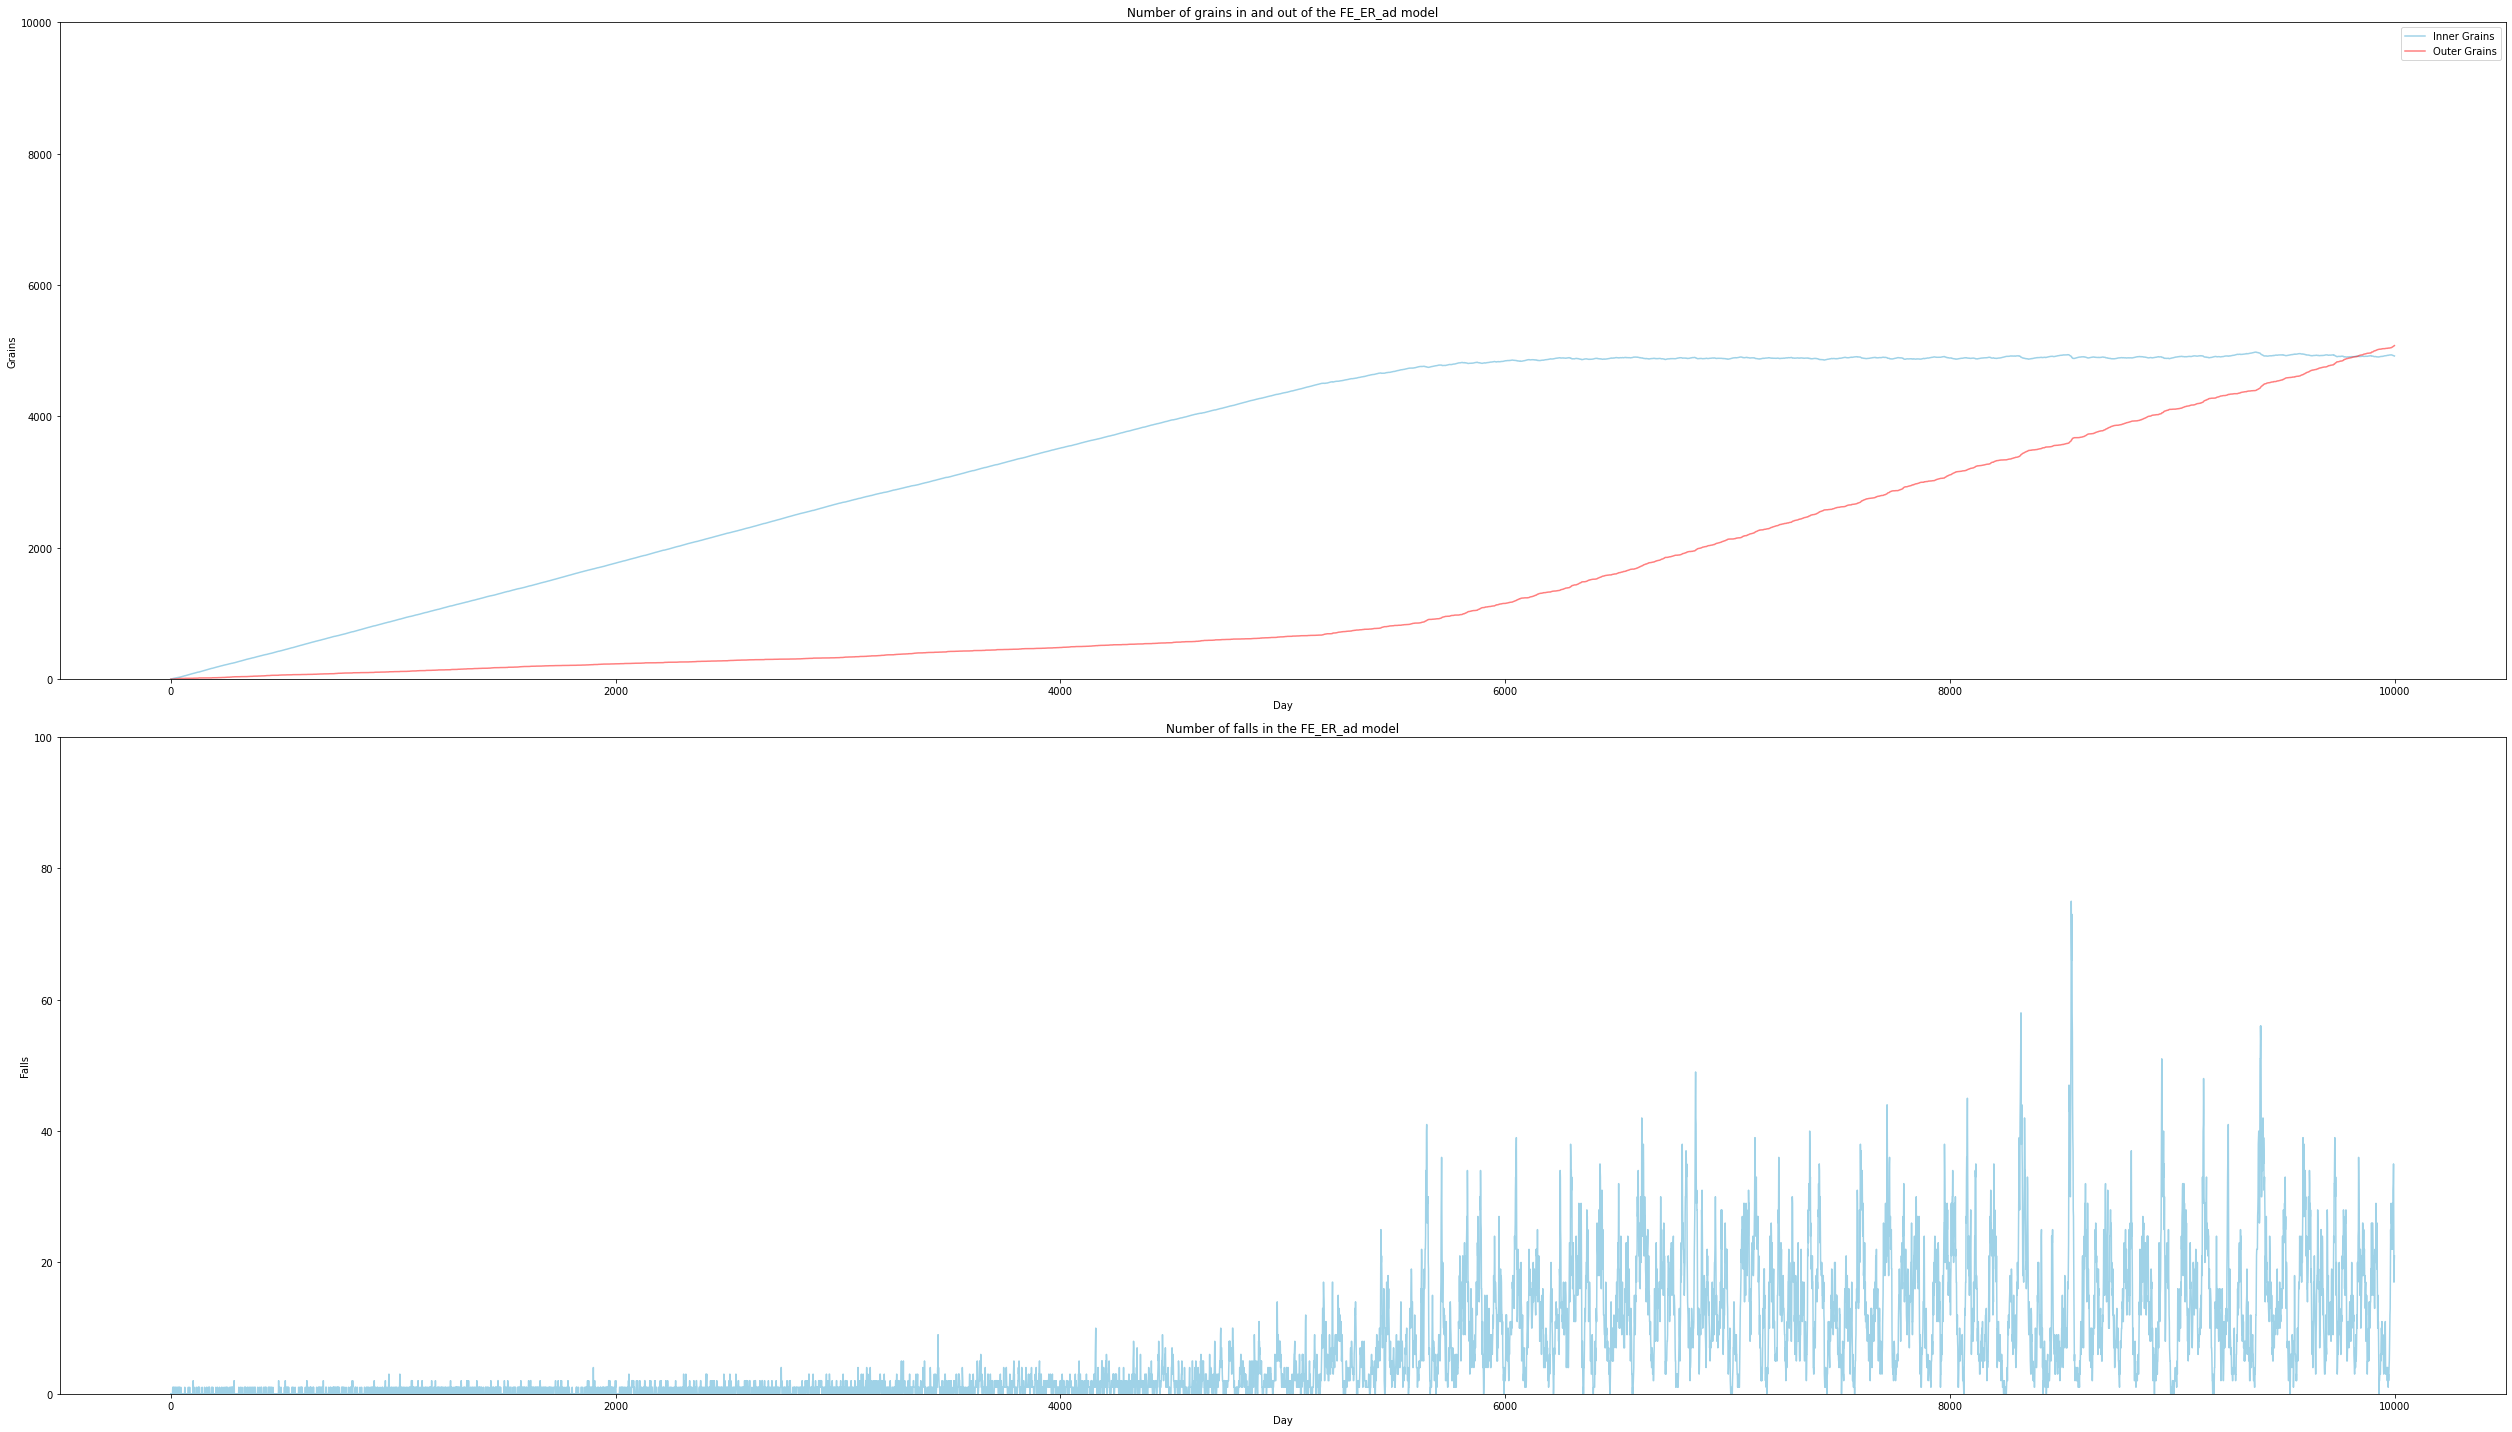

In [48]:
spread("FE", G_ER, number_of_days, new_grains, "ER", ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

100%|██████████| 9999/9999 [01:54<00:00, 87.63it/s]


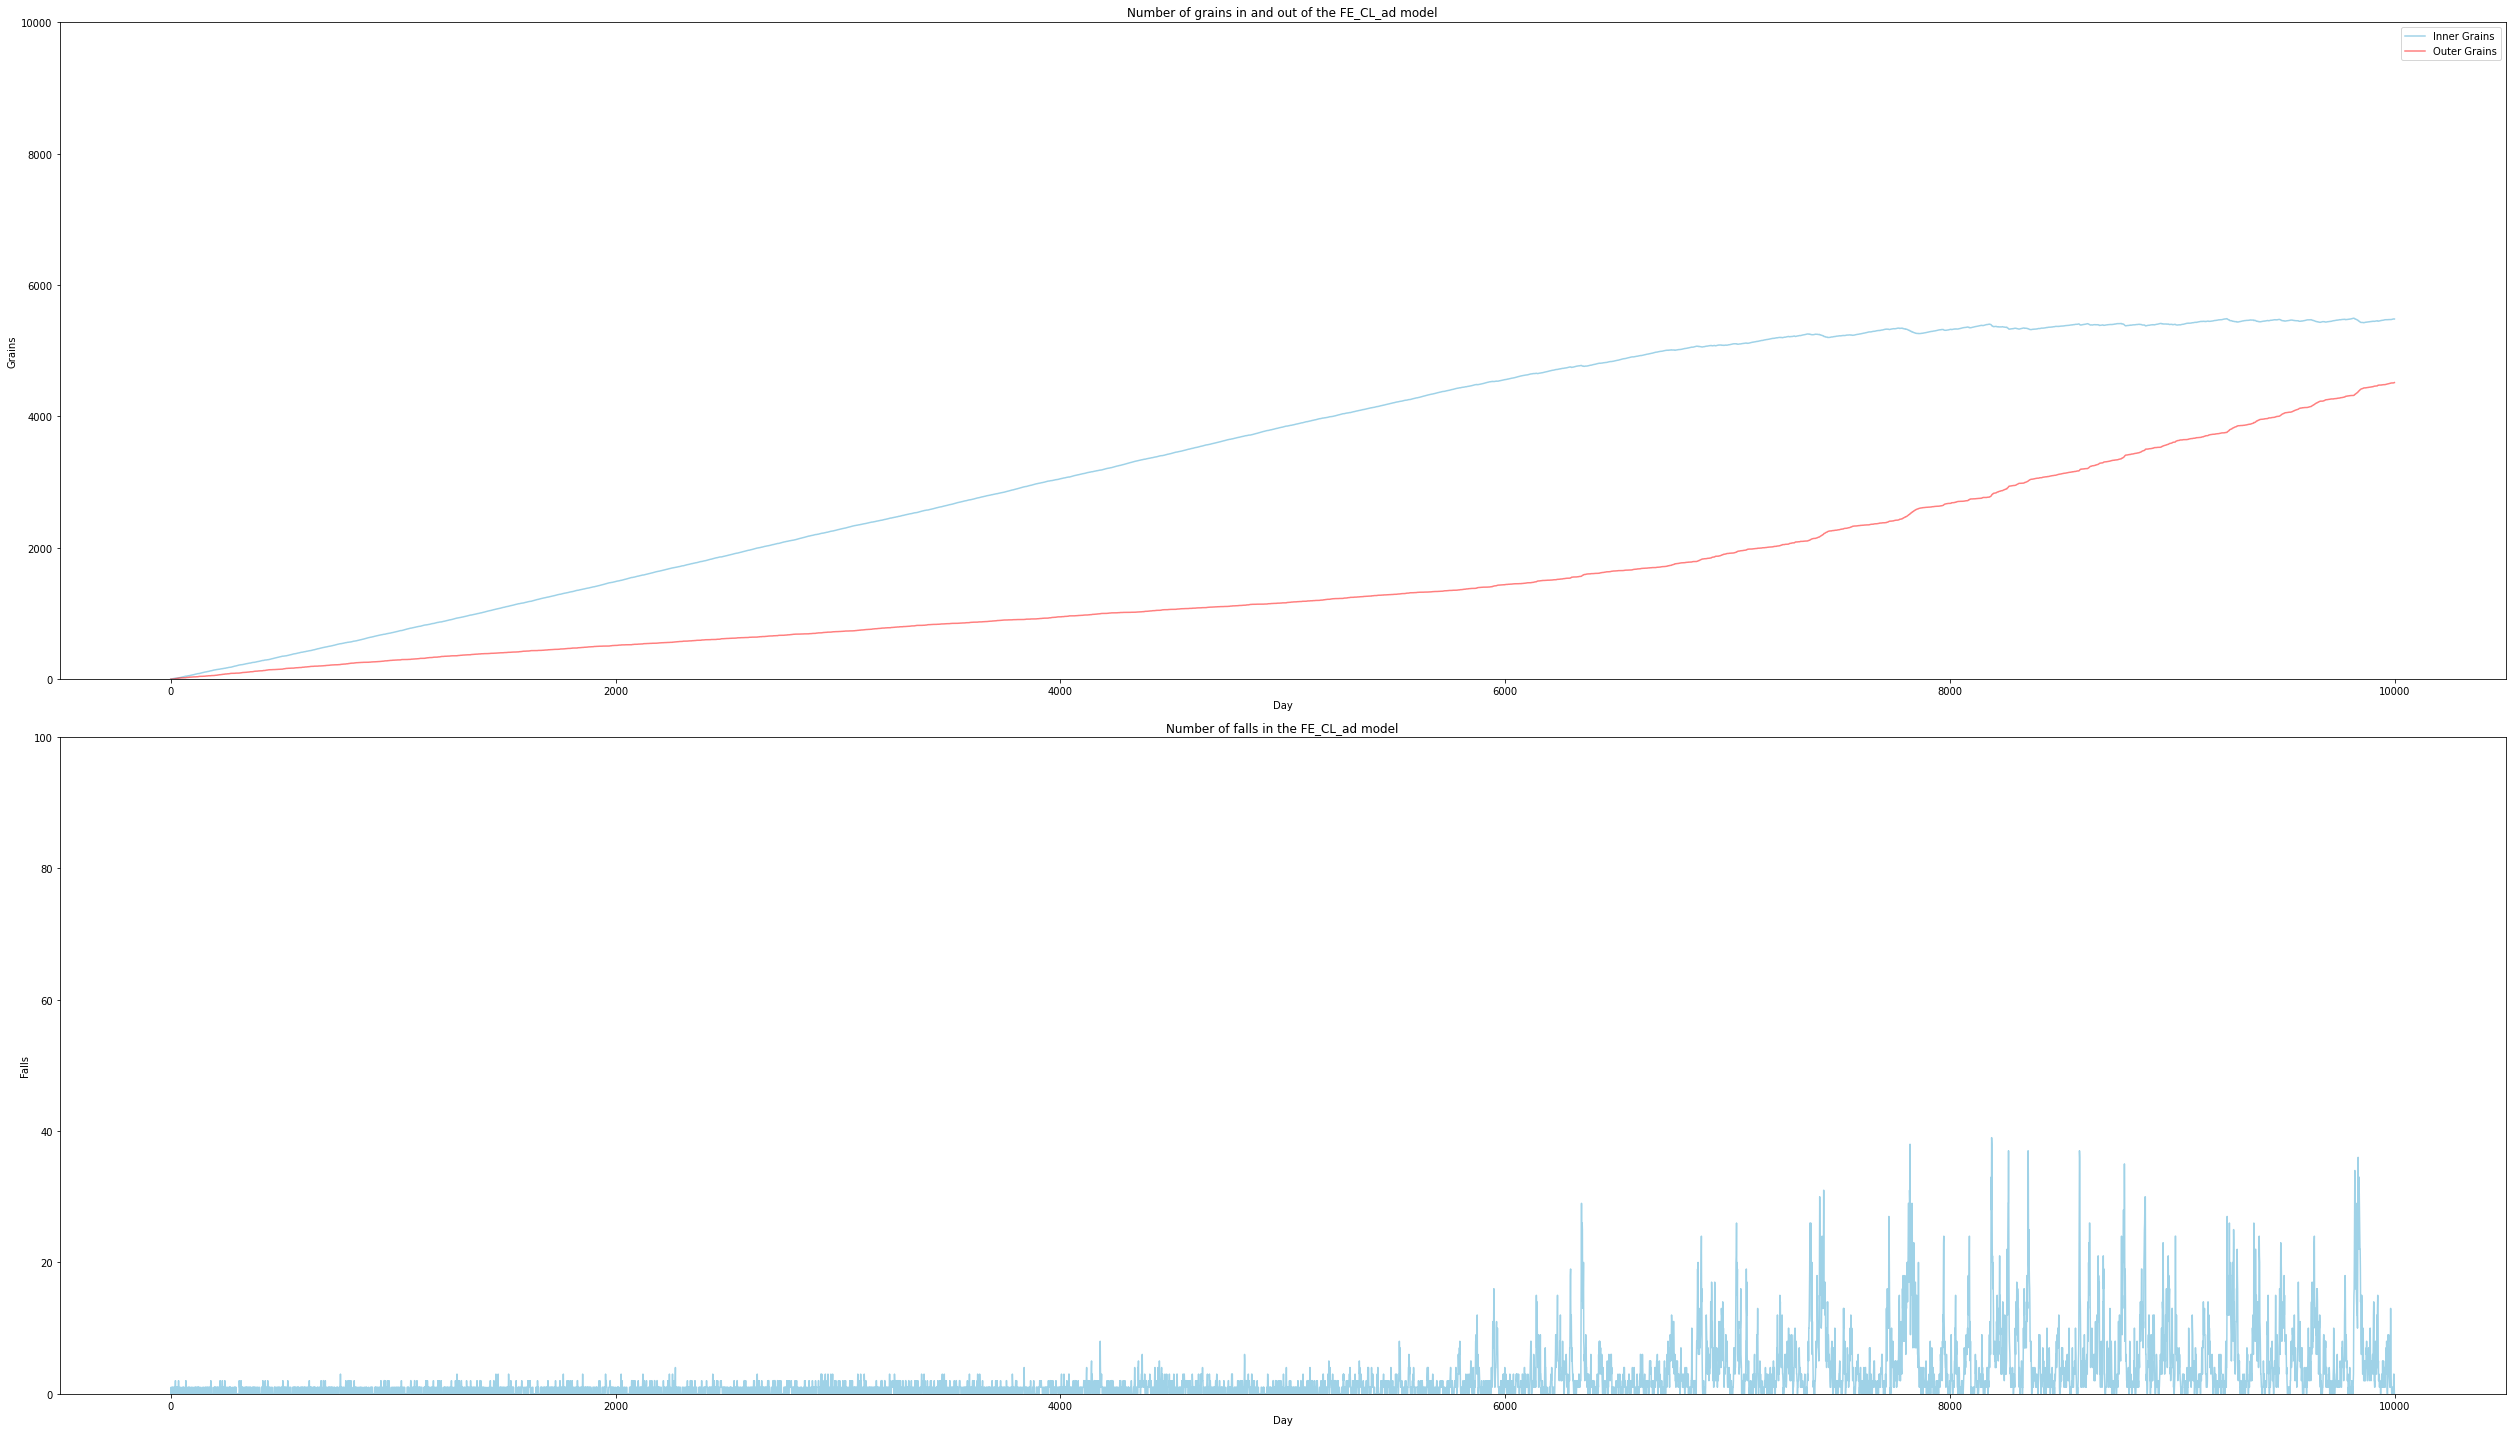

In [49]:
spread("FE", G_CL, number_of_days, new_grains, "CL", ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

##### Neutral State

100%|██████████| 9999/9999 [01:43<00:00, 97.03it/s] 


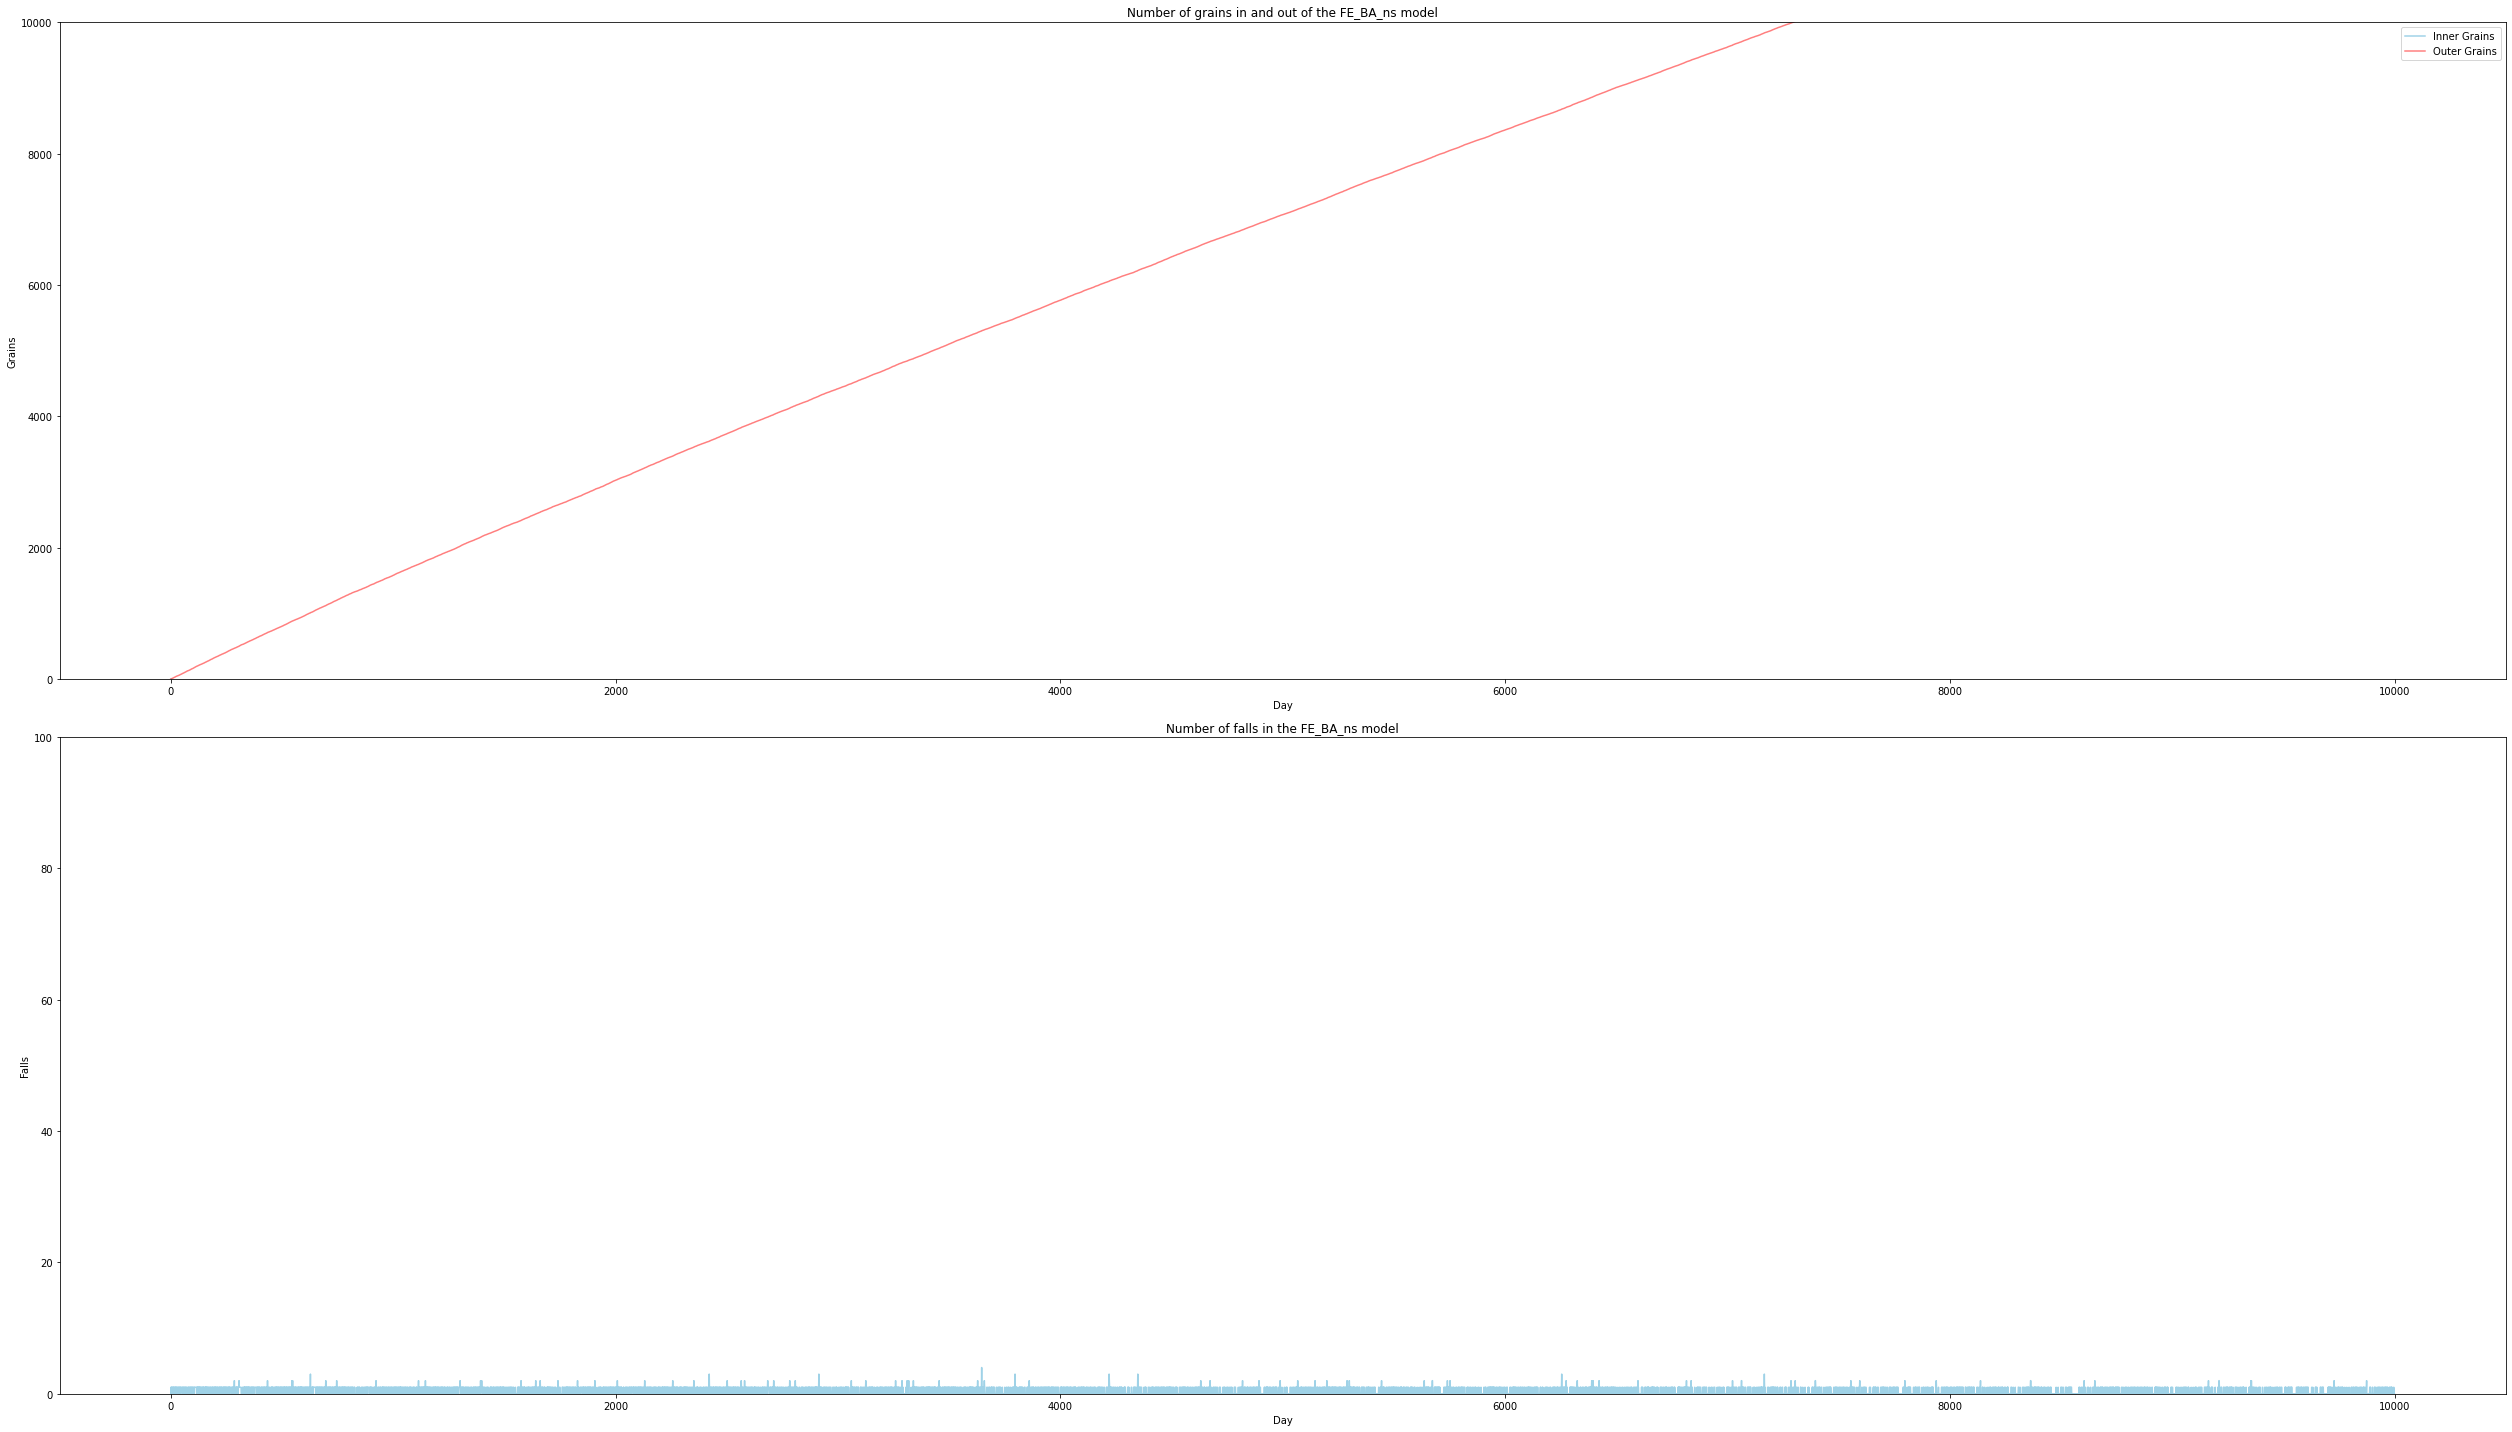

In [88]:
spread("FE", G_BA, number_of_days, new_grains, "BA", neutral_state = True, new_grains_minus = new_grains_minus)

100%|██████████| 9999/9999 [01:24<00:00, 118.23it/s]


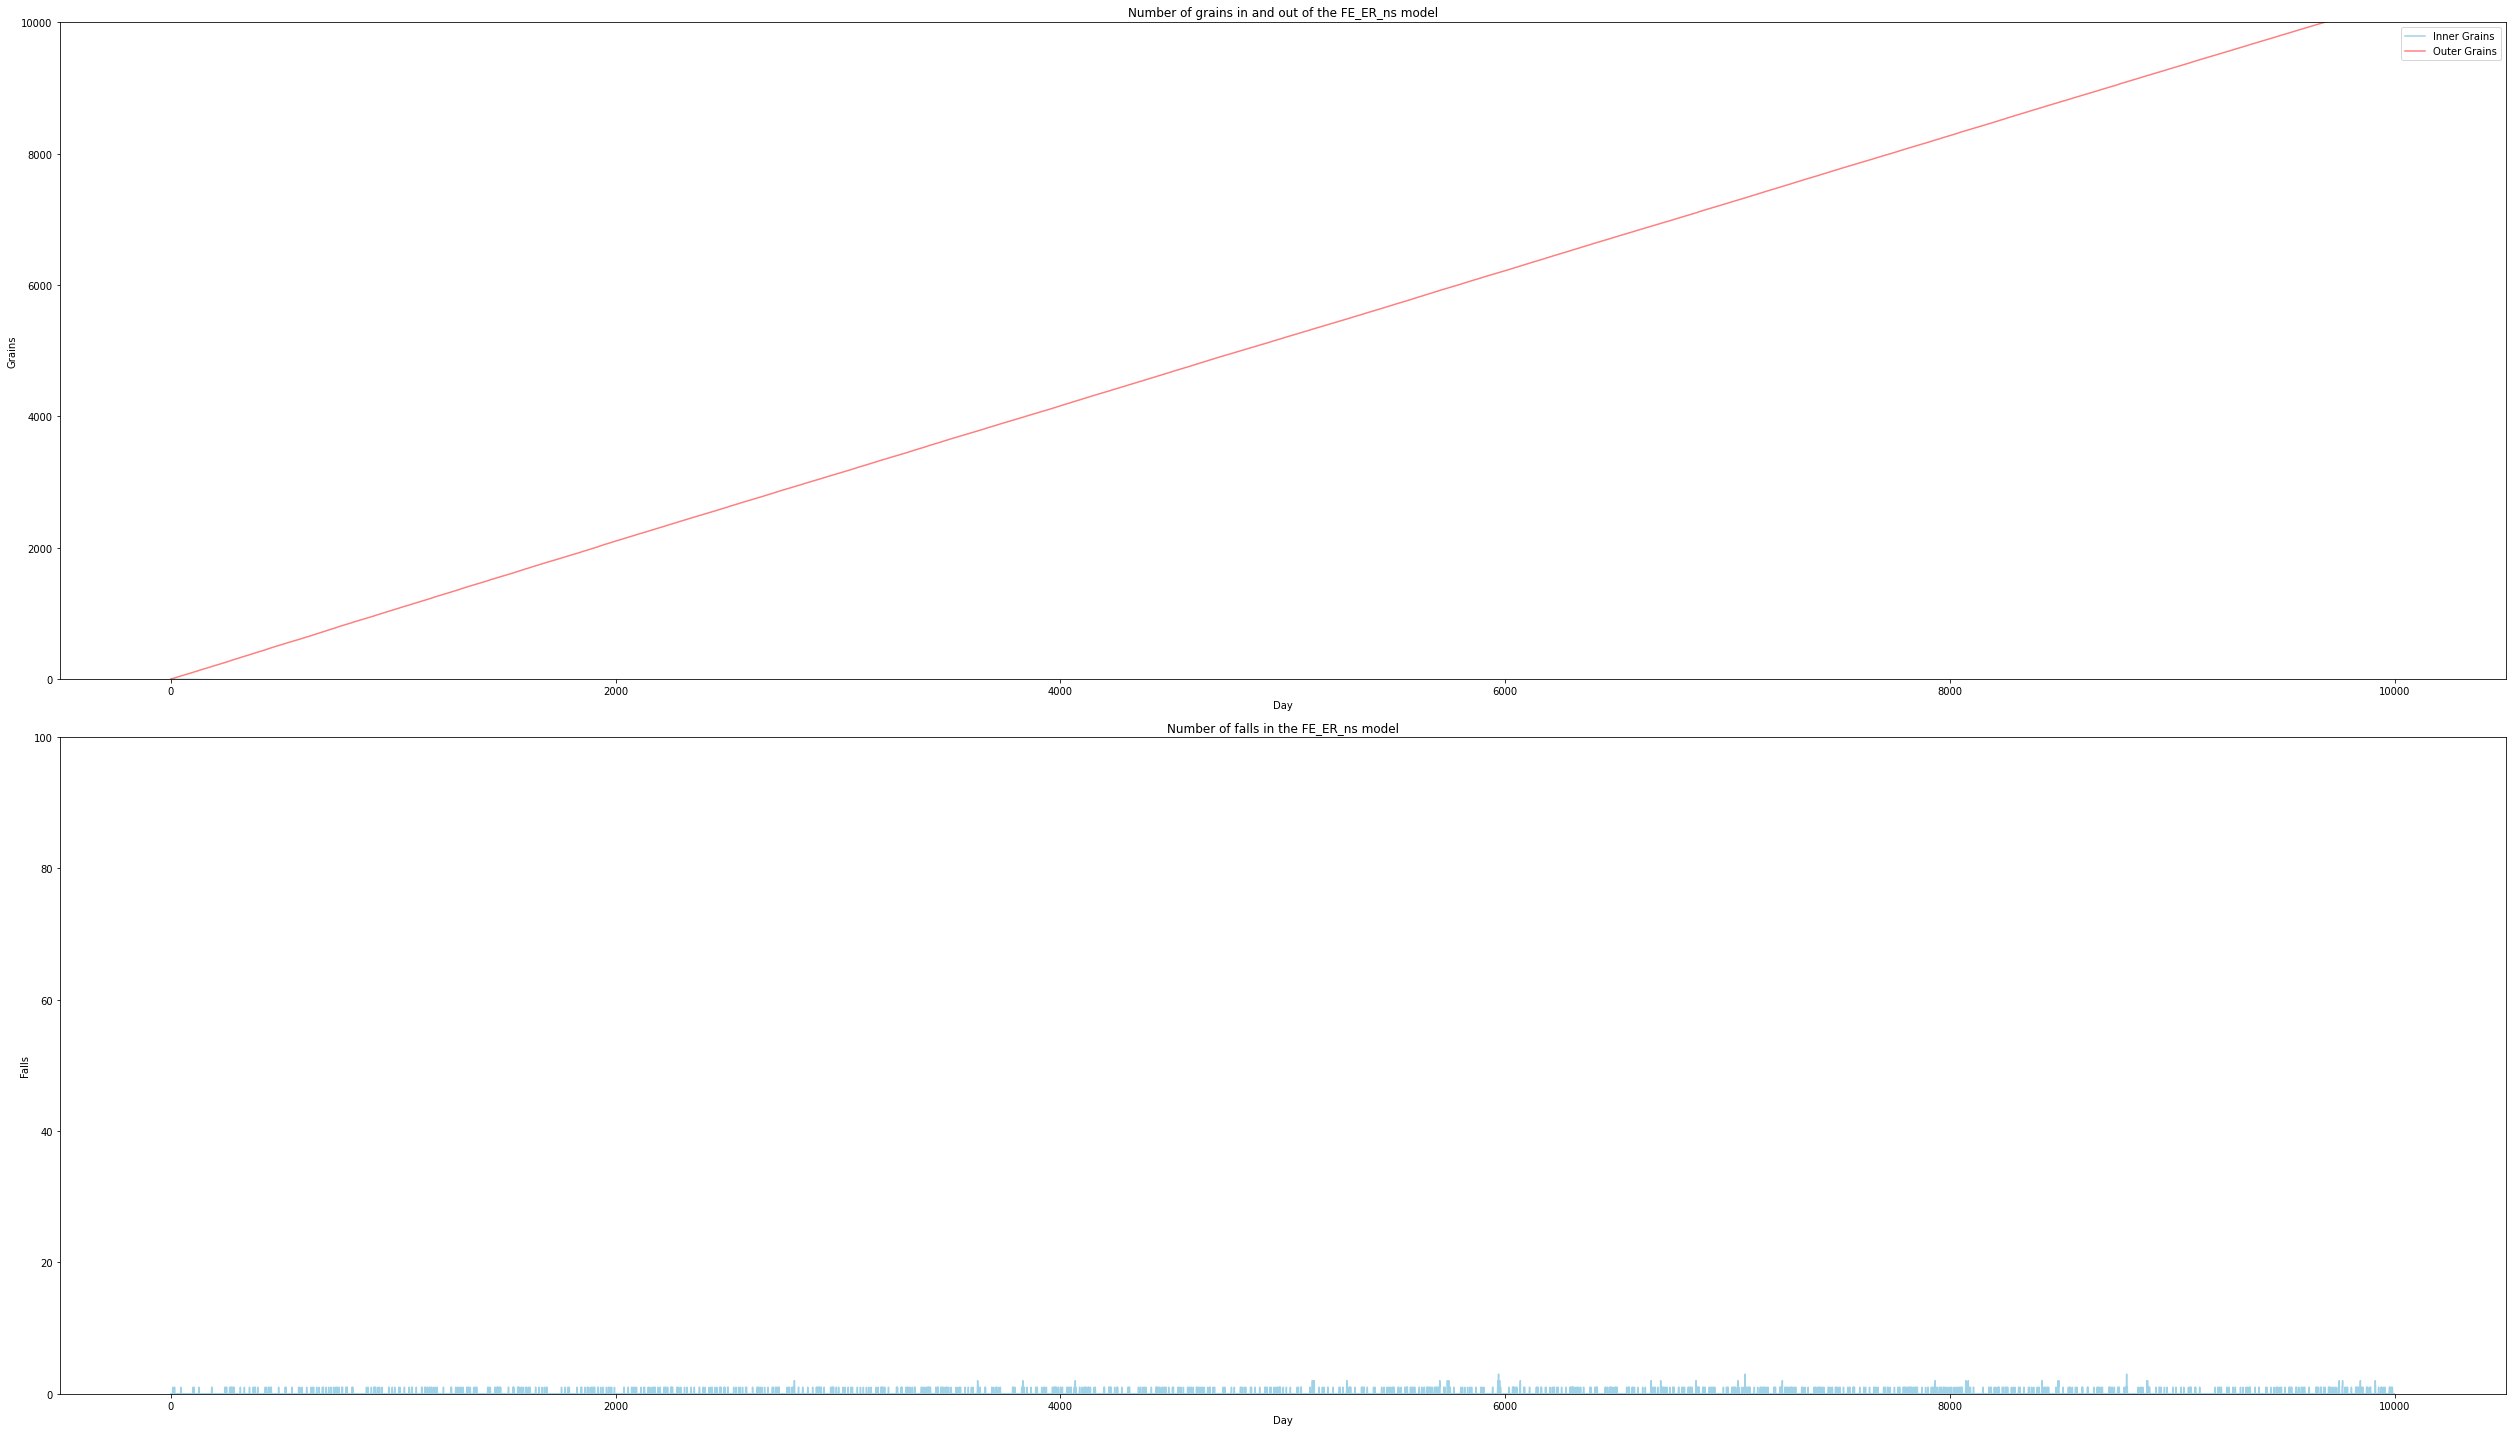

In [89]:
spread("FE", G_ER, number_of_days, new_grains, "ER", neutral_state = True, new_grains_minus = new_grains_minus)

100%|██████████| 9999/9999 [01:42<00:00, 97.77it/s] 


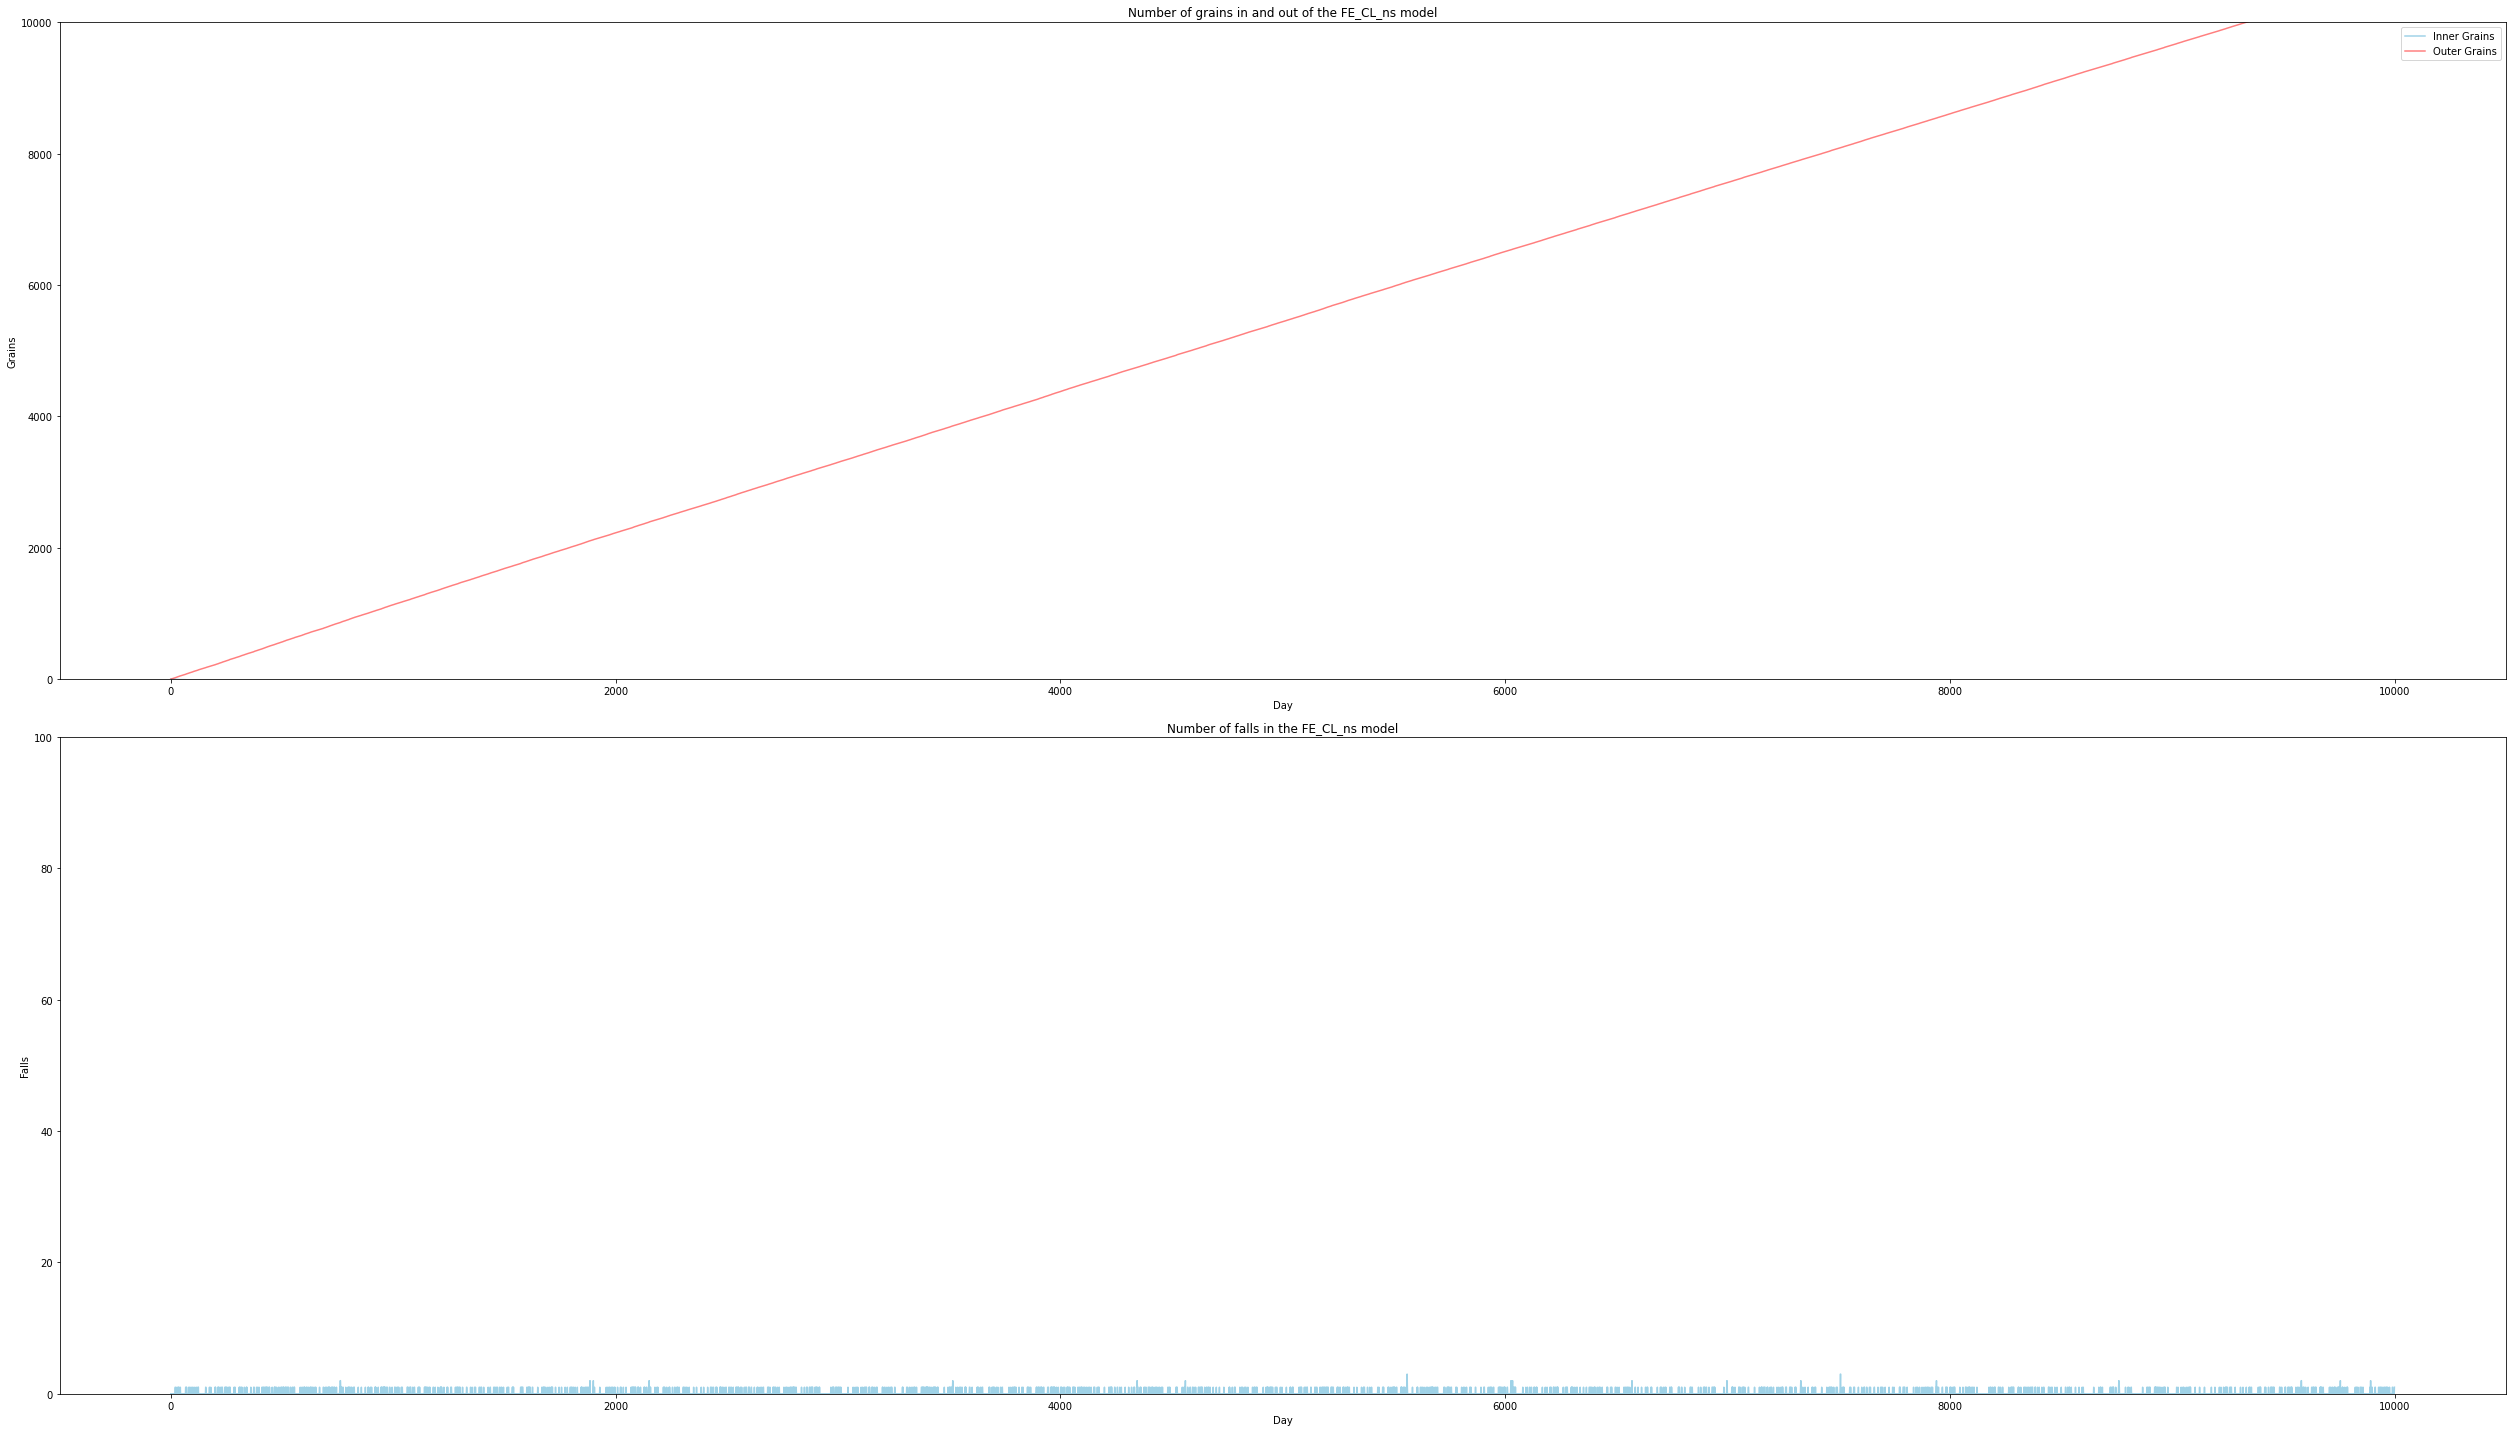

In [90]:
spread("FE", G_CL, number_of_days, new_grains, "CL", neutral_state = True, new_grains_minus = new_grains_minus)

#### Facilitated Model

##### Standart Dissipation

100%|██████████| 9999/9999 [01:52<00:00, 89.19it/s] 


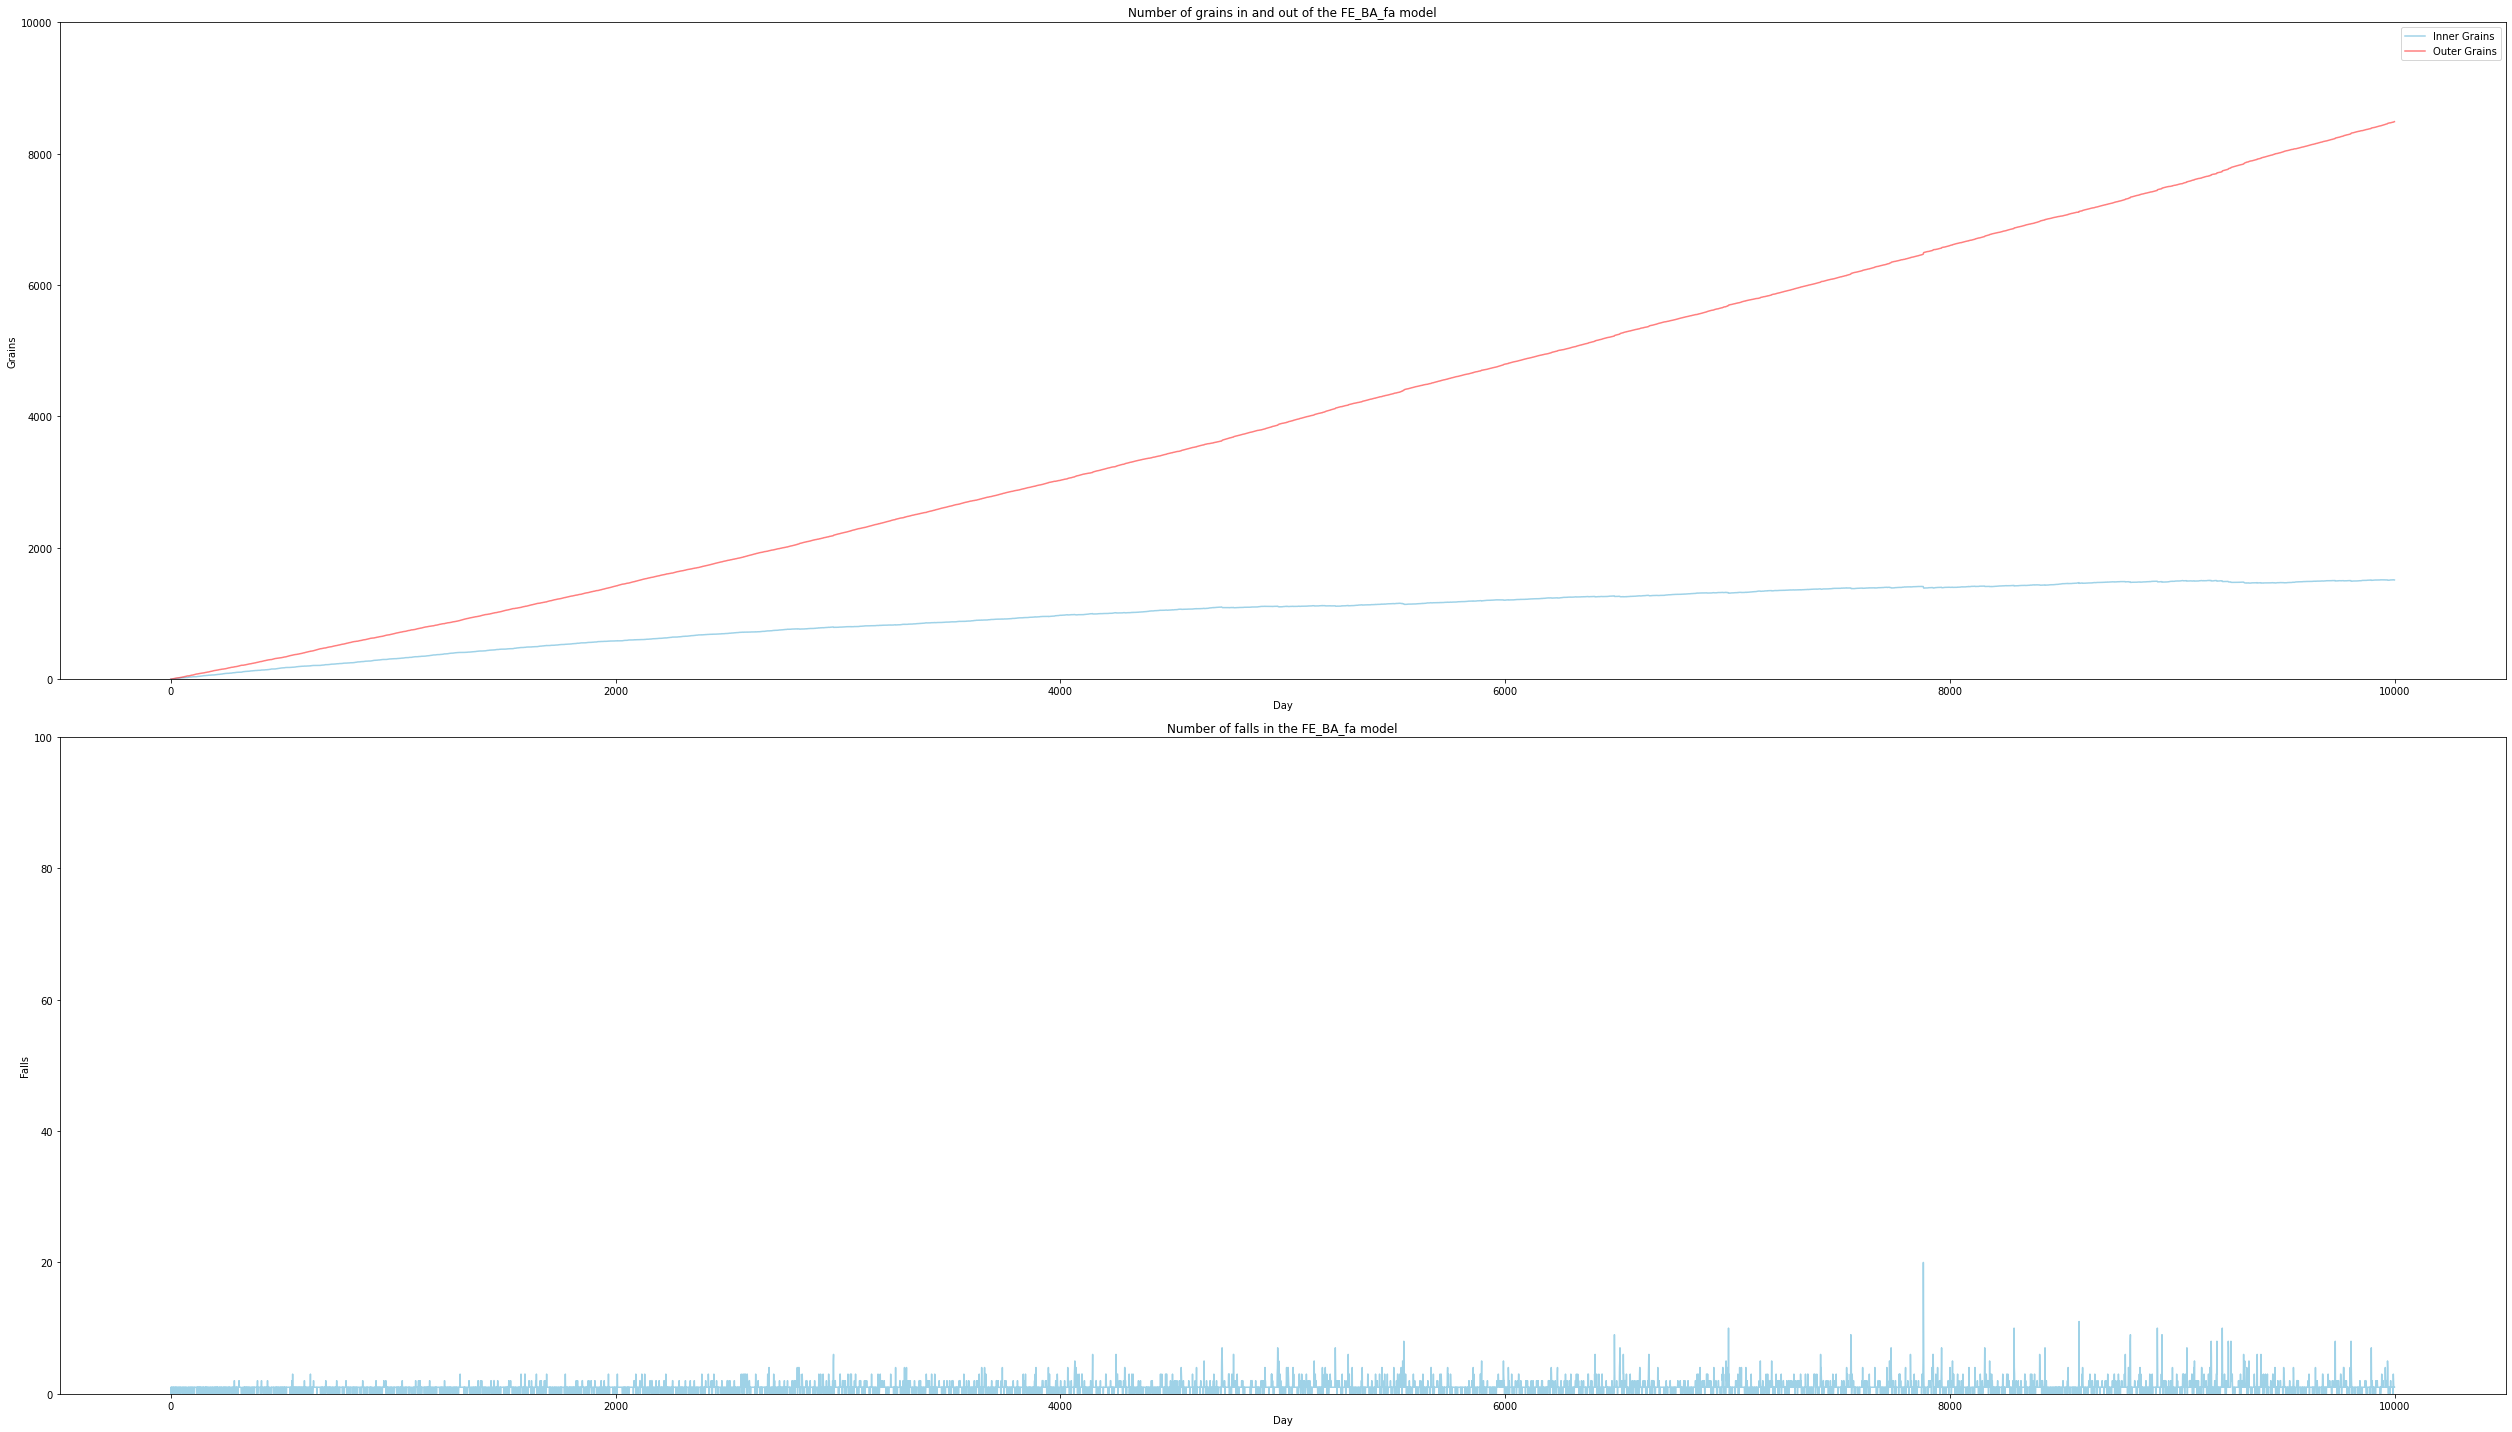

In [50]:
spread("FE", G_BA, number_of_days, new_grains, "BA", facilitated = True)

100%|██████████| 9999/9999 [02:00<00:00, 83.12it/s]


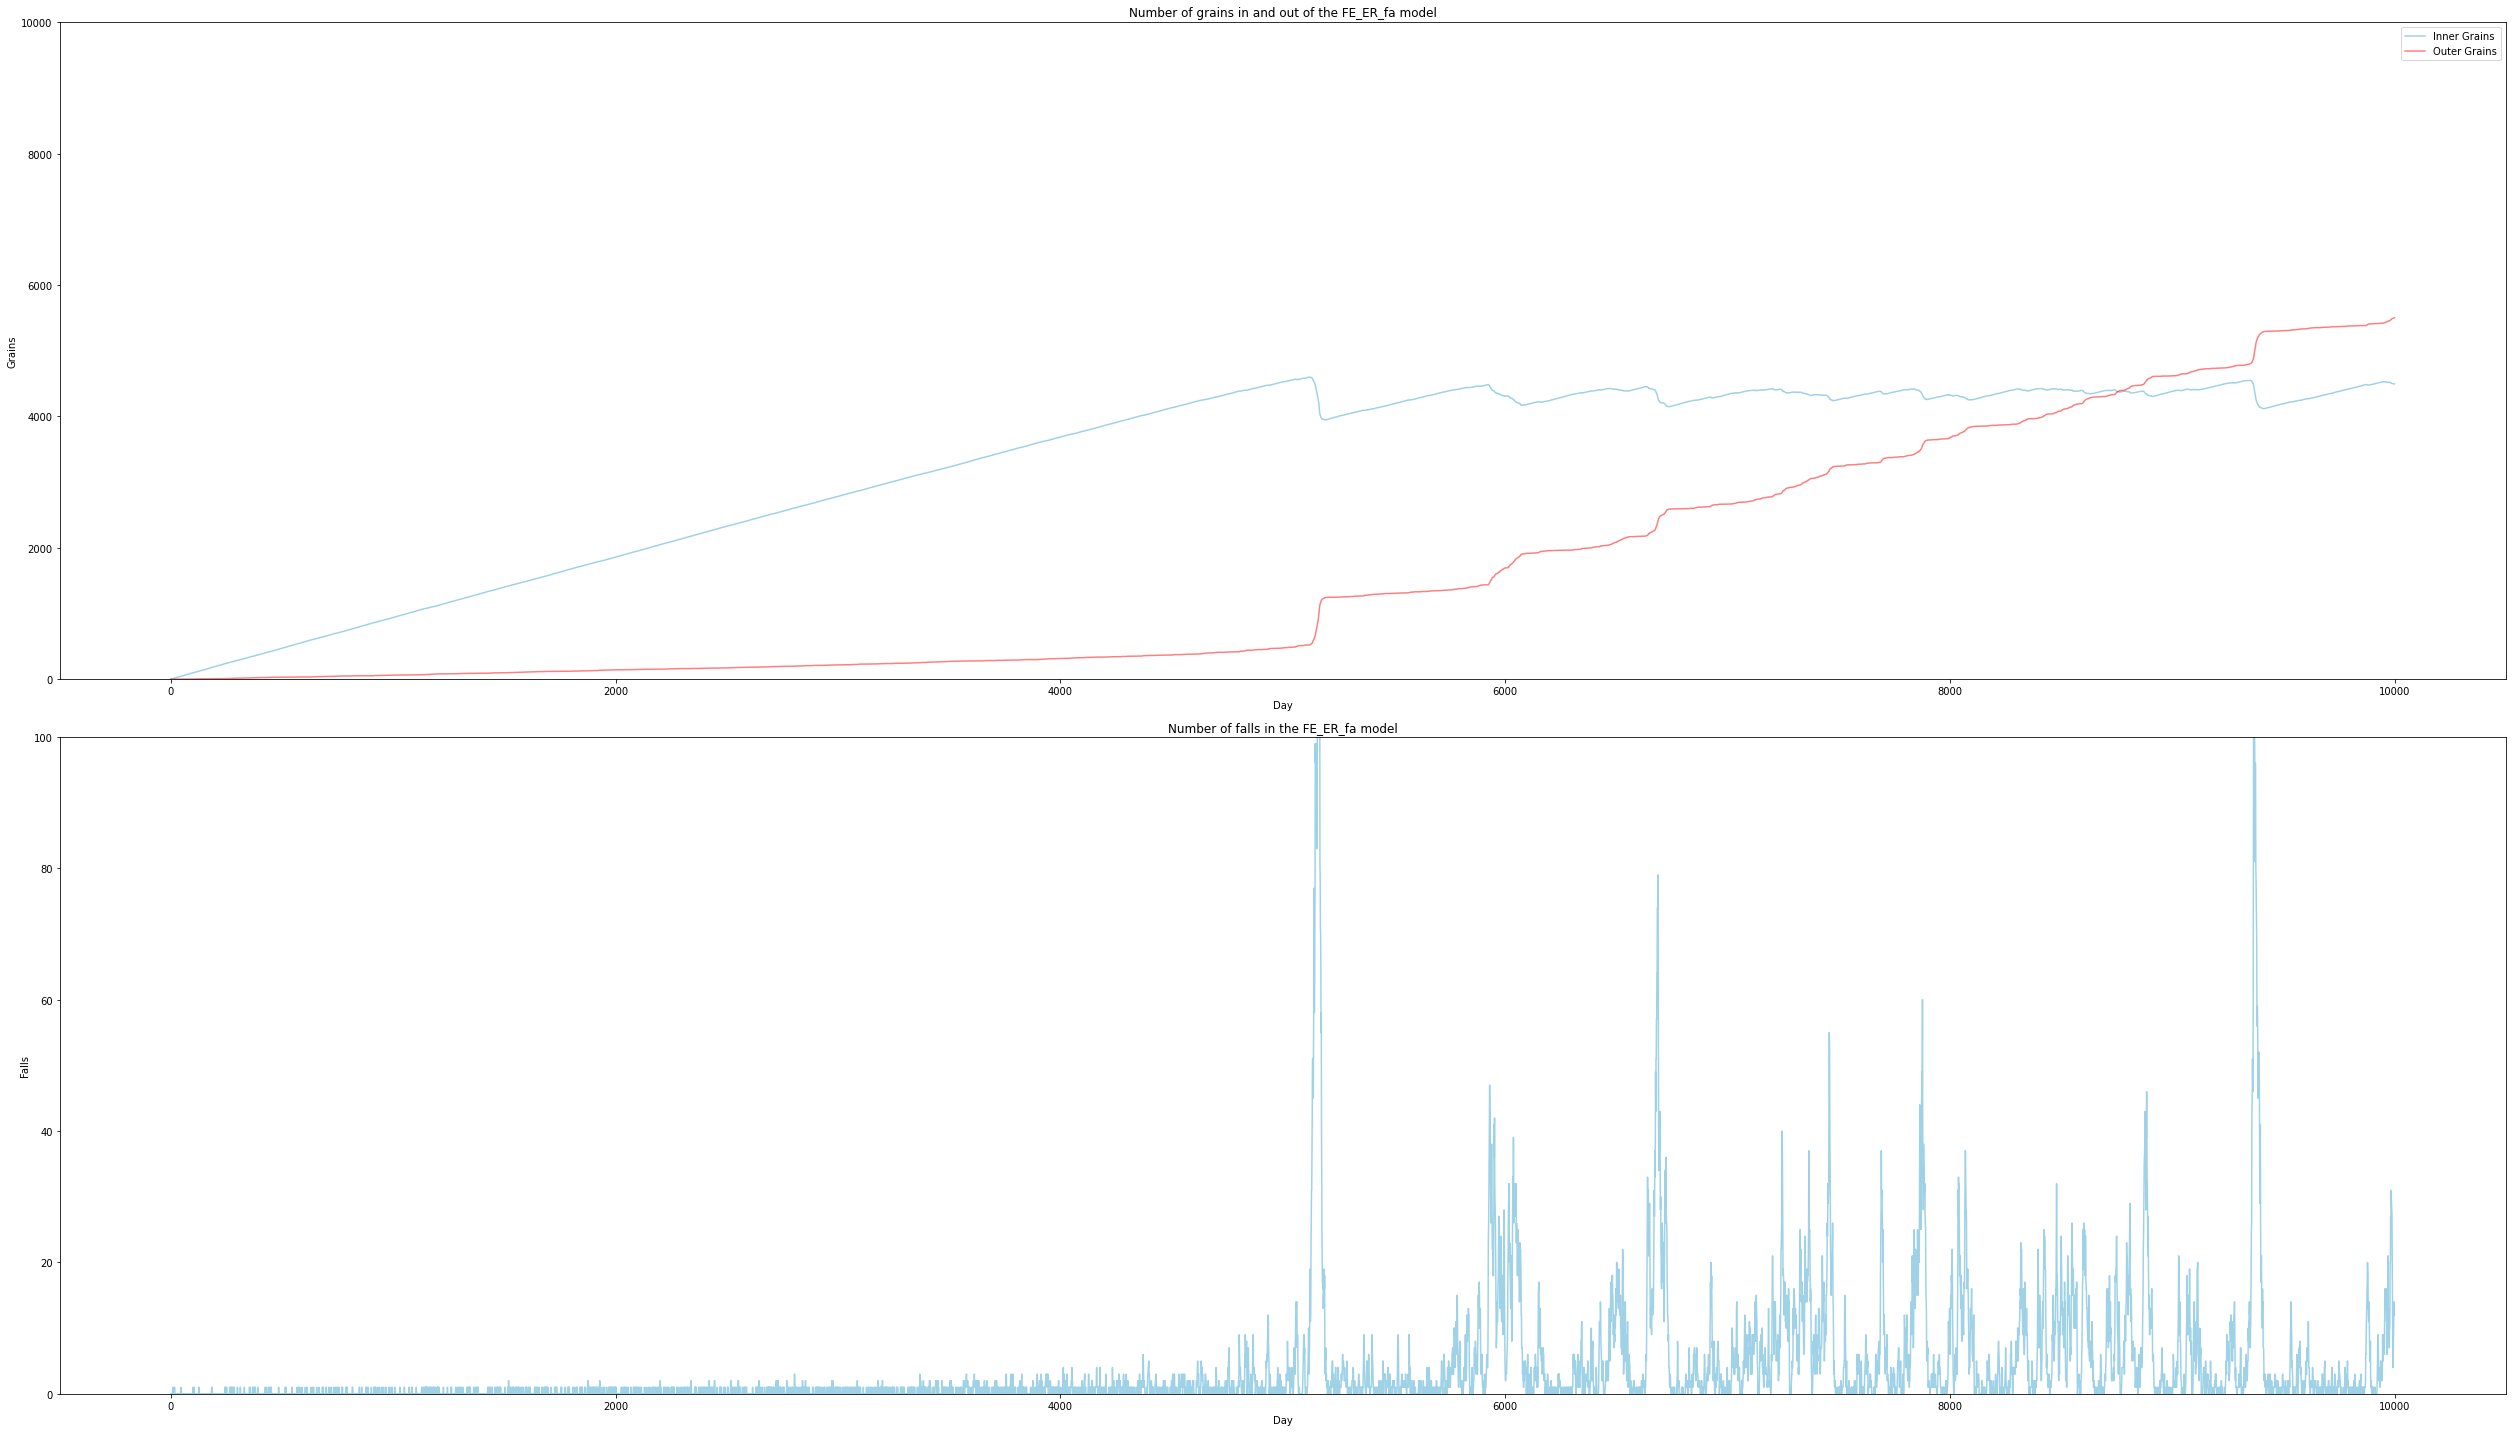

In [51]:
spread("FE", G_ER, number_of_days, new_grains, "ER", facilitated = True)

100%|██████████| 9999/9999 [01:57<00:00, 84.85it/s]


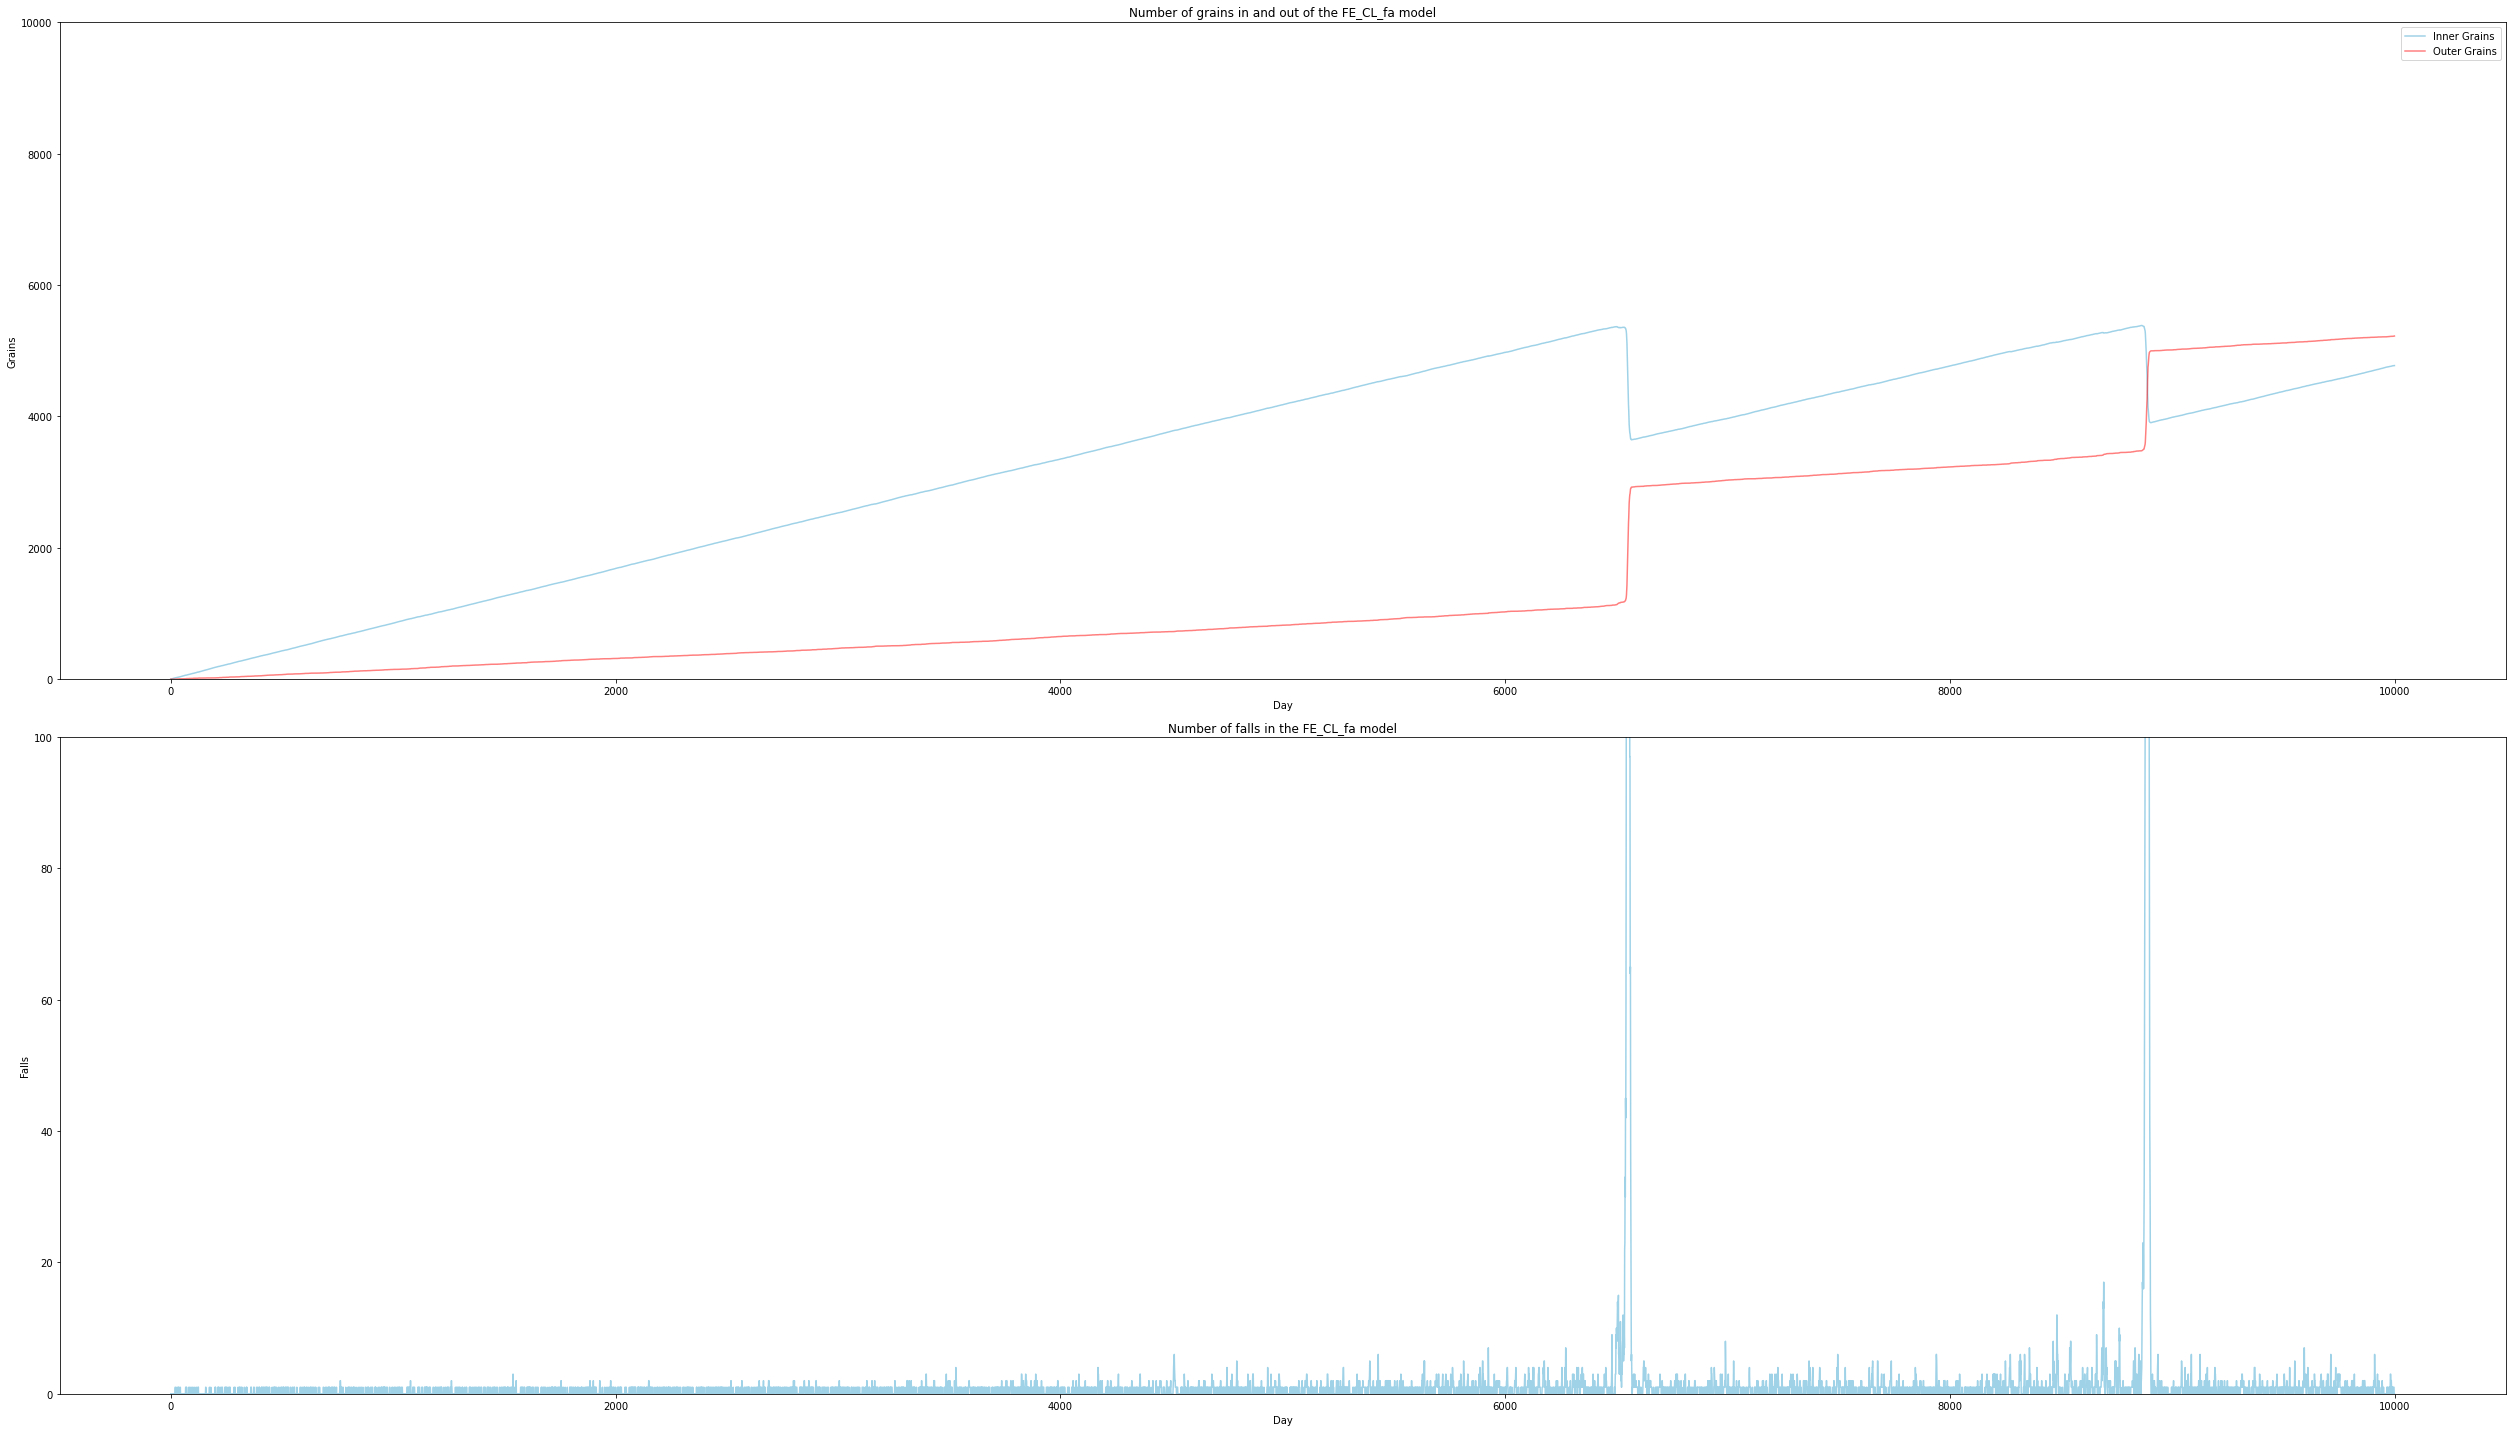

In [52]:
spread("FE", G_CL, number_of_days, new_grains, "CL", facilitated = True)

##### Additional Dissipation

100%|██████████| 9999/9999 [02:06<00:00, 79.09it/s]


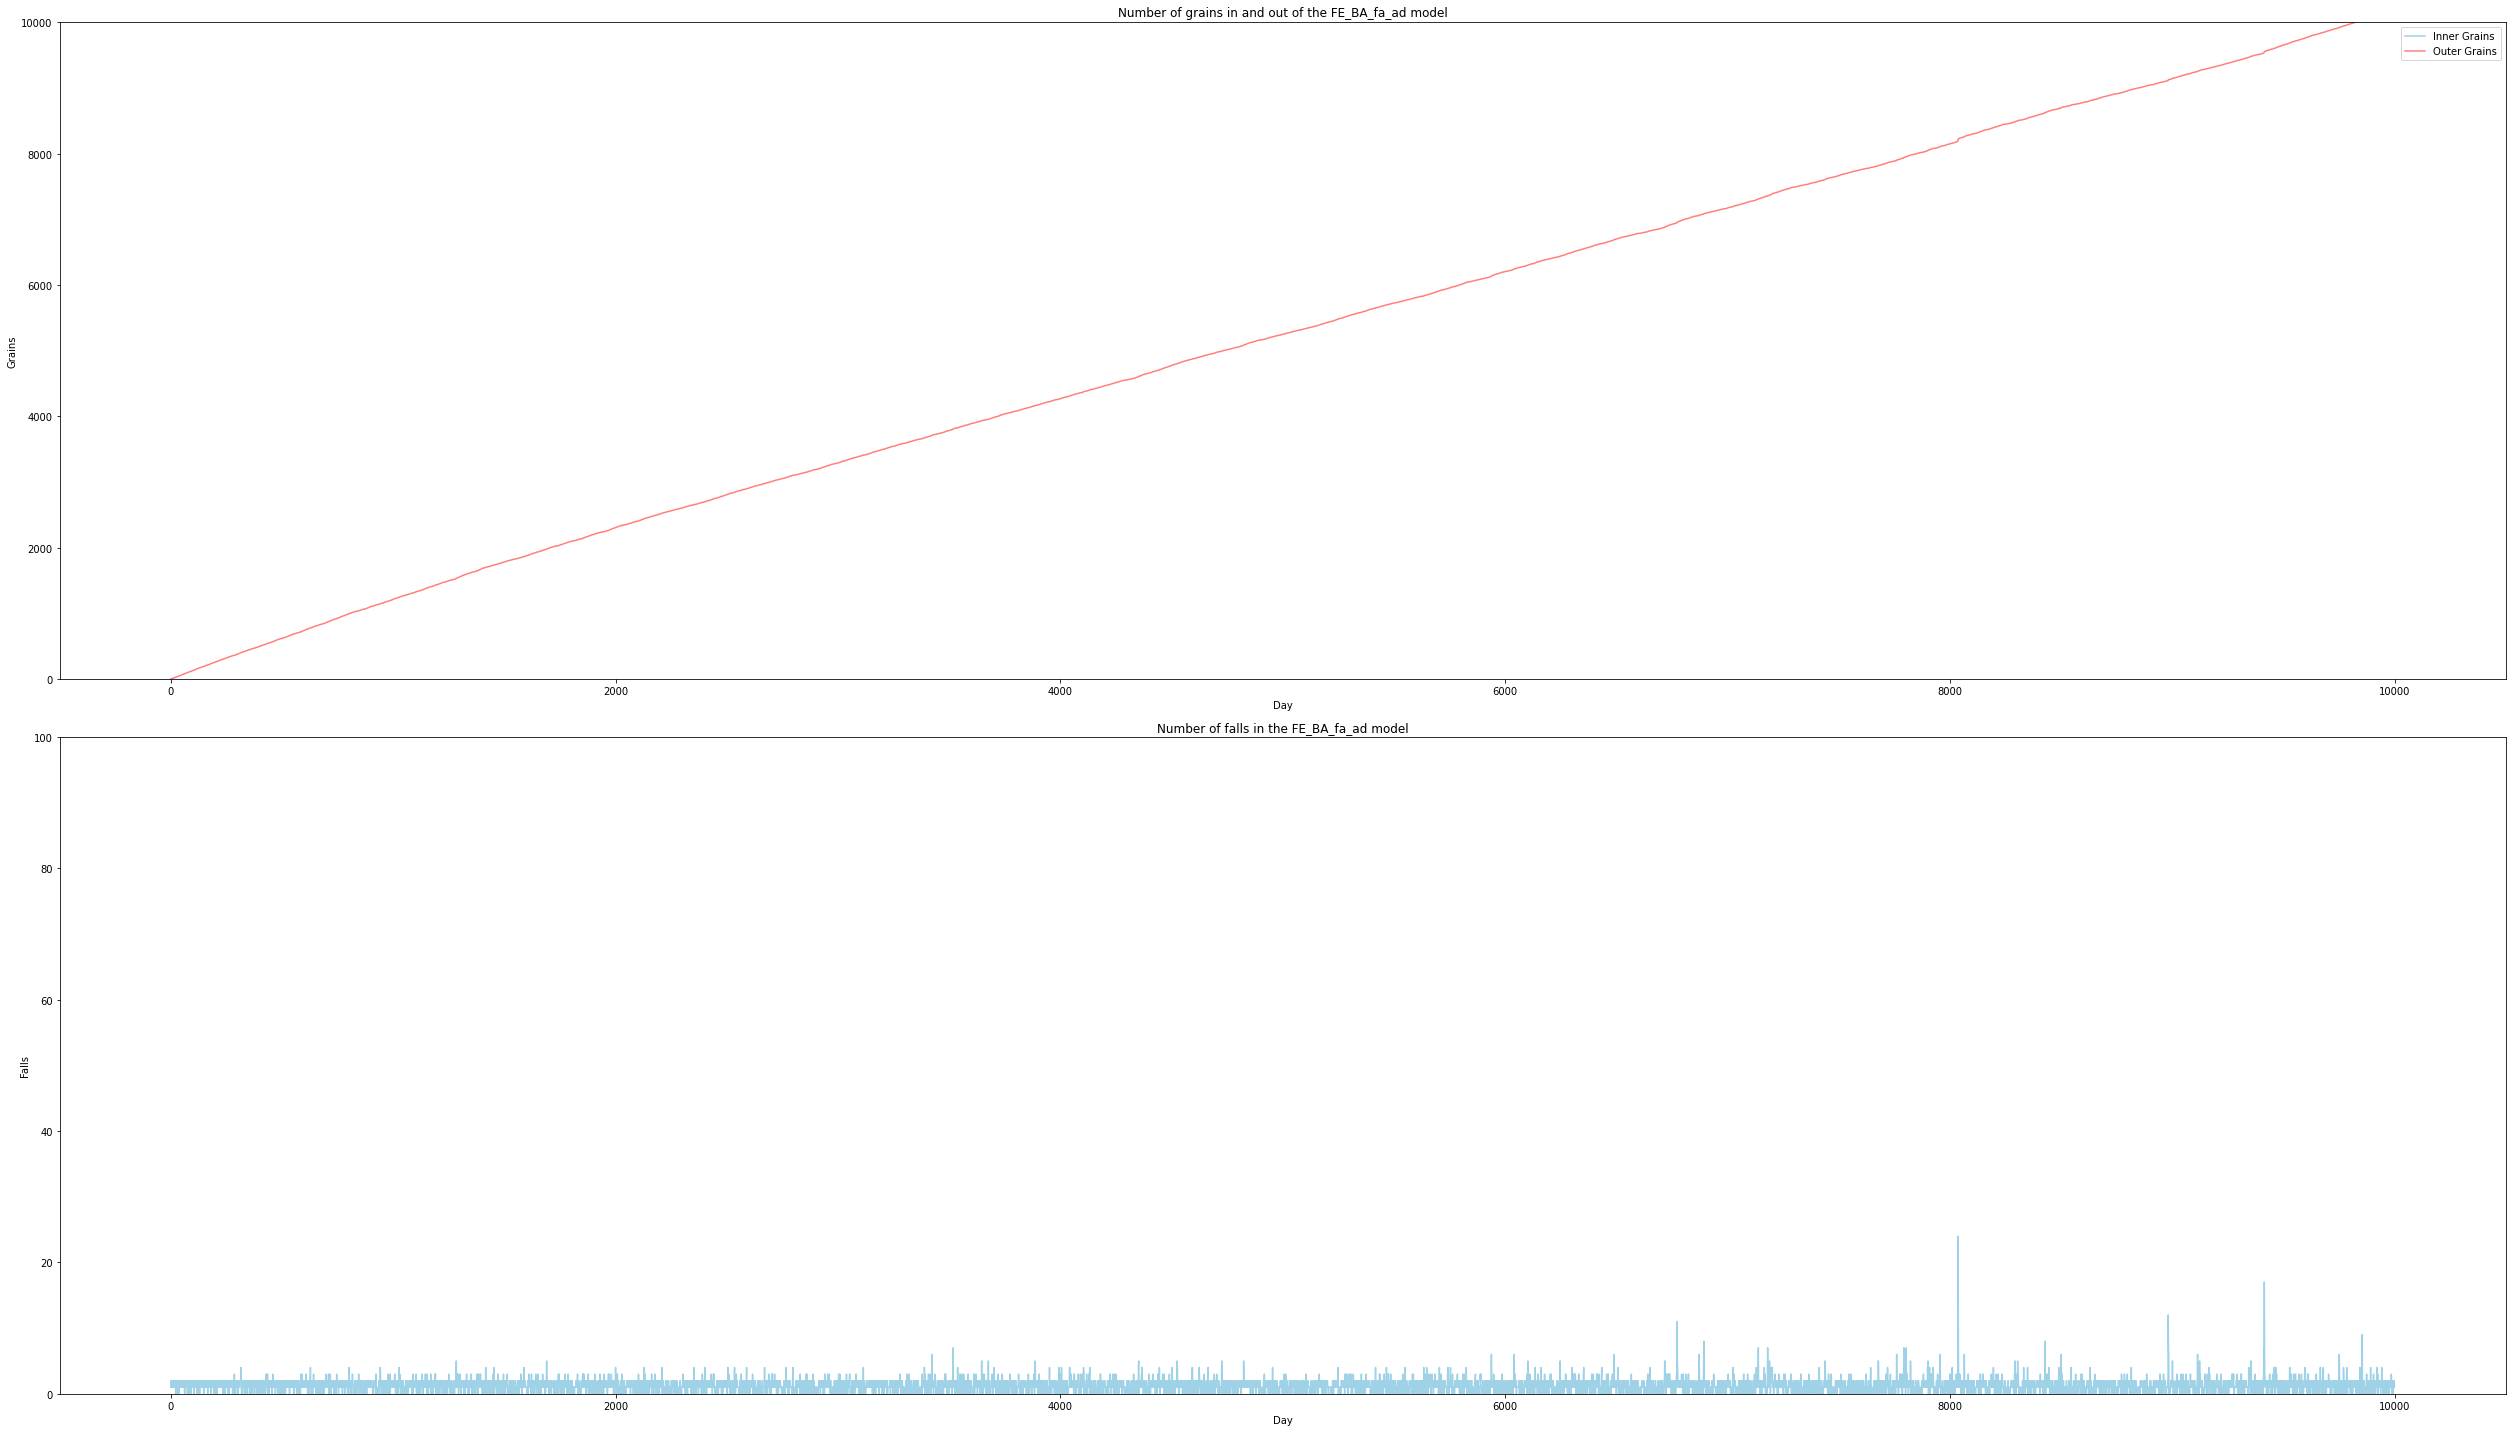

In [53]:
spread("FE", G_BA, number_of_days, new_grains, "BA", facilitated = True, ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

100%|██████████| 9999/9999 [02:12<00:00, 75.63it/s]


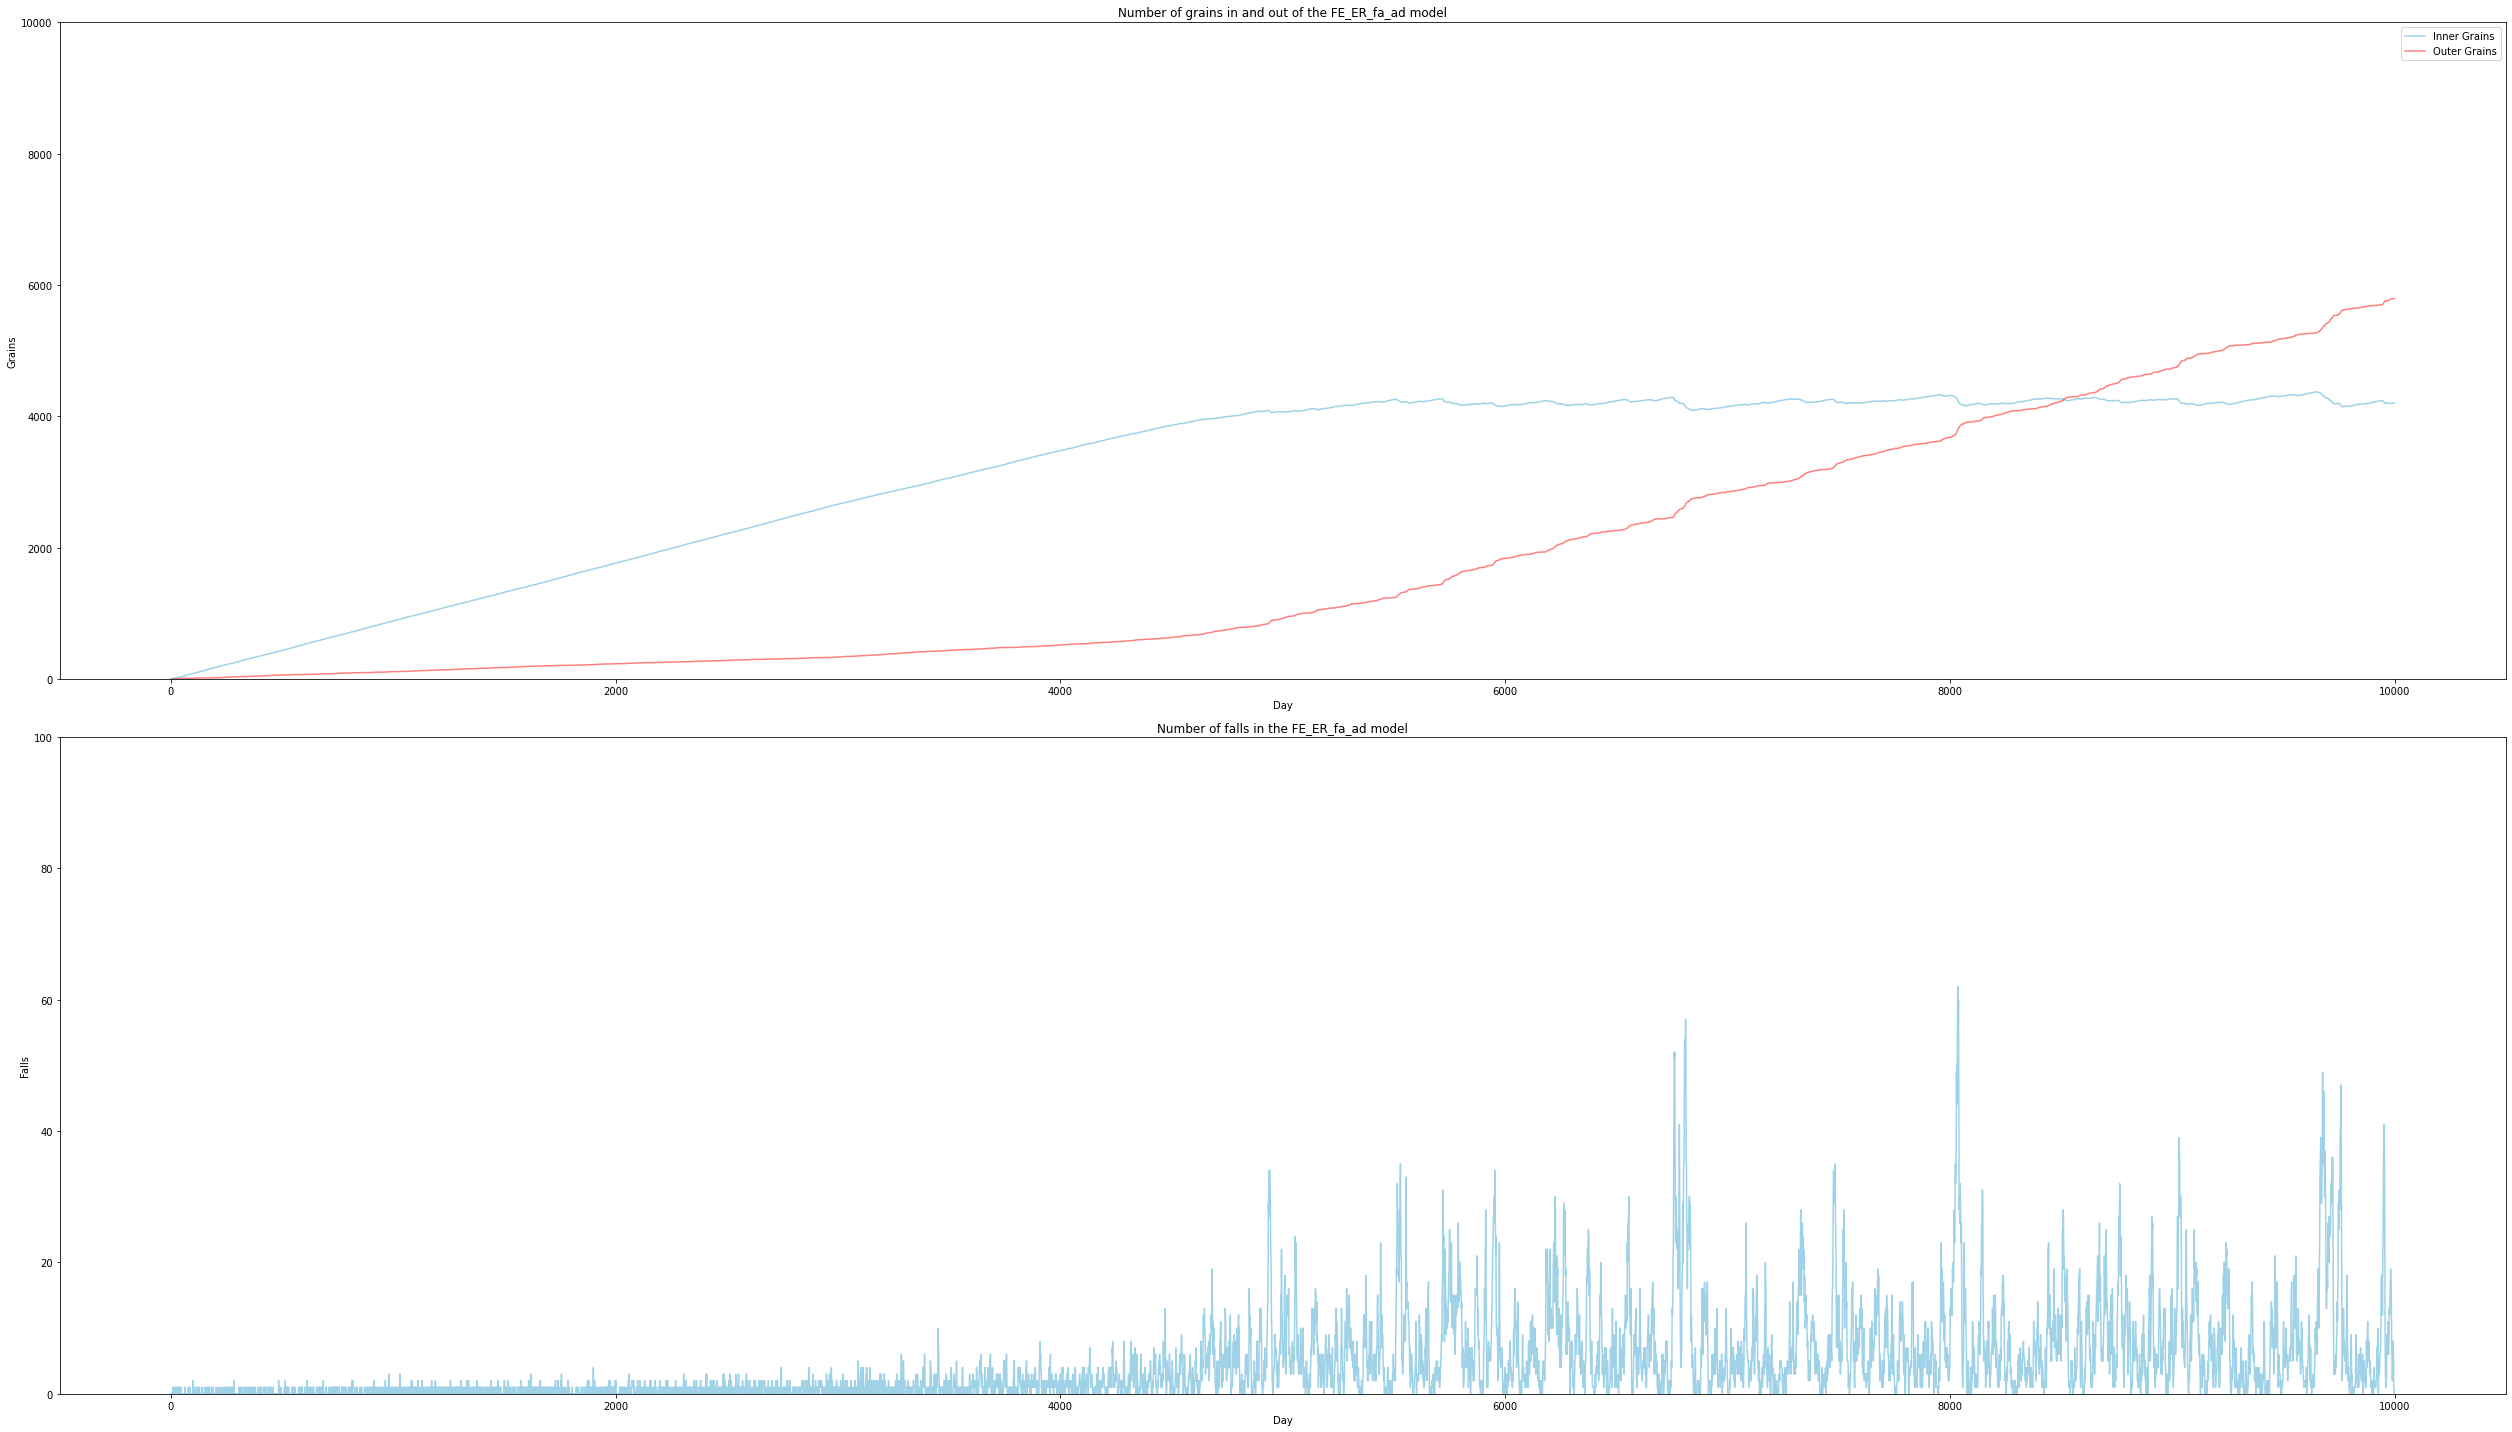

In [54]:
spread("FE", G_ER, number_of_days, new_grains, "ER", facilitated = True, ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

100%|██████████| 9999/9999 [02:09<00:00, 77.42it/s]


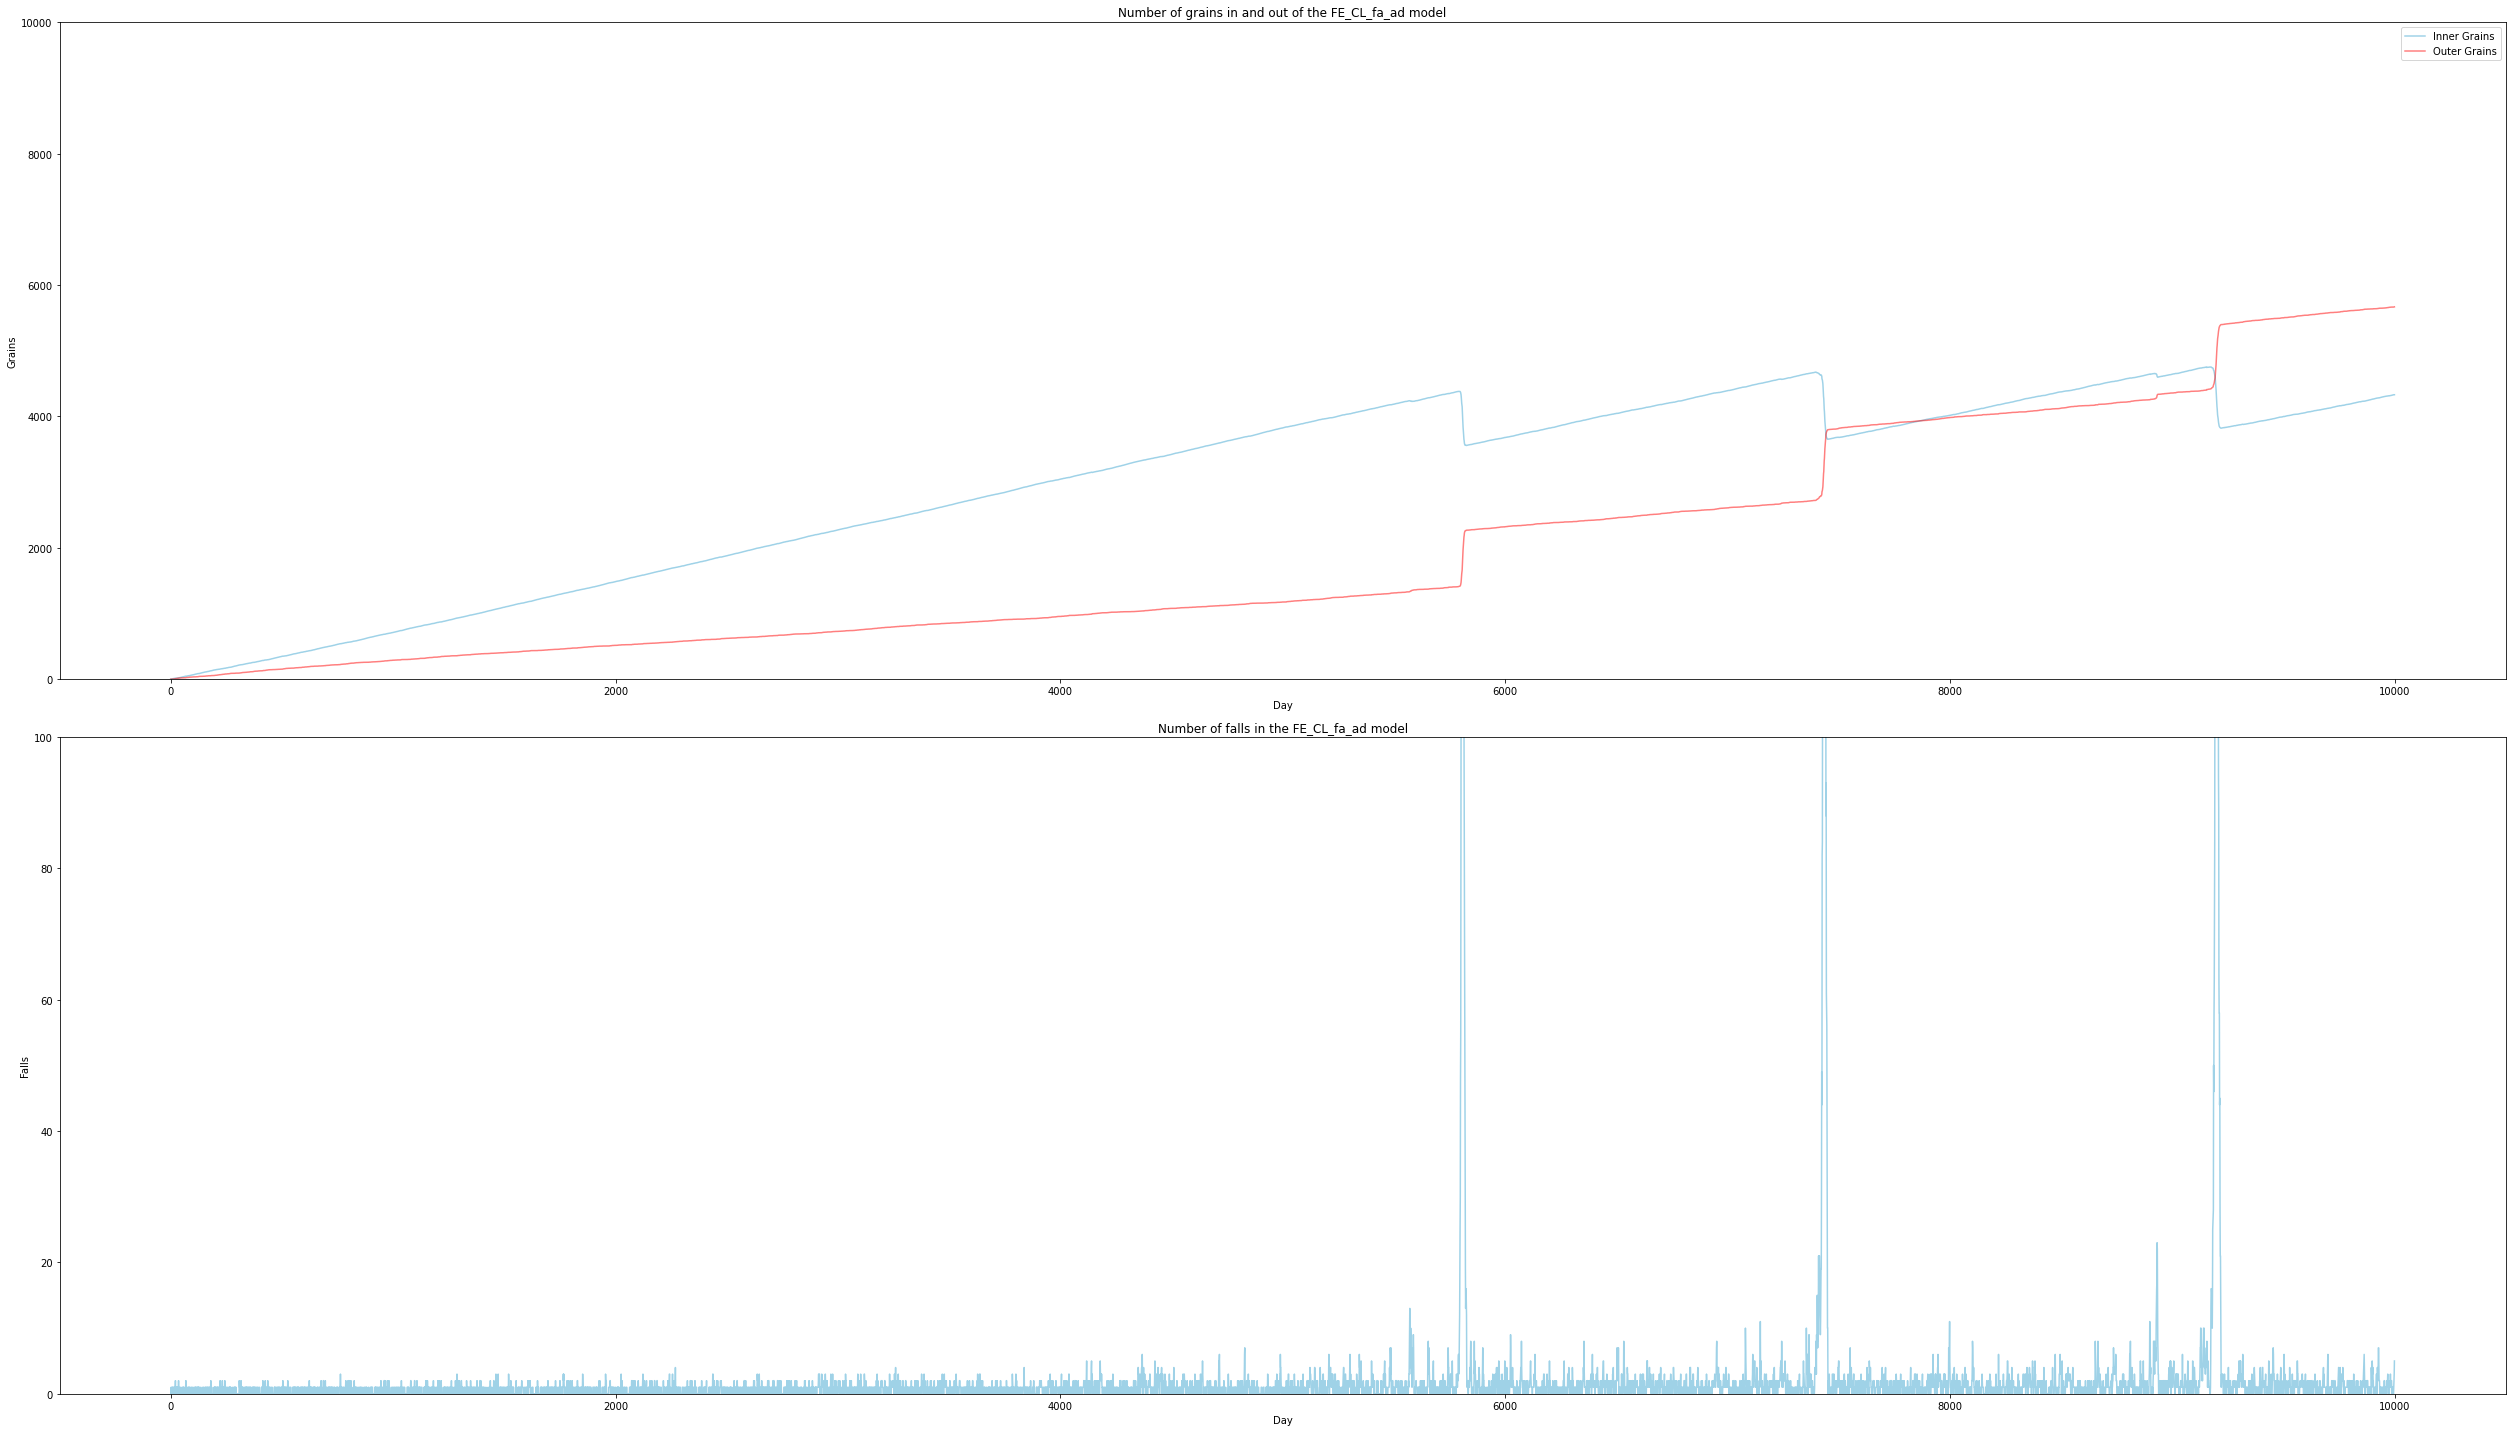

In [55]:
spread("FE", G_CL, number_of_days, new_grains, "CL", facilitated = True, ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

##### Neutral State

100%|██████████| 9999/9999 [01:48<00:00, 92.10it/s]


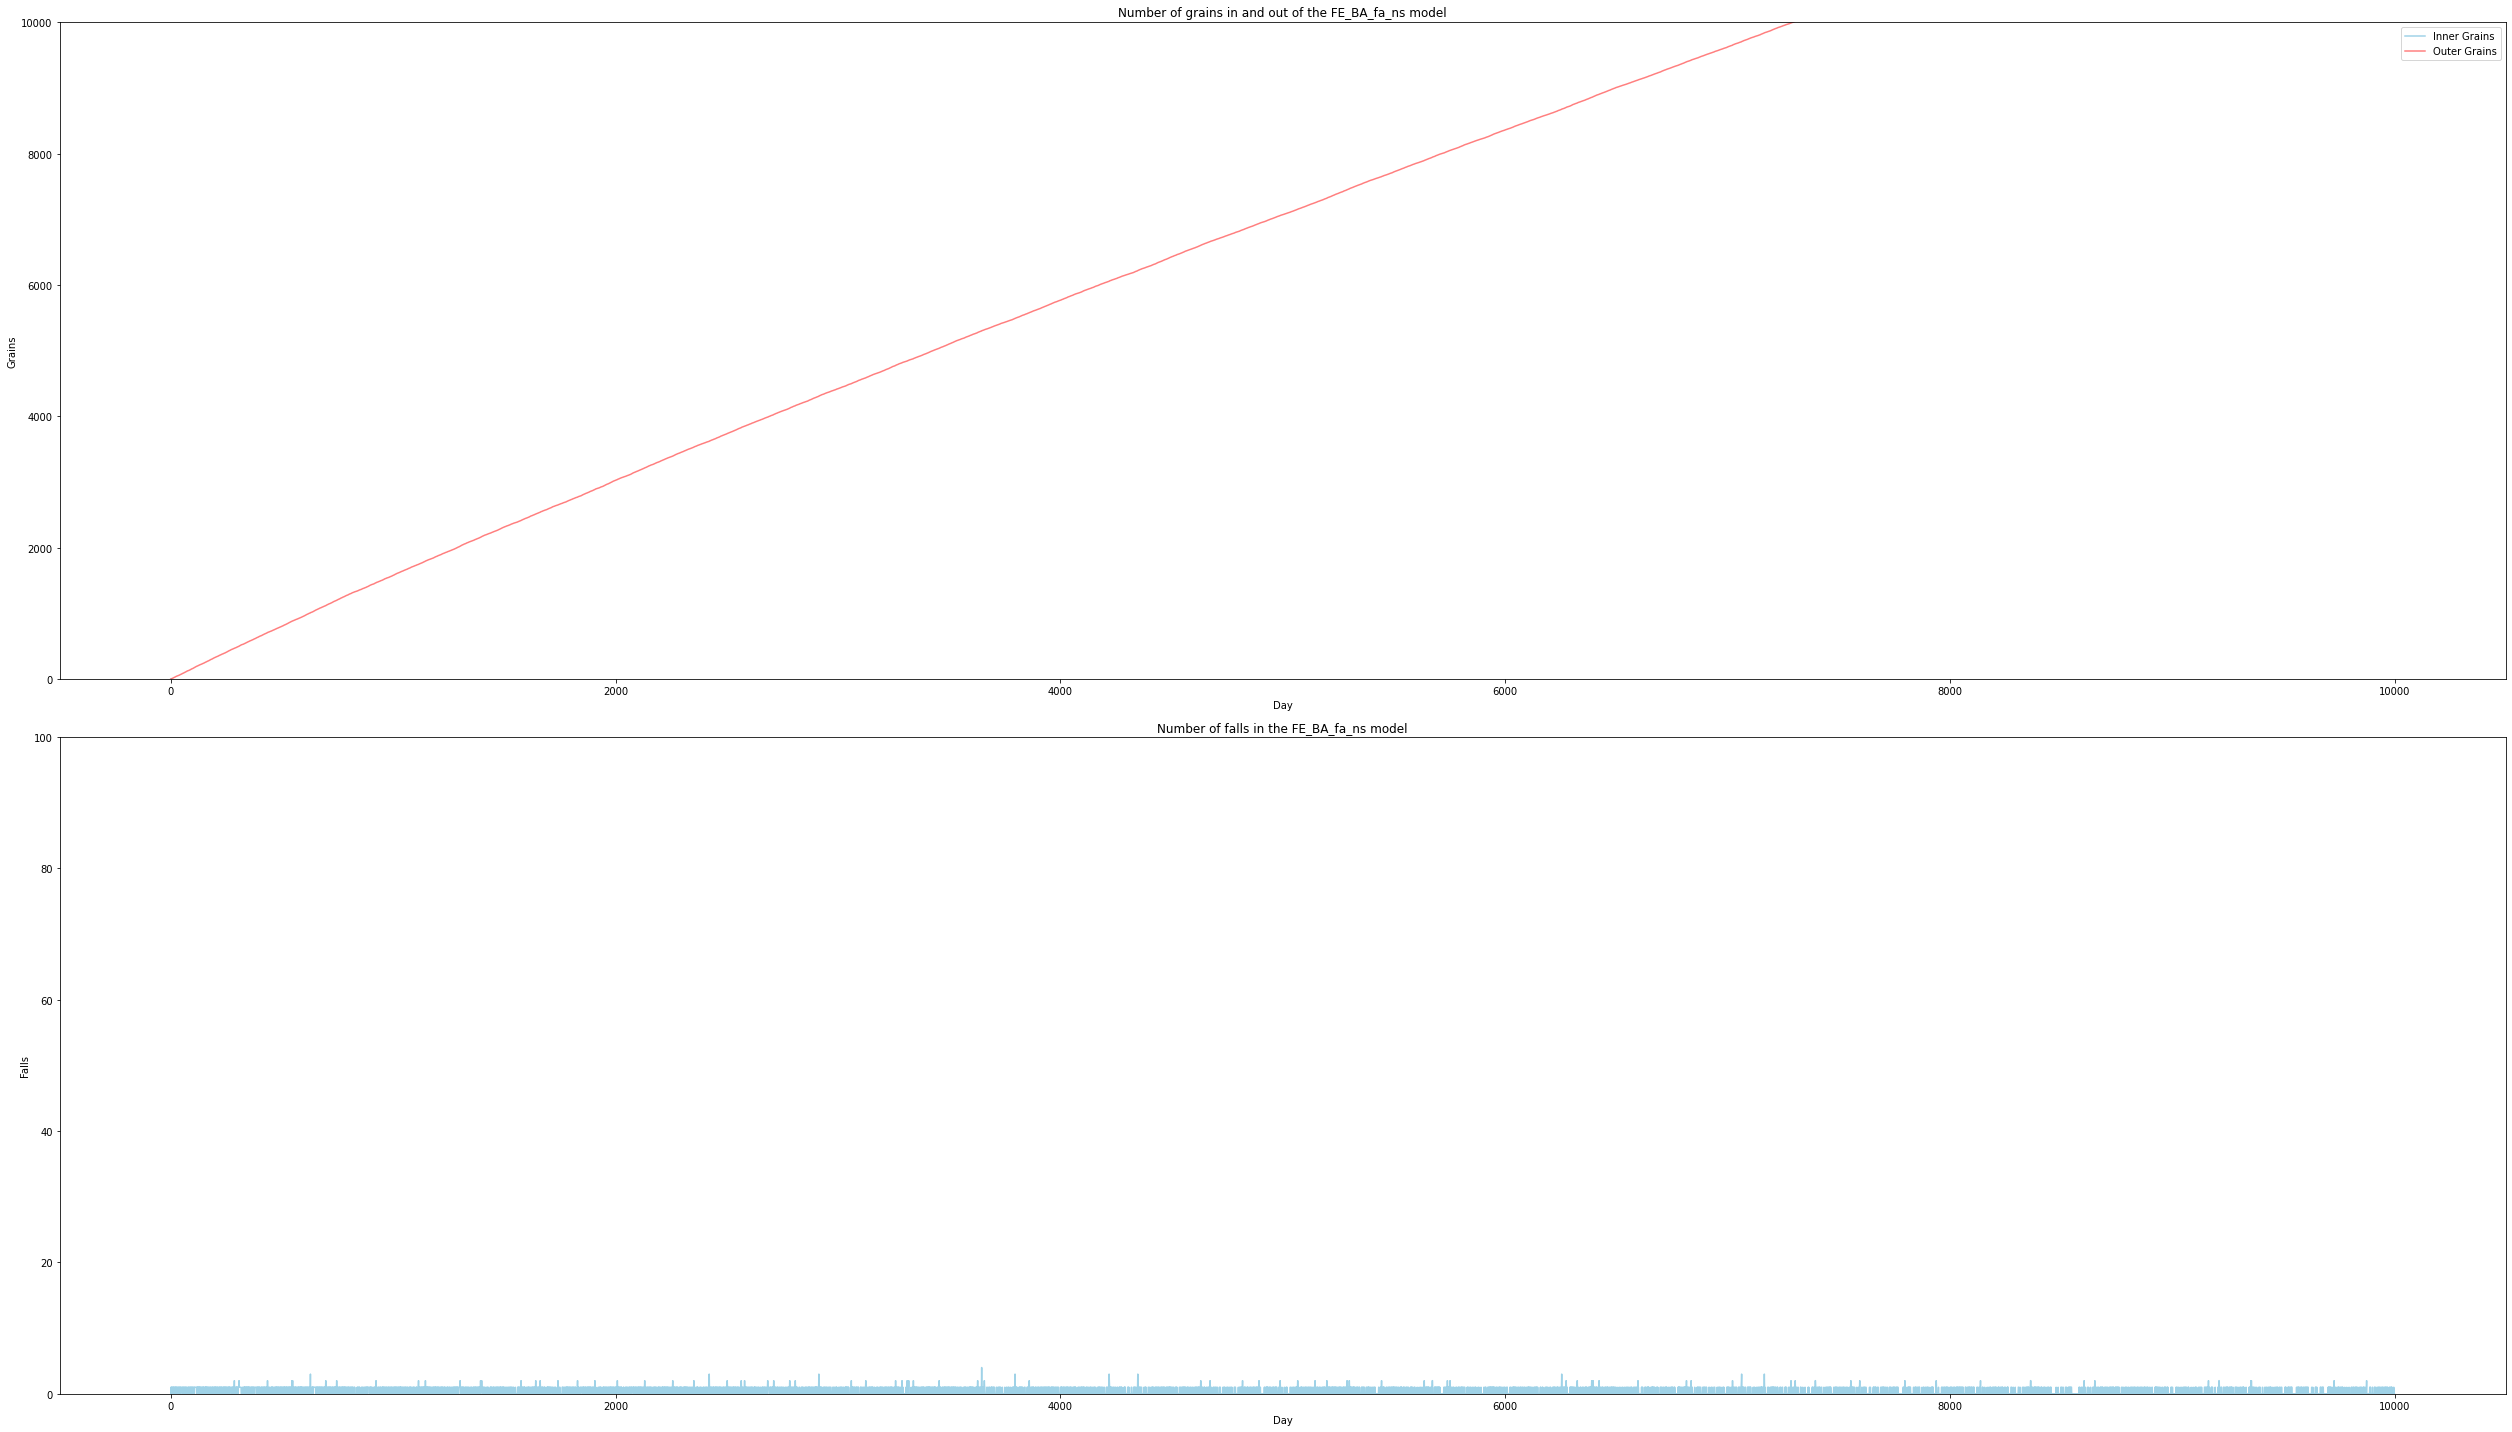

In [91]:
spread("FE", G_BA, number_of_days, new_grains, "BA", facilitated = True, neutral_state = True, new_grains_minus = new_grains_minus)

100%|██████████| 9999/9999 [01:48<00:00, 91.98it/s]


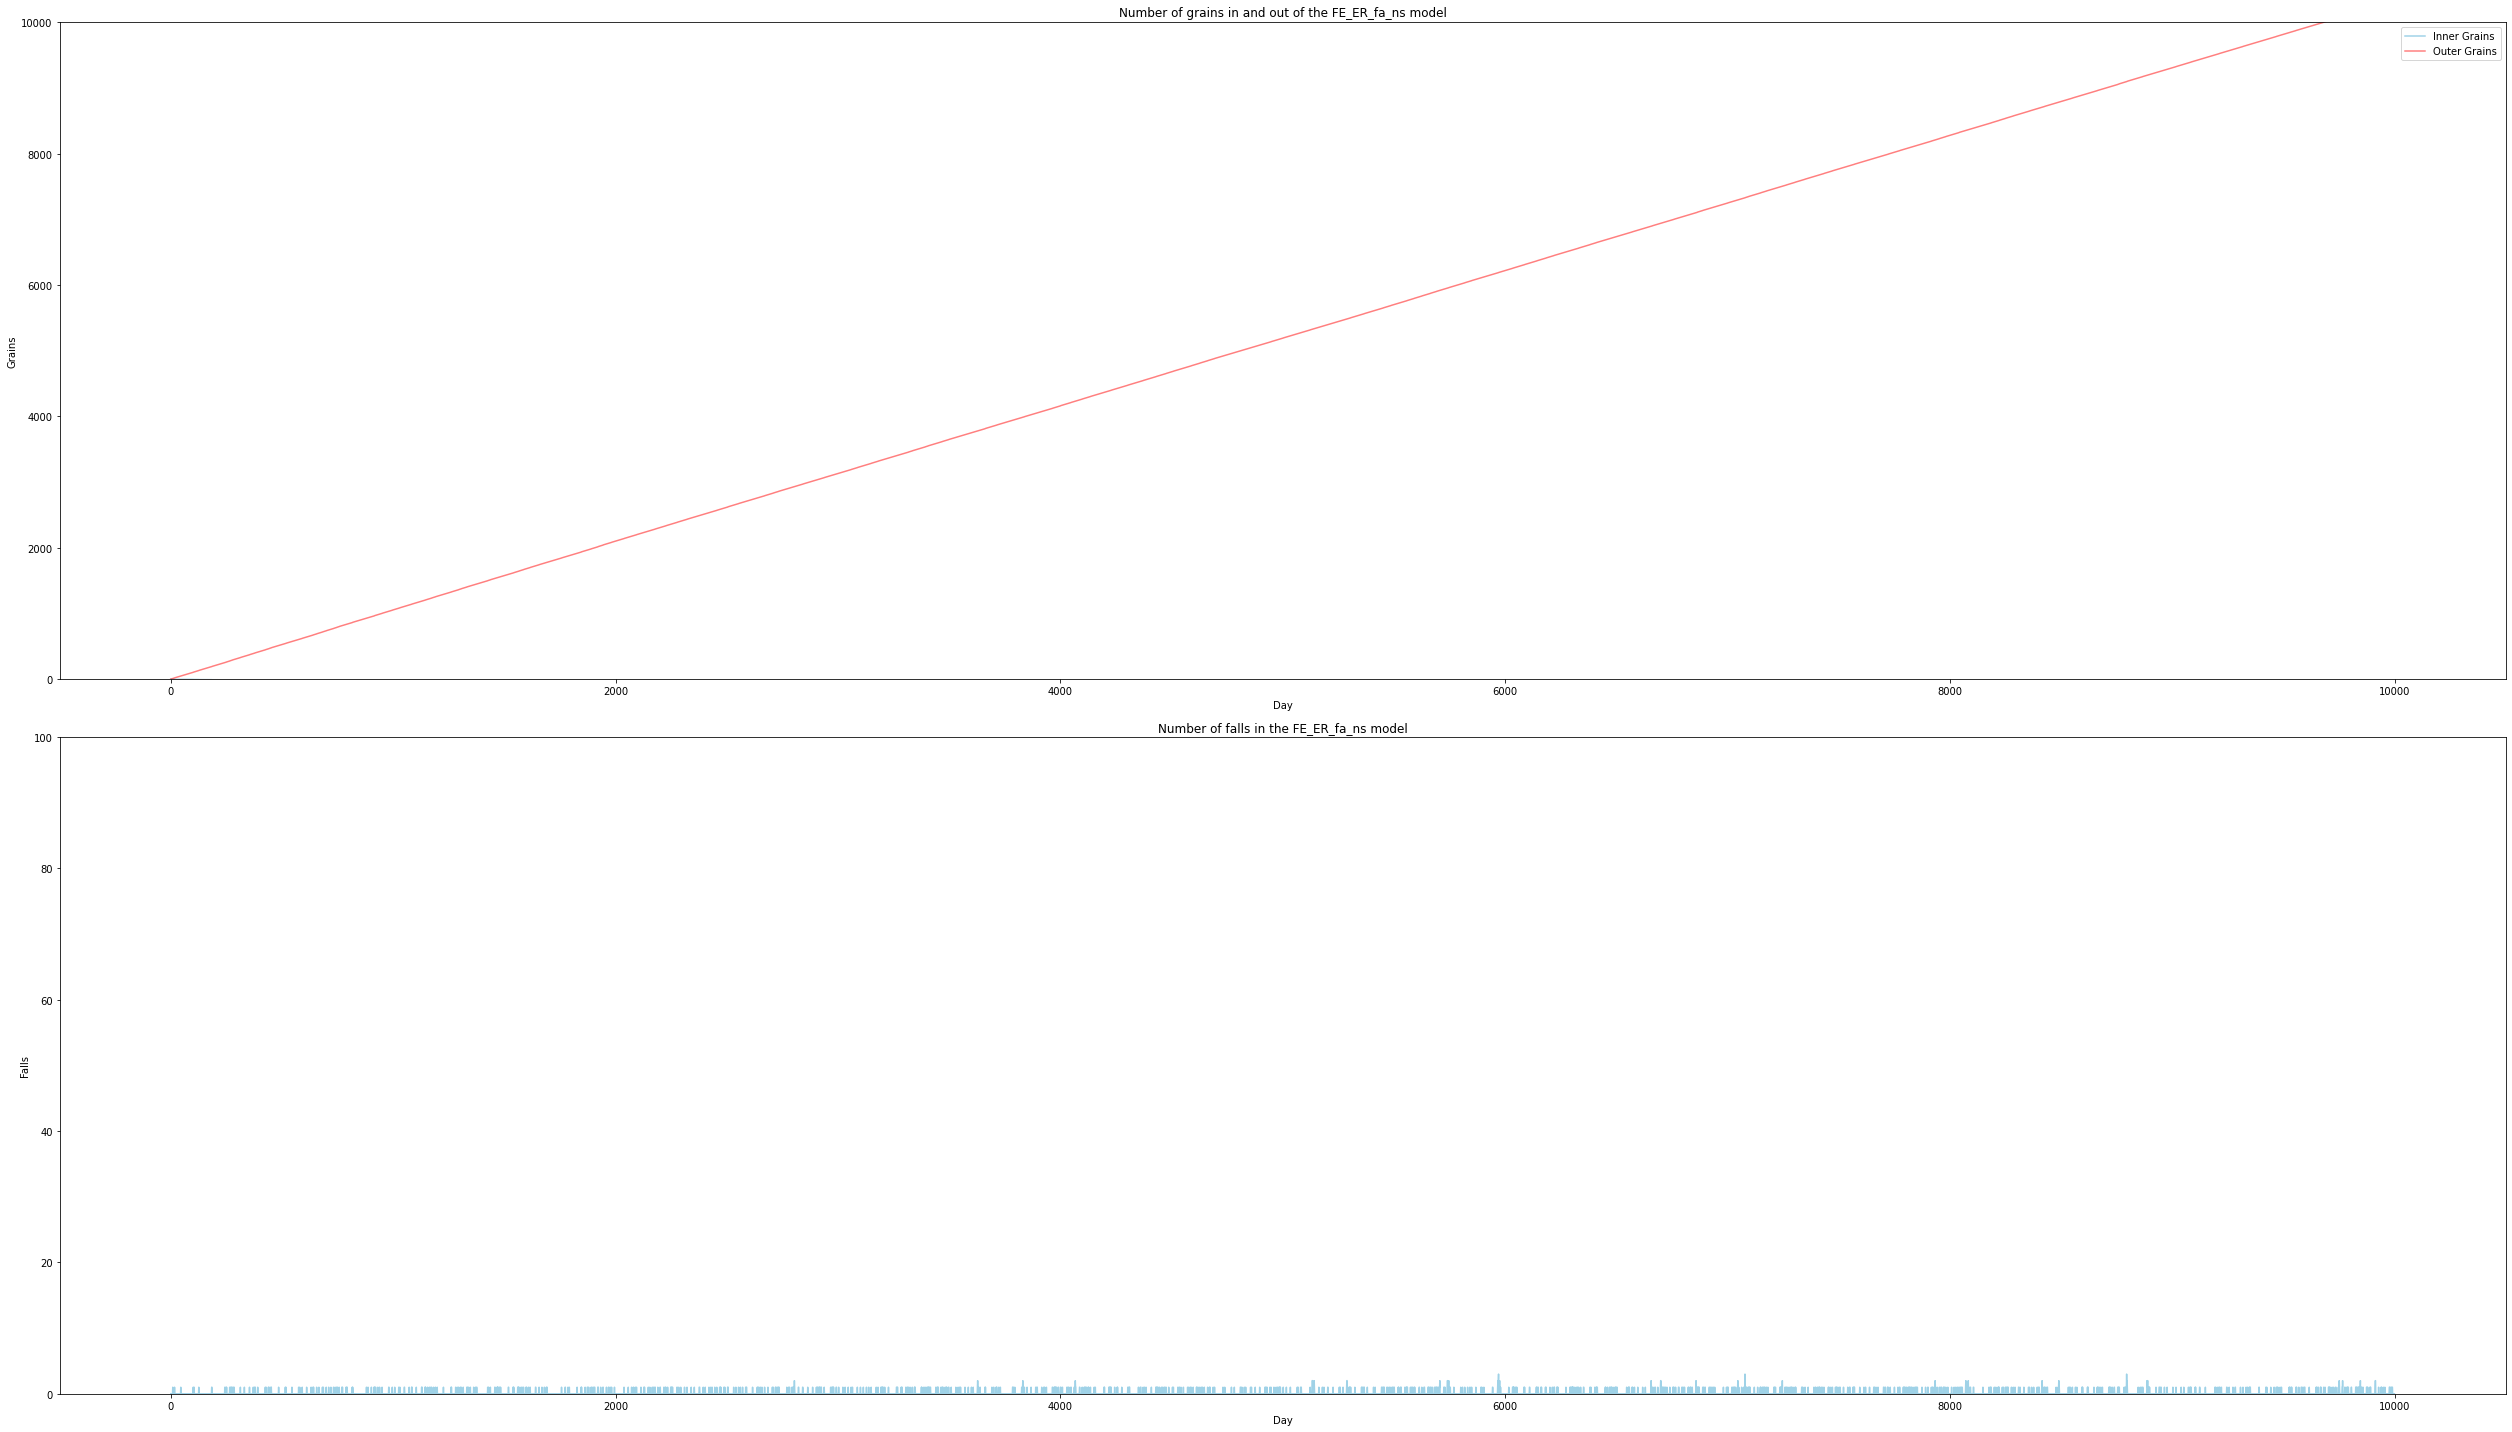

In [92]:
spread("FE", G_ER, number_of_days, new_grains, "ER", facilitated = True, neutral_state = True, new_grains_minus = new_grains_minus)

100%|██████████| 9999/9999 [01:43<00:00, 96.71it/s]


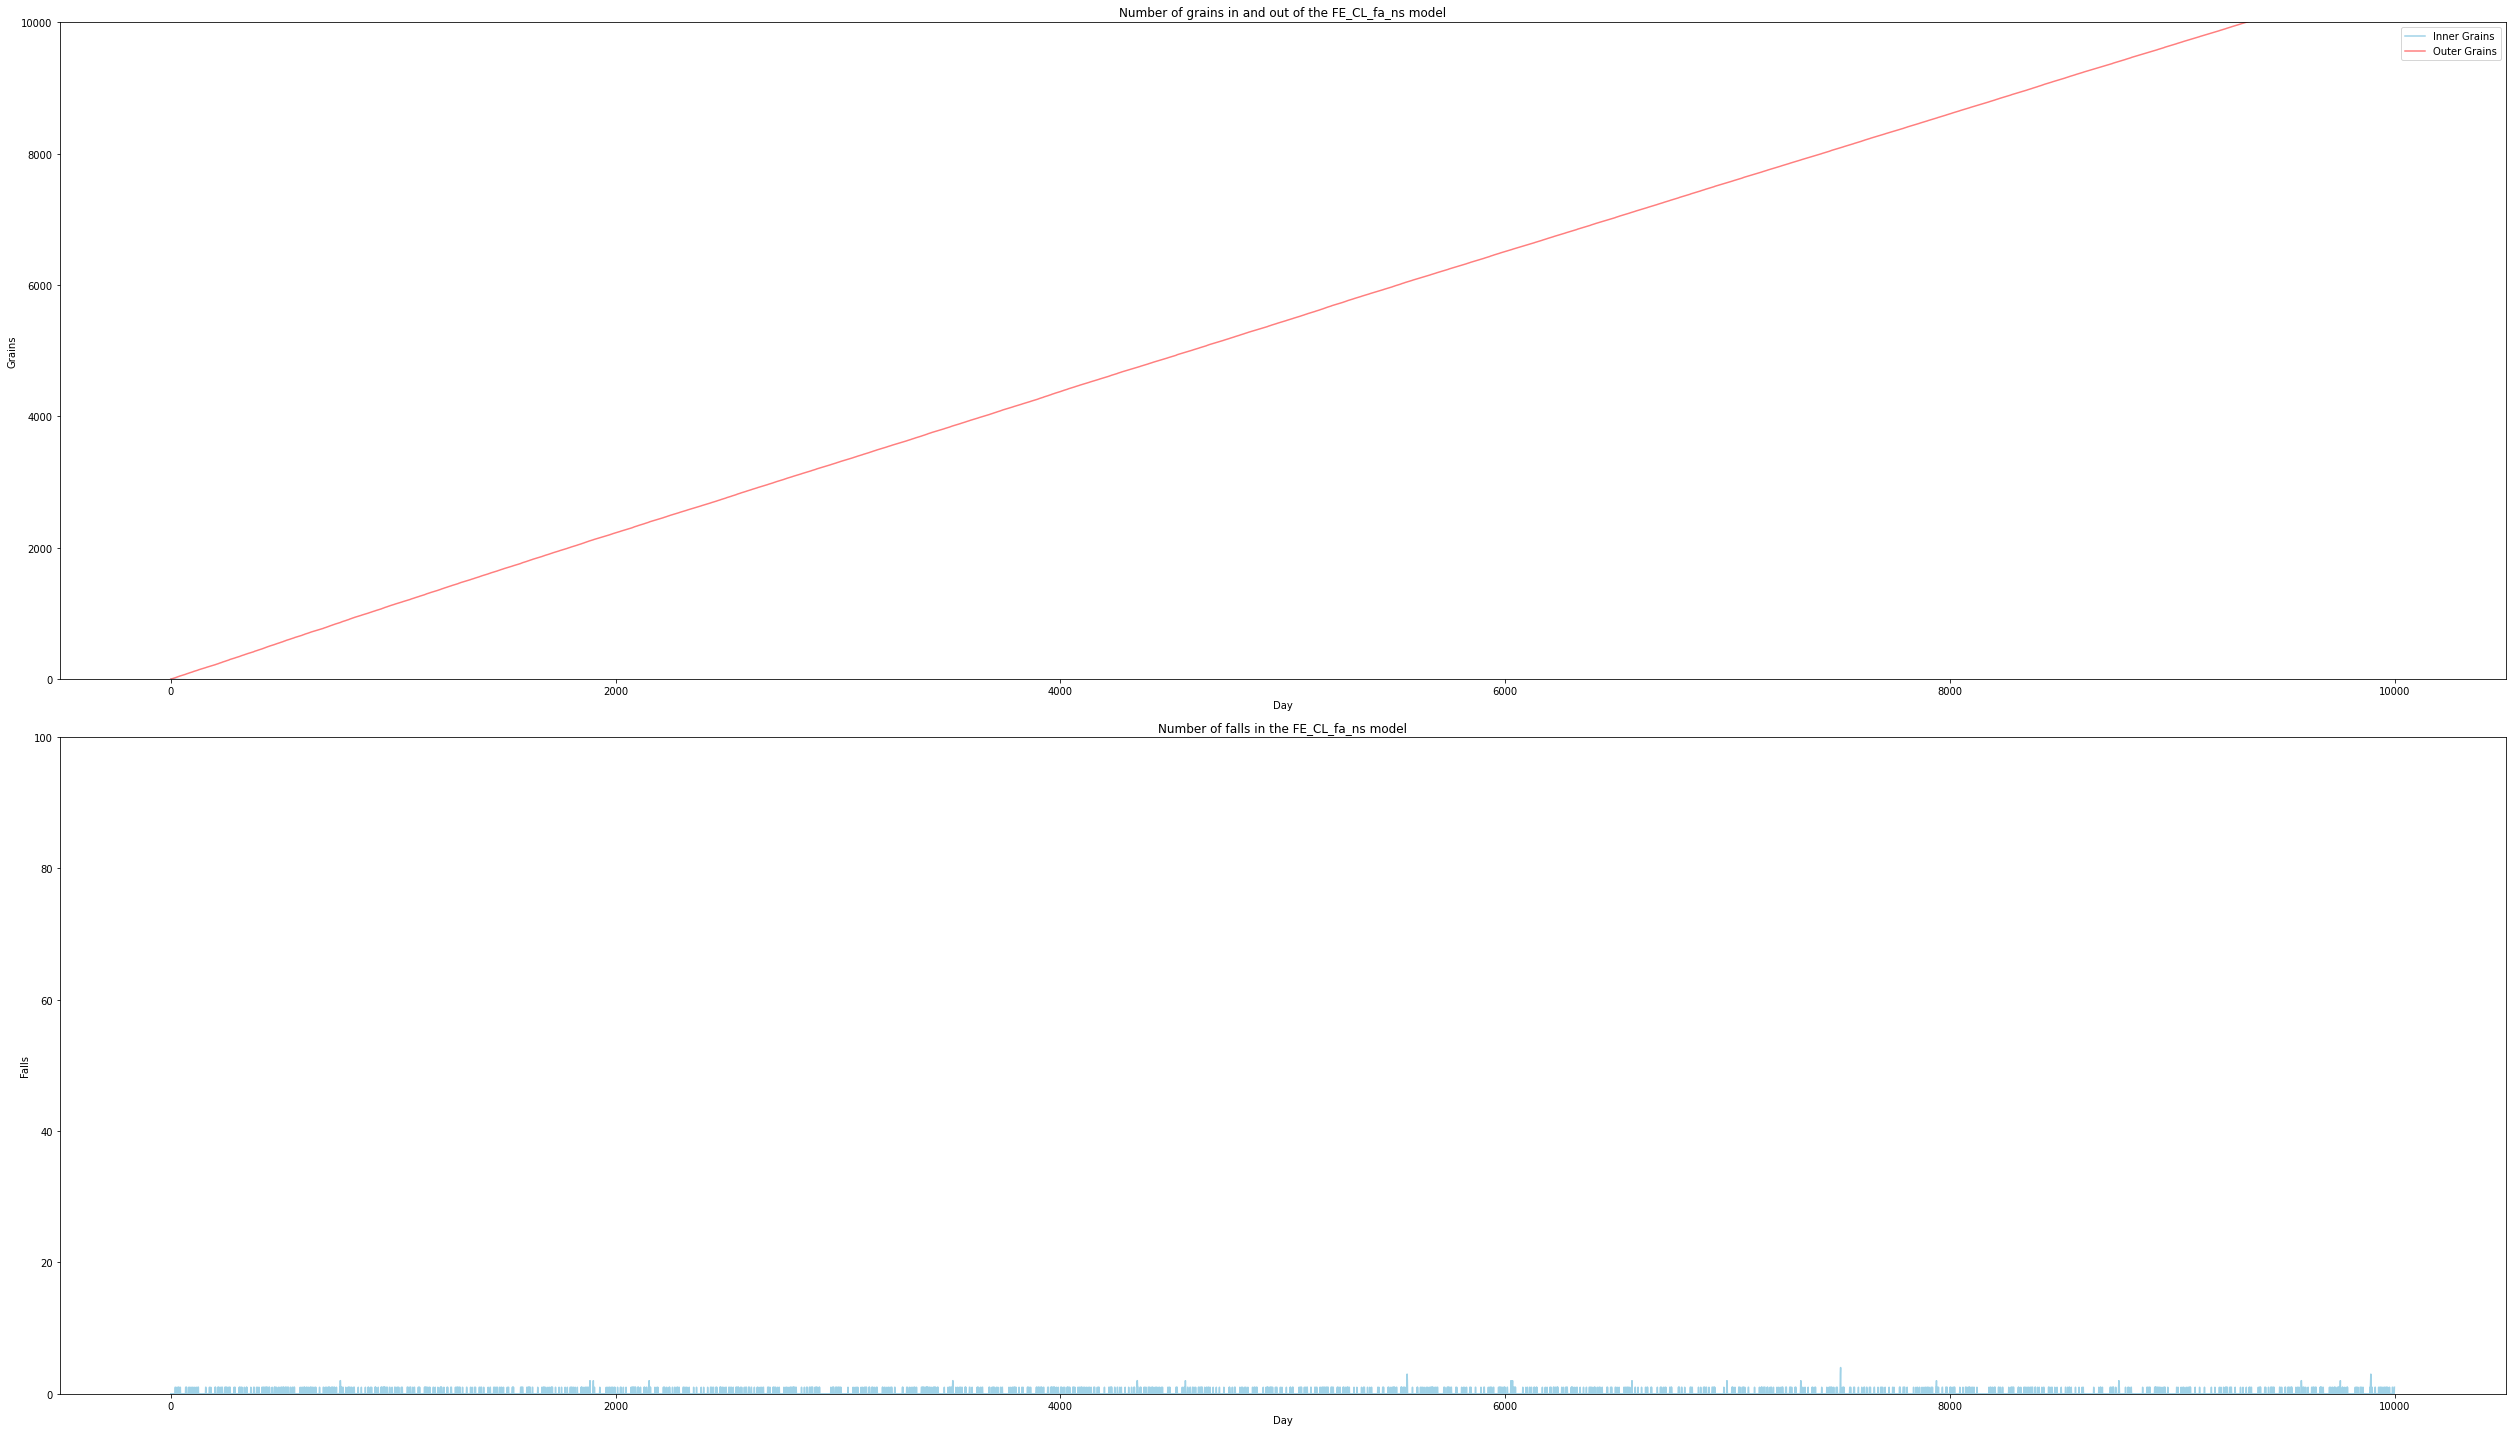

In [93]:
spread("FE", G_CL, number_of_days, new_grains, "CL", facilitated = True, neutral_state = True, new_grains_minus = new_grains_minus)

### Stochastic Feder

#### Standart Model

##### Standart Dissipation

100%|██████████| 9999/9999 [02:00<00:00, 82.82it/s]


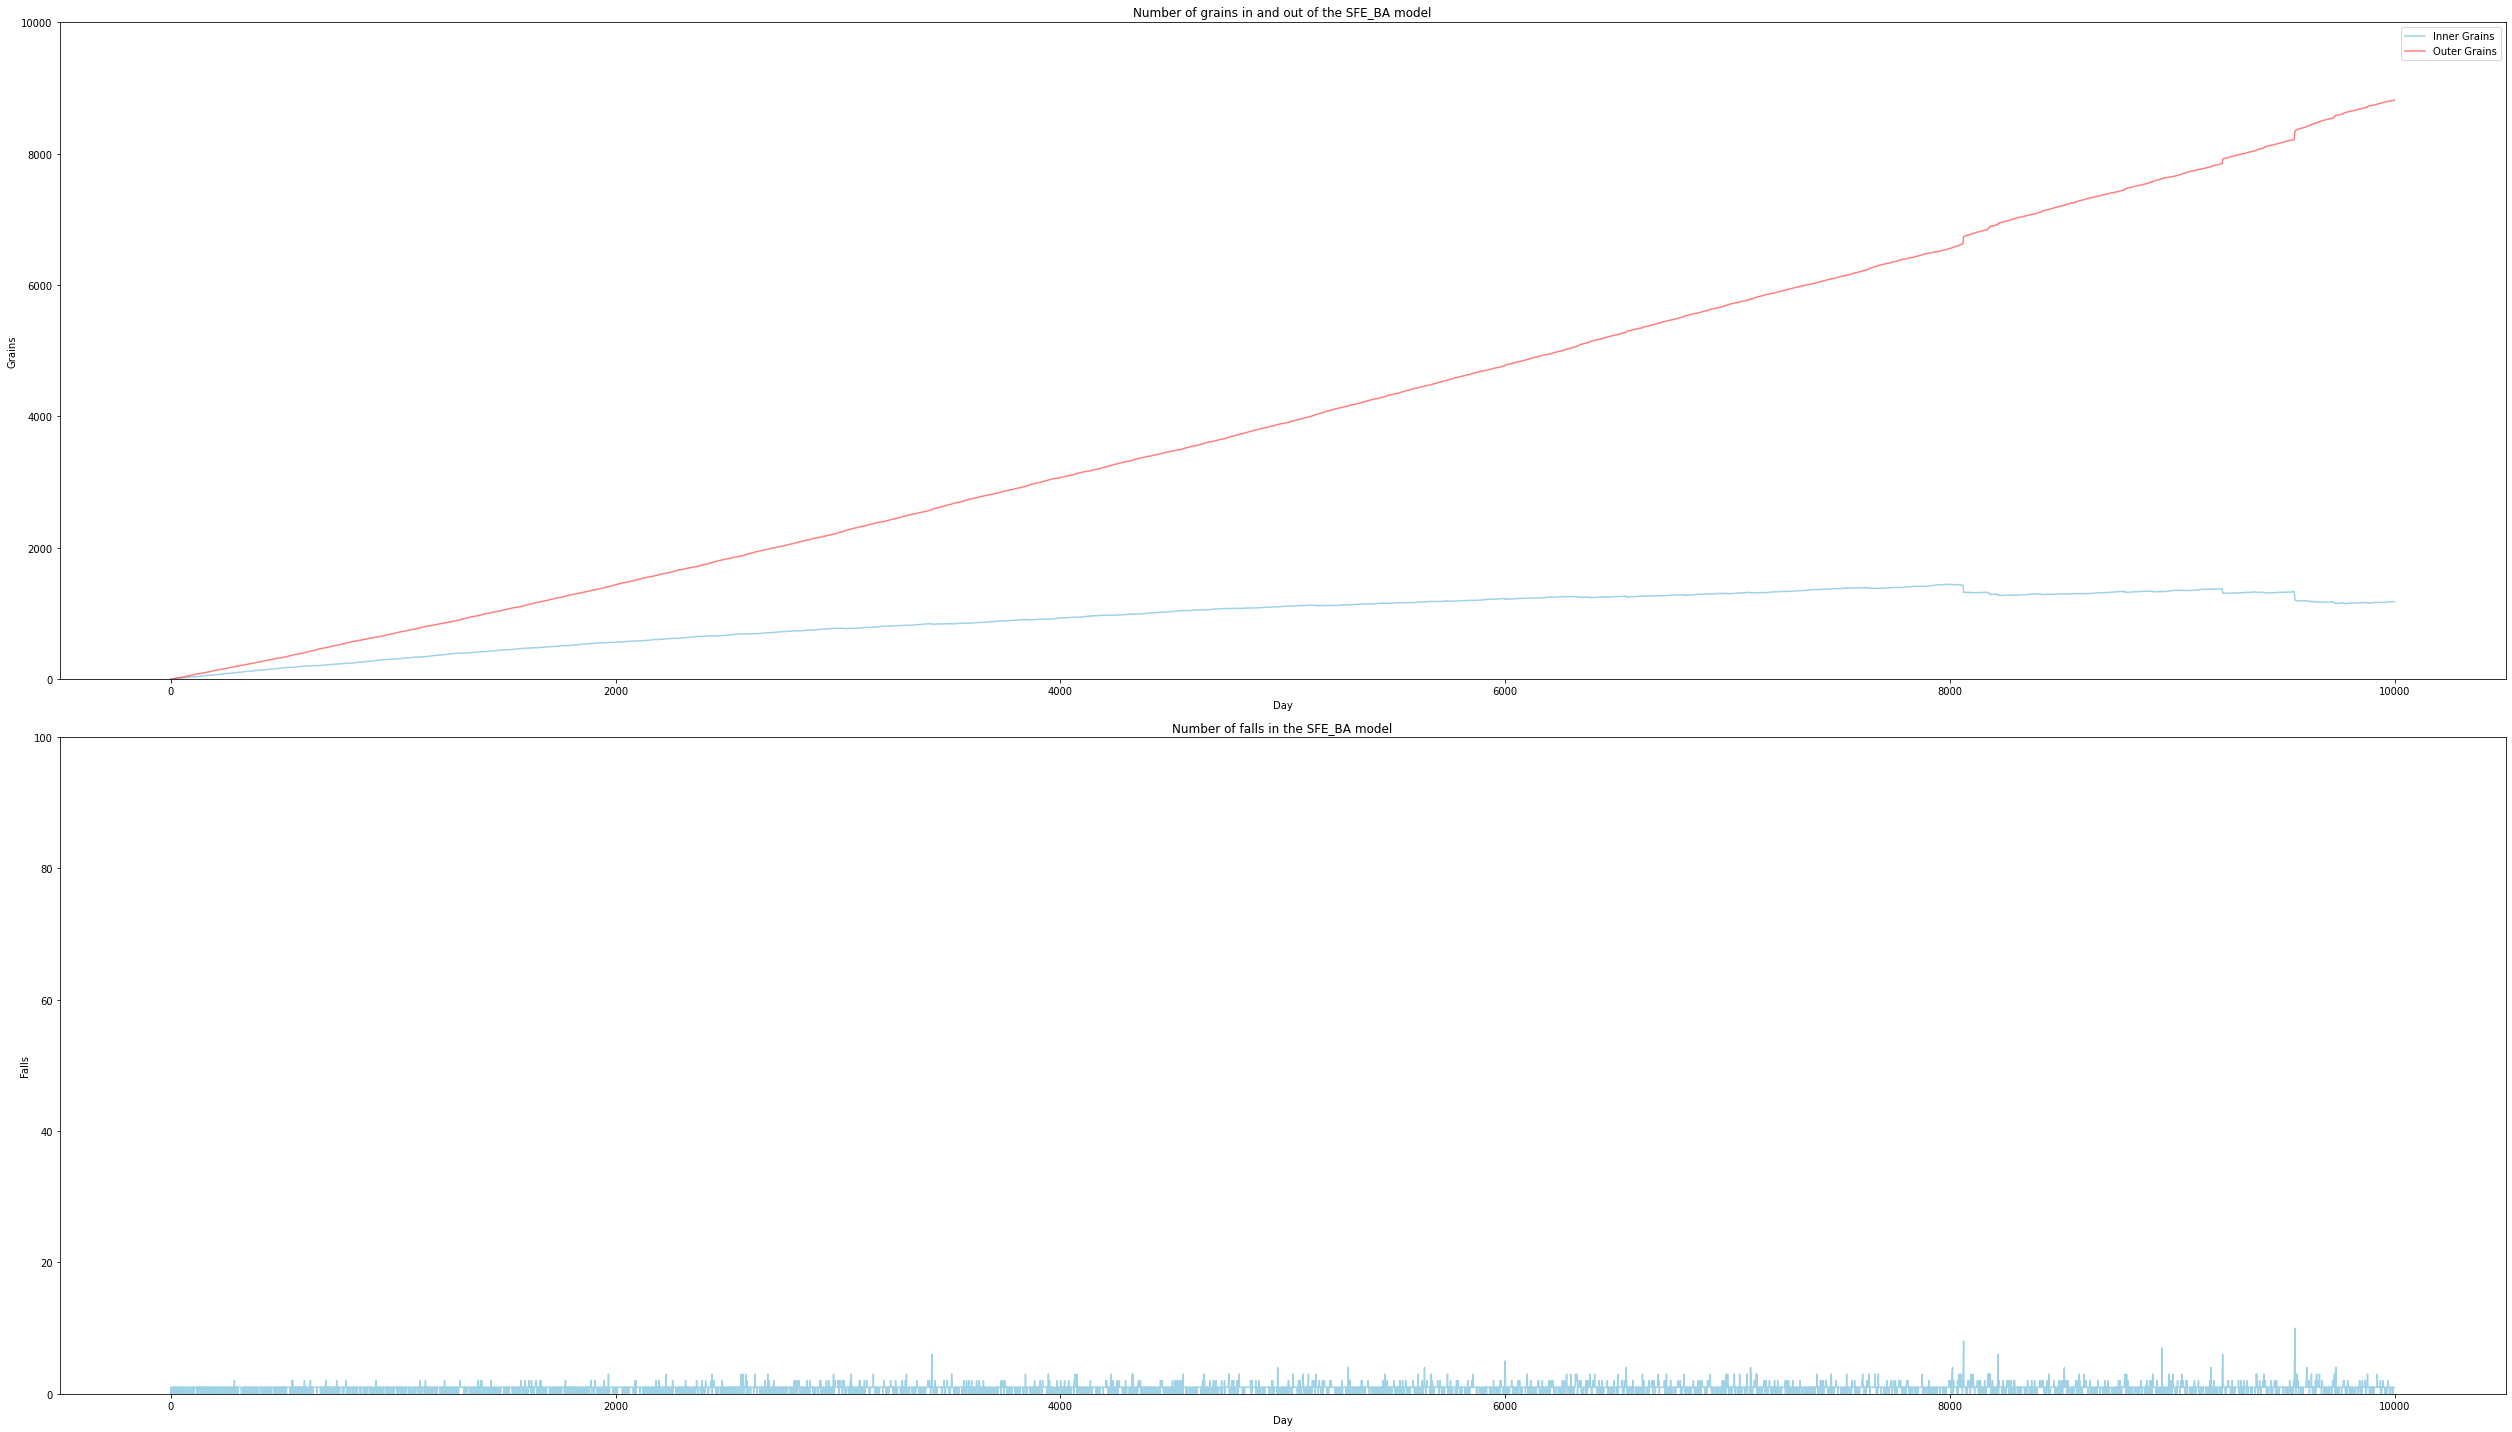

In [56]:
spread("SFE", G_BA, number_of_days, new_grains, "BA")

100%|██████████| 9999/9999 [01:50<00:00, 90.89it/s]


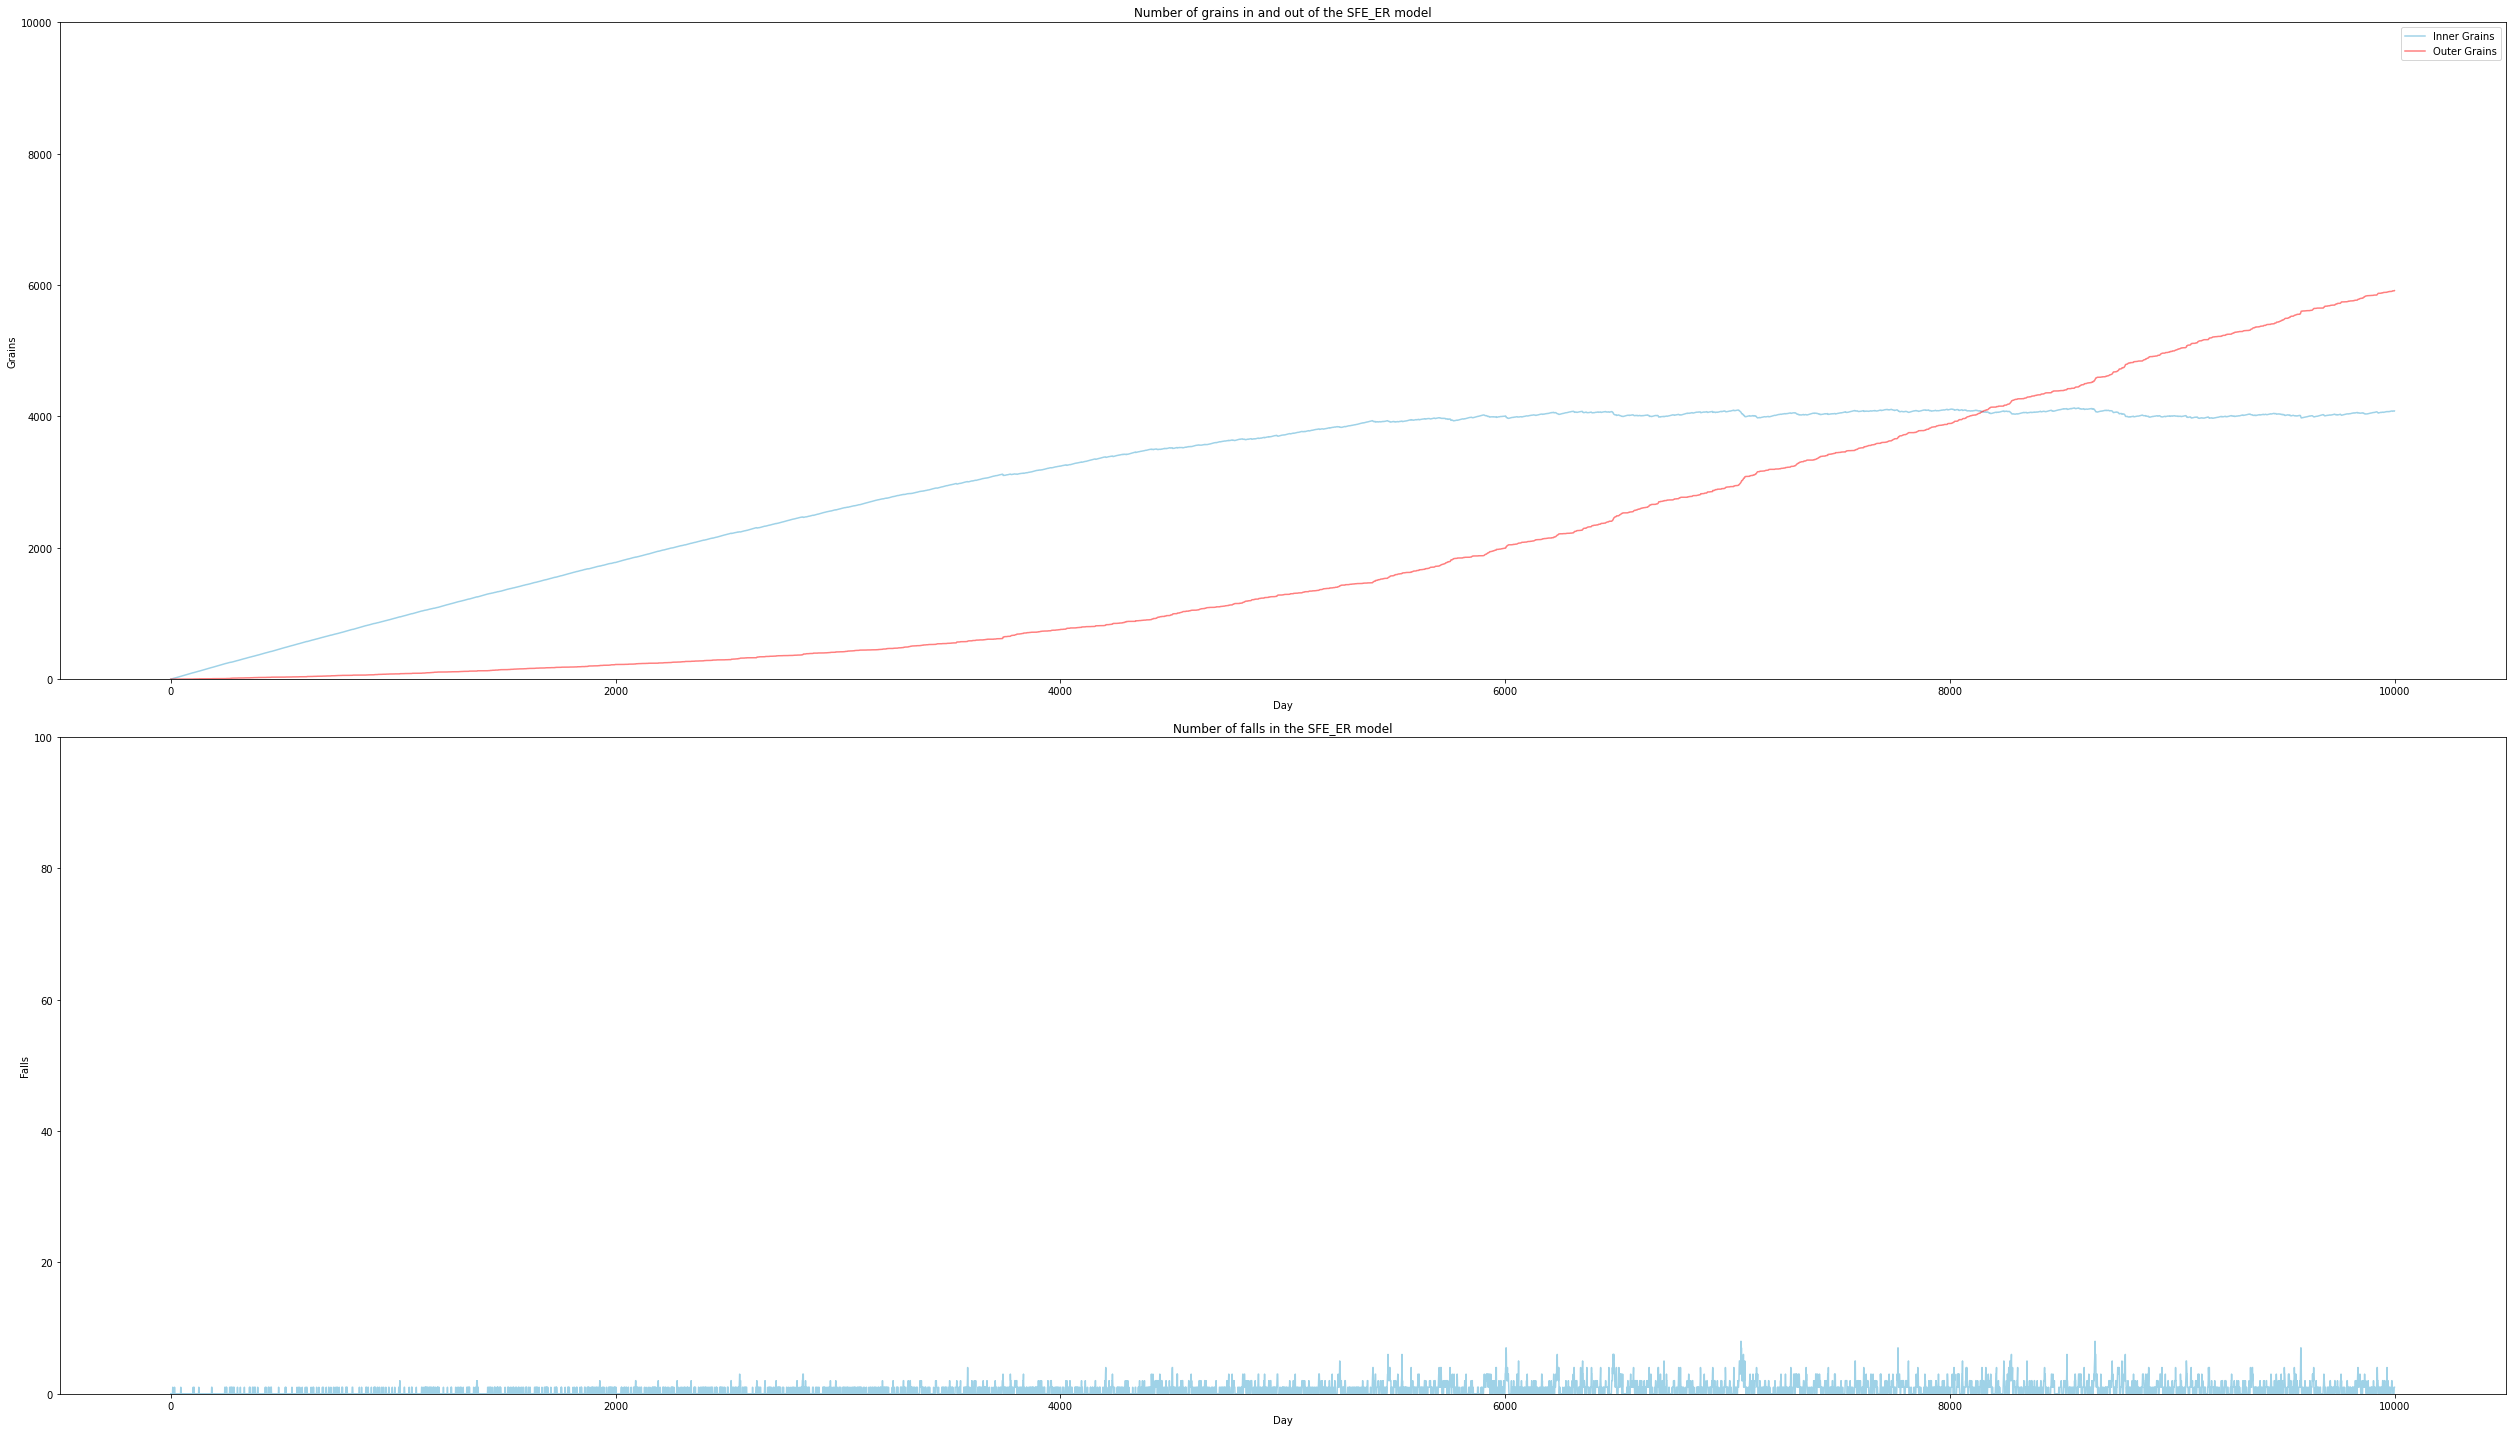

In [57]:
spread("SFE", G_ER, number_of_days, new_grains, "ER")

100%|██████████| 9999/9999 [01:52<00:00, 88.99it/s]


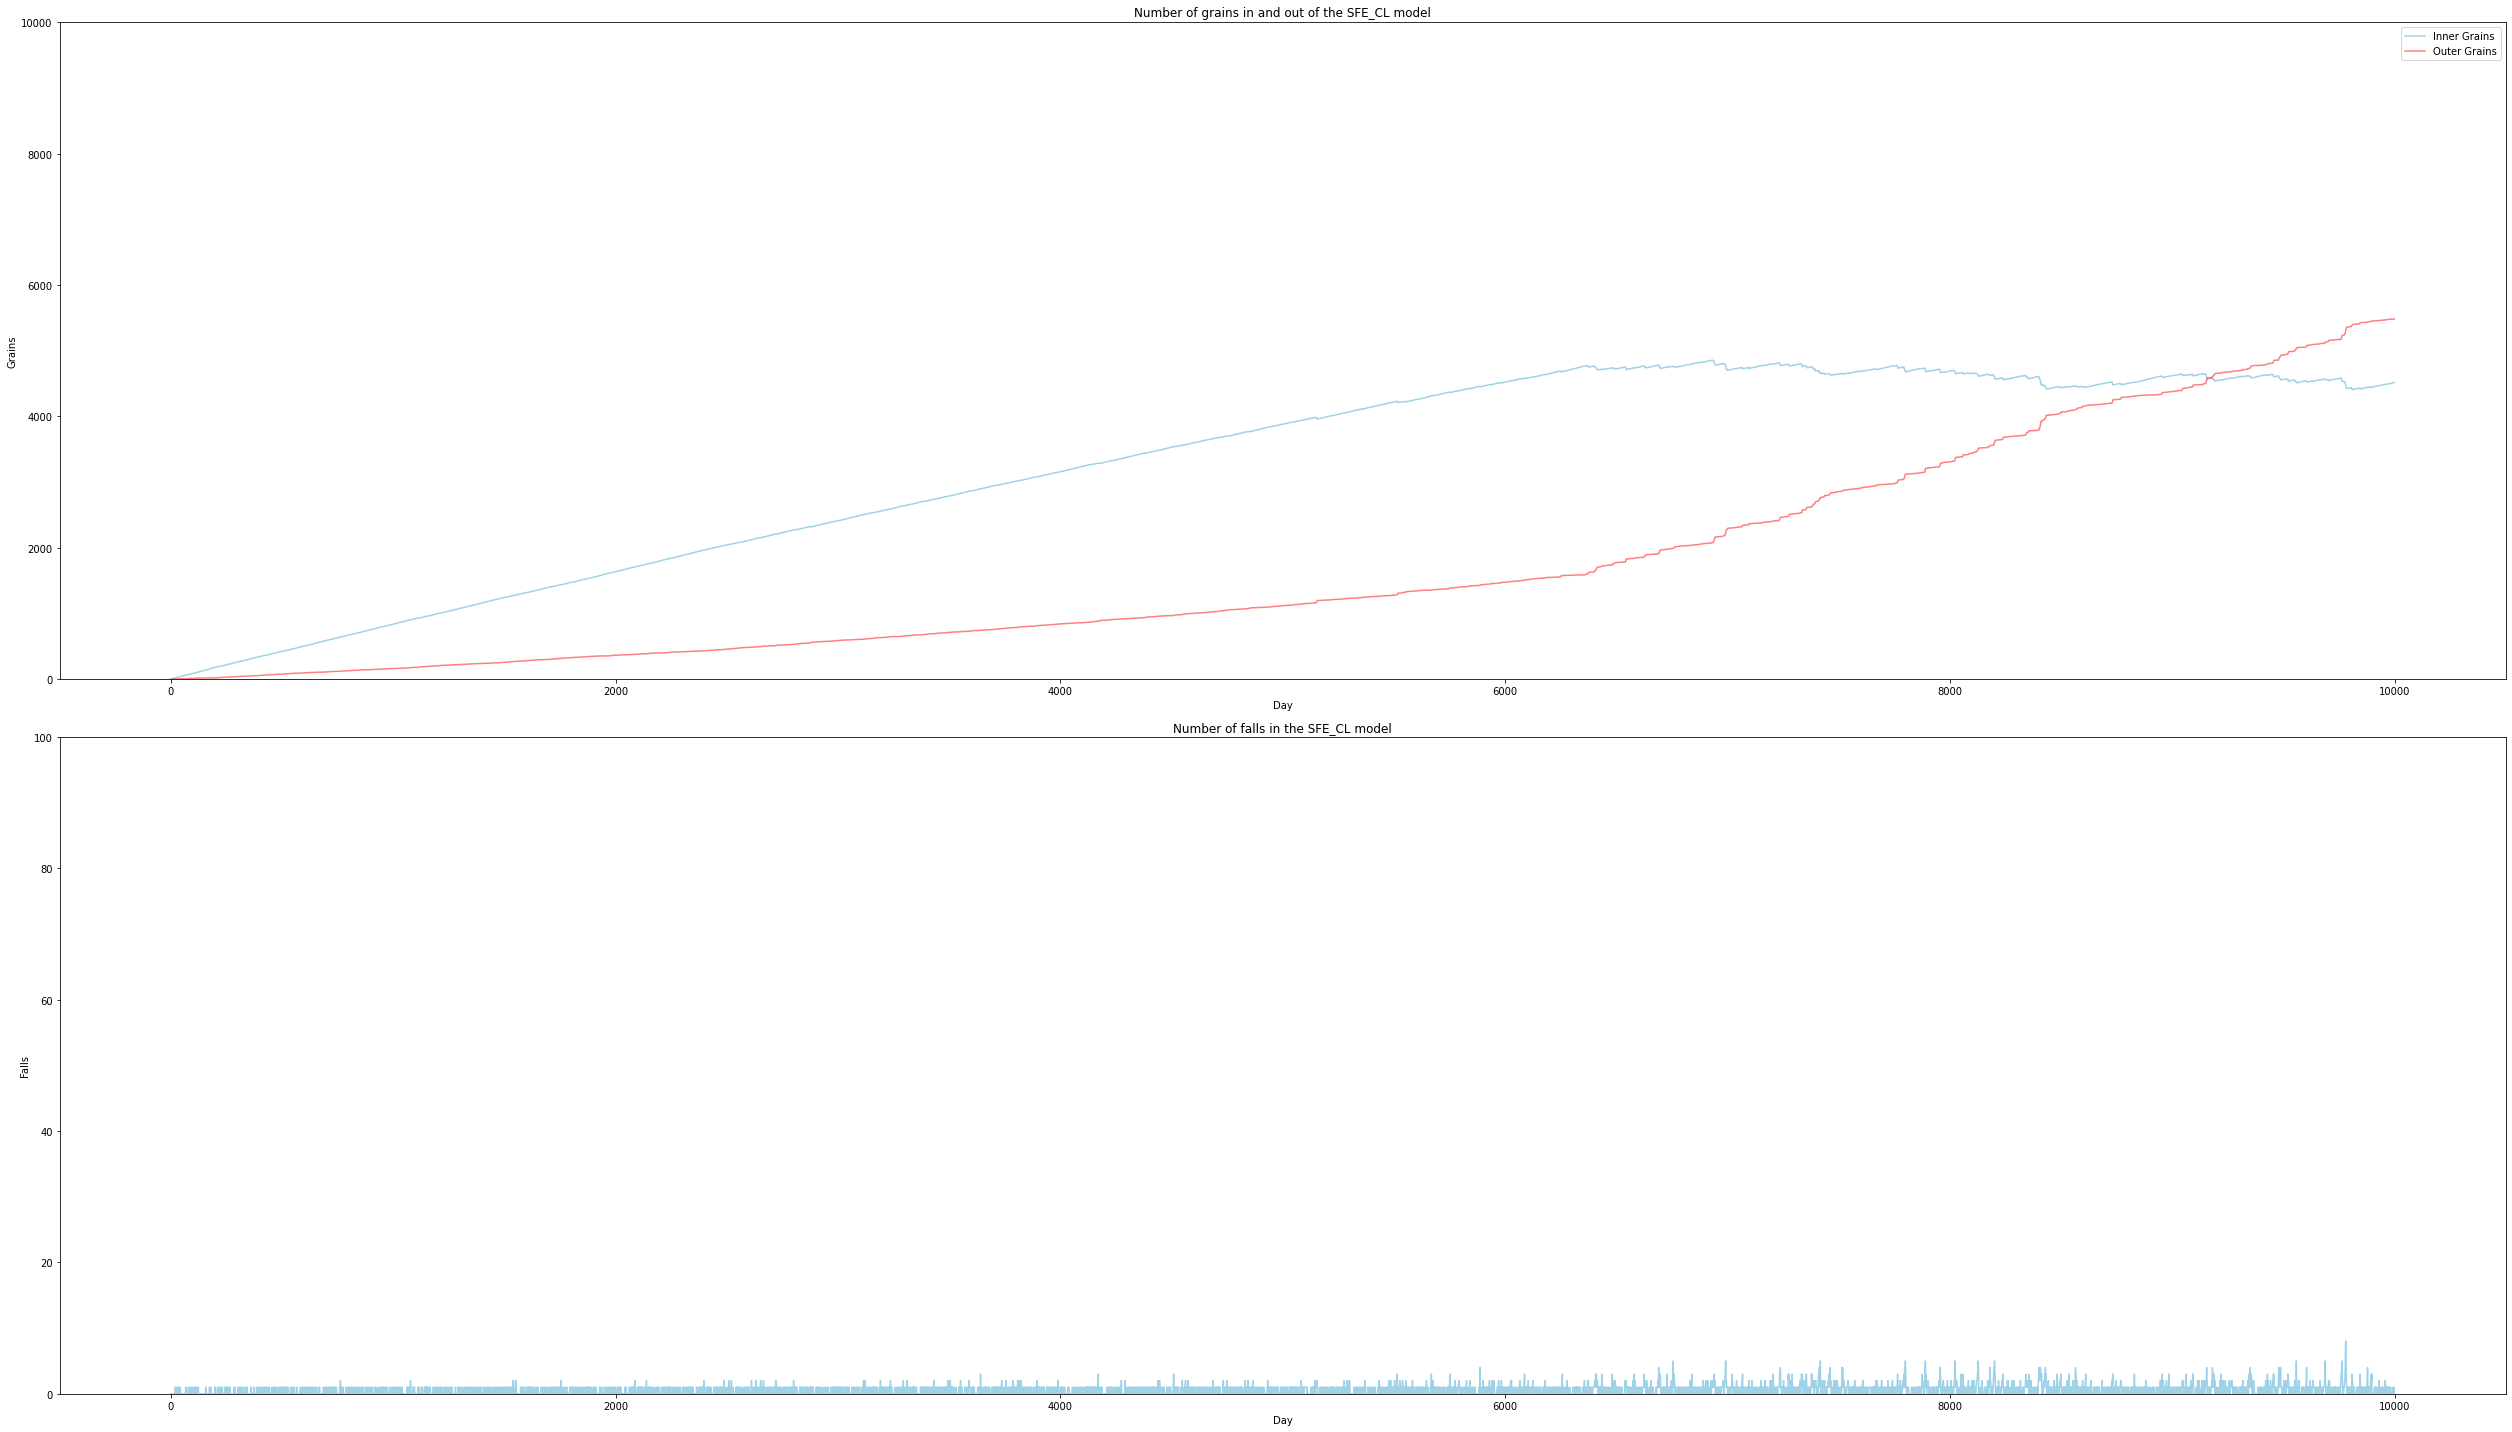

In [58]:
spread("SFE", G_CL, number_of_days, new_grains, "CL")

##### Additional Dissipation

100%|██████████| 9999/9999 [01:59<00:00, 83.39it/s]


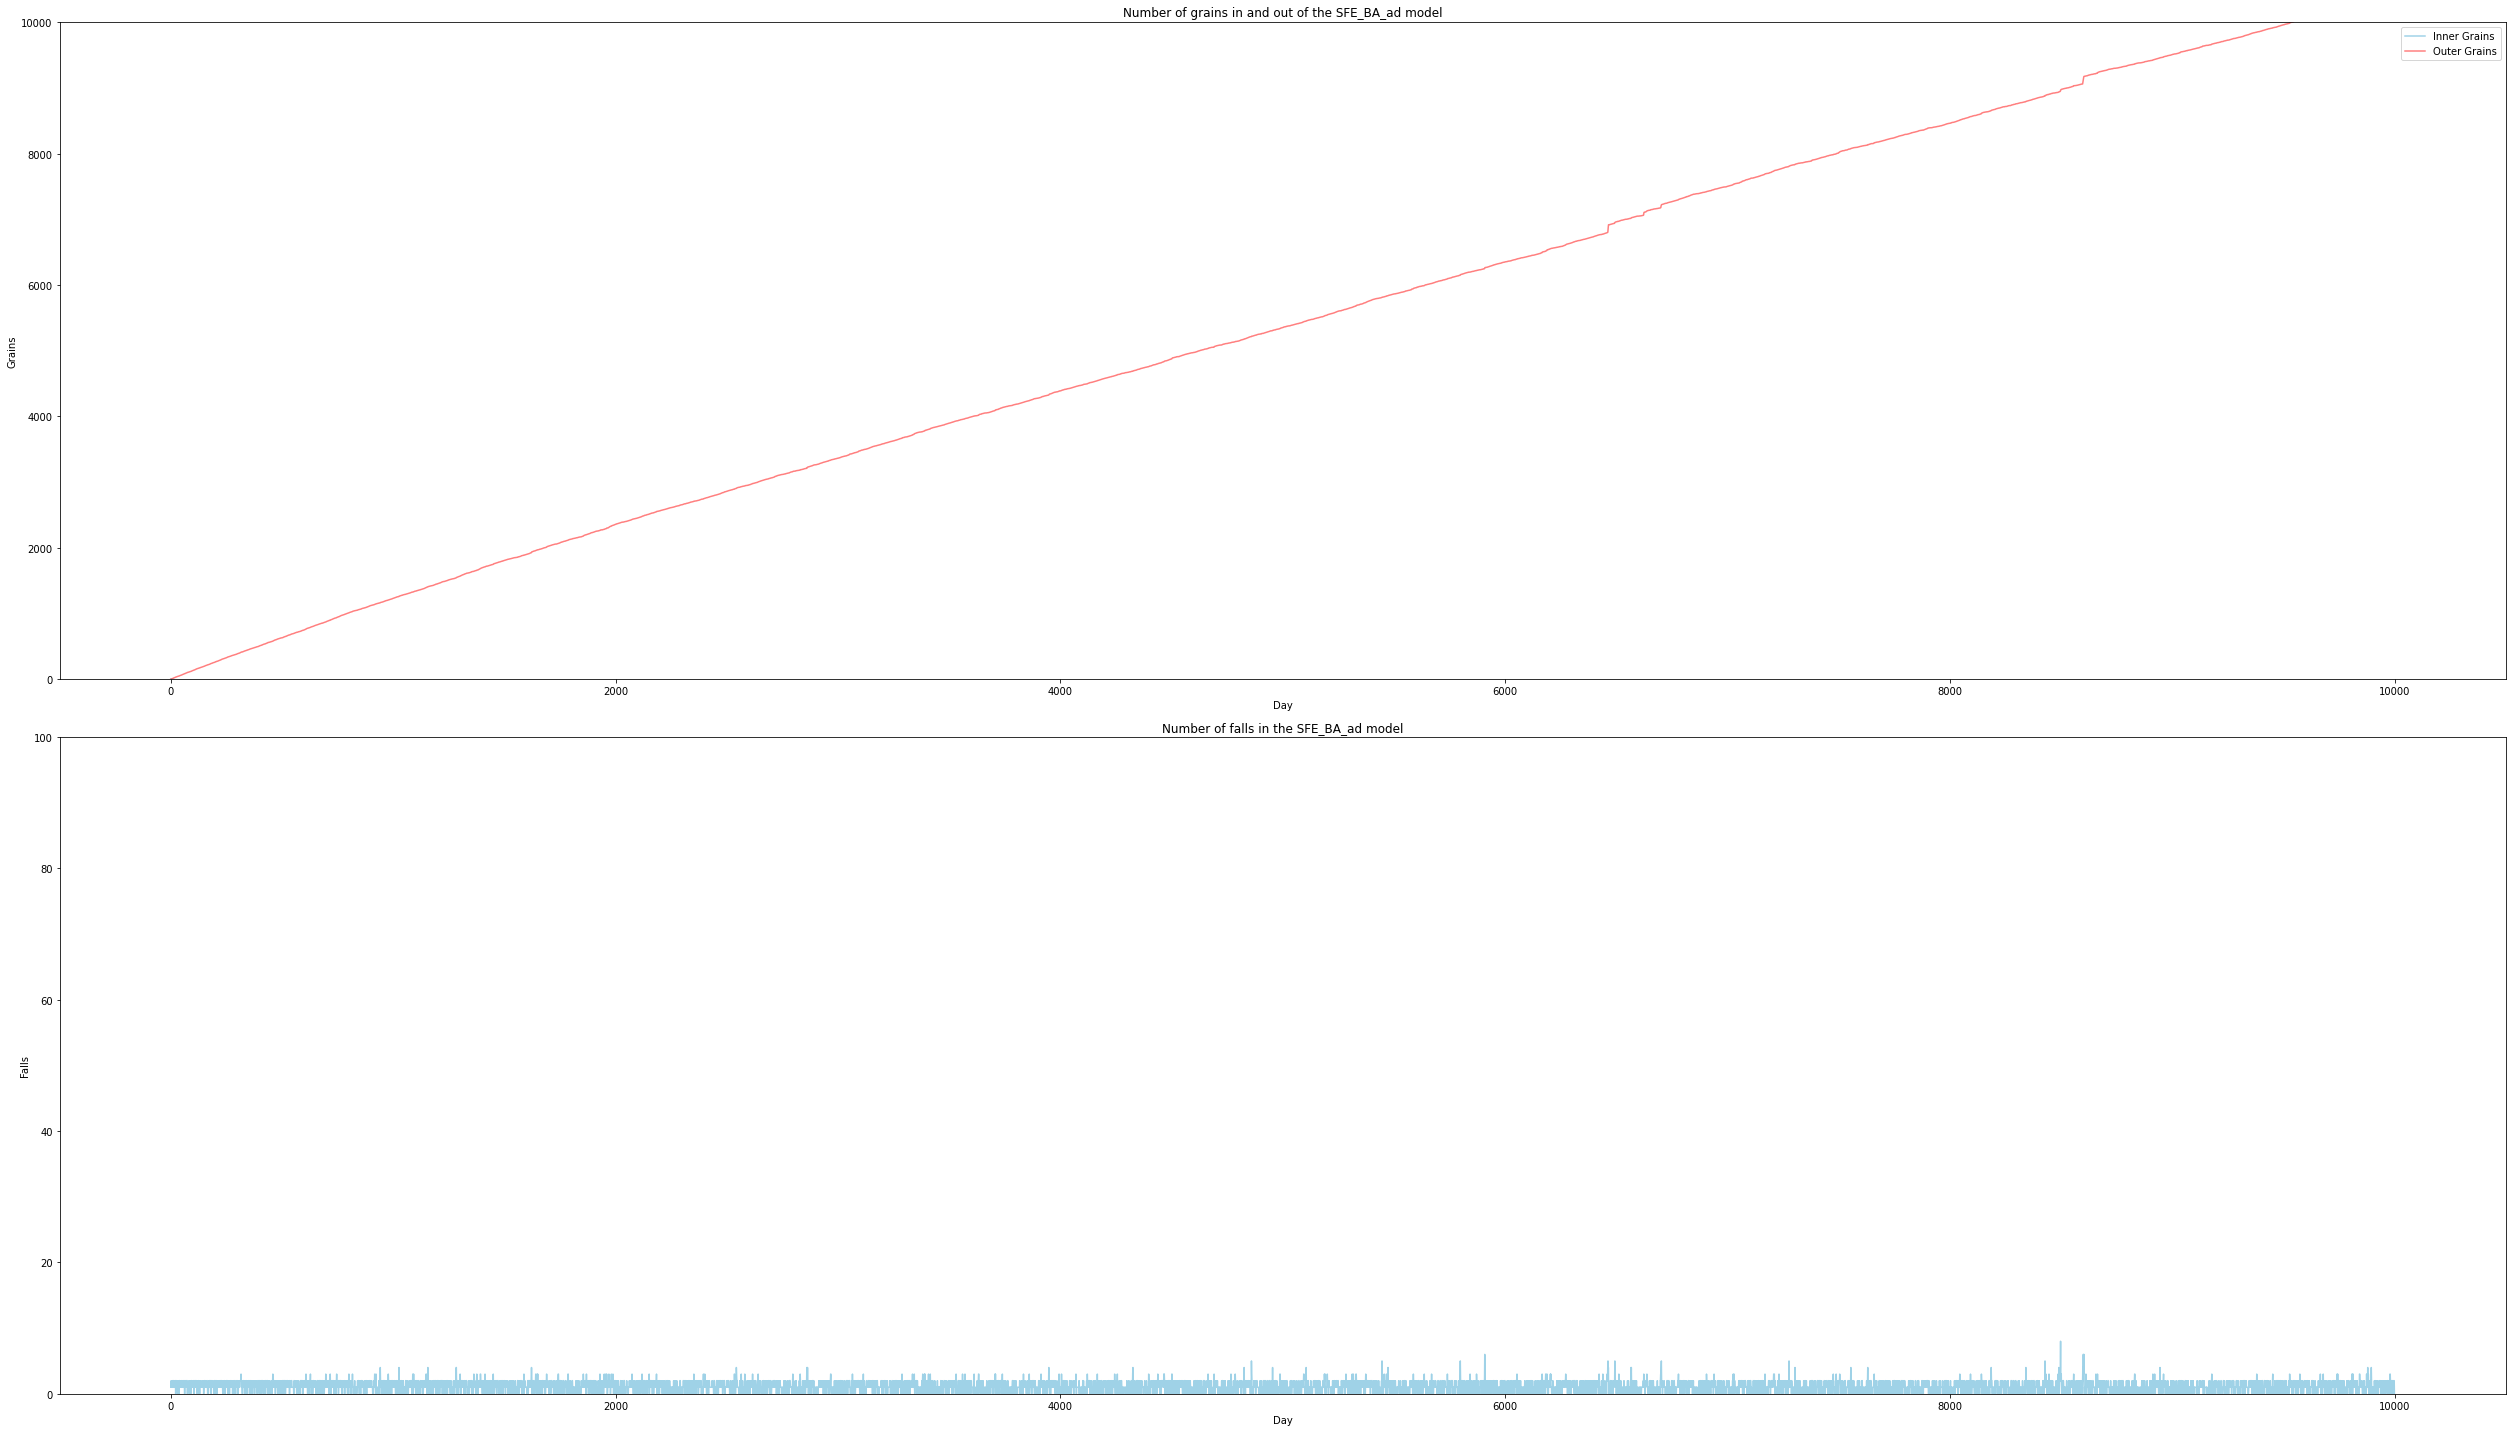

In [59]:
spread("SFE", G_BA, number_of_days, new_grains, "BA", ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

100%|██████████| 9999/9999 [01:52<00:00, 88.70it/s]


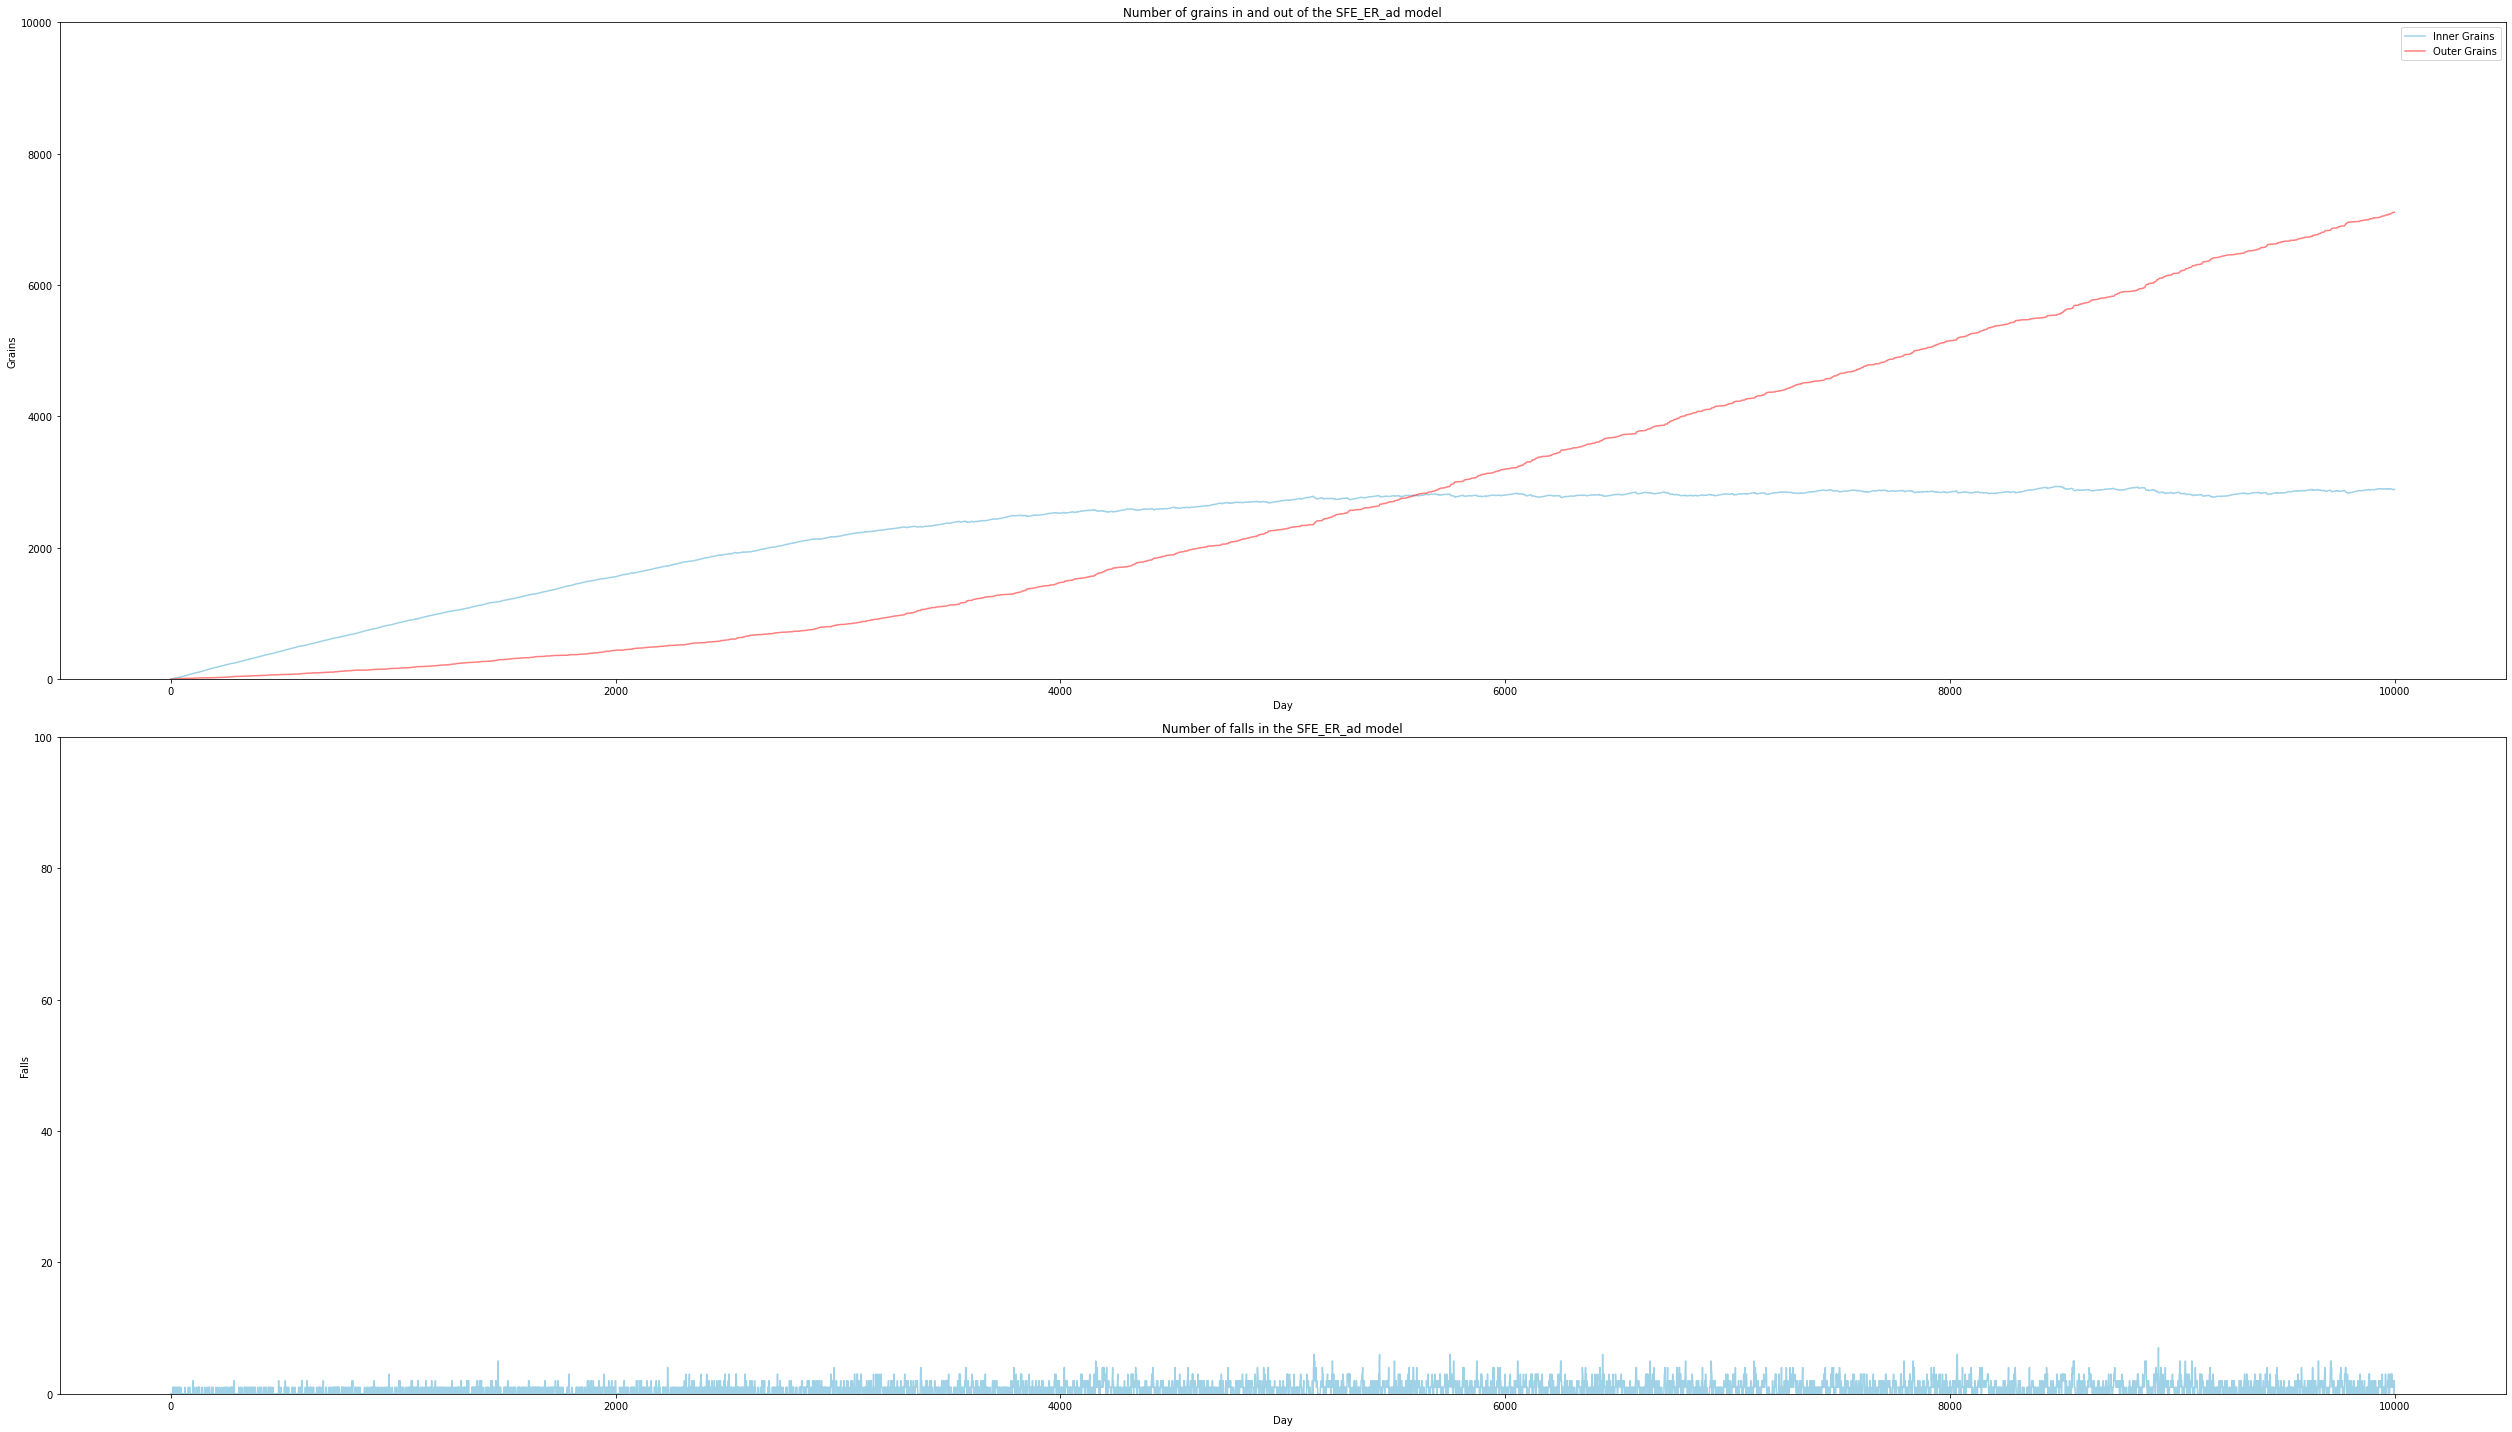

In [60]:
spread("SFE", G_ER, number_of_days, new_grains, "ER", ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

100%|██████████| 9999/9999 [01:54<00:00, 87.19it/s]


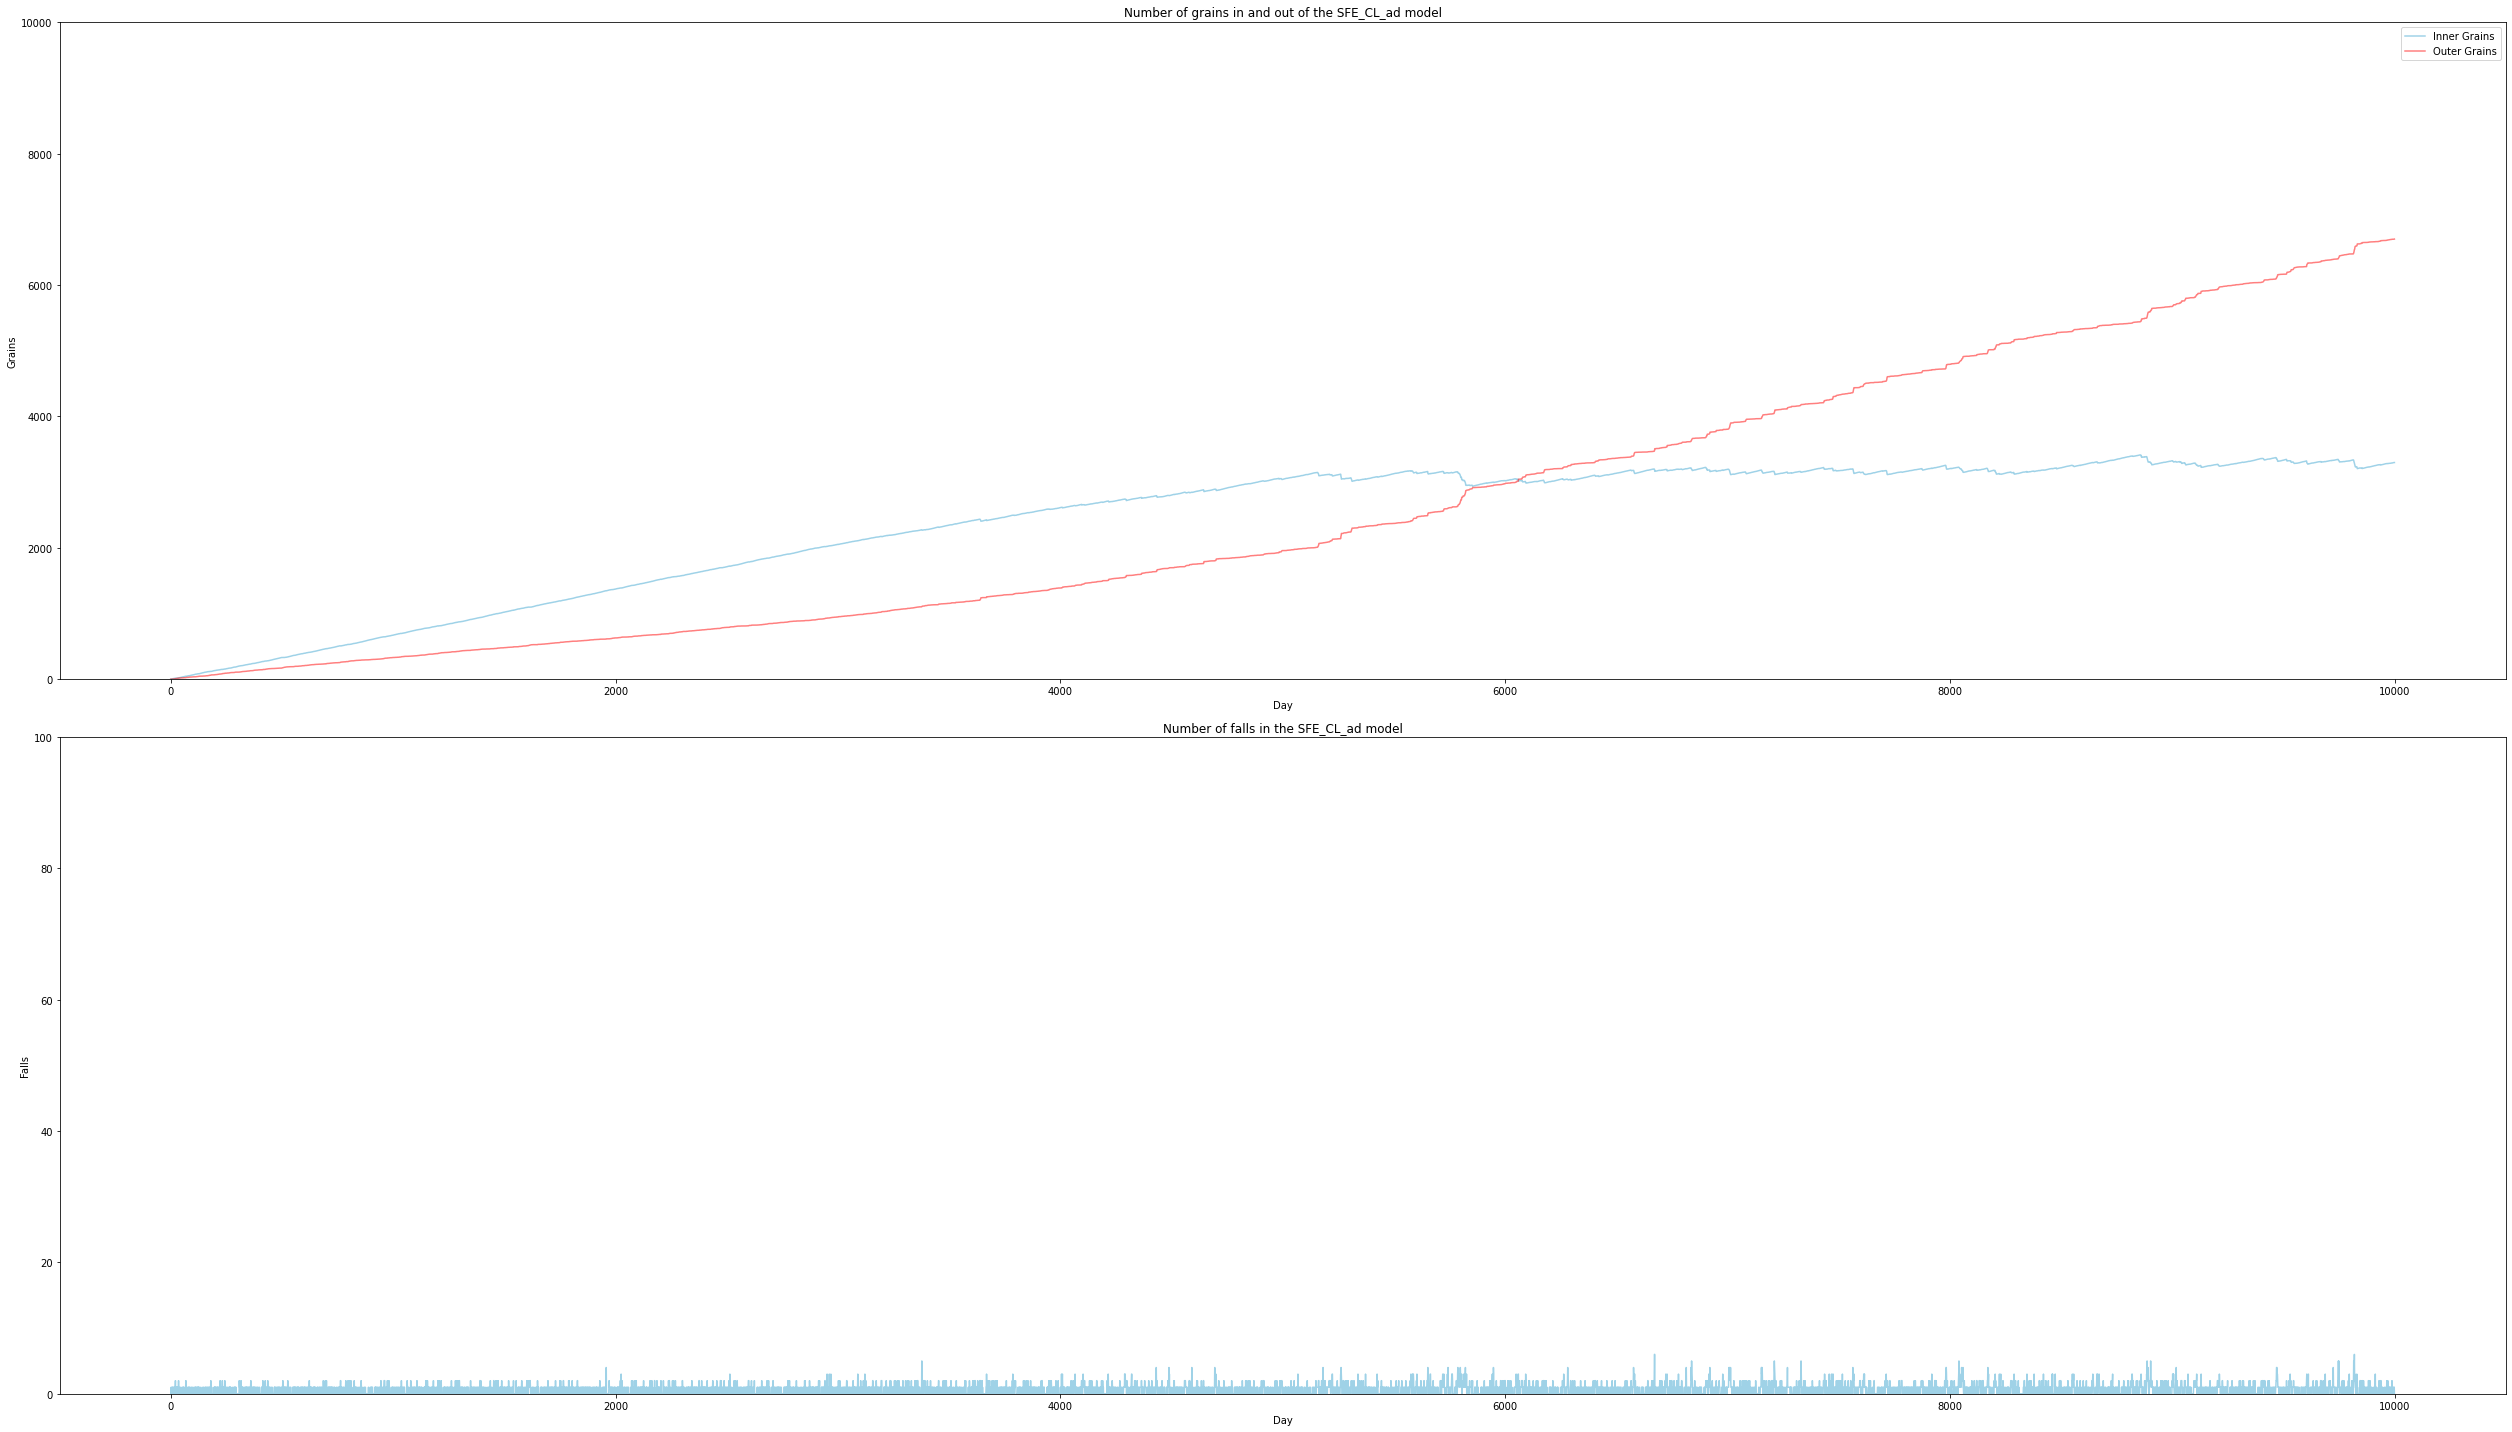

In [61]:
spread("SFE", G_CL, number_of_days, new_grains, "CL", ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

##### Neutral State

100%|██████████| 9999/9999 [01:47<00:00, 92.92it/s]


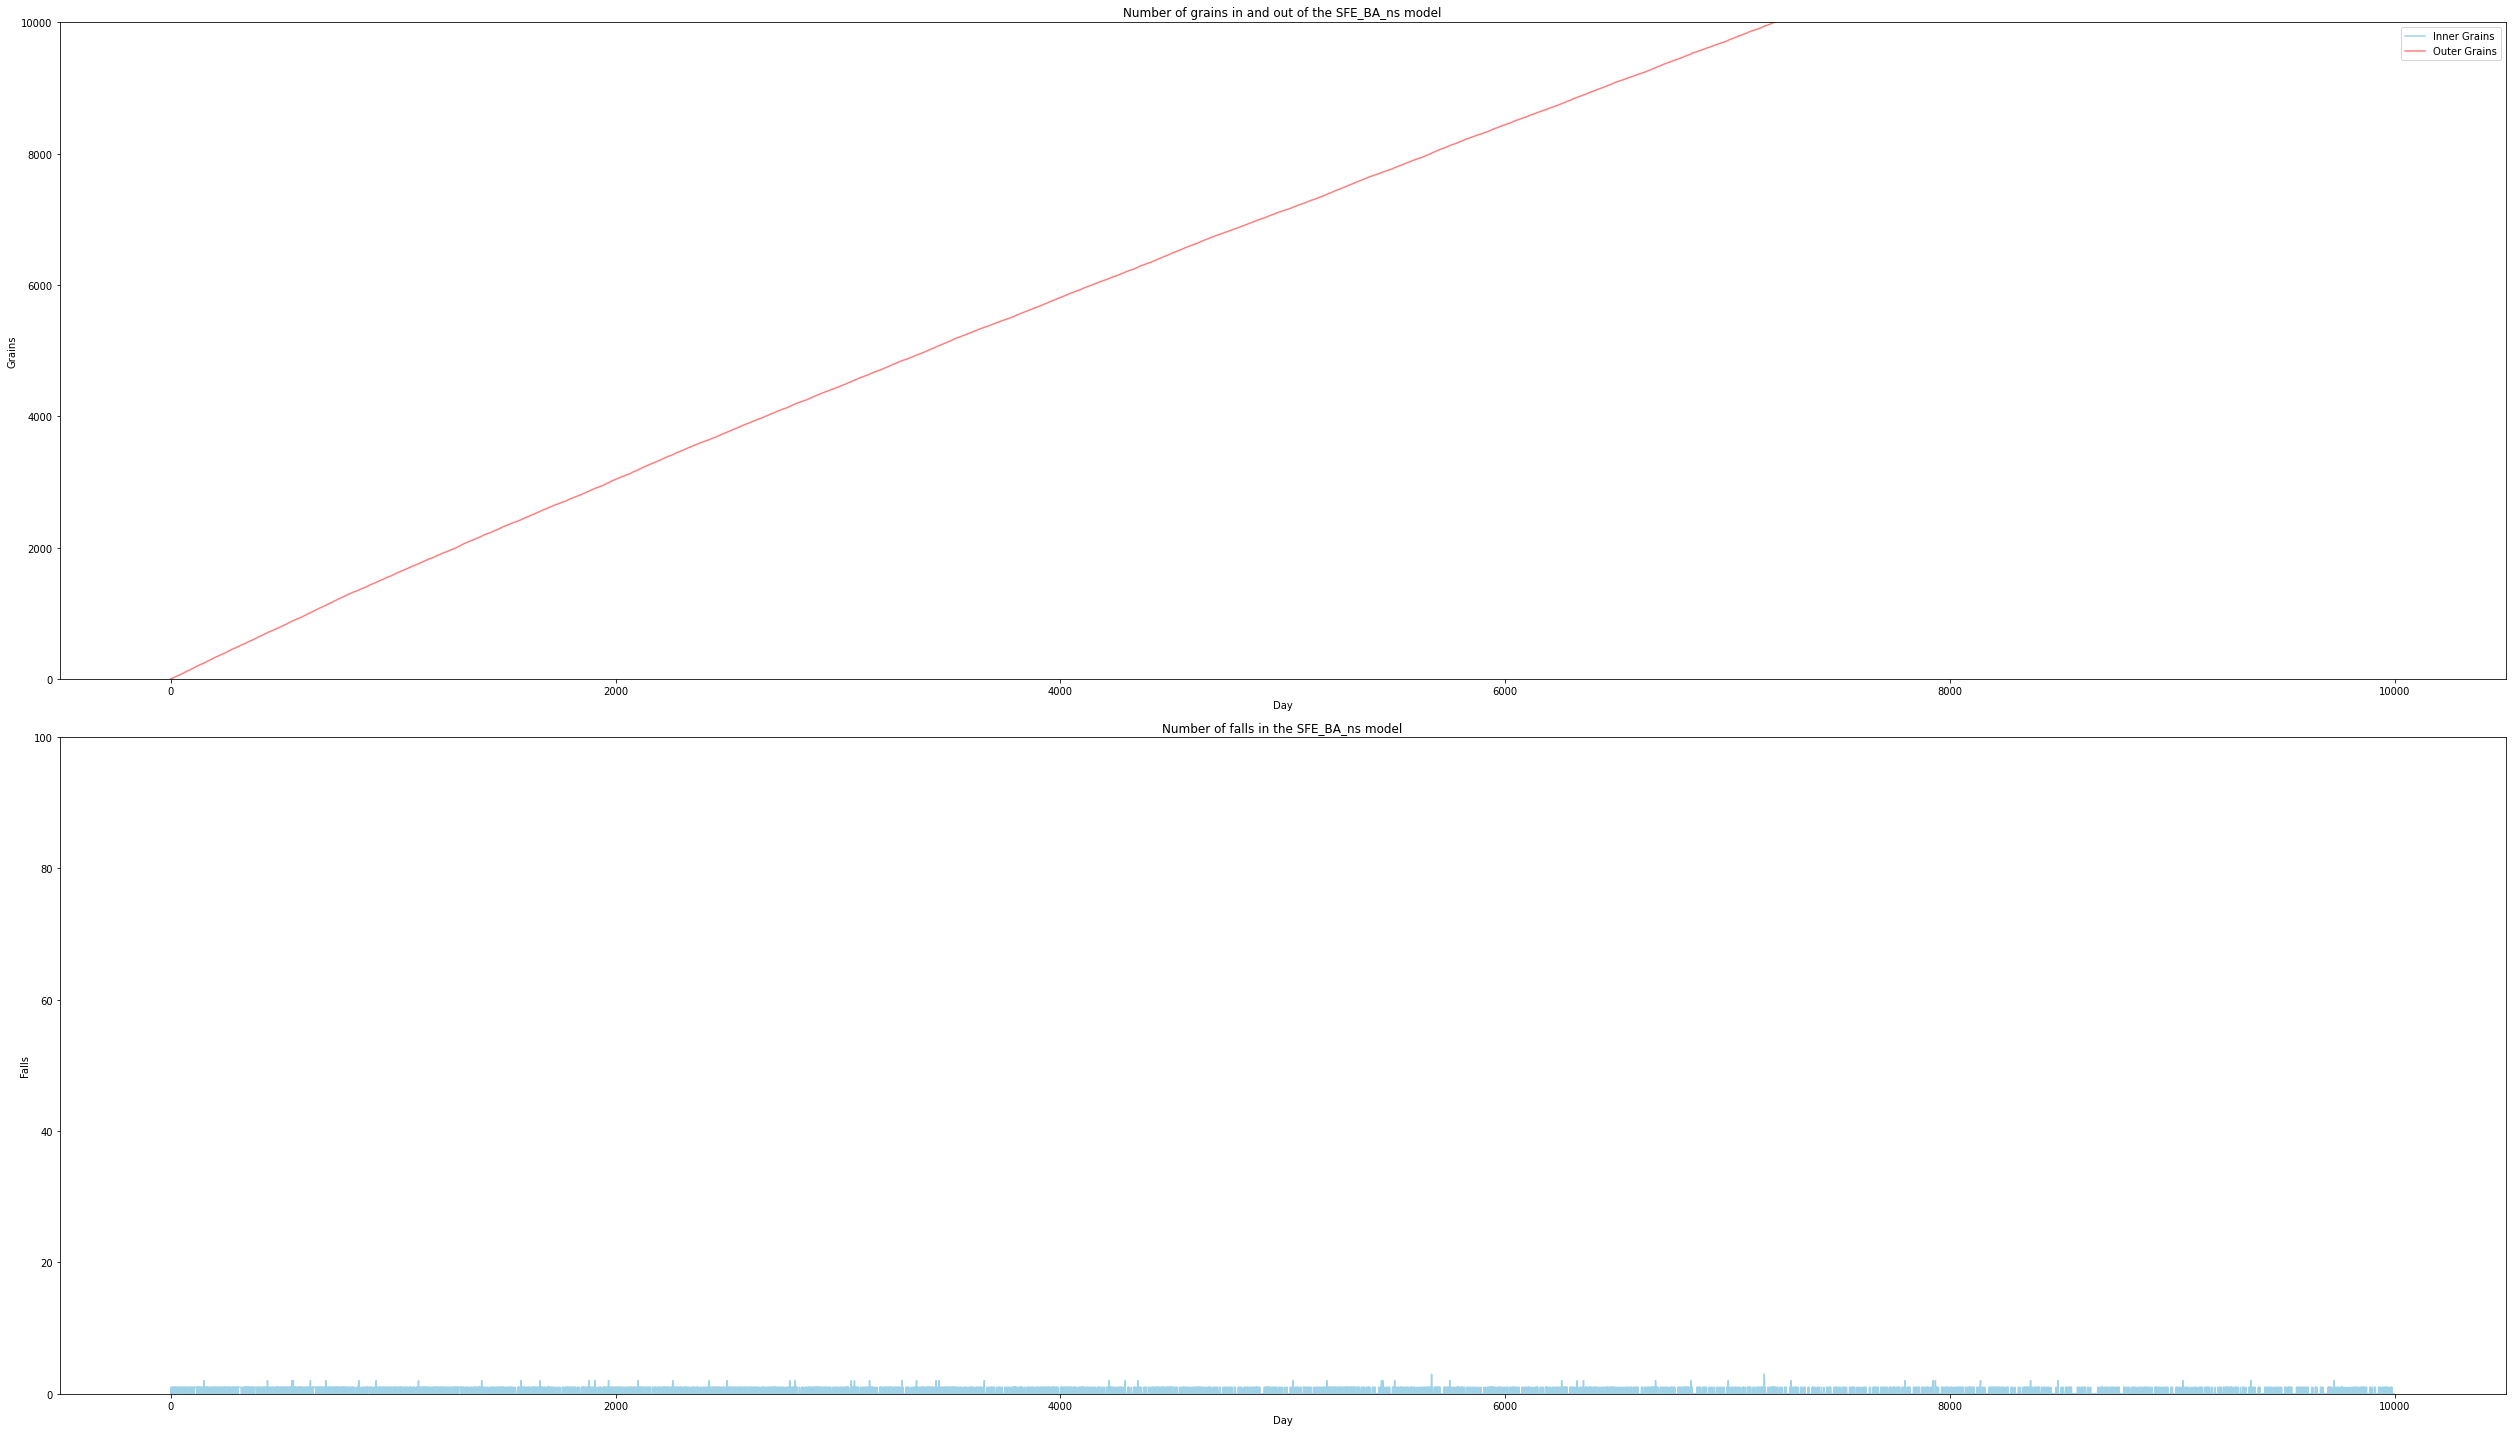

In [94]:
spread("SFE", G_BA, number_of_days, new_grains, "BA", neutral_state = True, new_grains_minus = new_grains_minus)

100%|██████████| 9999/9999 [01:33<00:00, 107.44it/s]


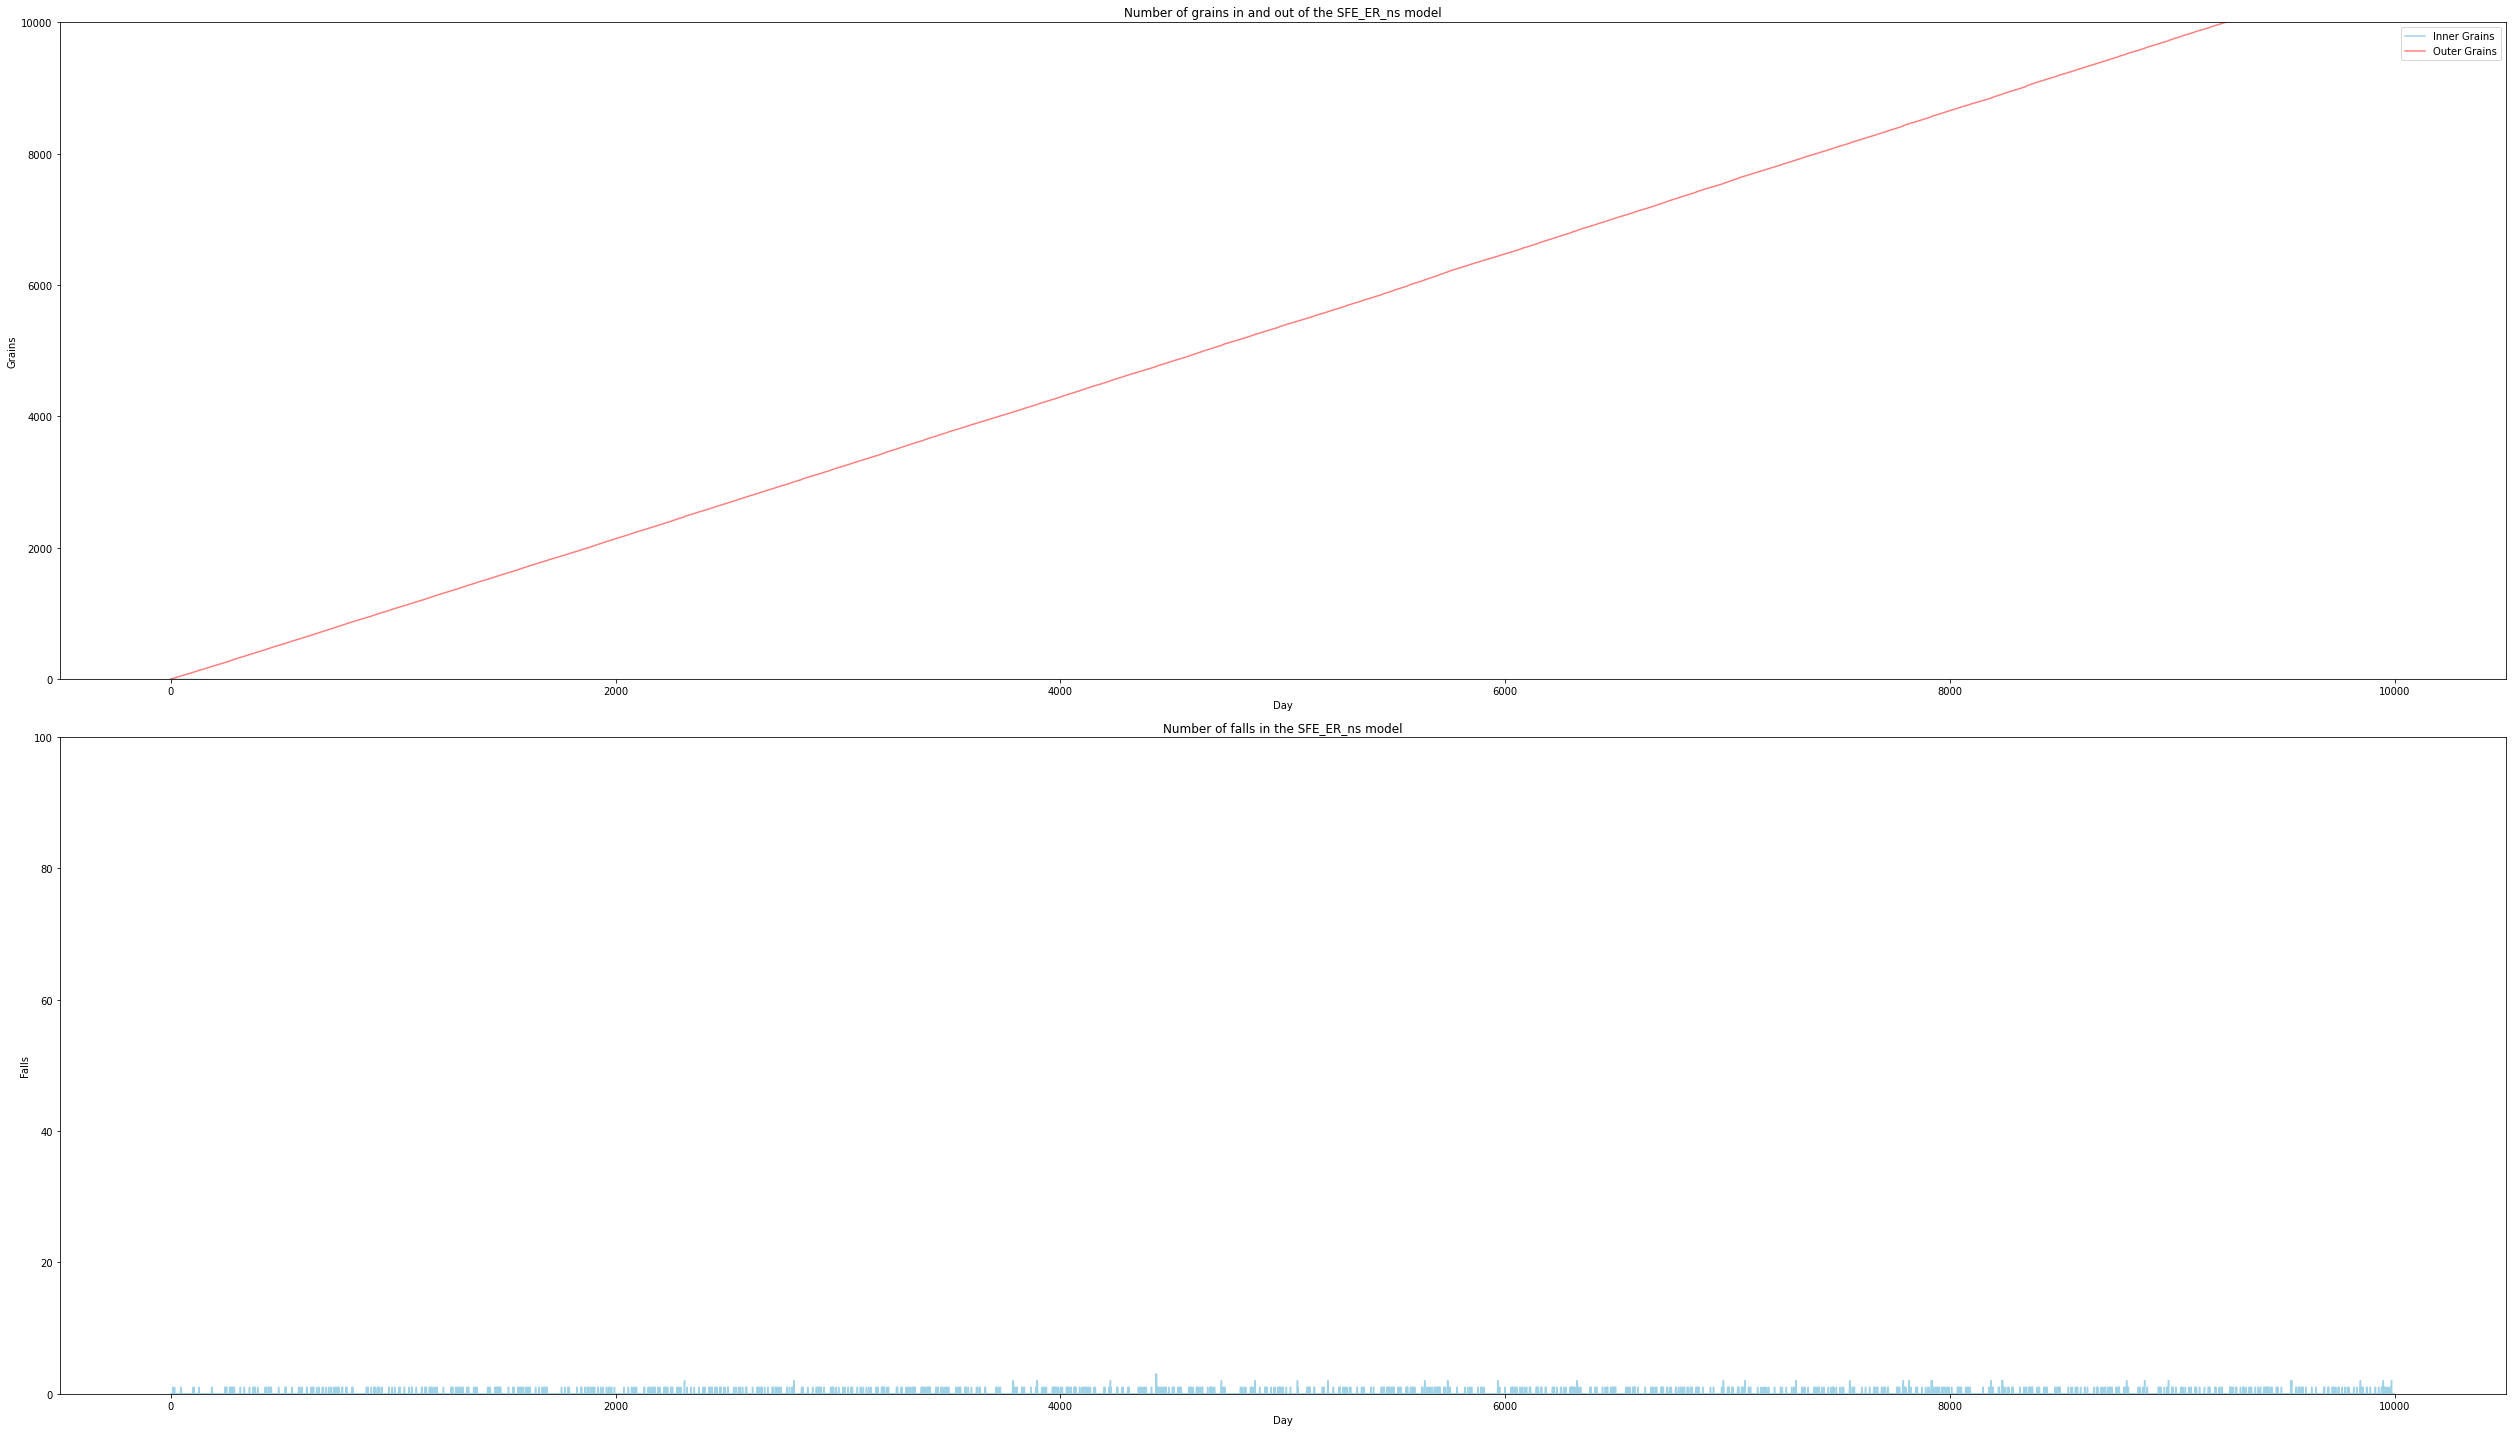

In [95]:
spread("SFE", G_ER, number_of_days, new_grains, "ER", neutral_state = True, new_grains_minus = new_grains_minus)

100%|██████████| 9999/9999 [01:39<00:00, 100.30it/s]


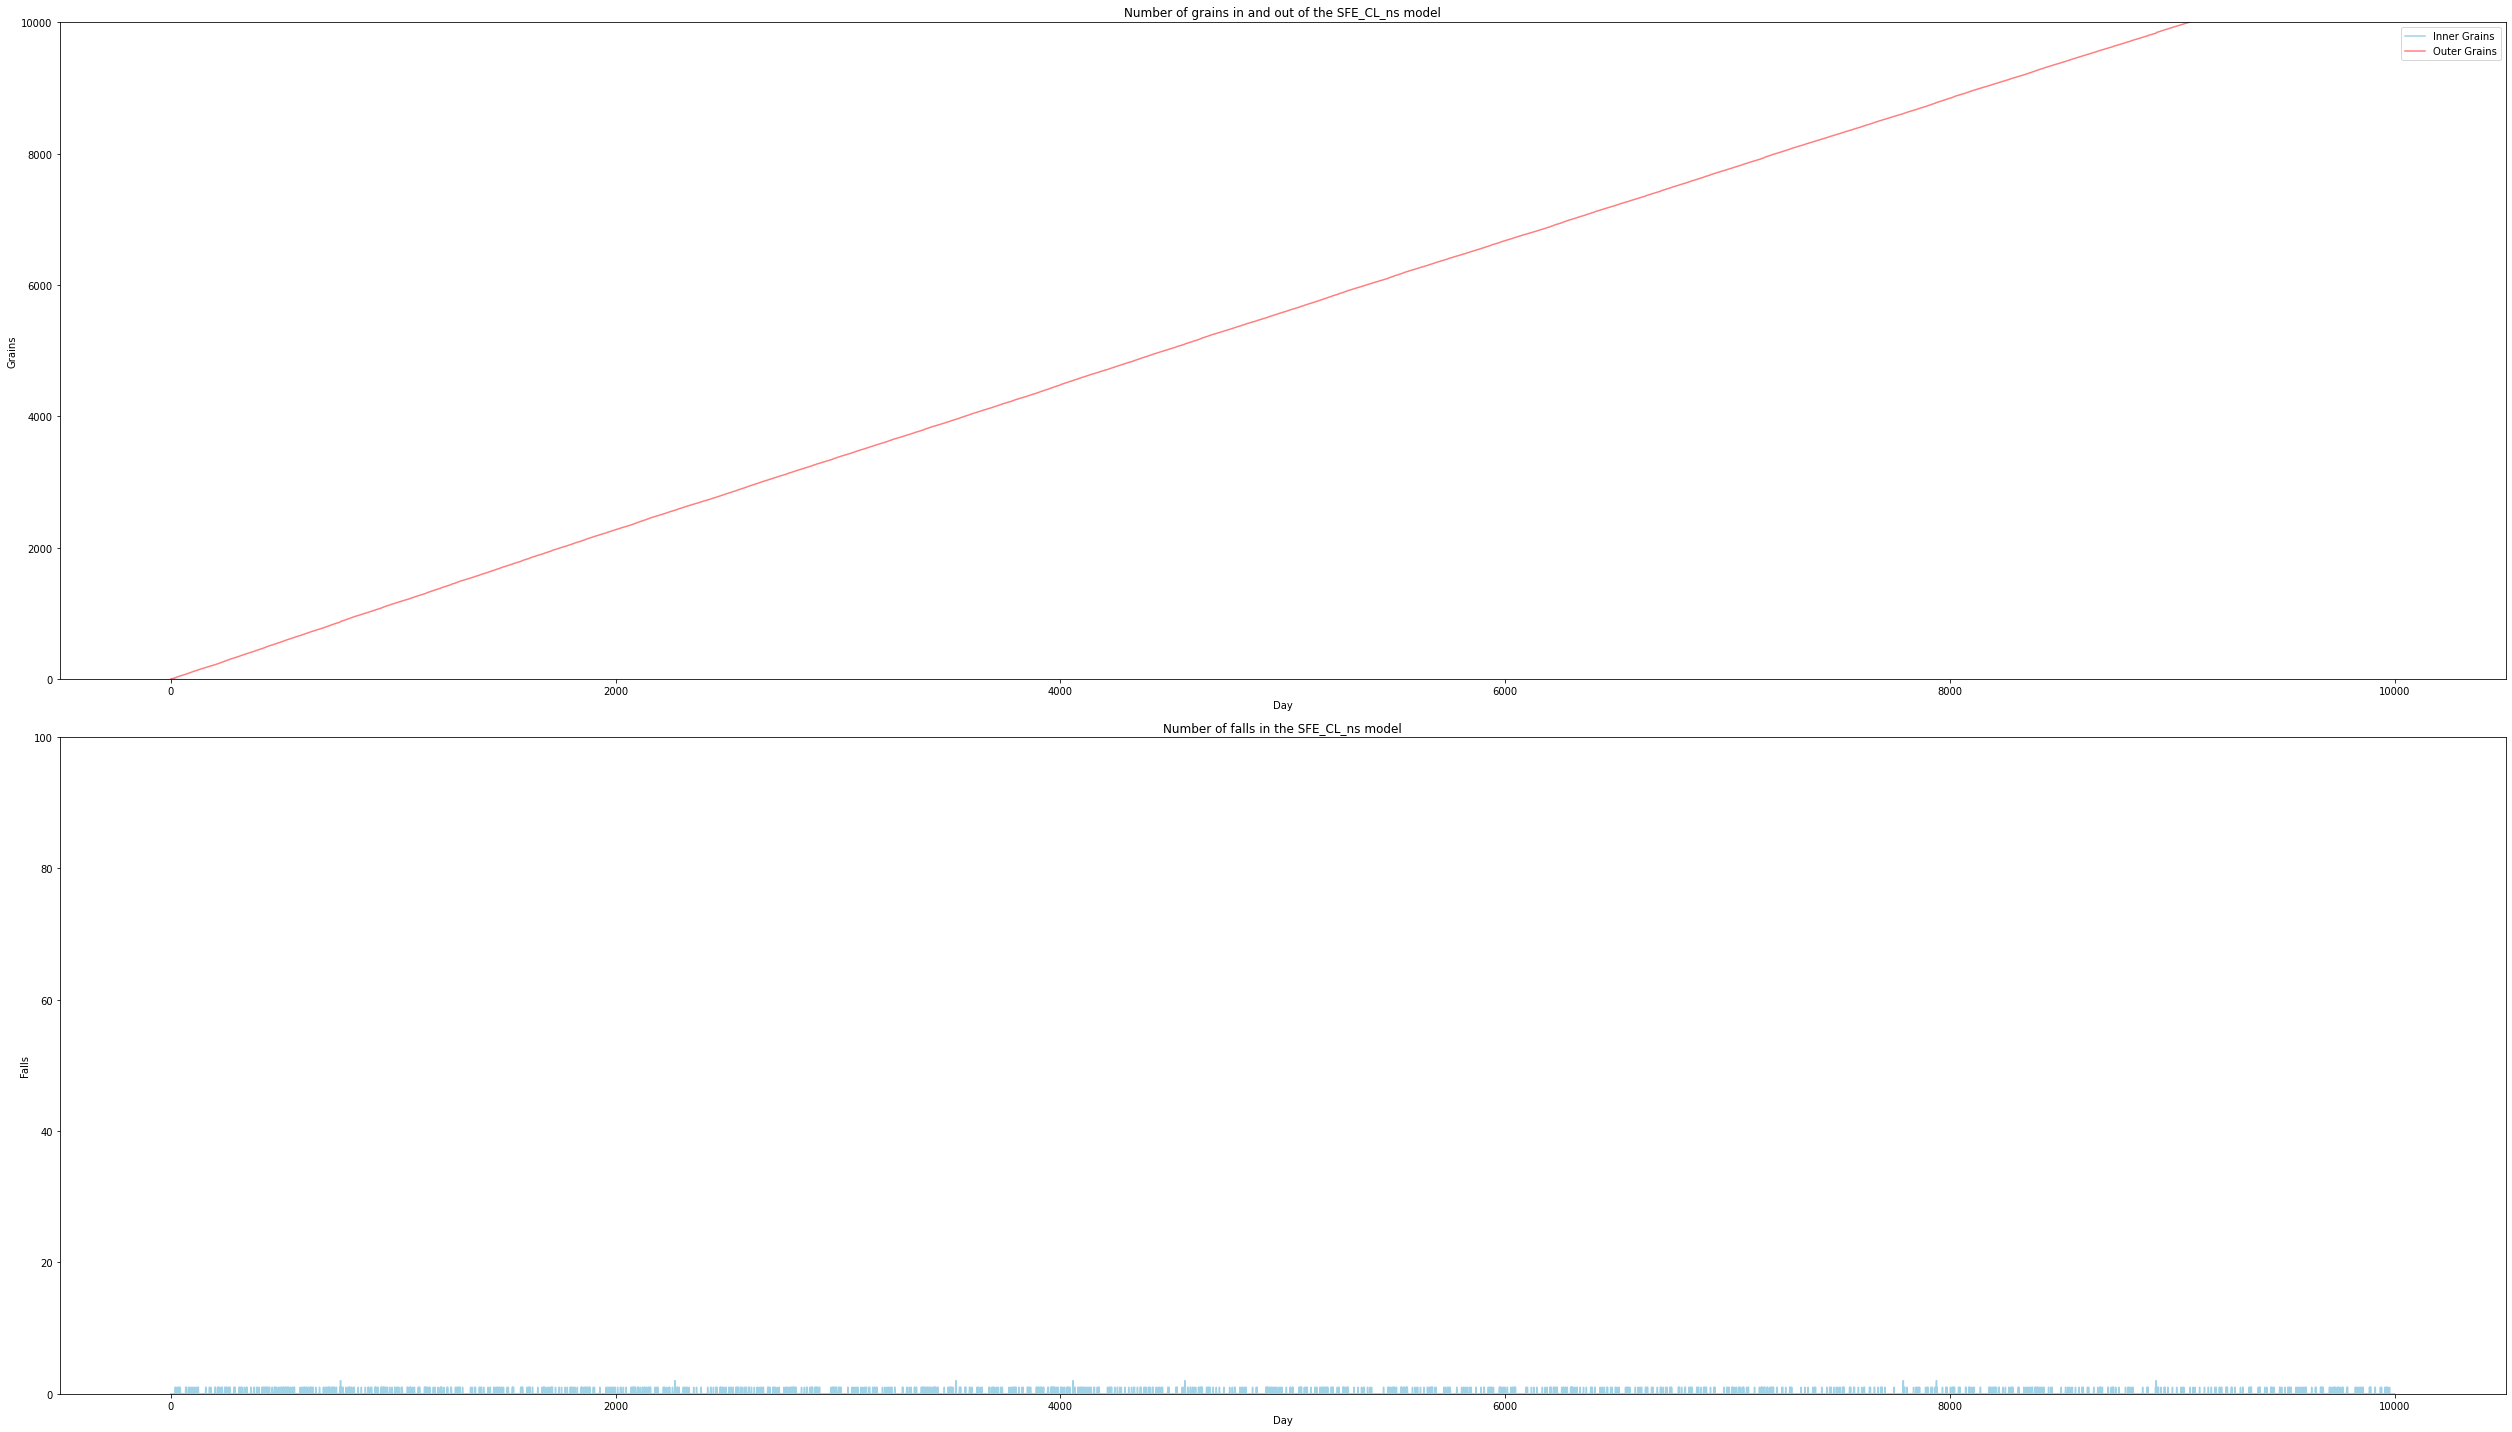

In [96]:
spread("SFE", G_CL, number_of_days, new_grains, "CL", neutral_state = True, new_grains_minus = new_grains_minus)

#### Facilitated Model

##### Standart Dissipation

100%|██████████| 9999/9999 [01:47<00:00, 92.83it/s]


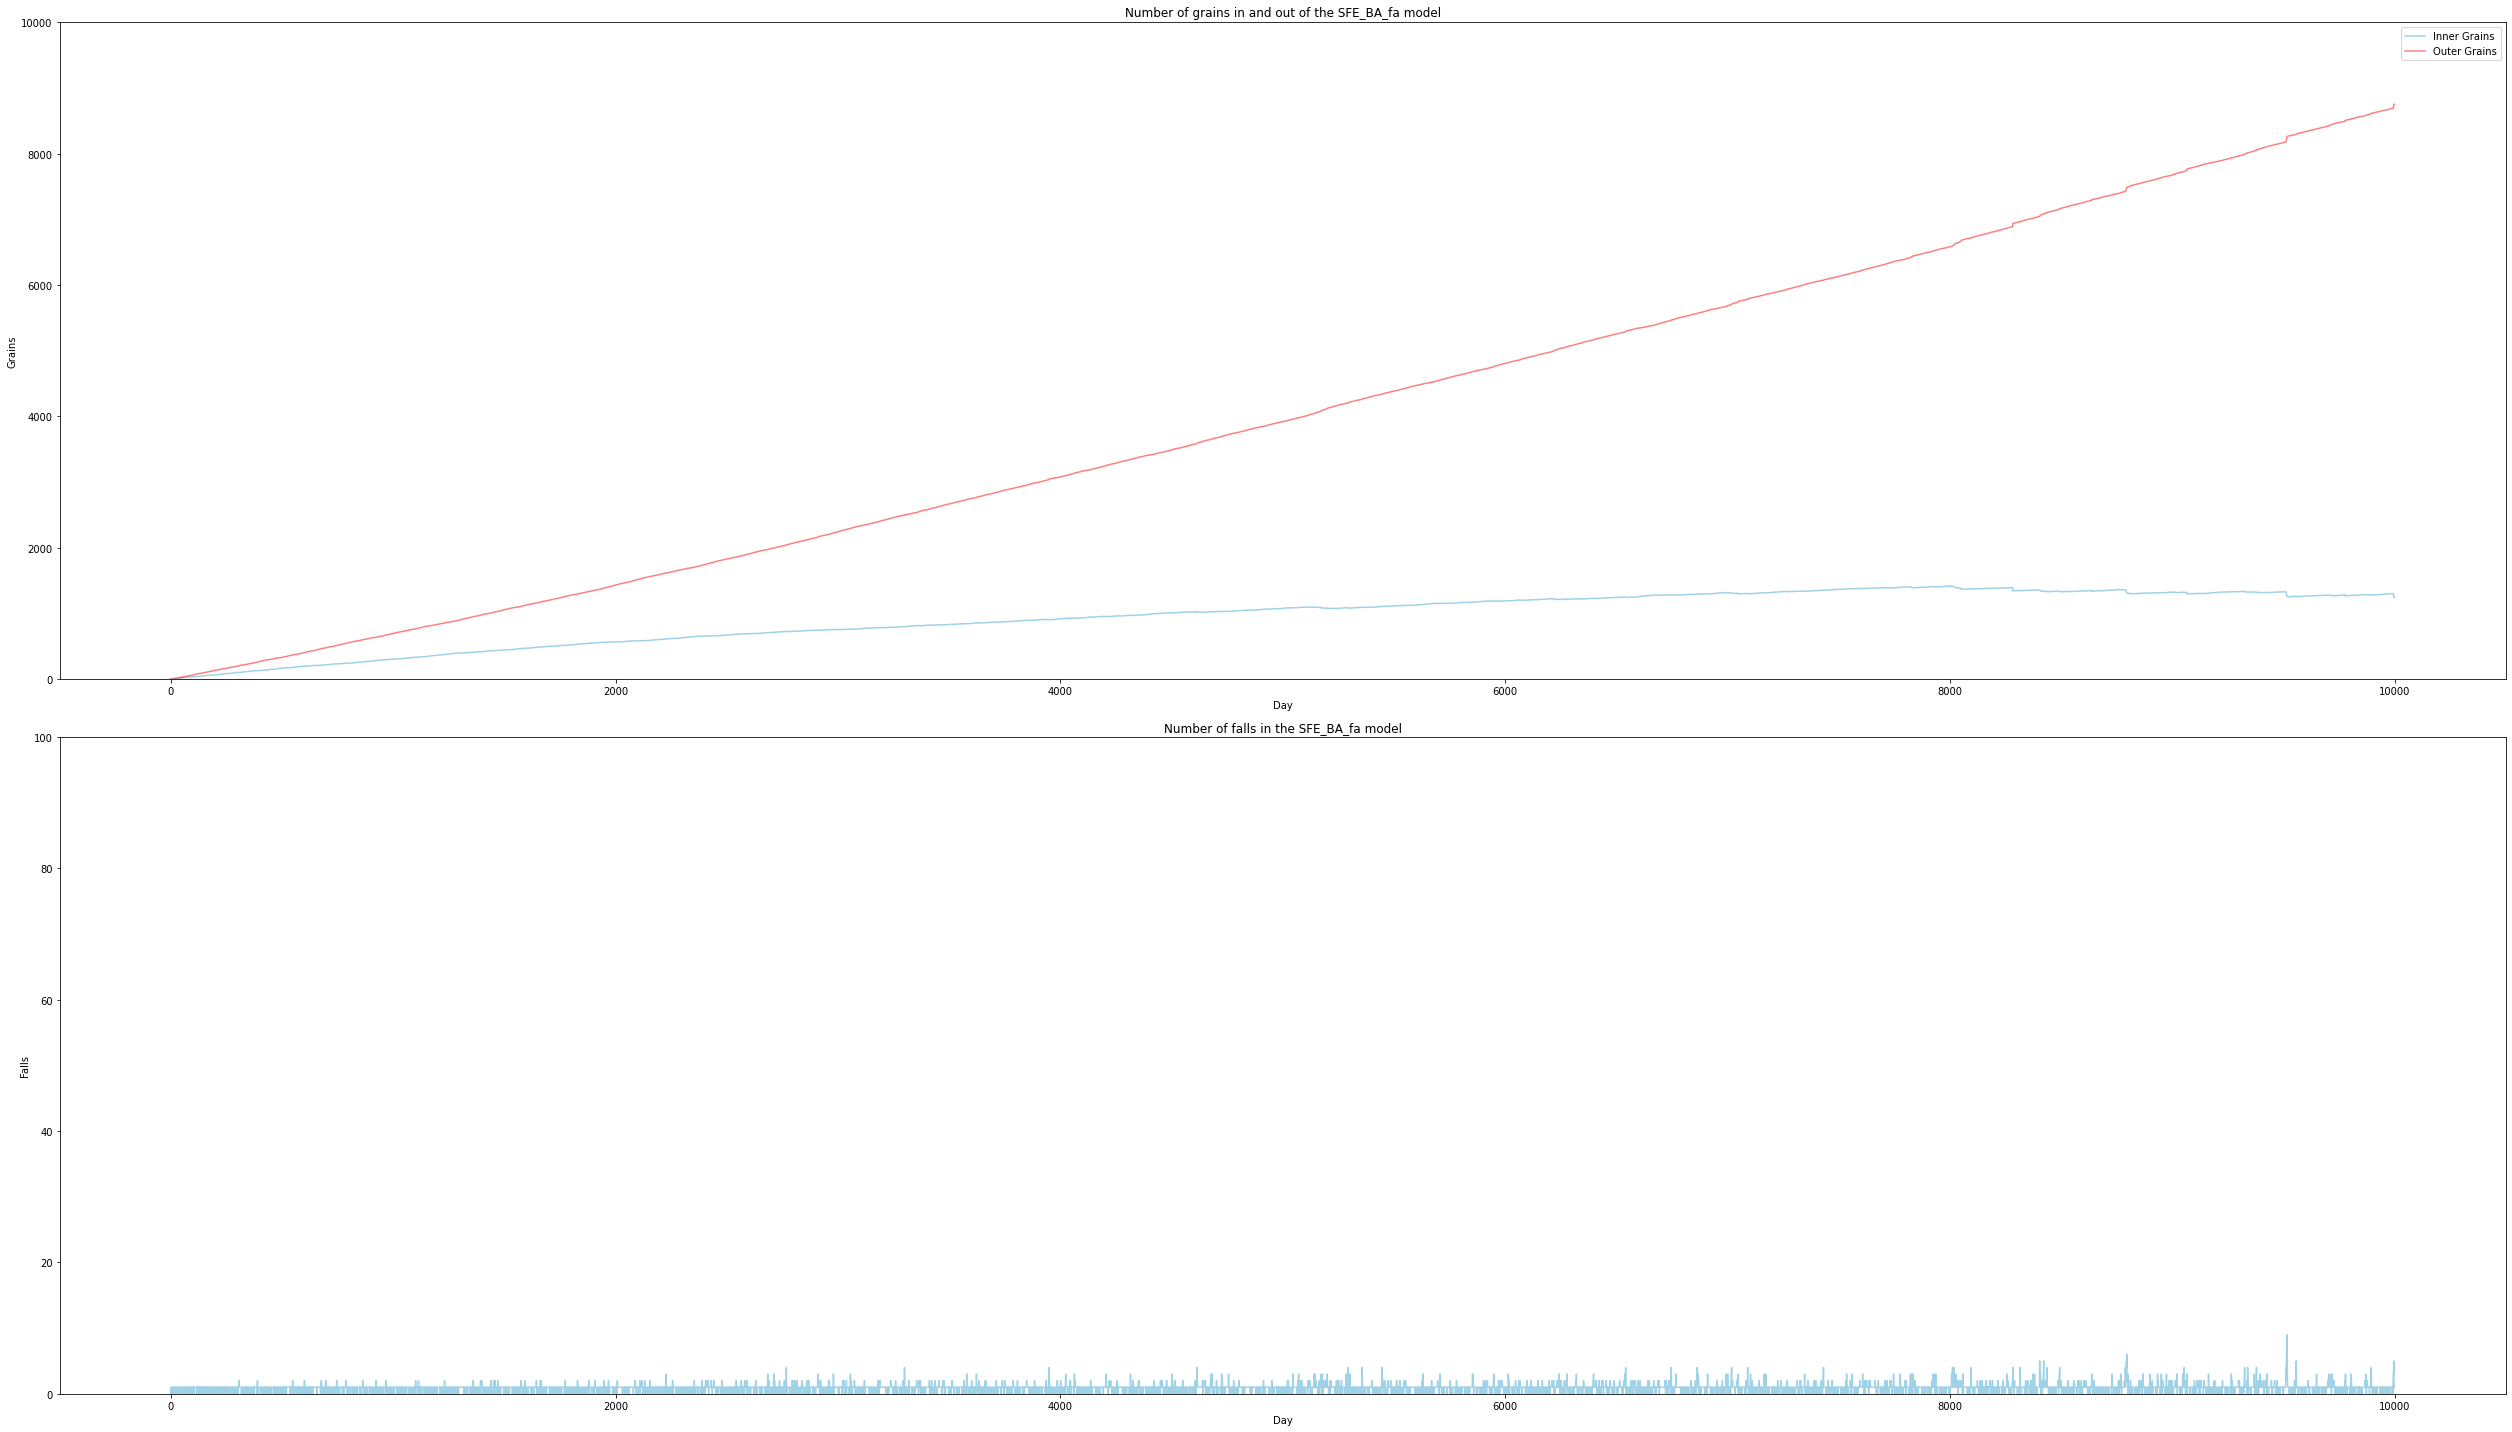

In [62]:
spread("SFE", G_BA, number_of_days, new_grains, "BA", facilitated = True)

100%|██████████| 9999/9999 [01:47<00:00, 93.43it/s]


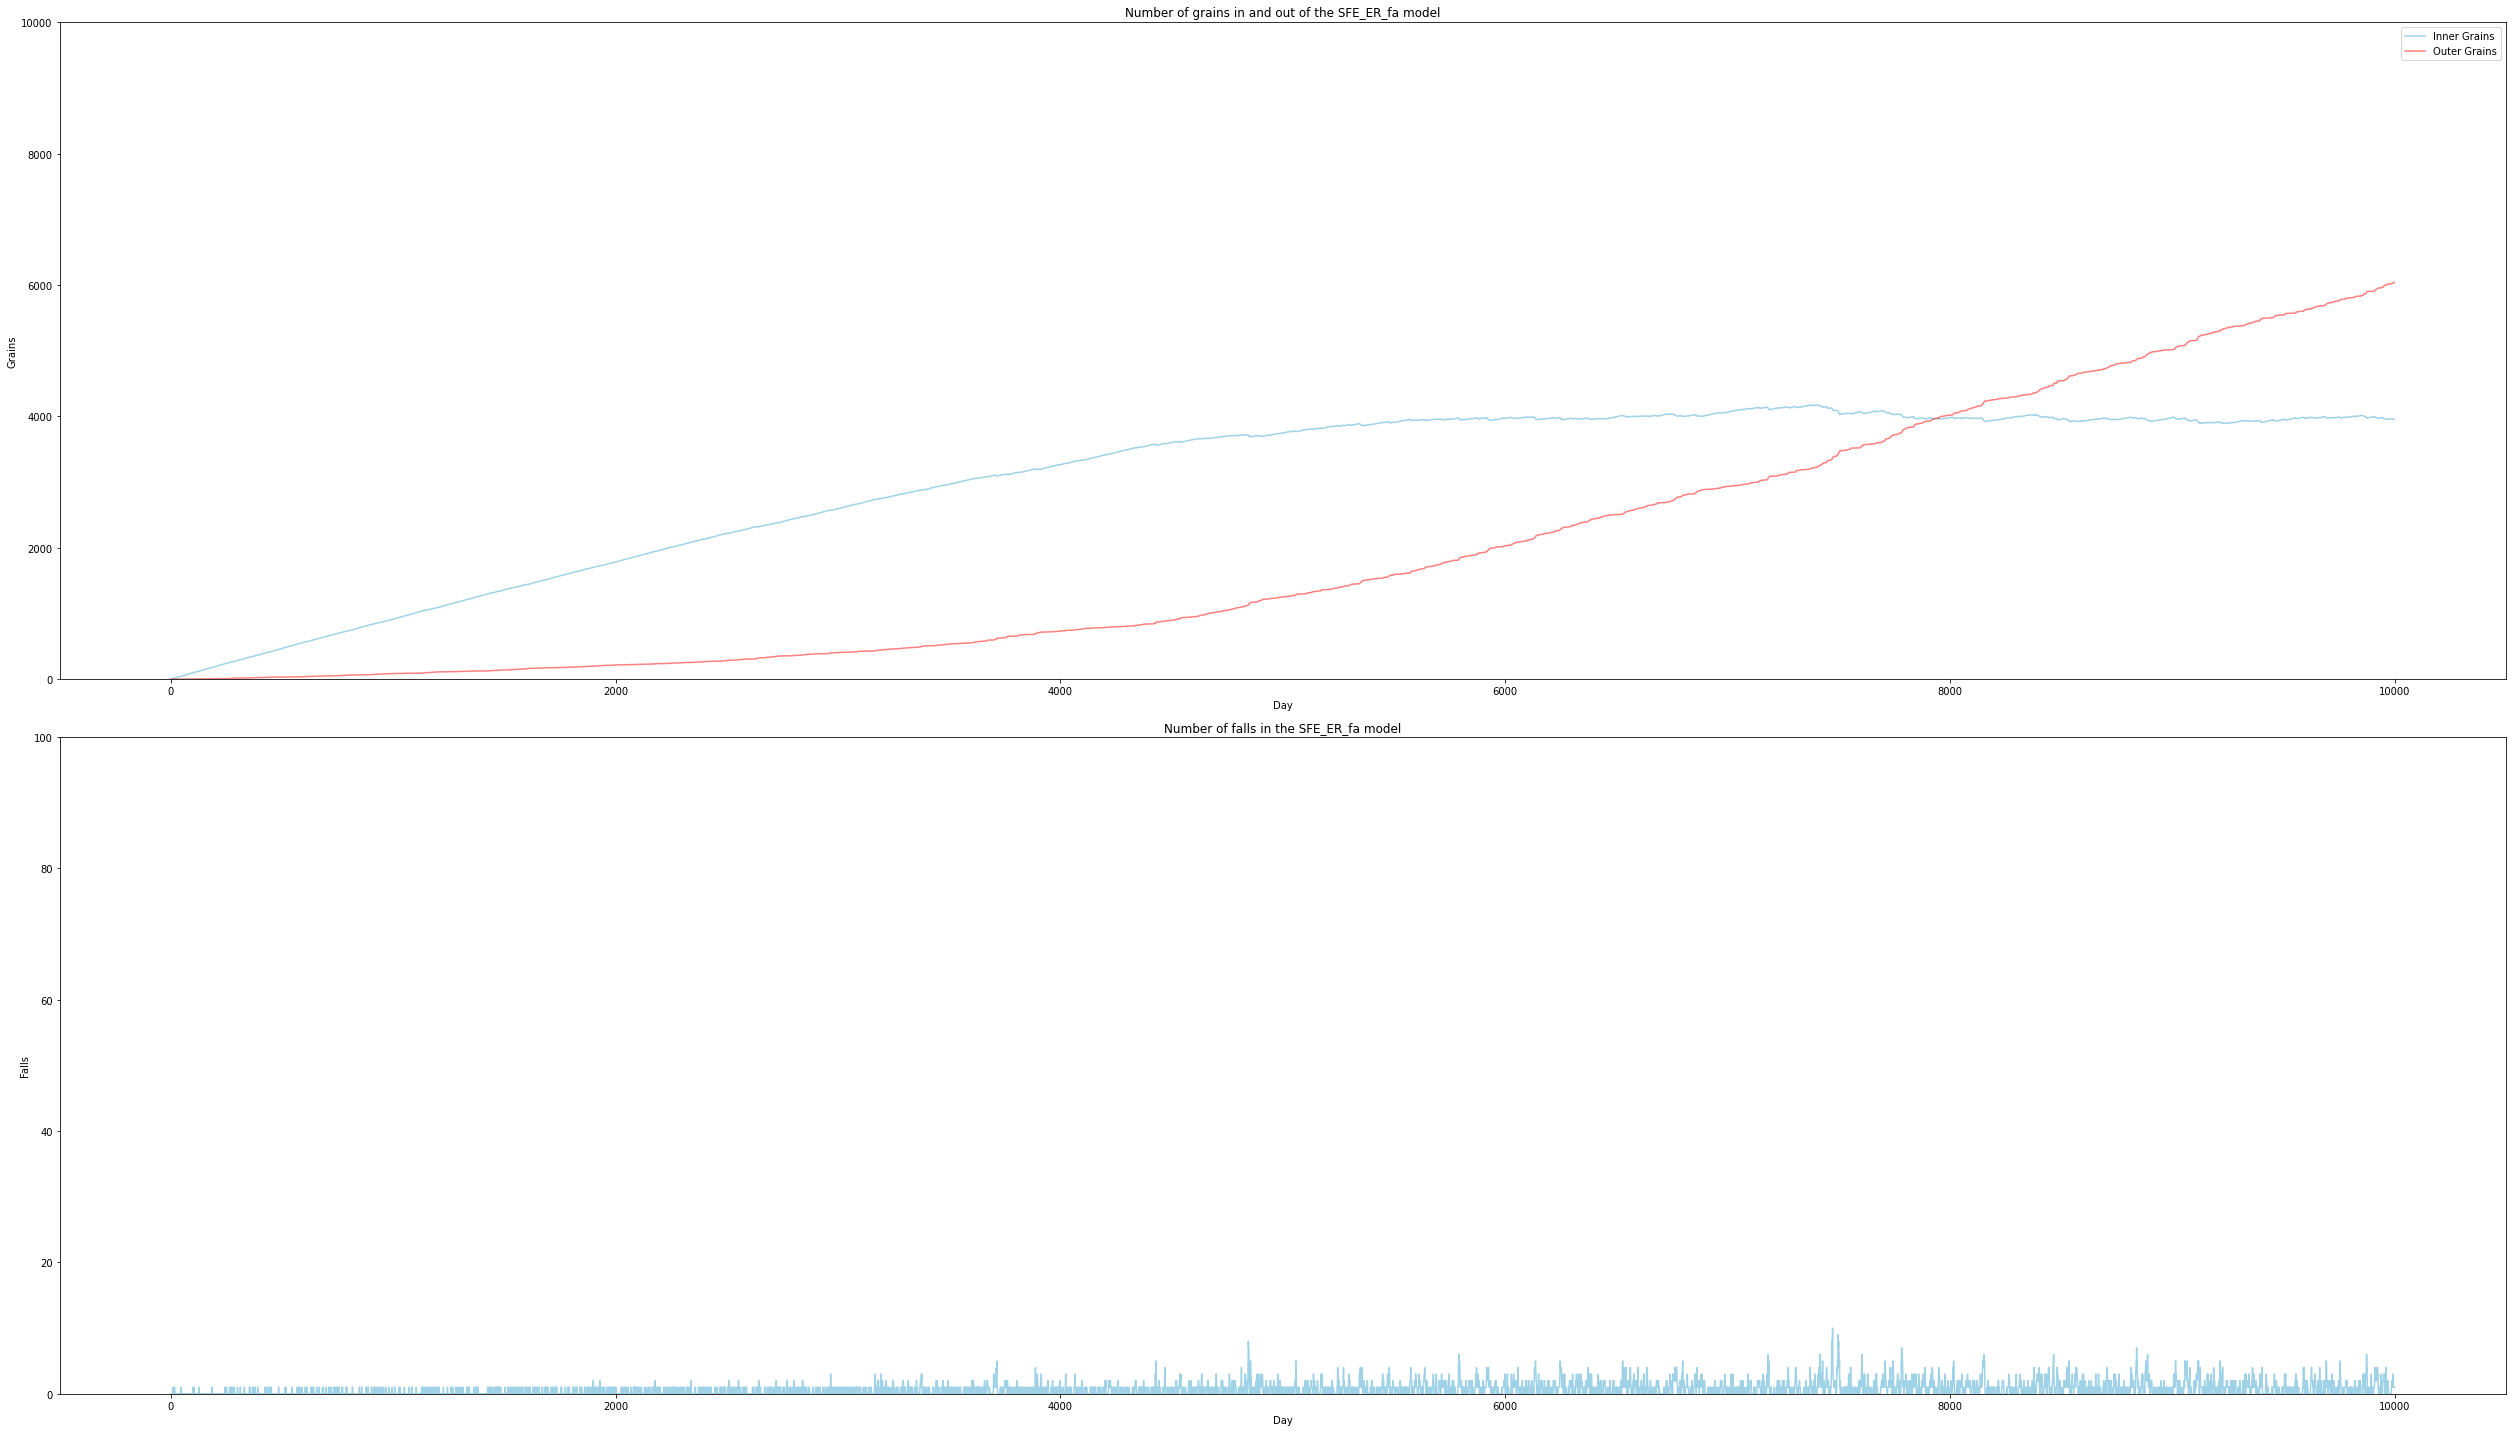

In [63]:
spread("SFE", G_ER, number_of_days, new_grains, "ER", facilitated = True)

100%|██████████| 9999/9999 [01:44<00:00, 95.63it/s]


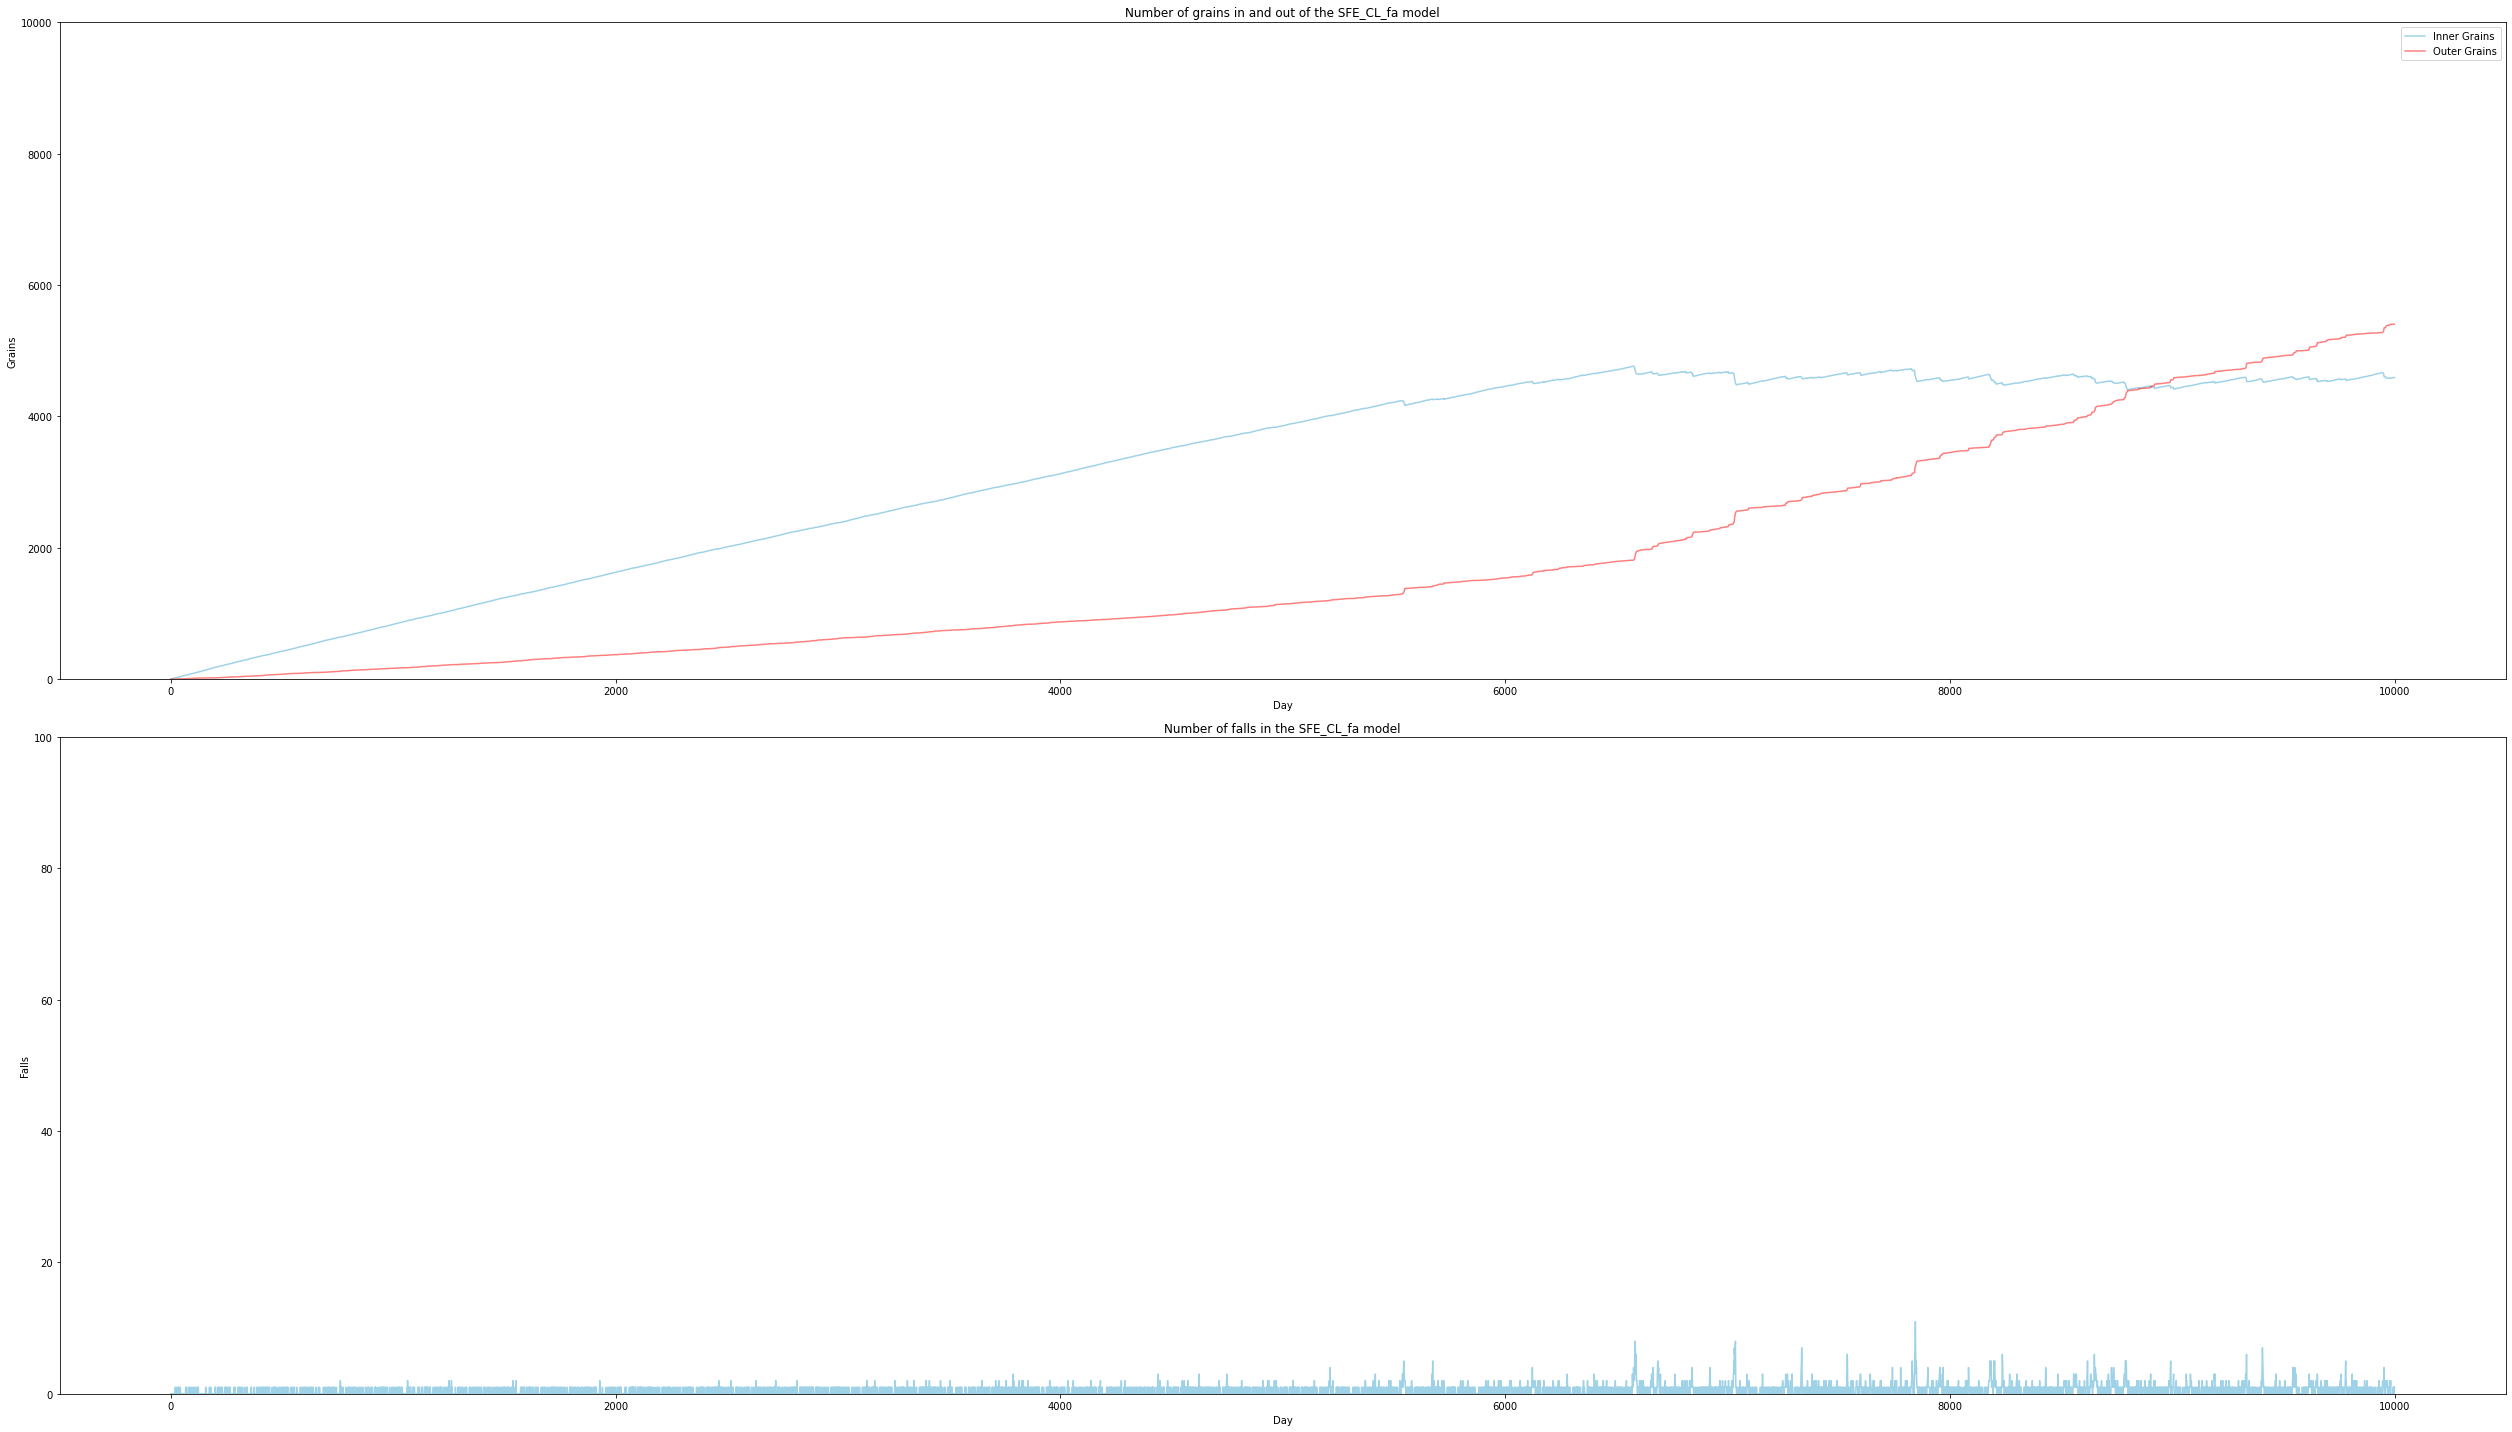

In [64]:
spread("SFE", G_CL, number_of_days, new_grains, "CL", facilitated = True)

##### Additional Dissipation

100%|██████████| 9999/9999 [01:55<00:00, 86.87it/s] 


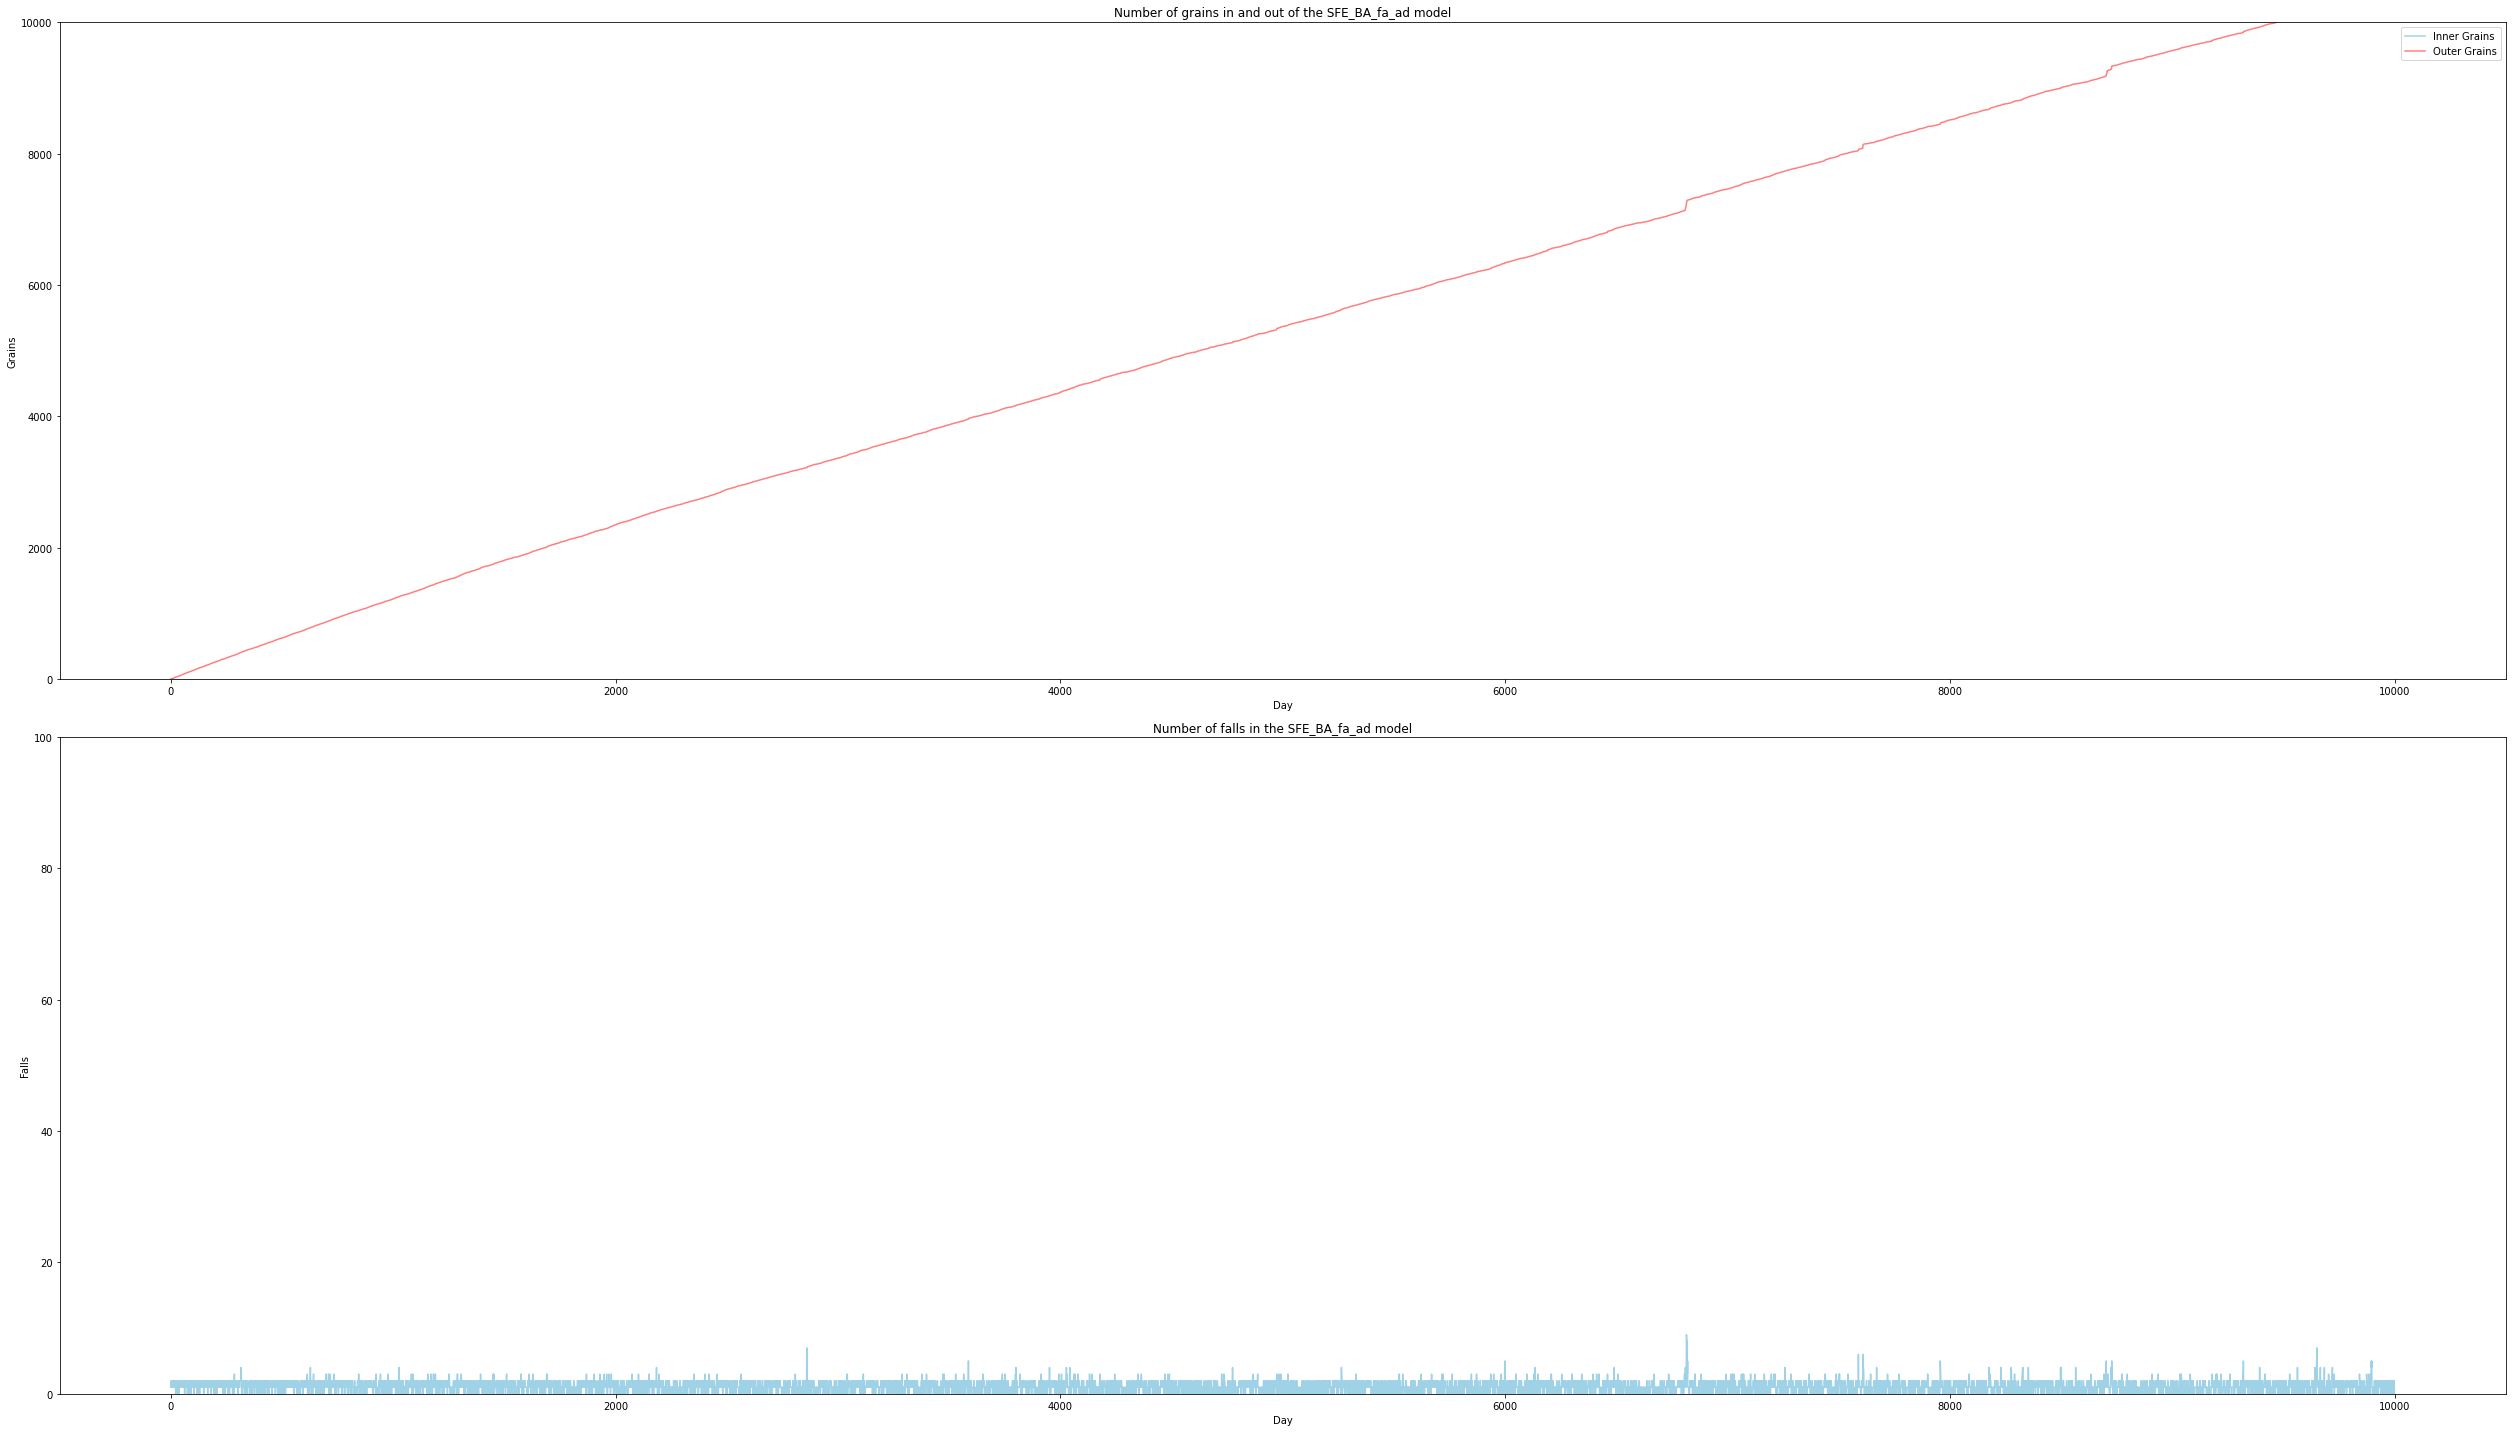

In [65]:
spread("SFE", G_BA, number_of_days, new_grains, "BA", facilitated = True, ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

100%|██████████| 9999/9999 [01:52<00:00, 89.24it/s]


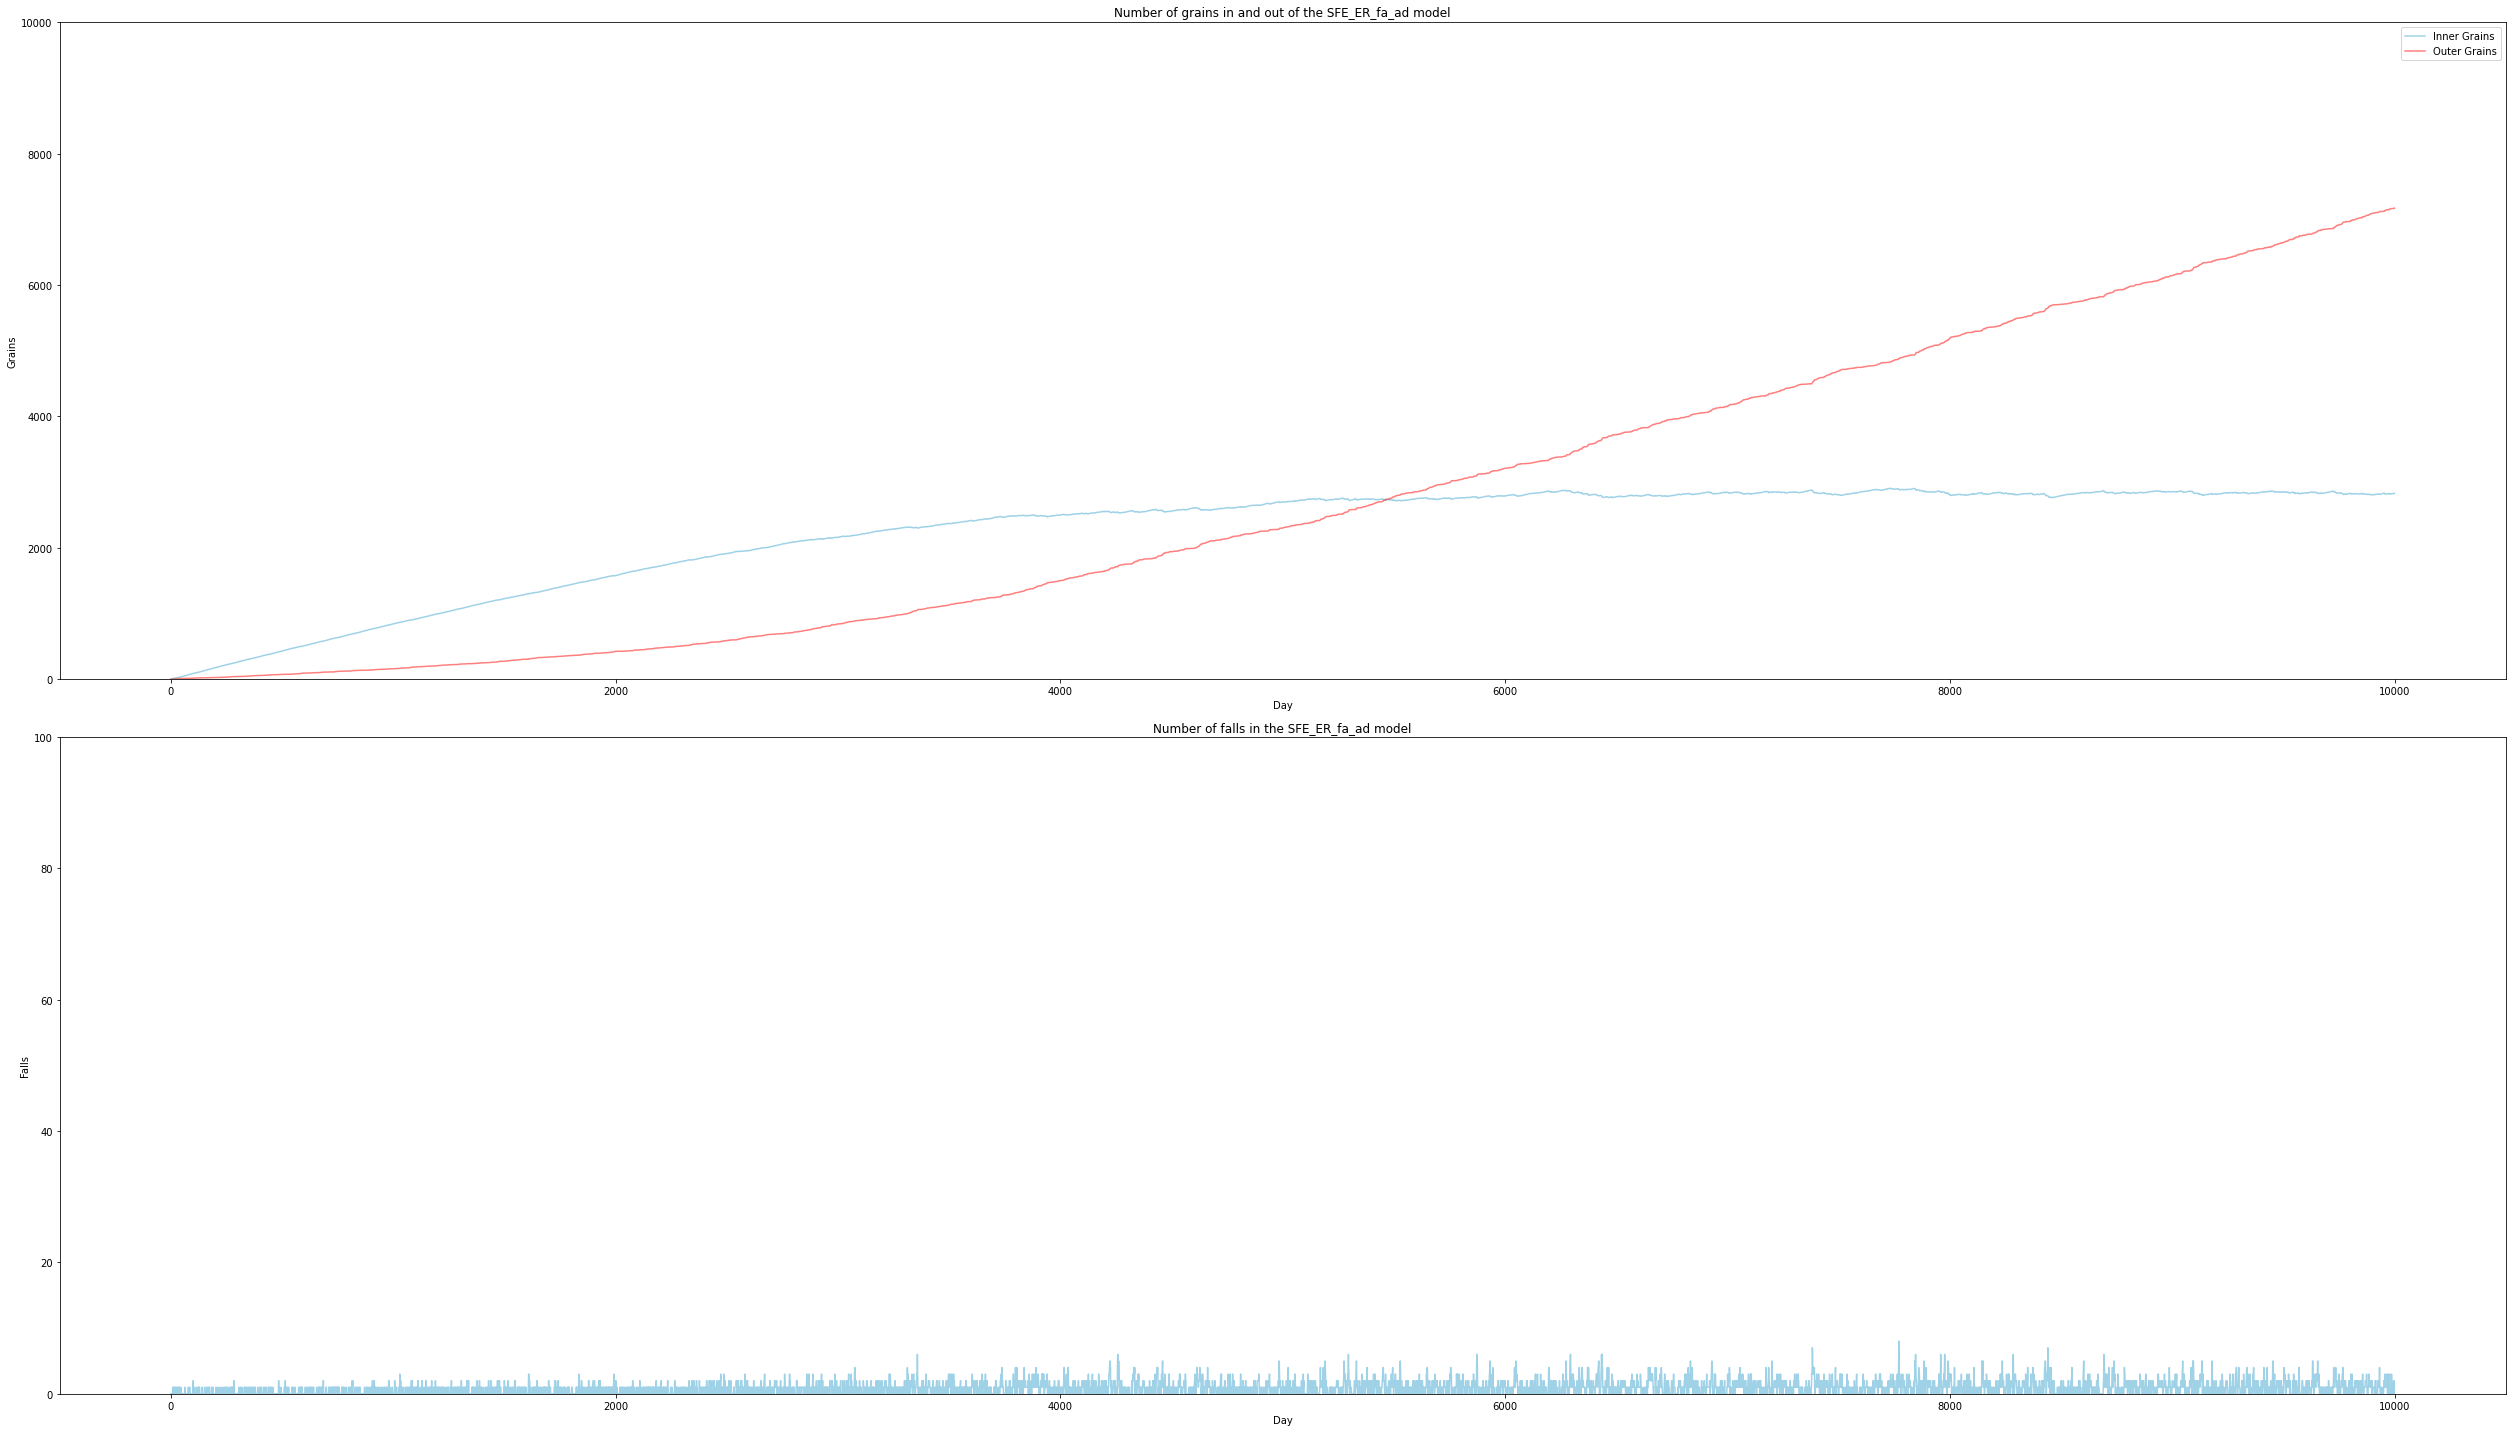

In [66]:
spread("SFE", G_ER, number_of_days, new_grains, "ER", facilitated = True, ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

100%|██████████| 9999/9999 [01:49<00:00, 91.23it/s]


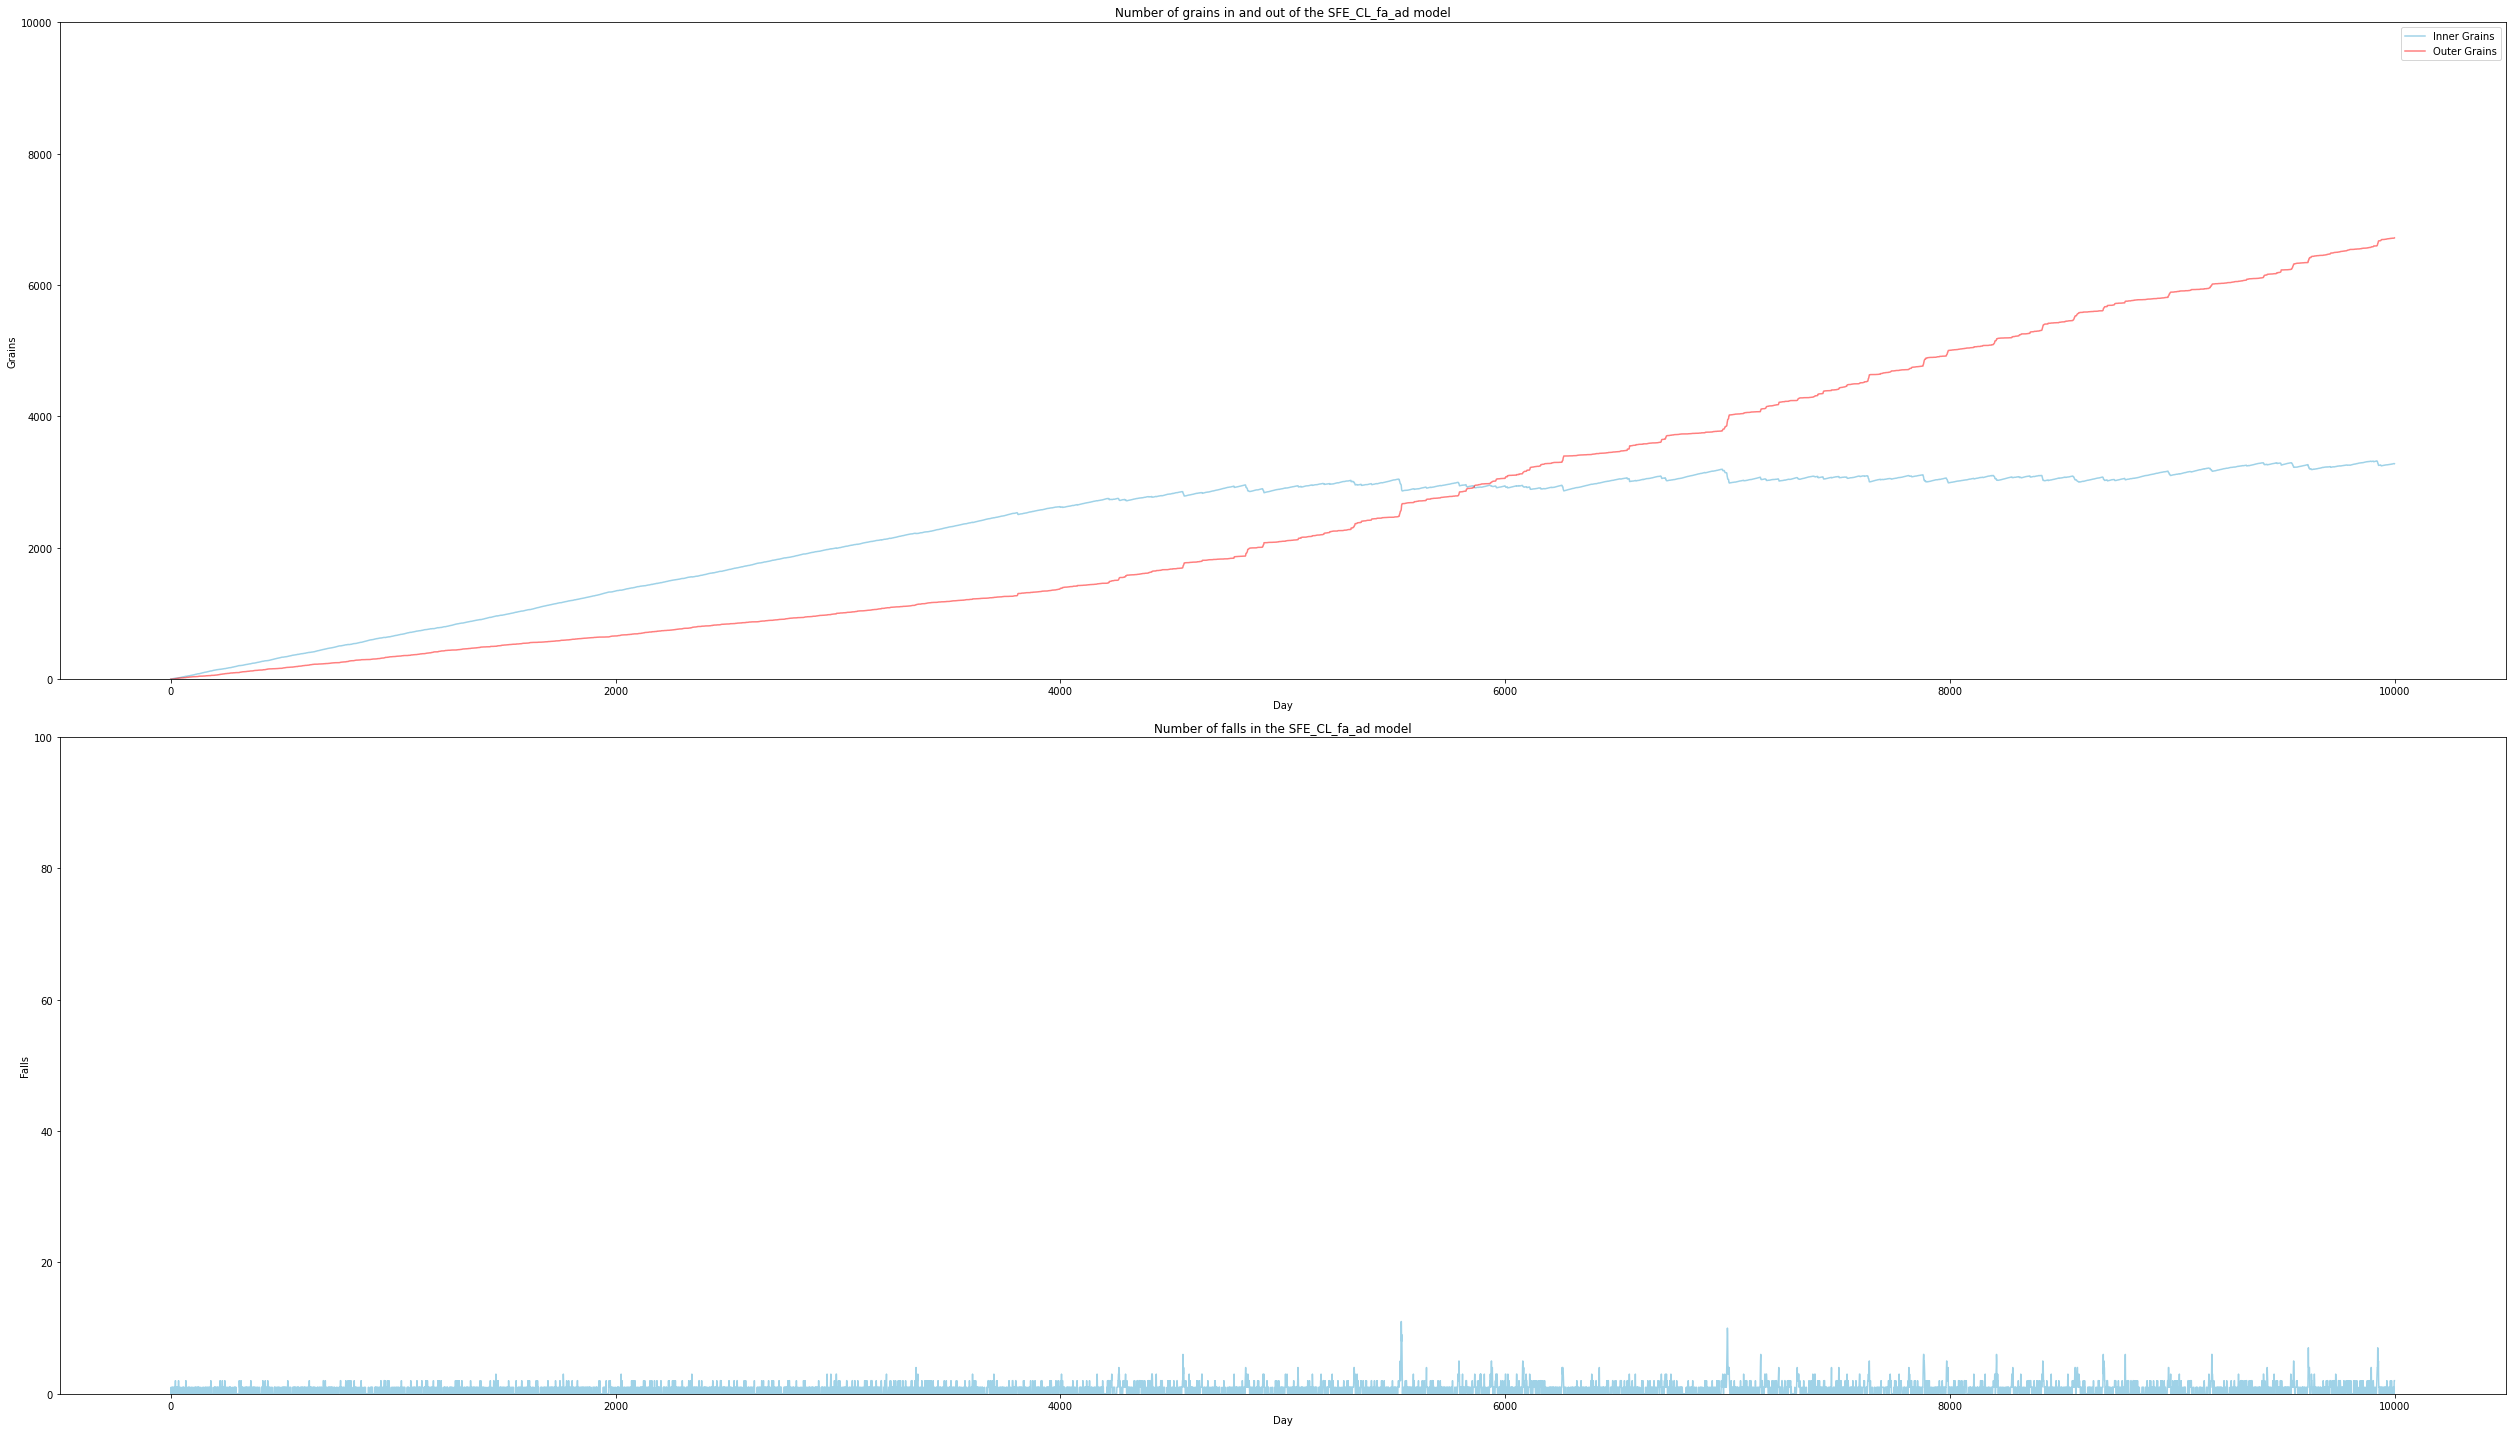

In [67]:
spread("SFE", G_CL, number_of_days, new_grains, "CL", facilitated = True, ad_dissipation = True, new_grains_plus = new_grains_plus, new_grains_minus = new_grains_minus)

##### Neutral State

100%|██████████| 9999/9999 [01:52<00:00, 88.62it/s]


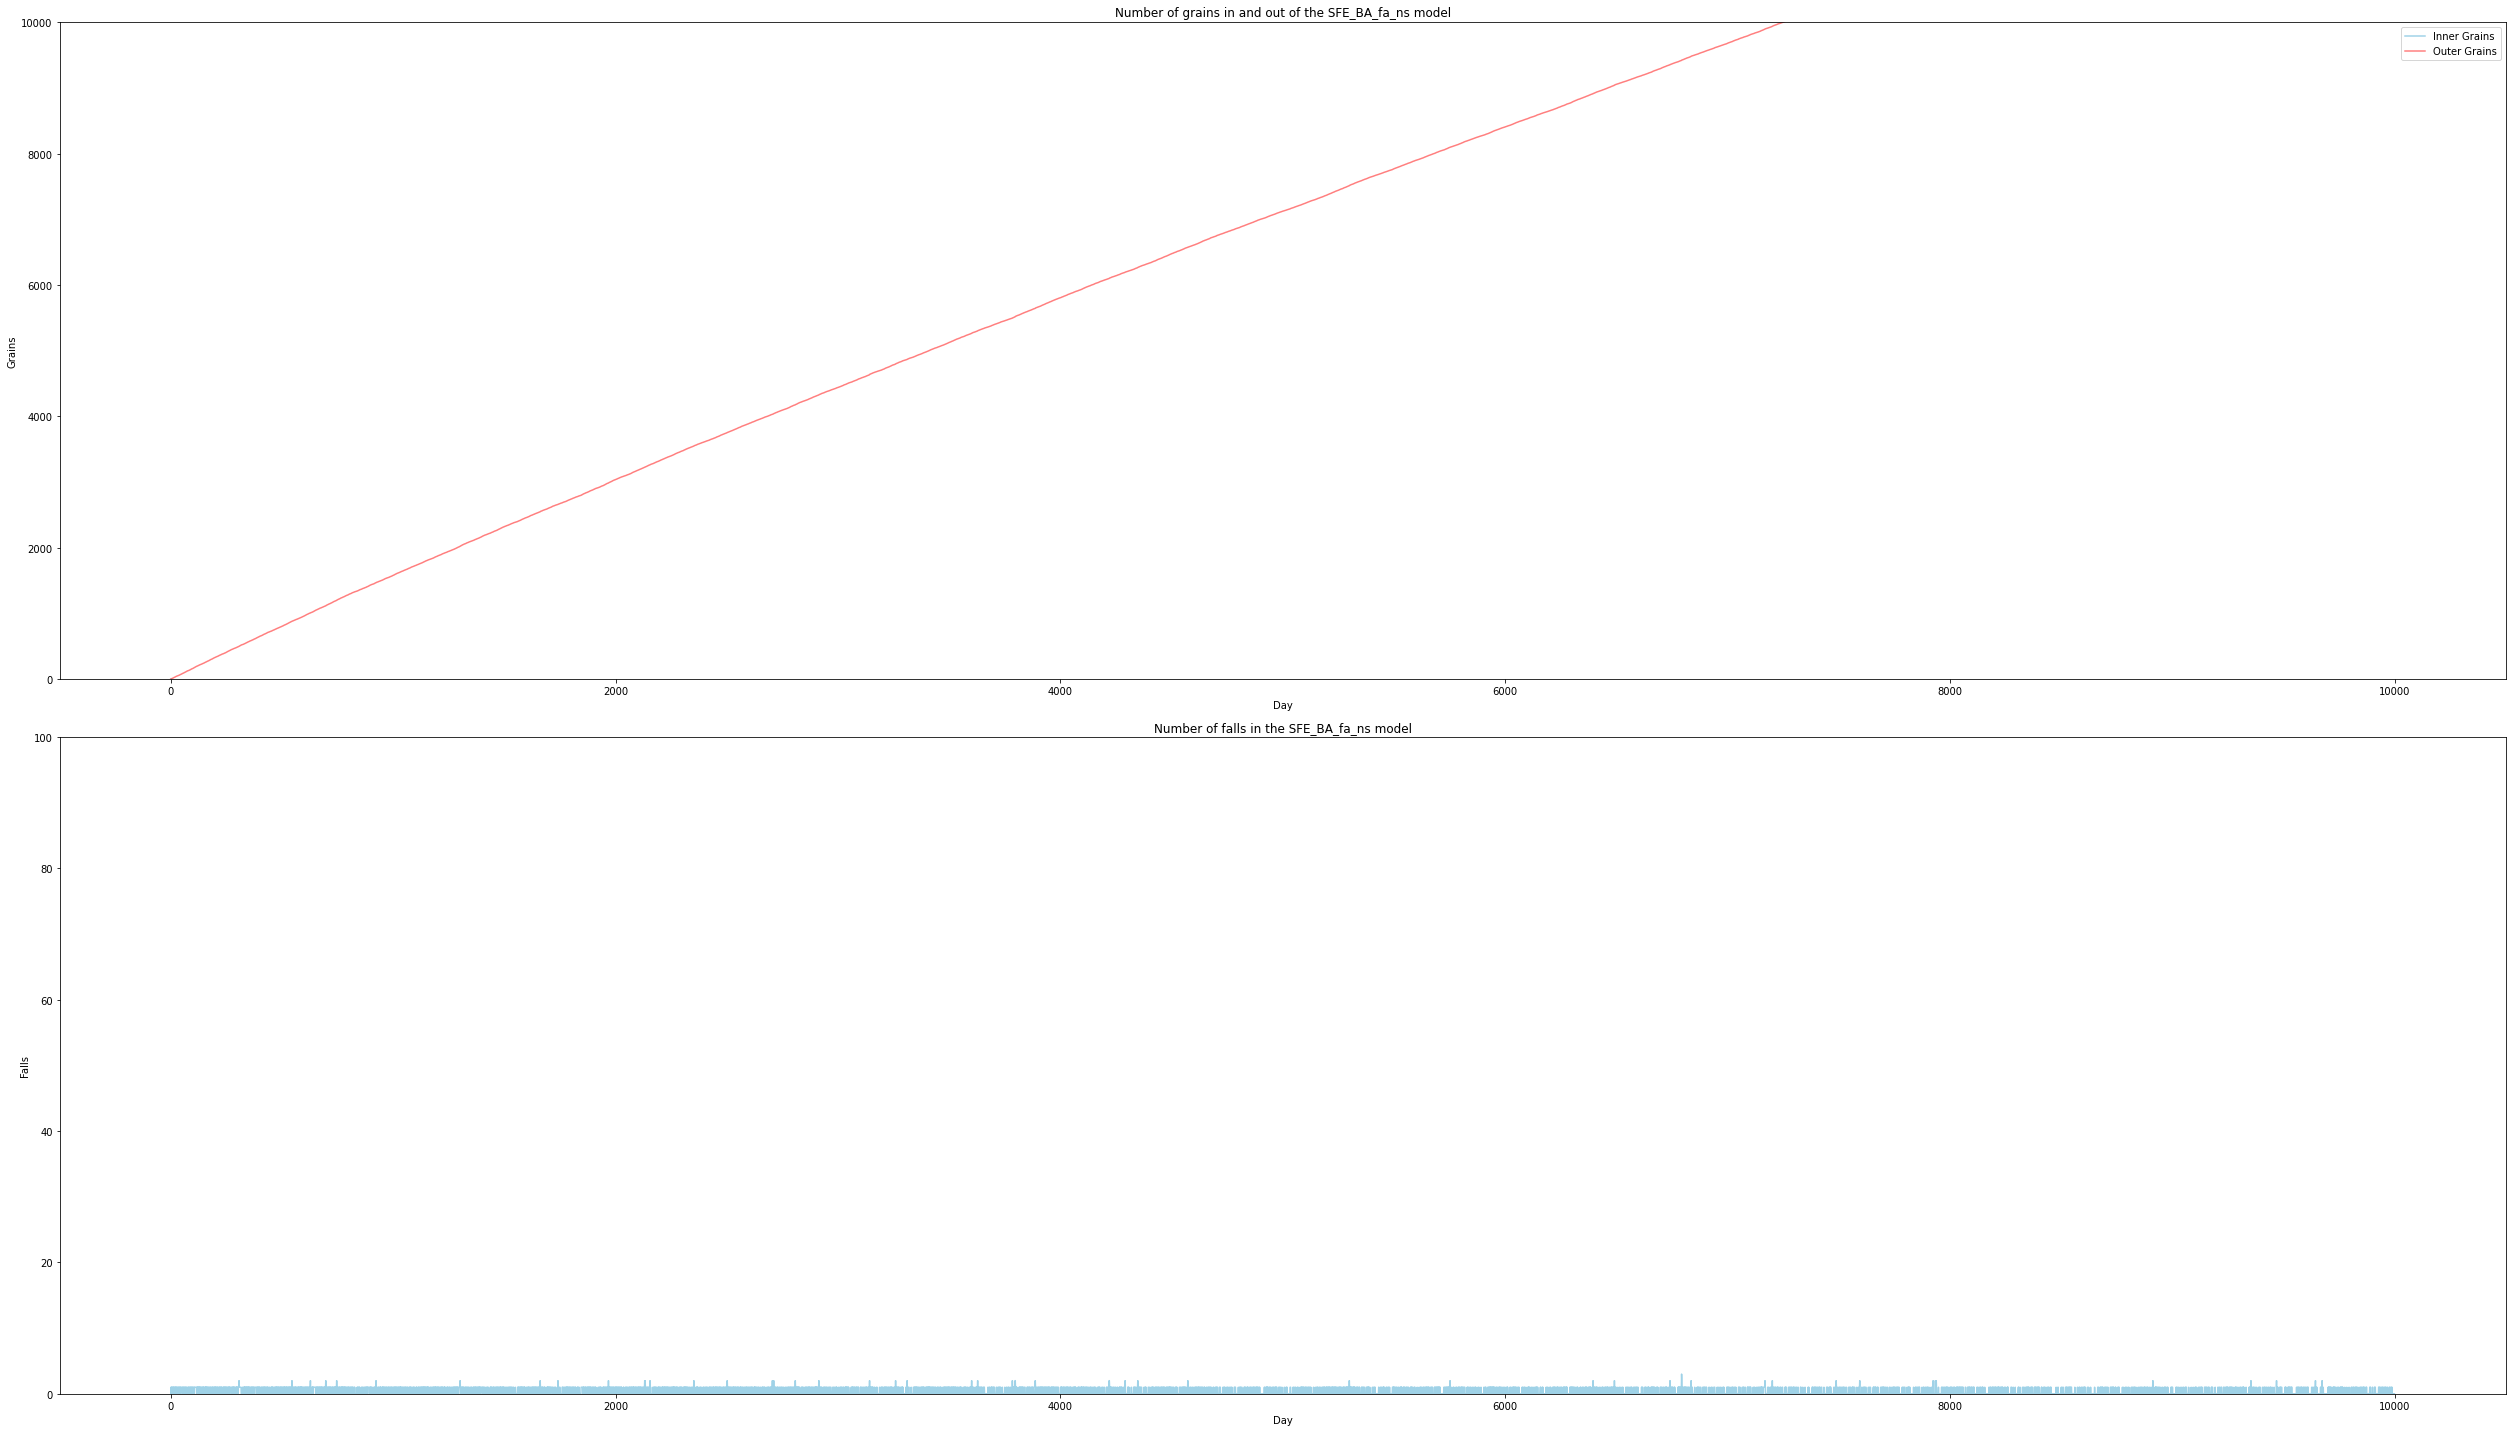

In [97]:
spread("SFE", G_BA, number_of_days, new_grains, "BA", facilitated = True, neutral_state = True, new_grains_minus = new_grains_minus)

100%|██████████| 9999/9999 [01:37<00:00, 102.74it/s]


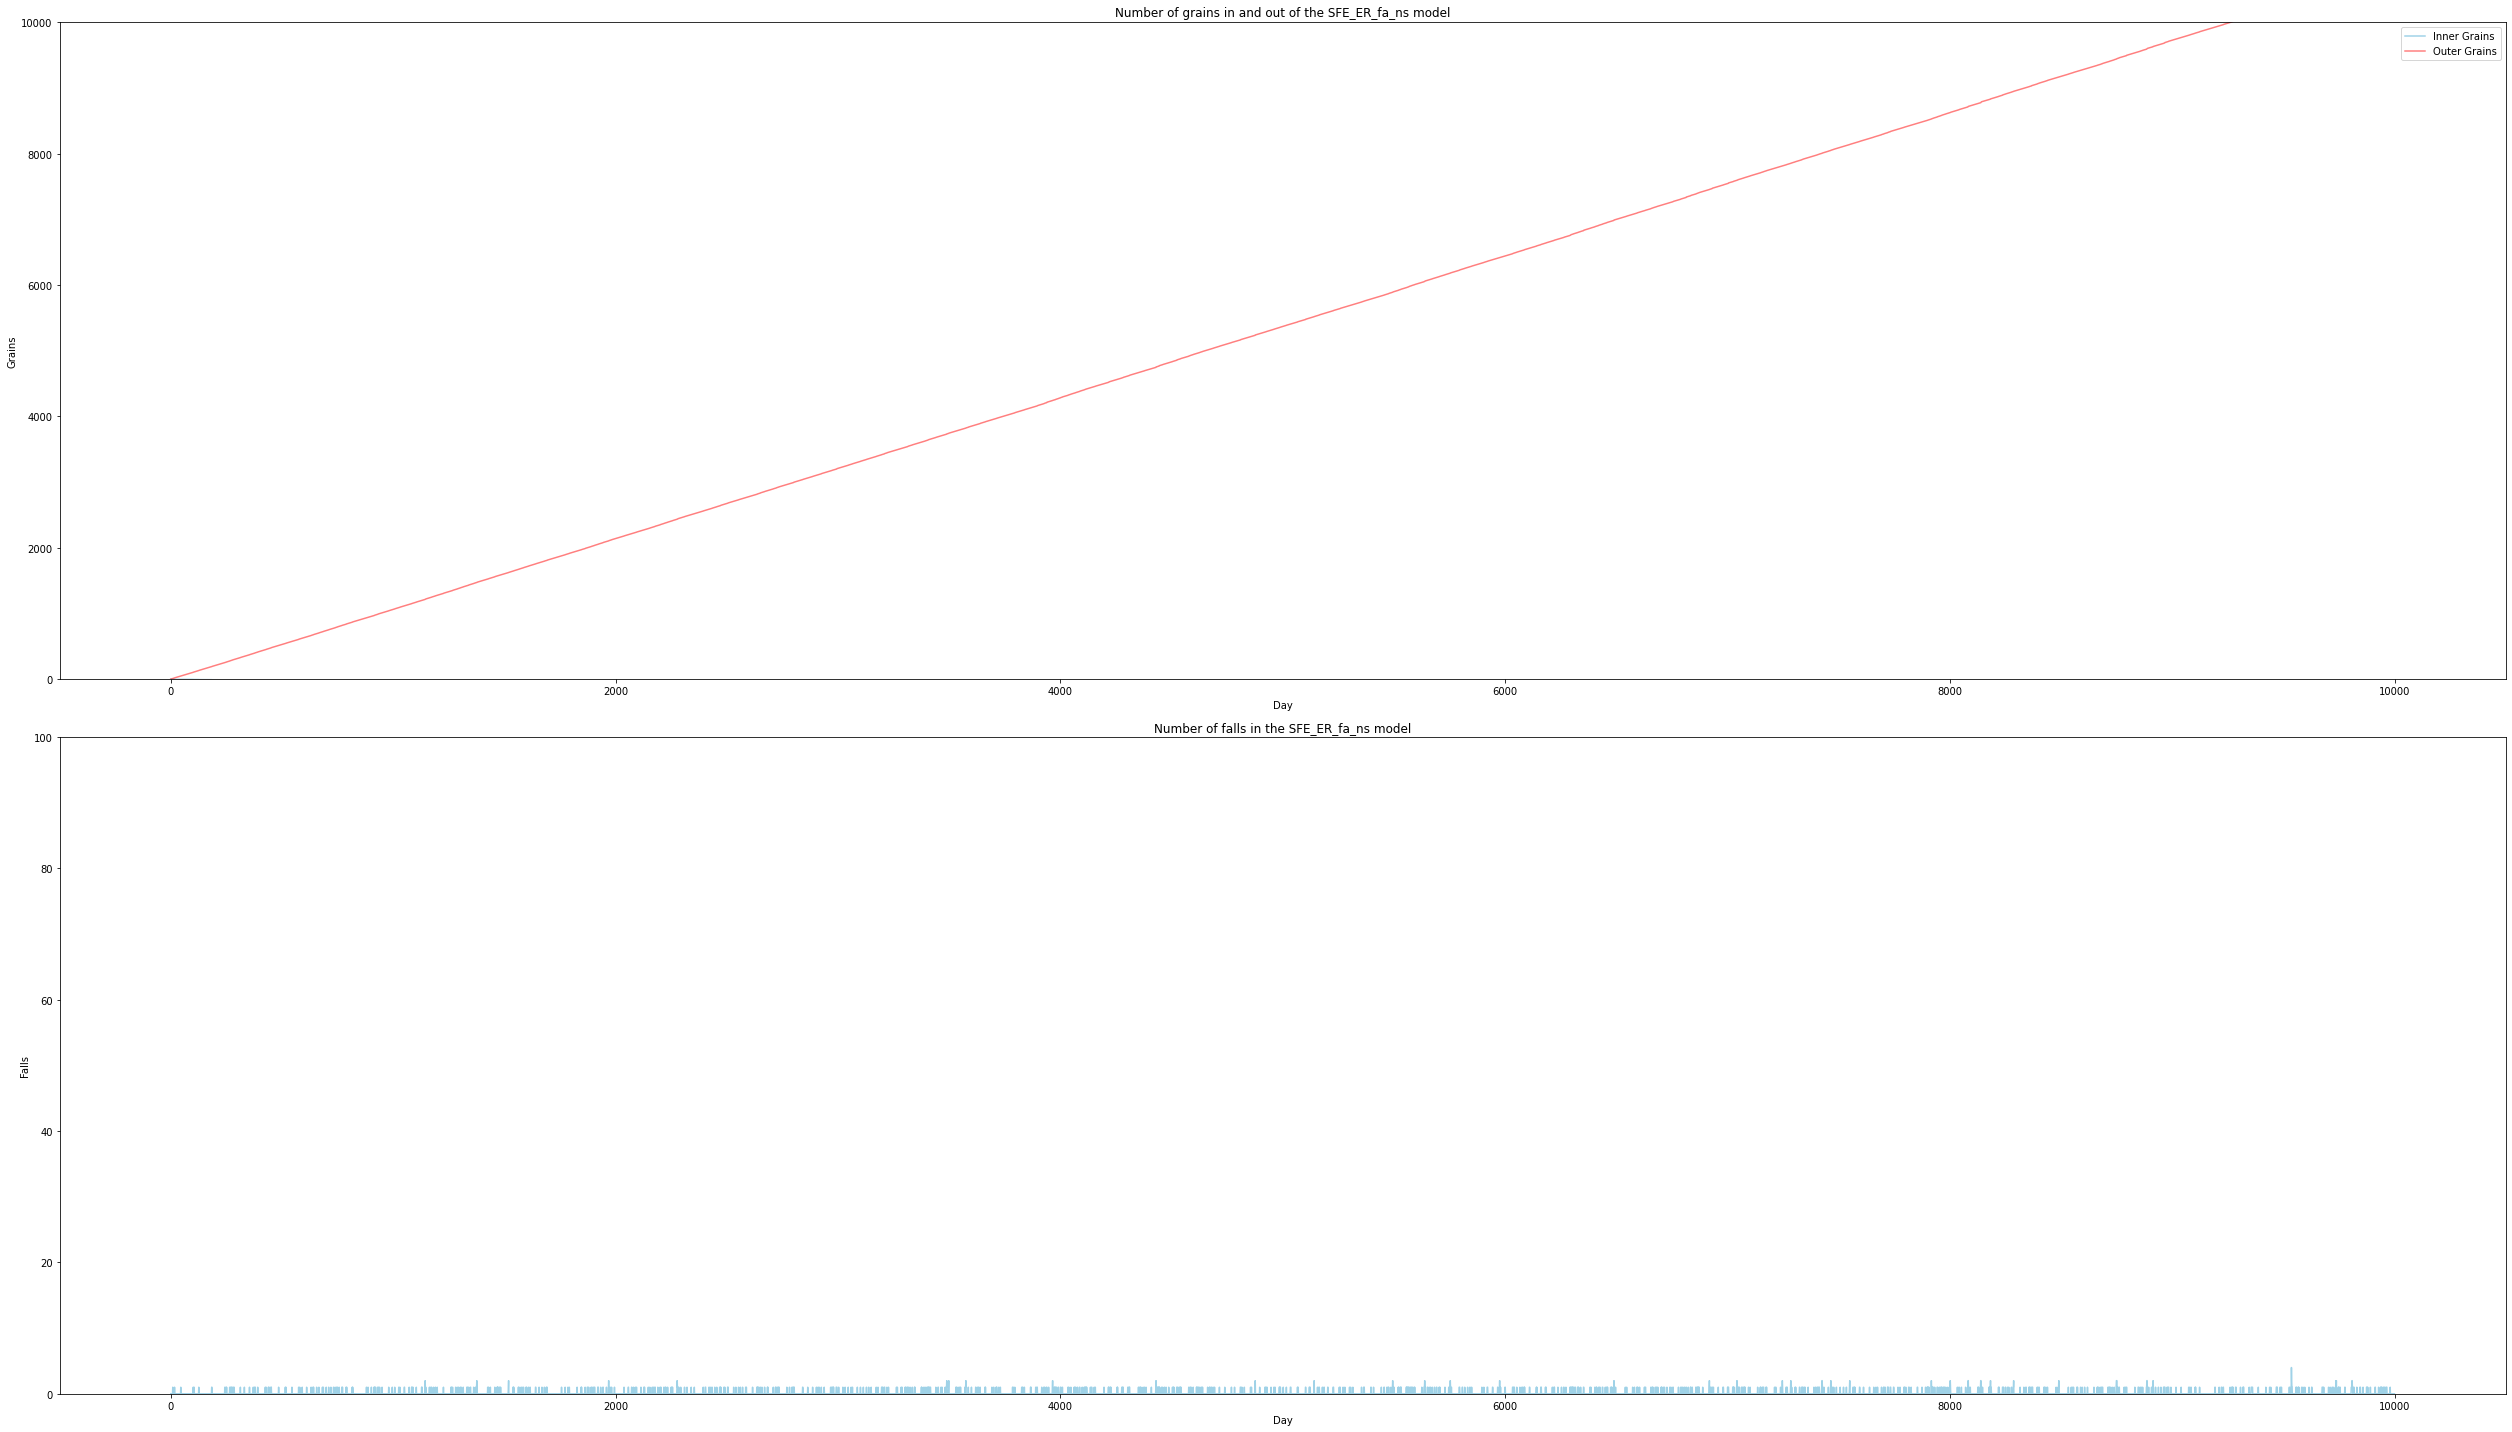

In [98]:
spread("SFE", G_ER, number_of_days, new_grains, "ER", facilitated = True, neutral_state = True, new_grains_minus = new_grains_minus)

100%|██████████| 9999/9999 [01:44<00:00, 95.34it/s]


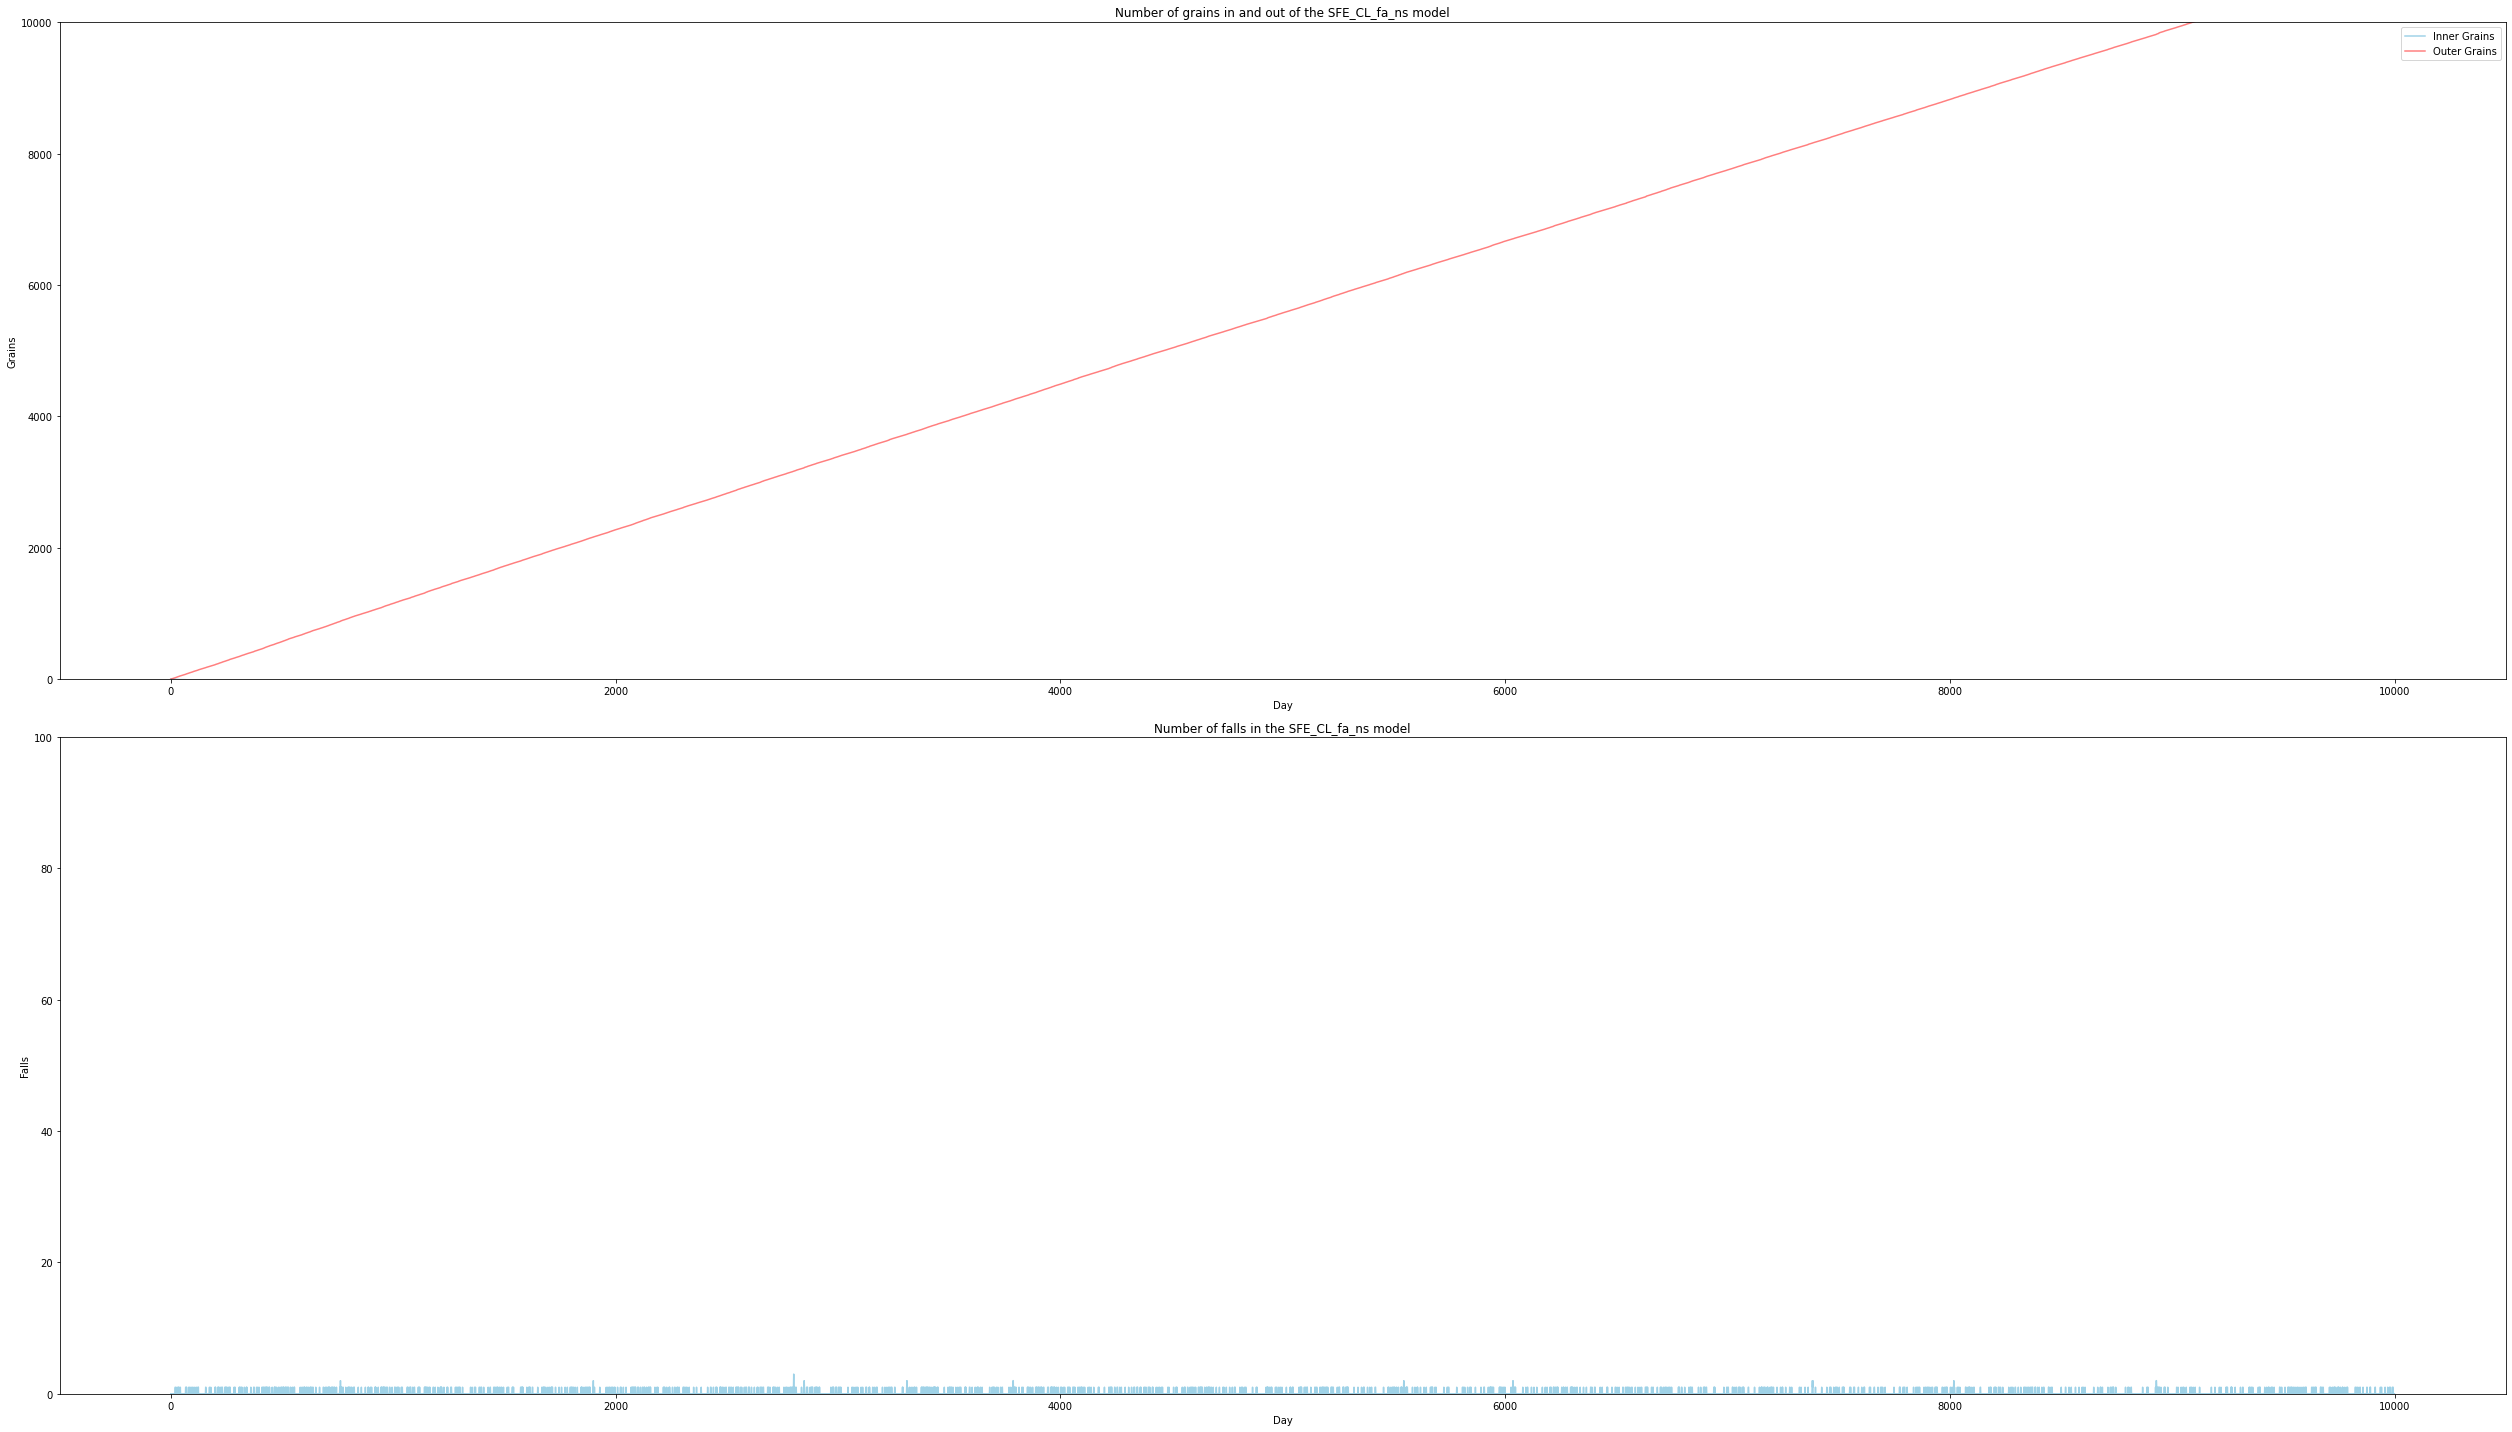

In [99]:
spread("SFE", G_CL, number_of_days, new_grains, "CL", facilitated = True, neutral_state = True, new_grains_minus = new_grains_minus)

### Graph statistics

#### Plotting function

In [68]:
# Plotting

def k_distrib(graph, graph_type = None, scale='lin', colour='#40a6d1', alpha=.8, fit_line=False, expct_lo=1, expct_hi=10, expct_const=1):
    
    plt.close()
    num_nodes = graph.number_of_nodes()
    max_degree = 0
    
    # Calculate the maximum degree to know the range of x-axis
    for n in graph.nodes():
        if graph.degree(n) > max_degree:
            max_degree = graph.degree(n)
    
    # X-axis and y-axis values
    x = []
    y_tmp = []
    
    # Loop over all degrees until the maximum to compute the portion of nodes for that degree
    for i in range(max_degree + 1):
        x.append(i)
        y_tmp.append(0)
        for n in graph.nodes():
            if graph.degree(n) == i:
                y_tmp[i] += 1
        y = [i / num_nodes for i in y_tmp]
    
    if graph_type != None:  
      with open('degrees_' + graph_type + '.csv', 'w') as myfile:
        wr = csv.writer(myfile, delimiter=',')
        wr.writerow(y_tmp)
    
    # Check for the lin / log parameter and set axes scale
    if scale == 'log':
        plt.figure(figsize=(10, 8))
        plt.xscale('log')
        plt.yscale('log')
        plt.title('Degree distribution (log-log scale)')
        plt.ylabel('log(P(k))')
        plt.xlabel('log(k)')
        plt.plot(x, y, linewidth = 0, marker = 'o', markersize = 8, color = colour, alpha = alpha)
        
        if fit_line:
            # Add theoretical distribution line k^-3
            # Note that you need to parametrize it manually
            w = [a for a in range(expct_lo,expct_hi)]
            z = []
            for i in w:
                x = (i**-3) * expct_const # set line's length and fit intercept
                z.append(x)

            plt.plot(w, z, 'k-', color='#7f7f7f')
            
    else:
        plt.figure(figsize=(10, 8))
        plt.plot(x, y, linewidth = 0, marker = 'o', markersize = 8, color = colour, alpha = alpha)
        plt.title('Degree distribution (linear scale)')
        plt.ylabel('P(k)')
        plt.xlabel('k')

    plt.show()

#### Barabasi-Albert

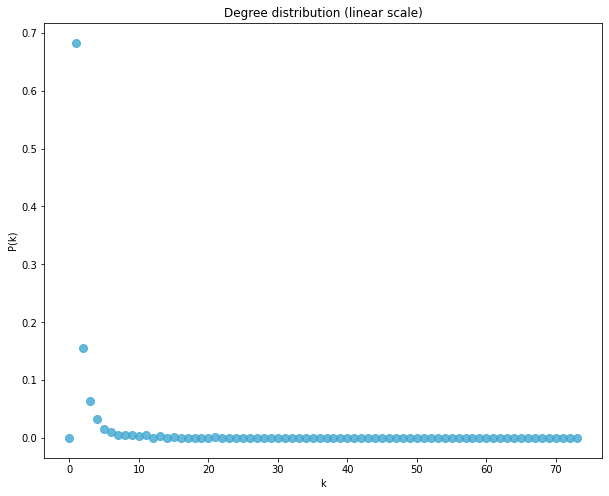

In [69]:
k_distrib(G_BA, "BA")

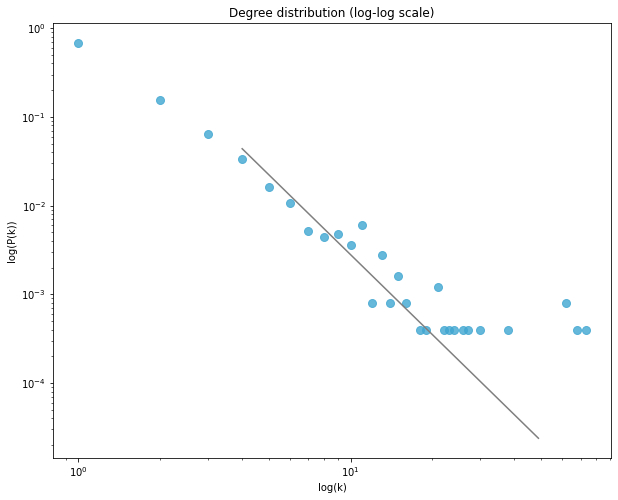

In [70]:
k_distrib(G_BA, scale = 'log', fit_line = True, expct_lo=4, expct_hi=50, expct_const=2.8)

#### Erdos-Renyi

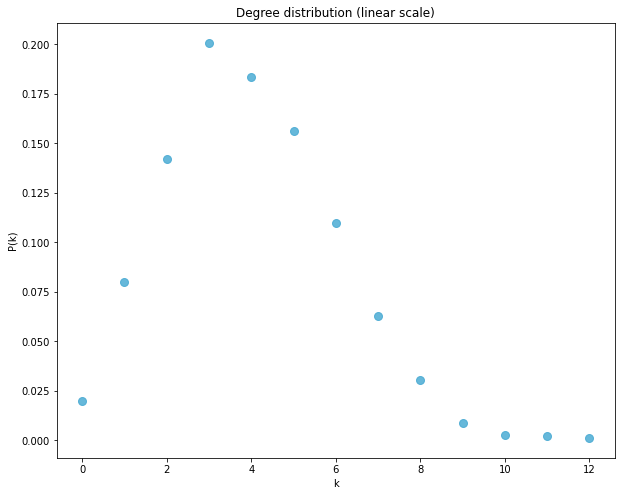

In [71]:
k_distrib(G_ER, "ER")

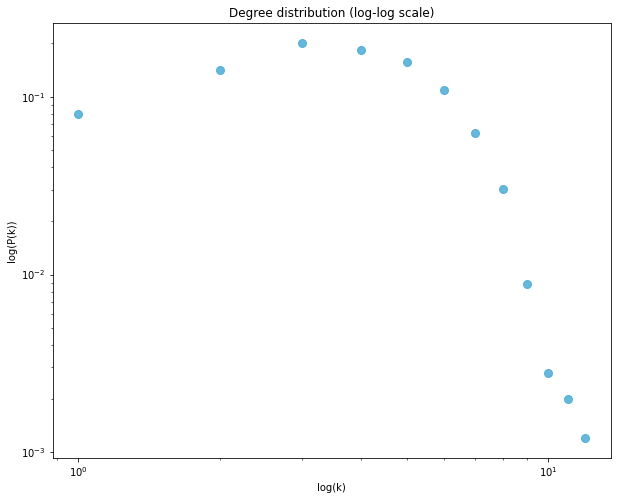

In [72]:
k_distrib(G_ER, scale = 'log', fit_line = False, expct_lo=4, expct_hi=50, expct_const=2.8)

#### Chung-Lu

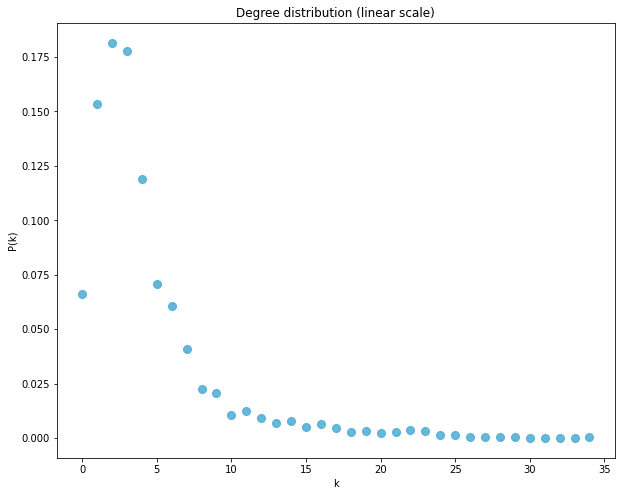

In [73]:
k_distrib(G_CL, "CL")

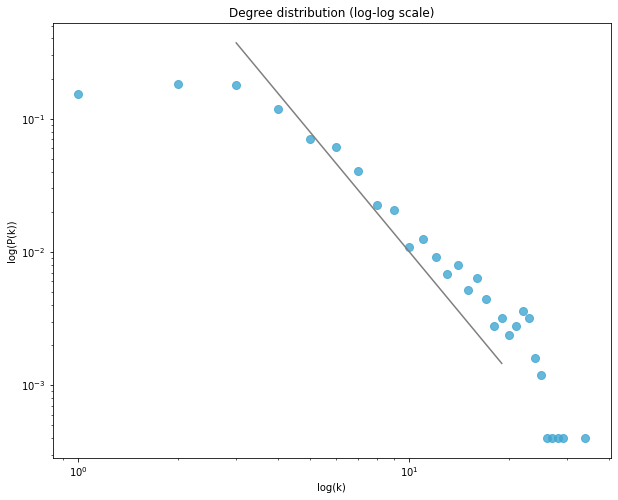

In [74]:
k_distrib(G_CL, scale = 'log', fit_line = True, expct_lo=3, expct_hi=20, expct_const=10)